In [1]:
from keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Using TensorFlow backend.


In [2]:
(train_X,train_y),(test_X,test_y)=load_data()

In [3]:
print(train_X.shape,train_y.shape)
print(test_X.shape,test_y.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [4]:
train_X[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

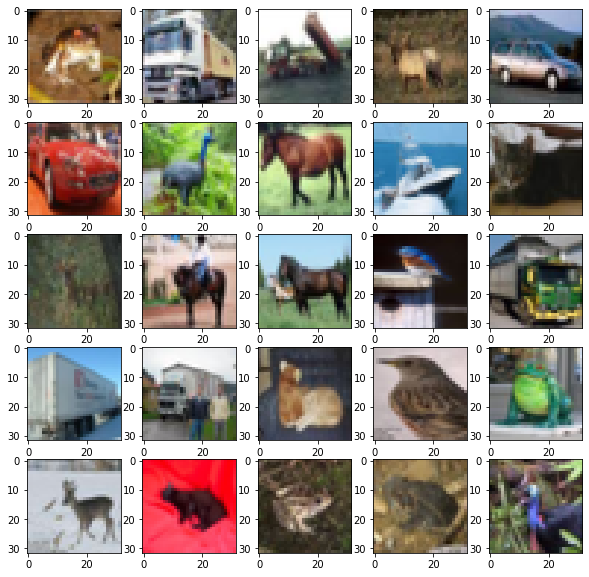

In [5]:
#print first 25 images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_X[i])

# Discriminator NN
4 conv layer + 1 fully connected layer

In [6]:
def discriminator():
    model=tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64,(3,3),padding='same',input_shape=train_X[0].shape),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(128,(3,3),strides=(2,2),padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(128,(3,3),strides=(2,2),padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(256,(3,3),strides=(2,2),padding='same'), #become(4*4*256)
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    opt=tf.keras.optimizers.Adam(lr=0.0002,beta_1=0.5) #adam version of stochastic gradient
    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['acc'])
    #model.summary()
    return model

# Generator NN
* __input__: Point in latent space, e.g. a 100-element vector of Gaussian random numbers
* __output__: Image with pixel value \[-1,1\]

using __inverse CNN__ technique  
CNN: Image->conv,pool->conv,pool->conv,pool->flatten->dense->dense->vector of prob  
inverse CNN: vector of prob->dense->unflatten->convT->convT->convT->conv->Image  

In [7]:
def generator():
    model=tf.keras.models.Sequential([
        tf.keras.layers.Dense(4*4*256,input_dim=latent_dim),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Reshape((4,4,256)), #become(4*4*256)
        #to 8*8
        tf.keras.layers.Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'), #strides=放大倍數
        tf.keras.layers.LeakyReLU(alpha=0.2),
        #to 16*16
        tf.keras.layers.Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        #to 32*32
        tf.keras.layers.Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        #to 32*32*3 image
        tf.keras.layers.Conv2D(3,(3,3),activation='tanh',padding='same')
    ])
    return model

# Image_Generator(for Discriminator)
sampling real image&generate fake image for Discriminator for training

In [8]:
def real_image_generator(dataset,num):
    rand=np.random.randint(0,dataset.shape[0],num)
    X=dataset[rand]
    y=np.ones((num,1))
    return X,y

In [9]:
def fake_image_generator(g_model,num):
    X=np.random.randn(num,latent_dim)
    #G(z)
    X=g_model.predict(X)
    y=np.zeros((num,1))
    return X,y

# Training 
![GAN](https://miro.medium.com/max/1838/1*cxnqsjXYP-lx-3afYsuxXQ.png)  
training generator的方式較為特別，我們不用去刻意定義loss function，單純用classification來train:  
預期output為1，但實際output卻接近0 -> 修正generator部分的weights  

model's trainable屬性: 不可參考(傳值)  
model's weights: 可參考(傳址)  

In [10]:
def gan(g_model,d_model):
    d_model.trainable=False #不影響原本的d_model的trainable屬性
    model=tf.keras.models.Sequential([g_model,d_model])
    opt=tf.keras.optimizers.Adam(lr=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt)
    return model

In [11]:
def fit(g_model,d_model,dataset,epochs=100,batch_size=128):
    gan_model=gan(g_model,d_model)
    batches=dataset.shape[0]//batch_size
    for epoch in range(1,epochs+1):
        for batch in range(1,batches+1):
            #fit discriminator,half real image half fake image
            X,y=real_image_generator(dataset,batch_size//2)
            loss_d1,_=d_model.train_on_batch(X,y)
            X,y=fake_image_generator(g_model,batch_size//2)
            loss_d2,_=d_model.train_on_batch(X,y)
            #fit generator
            X=np.random.randn(batch_size,latent_dim)
            y=np.ones((batch_size,1))
            loss_g=gan_model.train_on_batch(X,y)
            print('epoch{} {}/{} loss_d1:{:.2f},loss_d2:{:.2f},loss_g:{:.2f}'.format(epoch,batch,batches,loss_d1,loss_d2,loss_g))
        if epoch%10==0:
            summarize_performance(epoch,g_model,d_model,dataset)

In [12]:
def summarize_performance(epoch,g_model,d_model,dataset,num=100):
    #show acc
    X,y=real_image_generator(dataset,num)
    _,acc_real=d_model.evaluate(X,y,verbose=0)
    X,y=fake_image_generator(g_model,num)
    _,acc_fake=d_model.evaluate(X,y,verbose=0)
    print('evaluate acc_fake:{:.2f} aacc_real:{:.2f}'.format(acc_fake*100,acc_real*100))
    #save fake img
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow((X[i]+1)/2) #from [-1,1] to [0,1]
    plt.savefig('GAN CIFAR-10\\fakeImg epoch{}.png'.format(epoch))
    plt.close()
    #save model
    g_model.save('GAN CIFAR-10\\generator epoch{}.h5'.format(epoch))

# Start GAN


### Image's pixel range from \[0,255\] to \[-1,1\]
The generator model will generate images with pixel values in the range \[-1,1\] as it will use the tanh activation function, a best practice.  
We will used only train_X for GAN.  
train_y,test_X,test_y will be abandoned.

In [13]:
(train_X,_),(_,_)=load_data()
train_X=(train_X.astype(float)-127.5)/127.5

### Define Latent Space
can be 10,20,50,100...
each dimension represent specific features

In [14]:
latent_dim=10

In [15]:
g_model=generator()
d_model=discriminator()
fit(g_model,d_model,train_X)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
epoch1 1/390 loss_d1:0.71,loss_d2:0.70,loss_g:0.69
epoch1 2/390 loss_d1:0.64,loss_d2:0.70,loss_g:0.69
epoch1 3/390 loss_d1:0.57,loss_d2:0.70,loss_g:0.69
epoch1 4/390 loss_d1:0.49,loss_d2:0.70,loss_g:0.68
epoch1 5/390 loss_d1:0.38,loss_d2:0.72,loss_g:0.67
epoch1 6/390 loss_d1:0.24,loss_d2:0.75,loss_g:0.64
epoch1 7/390 loss_d1:0.15,loss_d2:0.82,loss_g:0.61
epoch1 8/390 loss_d1:0.10,loss_d2:0.90,loss_g:0.58
epoch1 9/390 loss_d1:0.07,loss_d2:0.93,loss_g:0.60
epoch1 10/390 loss_d1:0.08,loss_d2:0.85,loss_g:0.66
epoch1 11/390 loss_d1:0.13,loss_d2:0.74,loss_g:0.73
epoch1 12/390 loss_d1:0.11,loss_d2:0.66,loss_g:0.82
epoch1 13/390 loss_d1:0.07,loss_d2:0.59,loss_g:0.93
epoch1 14/390 loss_d1:0.10,loss_d2:0.55,loss_g:0.98
epoch1 15/390 loss_d1:0.11,loss_d2:0.59,loss_g

epoch1 136/390 loss_d1:0.09,loss_d2:0.09,loss_g:3.89
epoch1 137/390 loss_d1:0.11,loss_d2:0.11,loss_g:3.82
epoch1 138/390 loss_d1:0.21,loss_d2:0.13,loss_g:3.50
epoch1 139/390 loss_d1:0.12,loss_d2:0.07,loss_g:3.81
epoch1 140/390 loss_d1:0.09,loss_d2:0.11,loss_g:3.91
epoch1 141/390 loss_d1:0.11,loss_d2:0.07,loss_g:3.74
epoch1 142/390 loss_d1:0.07,loss_d2:0.12,loss_g:4.02
epoch1 143/390 loss_d1:0.10,loss_d2:0.14,loss_g:4.27
epoch1 144/390 loss_d1:0.07,loss_d2:0.14,loss_g:4.61
epoch1 145/390 loss_d1:0.10,loss_d2:0.19,loss_g:4.09
epoch1 146/390 loss_d1:0.05,loss_d2:0.27,loss_g:4.11
epoch1 147/390 loss_d1:0.09,loss_d2:0.40,loss_g:3.83
epoch1 148/390 loss_d1:0.15,loss_d2:0.11,loss_g:3.66
epoch1 149/390 loss_d1:0.16,loss_d2:0.31,loss_g:3.66
epoch1 150/390 loss_d1:0.13,loss_d2:0.19,loss_g:3.74
epoch1 151/390 loss_d1:0.15,loss_d2:0.24,loss_g:3.54
epoch1 152/390 loss_d1:0.13,loss_d2:0.15,loss_g:3.42
epoch1 153/390 loss_d1:0.05,loss_d2:0.15,loss_g:4.09
epoch1 154/390 loss_d1:0.10,loss_d2:0.25,loss_

epoch1 291/390 loss_d1:0.26,loss_d2:0.29,loss_g:2.05
epoch1 292/390 loss_d1:0.34,loss_d2:0.25,loss_g:2.06
epoch1 293/390 loss_d1:0.28,loss_d2:0.27,loss_g:1.99
epoch1 294/390 loss_d1:0.25,loss_d2:0.30,loss_g:2.08
epoch1 295/390 loss_d1:0.25,loss_d2:0.29,loss_g:2.20
epoch1 296/390 loss_d1:0.42,loss_d2:0.28,loss_g:1.89
epoch1 297/390 loss_d1:0.27,loss_d2:0.32,loss_g:1.91
epoch1 298/390 loss_d1:0.39,loss_d2:0.46,loss_g:1.81
epoch1 299/390 loss_d1:0.36,loss_d2:0.42,loss_g:1.89
epoch1 300/390 loss_d1:0.34,loss_d2:0.35,loss_g:2.13
epoch1 301/390 loss_d1:0.38,loss_d2:0.30,loss_g:2.01
epoch1 302/390 loss_d1:0.45,loss_d2:0.38,loss_g:1.73
epoch1 303/390 loss_d1:0.41,loss_d2:0.53,loss_g:1.91
epoch1 304/390 loss_d1:0.35,loss_d2:0.32,loss_g:2.14
epoch1 305/390 loss_d1:0.46,loss_d2:0.31,loss_g:1.80
epoch1 306/390 loss_d1:0.35,loss_d2:0.43,loss_g:1.75
epoch1 307/390 loss_d1:0.40,loss_d2:0.42,loss_g:1.86
epoch1 308/390 loss_d1:0.42,loss_d2:0.53,loss_g:1.78
epoch1 309/390 loss_d1:0.56,loss_d2:0.55,loss_

epoch2 57/390 loss_d1:0.45,loss_d2:0.47,loss_g:1.73
epoch2 58/390 loss_d1:0.58,loss_d2:0.59,loss_g:1.34
epoch2 59/390 loss_d1:0.41,loss_d2:0.63,loss_g:1.37
epoch2 60/390 loss_d1:0.44,loss_d2:0.64,loss_g:1.53
epoch2 61/390 loss_d1:0.51,loss_d2:0.46,loss_g:1.53
epoch2 62/390 loss_d1:0.65,loss_d2:0.58,loss_g:1.43
epoch2 63/390 loss_d1:0.59,loss_d2:0.57,loss_g:1.49
epoch2 64/390 loss_d1:0.57,loss_d2:0.44,loss_g:1.54
epoch2 65/390 loss_d1:0.47,loss_d2:0.55,loss_g:1.65
epoch2 66/390 loss_d1:0.44,loss_d2:0.48,loss_g:1.74
epoch2 67/390 loss_d1:0.69,loss_d2:0.44,loss_g:1.64
epoch2 68/390 loss_d1:0.47,loss_d2:0.47,loss_g:1.67
epoch2 69/390 loss_d1:0.46,loss_d2:0.38,loss_g:1.67
epoch2 70/390 loss_d1:0.59,loss_d2:0.42,loss_g:1.49
epoch2 71/390 loss_d1:0.35,loss_d2:0.50,loss_g:1.88
epoch2 72/390 loss_d1:0.41,loss_d2:0.32,loss_g:2.04
epoch2 73/390 loss_d1:0.36,loss_d2:0.32,loss_g:1.83
epoch2 74/390 loss_d1:0.47,loss_d2:0.42,loss_g:1.79
epoch2 75/390 loss_d1:0.41,loss_d2:0.43,loss_g:1.79
epoch2 76/39

epoch2 213/390 loss_d1:0.67,loss_d2:0.52,loss_g:1.57
epoch2 214/390 loss_d1:0.72,loss_d2:0.62,loss_g:1.46
epoch2 215/390 loss_d1:0.52,loss_d2:0.55,loss_g:1.51
epoch2 216/390 loss_d1:0.53,loss_d2:0.42,loss_g:1.51
epoch2 217/390 loss_d1:0.61,loss_d2:0.47,loss_g:1.49
epoch2 218/390 loss_d1:0.61,loss_d2:0.56,loss_g:1.45
epoch2 219/390 loss_d1:0.53,loss_d2:0.49,loss_g:1.53
epoch2 220/390 loss_d1:0.58,loss_d2:0.48,loss_g:1.56
epoch2 221/390 loss_d1:0.49,loss_d2:0.52,loss_g:1.76
epoch2 222/390 loss_d1:0.64,loss_d2:0.38,loss_g:1.60
epoch2 223/390 loss_d1:0.50,loss_d2:0.46,loss_g:1.61
epoch2 224/390 loss_d1:0.60,loss_d2:0.41,loss_g:1.49
epoch2 225/390 loss_d1:0.49,loss_d2:0.47,loss_g:1.62
epoch2 226/390 loss_d1:0.61,loss_d2:0.43,loss_g:1.61
epoch2 227/390 loss_d1:0.63,loss_d2:0.58,loss_g:1.52
epoch2 228/390 loss_d1:0.72,loss_d2:0.53,loss_g:1.61
epoch2 229/390 loss_d1:0.72,loss_d2:0.50,loss_g:1.51
epoch2 230/390 loss_d1:0.66,loss_d2:0.59,loss_g:1.44
epoch2 231/390 loss_d1:0.59,loss_d2:0.58,loss_

epoch2 368/390 loss_d1:0.45,loss_d2:0.45,loss_g:1.42
epoch2 369/390 loss_d1:0.46,loss_d2:0.43,loss_g:1.40
epoch2 370/390 loss_d1:0.40,loss_d2:0.50,loss_g:1.38
epoch2 371/390 loss_d1:0.53,loss_d2:0.53,loss_g:1.39
epoch2 372/390 loss_d1:0.54,loss_d2:0.52,loss_g:1.27
epoch2 373/390 loss_d1:0.54,loss_d2:0.53,loss_g:1.26
epoch2 374/390 loss_d1:0.53,loss_d2:0.59,loss_g:1.26
epoch2 375/390 loss_d1:0.58,loss_d2:0.52,loss_g:1.41
epoch2 376/390 loss_d1:0.61,loss_d2:0.51,loss_g:1.44
epoch2 377/390 loss_d1:0.53,loss_d2:0.48,loss_g:1.49
epoch2 378/390 loss_d1:0.60,loss_d2:0.44,loss_g:1.49
epoch2 379/390 loss_d1:0.51,loss_d2:0.55,loss_g:1.63
epoch2 380/390 loss_d1:0.65,loss_d2:0.48,loss_g:1.51
epoch2 381/390 loss_d1:0.48,loss_d2:0.54,loss_g:1.49
epoch2 382/390 loss_d1:0.83,loss_d2:0.62,loss_g:1.30
epoch2 383/390 loss_d1:0.57,loss_d2:0.66,loss_g:1.38
epoch2 384/390 loss_d1:0.67,loss_d2:0.53,loss_g:1.41
epoch2 385/390 loss_d1:0.70,loss_d2:0.51,loss_g:1.41
epoch2 386/390 loss_d1:0.58,loss_d2:0.52,loss_

epoch3 135/390 loss_d1:0.69,loss_d2:0.55,loss_g:1.21
epoch3 136/390 loss_d1:0.59,loss_d2:0.49,loss_g:1.33
epoch3 137/390 loss_d1:0.73,loss_d2:0.51,loss_g:1.25
epoch3 138/390 loss_d1:0.65,loss_d2:0.58,loss_g:1.29
epoch3 139/390 loss_d1:0.59,loss_d2:0.48,loss_g:1.37
epoch3 140/390 loss_d1:0.58,loss_d2:0.43,loss_g:1.41
epoch3 141/390 loss_d1:0.61,loss_d2:0.45,loss_g:1.35
epoch3 142/390 loss_d1:0.55,loss_d2:0.50,loss_g:1.27
epoch3 143/390 loss_d1:0.61,loss_d2:0.46,loss_g:1.26
epoch3 144/390 loss_d1:0.53,loss_d2:0.53,loss_g:1.37
epoch3 145/390 loss_d1:0.53,loss_d2:0.49,loss_g:1.26
epoch3 146/390 loss_d1:0.51,loss_d2:0.48,loss_g:1.33
epoch3 147/390 loss_d1:0.54,loss_d2:0.48,loss_g:1.27
epoch3 148/390 loss_d1:0.45,loss_d2:0.50,loss_g:1.36
epoch3 149/390 loss_d1:0.53,loss_d2:0.45,loss_g:1.40
epoch3 150/390 loss_d1:0.53,loss_d2:0.46,loss_g:1.29
epoch3 151/390 loss_d1:0.56,loss_d2:0.44,loss_g:1.22
epoch3 152/390 loss_d1:0.50,loss_d2:0.49,loss_g:1.20
epoch3 153/390 loss_d1:0.52,loss_d2:0.51,loss_

epoch3 290/390 loss_d1:0.74,loss_d2:0.57,loss_g:1.38
epoch3 291/390 loss_d1:0.68,loss_d2:0.62,loss_g:1.41
epoch3 292/390 loss_d1:0.73,loss_d2:0.50,loss_g:1.35
epoch3 293/390 loss_d1:0.73,loss_d2:0.59,loss_g:1.35
epoch3 294/390 loss_d1:0.69,loss_d2:0.51,loss_g:1.43
epoch3 295/390 loss_d1:0.75,loss_d2:0.58,loss_g:1.33
epoch3 296/390 loss_d1:0.61,loss_d2:0.53,loss_g:1.36
epoch3 297/390 loss_d1:0.54,loss_d2:0.49,loss_g:1.58
epoch3 298/390 loss_d1:0.63,loss_d2:0.40,loss_g:1.63
epoch3 299/390 loss_d1:0.65,loss_d2:0.50,loss_g:1.59
epoch3 300/390 loss_d1:0.64,loss_d2:0.49,loss_g:1.87
epoch3 301/390 loss_d1:0.65,loss_d2:0.51,loss_g:1.78
epoch3 302/390 loss_d1:0.71,loss_d2:0.41,loss_g:1.89
epoch3 303/390 loss_d1:0.56,loss_d2:0.36,loss_g:1.95
epoch3 304/390 loss_d1:0.55,loss_d2:0.35,loss_g:2.15
epoch3 305/390 loss_d1:0.59,loss_d2:0.29,loss_g:2.10
epoch3 306/390 loss_d1:0.51,loss_d2:0.31,loss_g:2.21
epoch3 307/390 loss_d1:0.57,loss_d2:0.45,loss_g:2.29
epoch3 308/390 loss_d1:0.59,loss_d2:0.47,loss_

epoch4 56/390 loss_d1:0.63,loss_d2:0.69,loss_g:1.23
epoch4 57/390 loss_d1:0.62,loss_d2:0.60,loss_g:1.23
epoch4 58/390 loss_d1:0.63,loss_d2:0.61,loss_g:1.23
epoch4 59/390 loss_d1:0.65,loss_d2:0.57,loss_g:1.22
epoch4 60/390 loss_d1:0.67,loss_d2:0.65,loss_g:1.17
epoch4 61/390 loss_d1:0.75,loss_d2:0.63,loss_g:1.24
epoch4 62/390 loss_d1:0.73,loss_d2:0.66,loss_g:1.31
epoch4 63/390 loss_d1:0.81,loss_d2:0.53,loss_g:1.33
epoch4 64/390 loss_d1:0.77,loss_d2:0.52,loss_g:1.44
epoch4 65/390 loss_d1:0.72,loss_d2:0.55,loss_g:1.46
epoch4 66/390 loss_d1:0.68,loss_d2:0.51,loss_g:1.40
epoch4 67/390 loss_d1:0.64,loss_d2:0.49,loss_g:1.56
epoch4 68/390 loss_d1:0.56,loss_d2:0.51,loss_g:1.48
epoch4 69/390 loss_d1:0.55,loss_d2:0.39,loss_g:1.48
epoch4 70/390 loss_d1:0.55,loss_d2:0.41,loss_g:1.60
epoch4 71/390 loss_d1:0.72,loss_d2:0.42,loss_g:1.42
epoch4 72/390 loss_d1:0.61,loss_d2:0.39,loss_g:1.39
epoch4 73/390 loss_d1:0.59,loss_d2:0.56,loss_g:1.38
epoch4 74/390 loss_d1:0.56,loss_d2:0.45,loss_g:1.35
epoch4 75/39

epoch4 212/390 loss_d1:0.52,loss_d2:0.52,loss_g:1.35
epoch4 213/390 loss_d1:0.49,loss_d2:0.51,loss_g:1.36
epoch4 214/390 loss_d1:0.55,loss_d2:0.53,loss_g:1.31
epoch4 215/390 loss_d1:0.52,loss_d2:0.51,loss_g:1.33
epoch4 216/390 loss_d1:0.65,loss_d2:0.56,loss_g:1.29
epoch4 217/390 loss_d1:0.60,loss_d2:0.61,loss_g:1.31
epoch4 218/390 loss_d1:0.66,loss_d2:0.56,loss_g:1.10
epoch4 219/390 loss_d1:0.66,loss_d2:0.76,loss_g:1.13
epoch4 220/390 loss_d1:0.70,loss_d2:0.70,loss_g:0.98
epoch4 221/390 loss_d1:0.67,loss_d2:0.77,loss_g:1.07
epoch4 222/390 loss_d1:0.69,loss_d2:0.64,loss_g:1.09
epoch4 223/390 loss_d1:0.52,loss_d2:0.57,loss_g:1.16
epoch4 224/390 loss_d1:0.67,loss_d2:0.58,loss_g:1.08
epoch4 225/390 loss_d1:0.60,loss_d2:0.63,loss_g:1.16
epoch4 226/390 loss_d1:0.61,loss_d2:0.61,loss_g:1.14
epoch4 227/390 loss_d1:0.55,loss_d2:0.58,loss_g:1.10
epoch4 228/390 loss_d1:0.46,loss_d2:0.59,loss_g:1.22
epoch4 229/390 loss_d1:0.45,loss_d2:0.52,loss_g:1.30
epoch4 230/390 loss_d1:0.51,loss_d2:0.49,loss_

epoch4 367/390 loss_d1:0.67,loss_d2:0.58,loss_g:1.11
epoch4 368/390 loss_d1:0.63,loss_d2:0.53,loss_g:1.16
epoch4 369/390 loss_d1:0.56,loss_d2:0.55,loss_g:1.16
epoch4 370/390 loss_d1:0.60,loss_d2:0.59,loss_g:1.12
epoch4 371/390 loss_d1:0.69,loss_d2:0.55,loss_g:1.15
epoch4 372/390 loss_d1:0.60,loss_d2:0.53,loss_g:1.20
epoch4 373/390 loss_d1:0.53,loss_d2:0.50,loss_g:1.18
epoch4 374/390 loss_d1:0.69,loss_d2:0.49,loss_g:1.10
epoch4 375/390 loss_d1:0.59,loss_d2:0.63,loss_g:1.18
epoch4 376/390 loss_d1:0.55,loss_d2:0.52,loss_g:1.19
epoch4 377/390 loss_d1:0.58,loss_d2:0.52,loss_g:1.24
epoch4 378/390 loss_d1:0.67,loss_d2:0.51,loss_g:1.24
epoch4 379/390 loss_d1:0.64,loss_d2:0.51,loss_g:1.28
epoch4 380/390 loss_d1:0.54,loss_d2:0.43,loss_g:1.34
epoch4 381/390 loss_d1:0.56,loss_d2:0.45,loss_g:1.35
epoch4 382/390 loss_d1:0.55,loss_d2:0.44,loss_g:1.32
epoch4 383/390 loss_d1:0.54,loss_d2:0.46,loss_g:1.35
epoch4 384/390 loss_d1:0.54,loss_d2:0.51,loss_g:1.32
epoch4 385/390 loss_d1:0.52,loss_d2:0.49,loss_

epoch5 134/390 loss_d1:0.69,loss_d2:0.75,loss_g:1.21
epoch5 135/390 loss_d1:0.83,loss_d2:0.61,loss_g:1.25
epoch5 136/390 loss_d1:0.63,loss_d2:0.59,loss_g:1.41
epoch5 137/390 loss_d1:0.58,loss_d2:0.46,loss_g:1.54
epoch5 138/390 loss_d1:0.47,loss_d2:0.40,loss_g:1.63
epoch5 139/390 loss_d1:0.61,loss_d2:0.35,loss_g:1.48
epoch5 140/390 loss_d1:0.49,loss_d2:0.46,loss_g:1.35
epoch5 141/390 loss_d1:0.31,loss_d2:0.42,loss_g:1.41
epoch5 142/390 loss_d1:0.48,loss_d2:0.45,loss_g:1.47
epoch5 143/390 loss_d1:0.43,loss_d2:0.51,loss_g:1.35
epoch5 144/390 loss_d1:0.36,loss_d2:0.46,loss_g:1.29
epoch5 145/390 loss_d1:0.36,loss_d2:0.56,loss_g:1.26
epoch5 146/390 loss_d1:0.49,loss_d2:0.58,loss_g:1.22
epoch5 147/390 loss_d1:0.44,loss_d2:0.61,loss_g:1.31
epoch5 148/390 loss_d1:0.64,loss_d2:0.55,loss_g:1.29
epoch5 149/390 loss_d1:0.53,loss_d2:0.52,loss_g:1.17
epoch5 150/390 loss_d1:0.56,loss_d2:0.59,loss_g:1.16
epoch5 151/390 loss_d1:0.59,loss_d2:0.68,loss_g:1.20
epoch5 152/390 loss_d1:0.73,loss_d2:0.65,loss_

epoch5 289/390 loss_d1:0.52,loss_d2:0.46,loss_g:1.57
epoch5 290/390 loss_d1:0.59,loss_d2:0.39,loss_g:1.51
epoch5 291/390 loss_d1:0.56,loss_d2:0.51,loss_g:1.46
epoch5 292/390 loss_d1:0.57,loss_d2:0.55,loss_g:1.42
epoch5 293/390 loss_d1:0.50,loss_d2:0.46,loss_g:1.45
epoch5 294/390 loss_d1:0.49,loss_d2:0.46,loss_g:1.42
epoch5 295/390 loss_d1:0.59,loss_d2:0.50,loss_g:1.36
epoch5 296/390 loss_d1:0.46,loss_d2:0.50,loss_g:1.43
epoch5 297/390 loss_d1:0.48,loss_d2:0.54,loss_g:1.36
epoch5 298/390 loss_d1:0.39,loss_d2:0.50,loss_g:1.51
epoch5 299/390 loss_d1:0.56,loss_d2:0.42,loss_g:1.34
epoch5 300/390 loss_d1:0.49,loss_d2:0.58,loss_g:1.25
epoch5 301/390 loss_d1:0.42,loss_d2:0.57,loss_g:1.44
epoch5 302/390 loss_d1:0.61,loss_d2:0.44,loss_g:1.32
epoch5 303/390 loss_d1:0.47,loss_d2:0.51,loss_g:1.32
epoch5 304/390 loss_d1:0.47,loss_d2:0.46,loss_g:1.35
epoch5 305/390 loss_d1:0.45,loss_d2:0.54,loss_g:1.40
epoch5 306/390 loss_d1:0.48,loss_d2:0.50,loss_g:1.43
epoch5 307/390 loss_d1:0.50,loss_d2:0.39,loss_

epoch6 55/390 loss_d1:0.37,loss_d2:0.52,loss_g:1.71
epoch6 56/390 loss_d1:0.62,loss_d2:0.38,loss_g:1.81
epoch6 57/390 loss_d1:0.65,loss_d2:0.51,loss_g:1.61
epoch6 58/390 loss_d1:0.45,loss_d2:0.53,loss_g:1.71
epoch6 59/390 loss_d1:0.86,loss_d2:0.55,loss_g:1.48
epoch6 60/390 loss_d1:0.48,loss_d2:0.61,loss_g:1.72
epoch6 61/390 loss_d1:0.74,loss_d2:0.44,loss_g:1.58
epoch6 62/390 loss_d1:0.66,loss_d2:0.53,loss_g:1.57
epoch6 63/390 loss_d1:0.60,loss_d2:0.59,loss_g:1.75
epoch6 64/390 loss_d1:0.62,loss_d2:0.42,loss_g:2.07
epoch6 65/390 loss_d1:0.64,loss_d2:0.38,loss_g:2.10
epoch6 66/390 loss_d1:0.51,loss_d2:0.30,loss_g:2.20
epoch6 67/390 loss_d1:0.54,loss_d2:0.32,loss_g:2.14
epoch6 68/390 loss_d1:0.57,loss_d2:0.32,loss_g:2.03
epoch6 69/390 loss_d1:0.48,loss_d2:0.37,loss_g:2.01
epoch6 70/390 loss_d1:0.42,loss_d2:0.41,loss_g:2.11
epoch6 71/390 loss_d1:0.44,loss_d2:0.36,loss_g:1.96
epoch6 72/390 loss_d1:0.62,loss_d2:0.52,loss_g:1.85
epoch6 73/390 loss_d1:0.50,loss_d2:0.45,loss_g:1.79
epoch6 74/39

epoch6 211/390 loss_d1:0.48,loss_d2:0.41,loss_g:1.77
epoch6 212/390 loss_d1:0.47,loss_d2:0.42,loss_g:1.87
epoch6 213/390 loss_d1:0.55,loss_d2:0.39,loss_g:1.76
epoch6 214/390 loss_d1:0.65,loss_d2:0.53,loss_g:1.49
epoch6 215/390 loss_d1:0.46,loss_d2:0.50,loss_g:1.64
epoch6 216/390 loss_d1:0.63,loss_d2:0.52,loss_g:1.51
epoch6 217/390 loss_d1:0.60,loss_d2:0.50,loss_g:1.60
epoch6 218/390 loss_d1:0.57,loss_d2:0.45,loss_g:1.74
epoch6 219/390 loss_d1:0.65,loss_d2:0.44,loss_g:1.83
epoch6 220/390 loss_d1:0.63,loss_d2:0.45,loss_g:1.60
epoch6 221/390 loss_d1:0.61,loss_d2:0.49,loss_g:1.51
epoch6 222/390 loss_d1:0.58,loss_d2:0.57,loss_g:1.54
epoch6 223/390 loss_d1:0.63,loss_d2:0.47,loss_g:1.55
epoch6 224/390 loss_d1:0.65,loss_d2:0.59,loss_g:1.49
epoch6 225/390 loss_d1:0.46,loss_d2:0.53,loss_g:1.69
epoch6 226/390 loss_d1:0.56,loss_d2:0.31,loss_g:1.86
epoch6 227/390 loss_d1:0.78,loss_d2:0.40,loss_g:1.52
epoch6 228/390 loss_d1:0.66,loss_d2:0.47,loss_g:1.48
epoch6 229/390 loss_d1:0.60,loss_d2:0.56,loss_

epoch6 366/390 loss_d1:0.50,loss_d2:0.47,loss_g:1.39
epoch6 367/390 loss_d1:0.34,loss_d2:0.52,loss_g:1.53
epoch6 368/390 loss_d1:0.50,loss_d2:0.39,loss_g:1.60
epoch6 369/390 loss_d1:0.50,loss_d2:0.42,loss_g:1.44
epoch6 370/390 loss_d1:0.36,loss_d2:0.47,loss_g:1.49
epoch6 371/390 loss_d1:0.50,loss_d2:0.43,loss_g:1.65
epoch6 372/390 loss_d1:0.37,loss_d2:0.37,loss_g:1.65
epoch6 373/390 loss_d1:0.41,loss_d2:0.40,loss_g:1.68
epoch6 374/390 loss_d1:0.54,loss_d2:0.36,loss_g:1.55
epoch6 375/390 loss_d1:0.47,loss_d2:0.52,loss_g:1.57
epoch6 376/390 loss_d1:0.42,loss_d2:0.43,loss_g:1.55
epoch6 377/390 loss_d1:0.58,loss_d2:0.52,loss_g:1.48
epoch6 378/390 loss_d1:0.76,loss_d2:0.62,loss_g:1.41
epoch6 379/390 loss_d1:0.55,loss_d2:0.53,loss_g:1.52
epoch6 380/390 loss_d1:0.58,loss_d2:0.46,loss_g:1.65
epoch6 381/390 loss_d1:0.67,loss_d2:0.60,loss_g:1.73
epoch6 382/390 loss_d1:0.63,loss_d2:0.50,loss_g:1.75
epoch6 383/390 loss_d1:0.59,loss_d2:0.47,loss_g:1.77
epoch6 384/390 loss_d1:0.73,loss_d2:0.48,loss_

epoch7 133/390 loss_d1:0.70,loss_d2:0.62,loss_g:1.24
epoch7 134/390 loss_d1:0.60,loss_d2:0.70,loss_g:1.35
epoch7 135/390 loss_d1:0.55,loss_d2:0.60,loss_g:1.51
epoch7 136/390 loss_d1:0.68,loss_d2:0.64,loss_g:1.59
epoch7 137/390 loss_d1:0.64,loss_d2:0.51,loss_g:1.67
epoch7 138/390 loss_d1:0.67,loss_d2:0.44,loss_g:1.45
epoch7 139/390 loss_d1:0.60,loss_d2:0.51,loss_g:1.43
epoch7 140/390 loss_d1:0.71,loss_d2:0.73,loss_g:1.57
epoch7 141/390 loss_d1:0.72,loss_d2:0.48,loss_g:1.47
epoch7 142/390 loss_d1:0.68,loss_d2:0.52,loss_g:1.43
epoch7 143/390 loss_d1:0.61,loss_d2:0.54,loss_g:1.37
epoch7 144/390 loss_d1:0.72,loss_d2:0.59,loss_g:1.47
epoch7 145/390 loss_d1:0.75,loss_d2:0.54,loss_g:1.43
epoch7 146/390 loss_d1:0.66,loss_d2:0.50,loss_g:1.45
epoch7 147/390 loss_d1:0.63,loss_d2:0.54,loss_g:1.35
epoch7 148/390 loss_d1:0.71,loss_d2:0.57,loss_g:1.38
epoch7 149/390 loss_d1:0.70,loss_d2:0.57,loss_g:1.34
epoch7 150/390 loss_d1:0.58,loss_d2:0.60,loss_g:1.41
epoch7 151/390 loss_d1:0.73,loss_d2:0.58,loss_

epoch7 288/390 loss_d1:0.63,loss_d2:0.53,loss_g:1.33
epoch7 289/390 loss_d1:0.57,loss_d2:0.56,loss_g:1.33
epoch7 290/390 loss_d1:0.58,loss_d2:0.51,loss_g:1.25
epoch7 291/390 loss_d1:0.58,loss_d2:0.55,loss_g:1.22
epoch7 292/390 loss_d1:0.58,loss_d2:0.58,loss_g:1.26
epoch7 293/390 loss_d1:0.50,loss_d2:0.54,loss_g:1.29
epoch7 294/390 loss_d1:0.58,loss_d2:0.46,loss_g:1.37
epoch7 295/390 loss_d1:0.54,loss_d2:0.64,loss_g:1.27
epoch7 296/390 loss_d1:0.71,loss_d2:0.54,loss_g:1.25
epoch7 297/390 loss_d1:0.52,loss_d2:0.52,loss_g:1.25
epoch7 298/390 loss_d1:0.50,loss_d2:0.48,loss_g:1.25
epoch7 299/390 loss_d1:0.61,loss_d2:0.54,loss_g:1.24
epoch7 300/390 loss_d1:0.66,loss_d2:0.65,loss_g:1.18
epoch7 301/390 loss_d1:0.67,loss_d2:0.57,loss_g:1.19
epoch7 302/390 loss_d1:0.68,loss_d2:0.59,loss_g:1.25
epoch7 303/390 loss_d1:0.61,loss_d2:0.68,loss_g:1.35
epoch7 304/390 loss_d1:0.62,loss_d2:0.56,loss_g:1.33
epoch7 305/390 loss_d1:0.70,loss_d2:0.53,loss_g:1.32
epoch7 306/390 loss_d1:0.54,loss_d2:0.58,loss_

epoch8 54/390 loss_d1:0.68,loss_d2:0.58,loss_g:1.31
epoch8 55/390 loss_d1:0.71,loss_d2:0.48,loss_g:1.20
epoch8 56/390 loss_d1:0.67,loss_d2:0.65,loss_g:1.12
epoch8 57/390 loss_d1:0.59,loss_d2:0.60,loss_g:1.22
epoch8 58/390 loss_d1:0.62,loss_d2:0.64,loss_g:1.18
epoch8 59/390 loss_d1:0.52,loss_d2:0.54,loss_g:1.22
epoch8 60/390 loss_d1:0.61,loss_d2:0.53,loss_g:1.21
epoch8 61/390 loss_d1:0.65,loss_d2:0.63,loss_g:1.25
epoch8 62/390 loss_d1:0.62,loss_d2:0.58,loss_g:1.15
epoch8 63/390 loss_d1:0.58,loss_d2:0.54,loss_g:1.19
epoch8 64/390 loss_d1:0.57,loss_d2:0.59,loss_g:1.18
epoch8 65/390 loss_d1:0.66,loss_d2:0.62,loss_g:1.14
epoch8 66/390 loss_d1:0.55,loss_d2:0.72,loss_g:1.23
epoch8 67/390 loss_d1:0.70,loss_d2:0.56,loss_g:1.21
epoch8 68/390 loss_d1:0.62,loss_d2:0.56,loss_g:1.21
epoch8 69/390 loss_d1:0.65,loss_d2:0.56,loss_g:1.20
epoch8 70/390 loss_d1:0.70,loss_d2:0.60,loss_g:1.24
epoch8 71/390 loss_d1:0.69,loss_d2:0.53,loss_g:1.23
epoch8 72/390 loss_d1:0.57,loss_d2:0.56,loss_g:1.21
epoch8 73/39

epoch8 210/390 loss_d1:0.75,loss_d2:0.50,loss_g:1.32
epoch8 211/390 loss_d1:0.70,loss_d2:0.50,loss_g:1.34
epoch8 212/390 loss_d1:0.68,loss_d2:0.51,loss_g:1.45
epoch8 213/390 loss_d1:0.62,loss_d2:0.42,loss_g:1.41
epoch8 214/390 loss_d1:0.64,loss_d2:0.47,loss_g:1.42
epoch8 215/390 loss_d1:0.61,loss_d2:0.50,loss_g:1.38
epoch8 216/390 loss_d1:0.56,loss_d2:0.49,loss_g:1.30
epoch8 217/390 loss_d1:0.55,loss_d2:0.51,loss_g:1.31
epoch8 218/390 loss_d1:0.58,loss_d2:0.46,loss_g:1.21
epoch8 219/390 loss_d1:0.55,loss_d2:0.60,loss_g:1.26
epoch8 220/390 loss_d1:0.56,loss_d2:0.51,loss_g:1.20
epoch8 221/390 loss_d1:0.62,loss_d2:0.58,loss_g:1.17
epoch8 222/390 loss_d1:0.61,loss_d2:0.60,loss_g:1.20
epoch8 223/390 loss_d1:0.58,loss_d2:0.62,loss_g:1.31
epoch8 224/390 loss_d1:0.60,loss_d2:0.46,loss_g:1.22
epoch8 225/390 loss_d1:0.60,loss_d2:0.60,loss_g:1.26
epoch8 226/390 loss_d1:0.64,loss_d2:0.64,loss_g:1.22
epoch8 227/390 loss_d1:0.59,loss_d2:0.58,loss_g:1.37
epoch8 228/390 loss_d1:0.67,loss_d2:0.45,loss_

epoch8 365/390 loss_d1:0.62,loss_d2:0.60,loss_g:1.47
epoch8 366/390 loss_d1:0.71,loss_d2:0.50,loss_g:1.49
epoch8 367/390 loss_d1:0.79,loss_d2:0.46,loss_g:1.34
epoch8 368/390 loss_d1:0.60,loss_d2:0.58,loss_g:1.43
epoch8 369/390 loss_d1:0.69,loss_d2:0.57,loss_g:1.24
epoch8 370/390 loss_d1:0.58,loss_d2:0.51,loss_g:1.31
epoch8 371/390 loss_d1:0.63,loss_d2:0.53,loss_g:1.20
epoch8 372/390 loss_d1:0.65,loss_d2:0.61,loss_g:1.13
epoch8 373/390 loss_d1:0.63,loss_d2:0.62,loss_g:1.24
epoch8 374/390 loss_d1:0.61,loss_d2:0.60,loss_g:1.19
epoch8 375/390 loss_d1:0.66,loss_d2:0.56,loss_g:1.21
epoch8 376/390 loss_d1:0.76,loss_d2:0.72,loss_g:1.23
epoch8 377/390 loss_d1:0.68,loss_d2:0.61,loss_g:1.27
epoch8 378/390 loss_d1:0.74,loss_d2:0.56,loss_g:1.35
epoch8 379/390 loss_d1:0.65,loss_d2:0.53,loss_g:1.30
epoch8 380/390 loss_d1:0.75,loss_d2:0.59,loss_g:1.26
epoch8 381/390 loss_d1:0.73,loss_d2:0.54,loss_g:1.16
epoch8 382/390 loss_d1:0.69,loss_d2:0.60,loss_g:1.21
epoch8 383/390 loss_d1:0.74,loss_d2:0.60,loss_

epoch9 132/390 loss_d1:0.61,loss_d2:0.59,loss_g:1.15
epoch9 133/390 loss_d1:0.66,loss_d2:0.55,loss_g:1.18
epoch9 134/390 loss_d1:0.66,loss_d2:0.63,loss_g:1.13
epoch9 135/390 loss_d1:0.50,loss_d2:0.63,loss_g:1.25
epoch9 136/390 loss_d1:0.57,loss_d2:0.55,loss_g:1.22
epoch9 137/390 loss_d1:0.62,loss_d2:0.55,loss_g:1.19
epoch9 138/390 loss_d1:0.61,loss_d2:0.58,loss_g:1.15
epoch9 139/390 loss_d1:0.55,loss_d2:0.63,loss_g:1.10
epoch9 140/390 loss_d1:0.61,loss_d2:0.64,loss_g:1.14
epoch9 141/390 loss_d1:0.64,loss_d2:0.66,loss_g:1.10
epoch9 142/390 loss_d1:0.64,loss_d2:0.70,loss_g:1.21
epoch9 143/390 loss_d1:0.69,loss_d2:0.58,loss_g:1.01
epoch9 144/390 loss_d1:0.63,loss_d2:0.71,loss_g:0.96
epoch9 145/390 loss_d1:0.70,loss_d2:0.70,loss_g:1.00
epoch9 146/390 loss_d1:0.64,loss_d2:0.68,loss_g:1.04
epoch9 147/390 loss_d1:0.72,loss_d2:0.70,loss_g:1.09
epoch9 148/390 loss_d1:0.64,loss_d2:0.57,loss_g:1.16
epoch9 149/390 loss_d1:0.58,loss_d2:0.54,loss_g:1.13
epoch9 150/390 loss_d1:0.63,loss_d2:0.56,loss_

epoch9 287/390 loss_d1:0.74,loss_d2:0.53,loss_g:1.25
epoch9 288/390 loss_d1:0.64,loss_d2:0.62,loss_g:1.26
epoch9 289/390 loss_d1:0.65,loss_d2:0.60,loss_g:1.28
epoch9 290/390 loss_d1:0.77,loss_d2:0.53,loss_g:1.16
epoch9 291/390 loss_d1:0.77,loss_d2:0.65,loss_g:1.11
epoch9 292/390 loss_d1:0.65,loss_d2:0.60,loss_g:1.09
epoch9 293/390 loss_d1:0.62,loss_d2:0.50,loss_g:1.12
epoch9 294/390 loss_d1:0.57,loss_d2:0.56,loss_g:1.17
epoch9 295/390 loss_d1:0.56,loss_d2:0.52,loss_g:1.22
epoch9 296/390 loss_d1:0.59,loss_d2:0.46,loss_g:1.23
epoch9 297/390 loss_d1:0.51,loss_d2:0.40,loss_g:1.27
epoch9 298/390 loss_d1:0.54,loss_d2:0.52,loss_g:1.24
epoch9 299/390 loss_d1:0.47,loss_d2:0.55,loss_g:1.19
epoch9 300/390 loss_d1:0.45,loss_d2:0.52,loss_g:1.29
epoch9 301/390 loss_d1:0.61,loss_d2:0.53,loss_g:1.17
epoch9 302/390 loss_d1:0.56,loss_d2:0.57,loss_g:1.17
epoch9 303/390 loss_d1:0.47,loss_d2:0.61,loss_g:1.24
epoch9 304/390 loss_d1:0.49,loss_d2:0.57,loss_g:1.25
epoch9 305/390 loss_d1:0.49,loss_d2:0.54,loss_

epoch10 52/390 loss_d1:0.69,loss_d2:0.59,loss_g:1.31
epoch10 53/390 loss_d1:0.66,loss_d2:0.68,loss_g:1.34
epoch10 54/390 loss_d1:0.88,loss_d2:0.57,loss_g:1.26
epoch10 55/390 loss_d1:0.79,loss_d2:0.61,loss_g:1.37
epoch10 56/390 loss_d1:0.78,loss_d2:0.55,loss_g:1.35
epoch10 57/390 loss_d1:0.74,loss_d2:0.57,loss_g:1.33
epoch10 58/390 loss_d1:0.66,loss_d2:0.50,loss_g:1.35
epoch10 59/390 loss_d1:0.72,loss_d2:0.48,loss_g:1.36
epoch10 60/390 loss_d1:0.63,loss_d2:0.46,loss_g:1.52
epoch10 61/390 loss_d1:0.71,loss_d2:0.43,loss_g:1.53
epoch10 62/390 loss_d1:0.72,loss_d2:0.48,loss_g:1.43
epoch10 63/390 loss_d1:0.64,loss_d2:0.48,loss_g:1.34
epoch10 64/390 loss_d1:0.59,loss_d2:0.48,loss_g:1.31
epoch10 65/390 loss_d1:0.52,loss_d2:0.51,loss_g:1.29
epoch10 66/390 loss_d1:0.63,loss_d2:0.60,loss_g:1.37
epoch10 67/390 loss_d1:0.56,loss_d2:0.48,loss_g:1.38
epoch10 68/390 loss_d1:0.63,loss_d2:0.63,loss_g:1.34
epoch10 69/390 loss_d1:0.61,loss_d2:0.55,loss_g:1.23
epoch10 70/390 loss_d1:0.72,loss_d2:0.57,loss_

epoch10 205/390 loss_d1:0.52,loss_d2:0.64,loss_g:1.36
epoch10 206/390 loss_d1:0.62,loss_d2:0.56,loss_g:1.30
epoch10 207/390 loss_d1:0.69,loss_d2:0.55,loss_g:1.24
epoch10 208/390 loss_d1:0.60,loss_d2:0.55,loss_g:1.22
epoch10 209/390 loss_d1:0.68,loss_d2:0.59,loss_g:1.34
epoch10 210/390 loss_d1:0.84,loss_d2:0.56,loss_g:1.35
epoch10 211/390 loss_d1:0.64,loss_d2:0.47,loss_g:1.41
epoch10 212/390 loss_d1:0.73,loss_d2:0.50,loss_g:1.28
epoch10 213/390 loss_d1:0.54,loss_d2:0.57,loss_g:1.36
epoch10 214/390 loss_d1:0.50,loss_d2:0.42,loss_g:1.43
epoch10 215/390 loss_d1:0.59,loss_d2:0.53,loss_g:1.41
epoch10 216/390 loss_d1:0.58,loss_d2:0.45,loss_g:1.39
epoch10 217/390 loss_d1:0.60,loss_d2:0.46,loss_g:1.30
epoch10 218/390 loss_d1:0.58,loss_d2:0.63,loss_g:1.26
epoch10 219/390 loss_d1:0.41,loss_d2:0.52,loss_g:1.38
epoch10 220/390 loss_d1:0.56,loss_d2:0.61,loss_g:1.29
epoch10 221/390 loss_d1:0.54,loss_d2:0.62,loss_g:1.25
epoch10 222/390 loss_d1:0.68,loss_d2:0.62,loss_g:1.30
epoch10 223/390 loss_d1:0.63

epoch10 357/390 loss_d1:0.47,loss_d2:0.47,loss_g:1.13
epoch10 358/390 loss_d1:0.58,loss_d2:0.54,loss_g:1.16
epoch10 359/390 loss_d1:0.58,loss_d2:0.56,loss_g:1.26
epoch10 360/390 loss_d1:0.46,loss_d2:0.54,loss_g:1.17
epoch10 361/390 loss_d1:0.53,loss_d2:0.56,loss_g:1.14
epoch10 362/390 loss_d1:0.62,loss_d2:0.60,loss_g:1.13
epoch10 363/390 loss_d1:0.47,loss_d2:0.55,loss_g:1.13
epoch10 364/390 loss_d1:0.60,loss_d2:0.66,loss_g:1.22
epoch10 365/390 loss_d1:0.58,loss_d2:0.59,loss_g:1.21
epoch10 366/390 loss_d1:0.59,loss_d2:0.50,loss_g:1.25
epoch10 367/390 loss_d1:0.62,loss_d2:0.53,loss_g:1.15
epoch10 368/390 loss_d1:0.56,loss_d2:0.69,loss_g:1.22
epoch10 369/390 loss_d1:0.55,loss_d2:0.55,loss_g:1.32
epoch10 370/390 loss_d1:0.53,loss_d2:0.43,loss_g:1.35
epoch10 371/390 loss_d1:0.54,loss_d2:0.52,loss_g:1.25
epoch10 372/390 loss_d1:0.55,loss_d2:0.49,loss_g:1.31
epoch10 373/390 loss_d1:0.59,loss_d2:0.58,loss_g:1.23
epoch10 374/390 loss_d1:0.53,loss_d2:0.53,loss_g:1.19
epoch10 375/390 loss_d1:0.45

epoch11 120/390 loss_d1:0.59,loss_d2:0.61,loss_g:1.27
epoch11 121/390 loss_d1:0.66,loss_d2:0.58,loss_g:1.20
epoch11 122/390 loss_d1:0.63,loss_d2:0.52,loss_g:1.30
epoch11 123/390 loss_d1:0.54,loss_d2:0.52,loss_g:1.24
epoch11 124/390 loss_d1:0.55,loss_d2:0.55,loss_g:1.23
epoch11 125/390 loss_d1:0.53,loss_d2:0.50,loss_g:1.28
epoch11 126/390 loss_d1:0.52,loss_d2:0.53,loss_g:1.18
epoch11 127/390 loss_d1:0.51,loss_d2:0.52,loss_g:1.19
epoch11 128/390 loss_d1:0.61,loss_d2:0.58,loss_g:1.13
epoch11 129/390 loss_d1:0.55,loss_d2:0.57,loss_g:1.26
epoch11 130/390 loss_d1:0.59,loss_d2:0.54,loss_g:1.29
epoch11 131/390 loss_d1:0.62,loss_d2:0.49,loss_g:1.26
epoch11 132/390 loss_d1:0.51,loss_d2:0.51,loss_g:1.37
epoch11 133/390 loss_d1:0.50,loss_d2:0.42,loss_g:1.41
epoch11 134/390 loss_d1:0.50,loss_d2:0.47,loss_g:1.38
epoch11 135/390 loss_d1:0.41,loss_d2:0.44,loss_g:1.29
epoch11 136/390 loss_d1:0.55,loss_d2:0.53,loss_g:1.38
epoch11 137/390 loss_d1:0.53,loss_d2:0.50,loss_g:1.19
epoch11 138/390 loss_d1:0.49

epoch11 272/390 loss_d1:0.46,loss_d2:0.48,loss_g:1.28
epoch11 273/390 loss_d1:0.76,loss_d2:0.50,loss_g:1.24
epoch11 274/390 loss_d1:0.62,loss_d2:0.53,loss_g:1.27
epoch11 275/390 loss_d1:0.53,loss_d2:0.50,loss_g:1.19
epoch11 276/390 loss_d1:0.54,loss_d2:0.66,loss_g:1.14
epoch11 277/390 loss_d1:0.55,loss_d2:0.60,loss_g:1.16
epoch11 278/390 loss_d1:0.59,loss_d2:0.58,loss_g:1.26
epoch11 279/390 loss_d1:0.61,loss_d2:0.73,loss_g:1.19
epoch11 280/390 loss_d1:0.67,loss_d2:0.62,loss_g:1.27
epoch11 281/390 loss_d1:0.63,loss_d2:0.55,loss_g:1.25
epoch11 282/390 loss_d1:0.63,loss_d2:0.59,loss_g:1.18
epoch11 283/390 loss_d1:0.62,loss_d2:0.58,loss_g:1.34
epoch11 284/390 loss_d1:0.63,loss_d2:0.49,loss_g:1.35
epoch11 285/390 loss_d1:0.64,loss_d2:0.57,loss_g:1.34
epoch11 286/390 loss_d1:0.50,loss_d2:0.55,loss_g:1.36
epoch11 287/390 loss_d1:0.56,loss_d2:0.44,loss_g:1.31
epoch11 288/390 loss_d1:0.45,loss_d2:0.51,loss_g:1.36
epoch11 289/390 loss_d1:0.46,loss_d2:0.50,loss_g:1.30
epoch11 290/390 loss_d1:0.52

epoch12 35/390 loss_d1:0.53,loss_d2:0.59,loss_g:1.20
epoch12 36/390 loss_d1:0.69,loss_d2:0.53,loss_g:1.24
epoch12 37/390 loss_d1:0.53,loss_d2:0.51,loss_g:1.17
epoch12 38/390 loss_d1:0.47,loss_d2:0.60,loss_g:1.11
epoch12 39/390 loss_d1:0.59,loss_d2:0.53,loss_g:1.16
epoch12 40/390 loss_d1:0.56,loss_d2:0.55,loss_g:1.19
epoch12 41/390 loss_d1:0.67,loss_d2:0.56,loss_g:1.04
epoch12 42/390 loss_d1:0.54,loss_d2:0.57,loss_g:1.08
epoch12 43/390 loss_d1:0.55,loss_d2:0.57,loss_g:1.13
epoch12 44/390 loss_d1:0.59,loss_d2:0.54,loss_g:1.11
epoch12 45/390 loss_d1:0.63,loss_d2:0.58,loss_g:1.15
epoch12 46/390 loss_d1:0.57,loss_d2:0.52,loss_g:1.13
epoch12 47/390 loss_d1:0.56,loss_d2:0.58,loss_g:1.27
epoch12 48/390 loss_d1:0.65,loss_d2:0.48,loss_g:1.30
epoch12 49/390 loss_d1:0.66,loss_d2:0.48,loss_g:1.23
epoch12 50/390 loss_d1:0.61,loss_d2:0.56,loss_g:1.26
epoch12 51/390 loss_d1:0.59,loss_d2:0.50,loss_g:1.21
epoch12 52/390 loss_d1:0.60,loss_d2:0.49,loss_g:1.20
epoch12 53/390 loss_d1:0.58,loss_d2:0.49,loss_

epoch12 188/390 loss_d1:0.58,loss_d2:0.49,loss_g:1.30
epoch12 189/390 loss_d1:0.56,loss_d2:0.50,loss_g:1.23
epoch12 190/390 loss_d1:0.50,loss_d2:0.58,loss_g:1.25
epoch12 191/390 loss_d1:0.53,loss_d2:0.49,loss_g:1.18
epoch12 192/390 loss_d1:0.63,loss_d2:0.50,loss_g:1.26
epoch12 193/390 loss_d1:0.66,loss_d2:0.59,loss_g:1.23
epoch12 194/390 loss_d1:0.61,loss_d2:0.56,loss_g:1.24
epoch12 195/390 loss_d1:0.62,loss_d2:0.57,loss_g:1.18
epoch12 196/390 loss_d1:0.67,loss_d2:0.71,loss_g:1.06
epoch12 197/390 loss_d1:0.61,loss_d2:0.67,loss_g:1.17
epoch12 198/390 loss_d1:0.58,loss_d2:0.49,loss_g:1.18
epoch12 199/390 loss_d1:0.56,loss_d2:0.58,loss_g:1.10
epoch12 200/390 loss_d1:0.57,loss_d2:0.56,loss_g:1.10
epoch12 201/390 loss_d1:0.70,loss_d2:0.60,loss_g:1.11
epoch12 202/390 loss_d1:0.72,loss_d2:0.69,loss_g:1.08
epoch12 203/390 loss_d1:0.58,loss_d2:0.65,loss_g:1.10
epoch12 204/390 loss_d1:0.60,loss_d2:0.65,loss_g:1.12
epoch12 205/390 loss_d1:0.71,loss_d2:0.78,loss_g:1.24
epoch12 206/390 loss_d1:0.77

epoch12 340/390 loss_d1:0.74,loss_d2:0.40,loss_g:1.70
epoch12 341/390 loss_d1:0.73,loss_d2:0.33,loss_g:1.41
epoch12 342/390 loss_d1:0.59,loss_d2:0.57,loss_g:1.33
epoch12 343/390 loss_d1:0.60,loss_d2:0.60,loss_g:1.36
epoch12 344/390 loss_d1:0.61,loss_d2:0.53,loss_g:1.28
epoch12 345/390 loss_d1:0.62,loss_d2:0.64,loss_g:1.32
epoch12 346/390 loss_d1:0.46,loss_d2:0.47,loss_g:1.50
epoch12 347/390 loss_d1:0.78,loss_d2:0.44,loss_g:1.42
epoch12 348/390 loss_d1:0.64,loss_d2:0.50,loss_g:1.24
epoch12 349/390 loss_d1:0.59,loss_d2:0.68,loss_g:0.97
epoch12 350/390 loss_d1:0.59,loss_d2:0.71,loss_g:0.96
epoch12 351/390 loss_d1:0.48,loss_d2:0.66,loss_g:1.03
epoch12 352/390 loss_d1:0.62,loss_d2:0.60,loss_g:1.00
epoch12 353/390 loss_d1:0.63,loss_d2:0.64,loss_g:1.09
epoch12 354/390 loss_d1:0.63,loss_d2:0.65,loss_g:1.09
epoch12 355/390 loss_d1:0.63,loss_d2:0.69,loss_g:1.08
epoch12 356/390 loss_d1:0.62,loss_d2:0.61,loss_g:1.09
epoch12 357/390 loss_d1:0.71,loss_d2:0.60,loss_g:1.14
epoch12 358/390 loss_d1:0.77

epoch13 104/390 loss_d1:0.67,loss_d2:0.67,loss_g:1.08
epoch13 105/390 loss_d1:0.61,loss_d2:0.60,loss_g:1.09
epoch13 106/390 loss_d1:0.65,loss_d2:0.60,loss_g:1.03
epoch13 107/390 loss_d1:0.66,loss_d2:0.68,loss_g:1.01
epoch13 108/390 loss_d1:0.57,loss_d2:0.70,loss_g:1.08
epoch13 109/390 loss_d1:0.67,loss_d2:0.59,loss_g:1.16
epoch13 110/390 loss_d1:0.68,loss_d2:0.53,loss_g:1.20
epoch13 111/390 loss_d1:0.60,loss_d2:0.51,loss_g:1.22
epoch13 112/390 loss_d1:0.60,loss_d2:0.49,loss_g:1.20
epoch13 113/390 loss_d1:0.60,loss_d2:0.67,loss_g:1.02
epoch13 114/390 loss_d1:0.51,loss_d2:0.79,loss_g:0.97
epoch13 115/390 loss_d1:0.69,loss_d2:0.73,loss_g:1.13
epoch13 116/390 loss_d1:0.69,loss_d2:0.58,loss_g:1.21
epoch13 117/390 loss_d1:0.68,loss_d2:0.50,loss_g:1.25
epoch13 118/390 loss_d1:0.80,loss_d2:0.58,loss_g:1.27
epoch13 119/390 loss_d1:0.64,loss_d2:0.53,loss_g:1.27
epoch13 120/390 loss_d1:0.77,loss_d2:0.62,loss_g:1.21
epoch13 121/390 loss_d1:0.63,loss_d2:0.52,loss_g:1.18
epoch13 122/390 loss_d1:0.63

epoch13 256/390 loss_d1:0.69,loss_d2:0.56,loss_g:1.07
epoch13 257/390 loss_d1:0.65,loss_d2:0.57,loss_g:1.08
epoch13 258/390 loss_d1:0.66,loss_d2:0.57,loss_g:1.08
epoch13 259/390 loss_d1:0.65,loss_d2:0.55,loss_g:1.00
epoch13 260/390 loss_d1:0.56,loss_d2:0.60,loss_g:0.96
epoch13 261/390 loss_d1:0.68,loss_d2:0.67,loss_g:0.91
epoch13 262/390 loss_d1:0.63,loss_d2:0.75,loss_g:0.90
epoch13 263/390 loss_d1:0.62,loss_d2:0.60,loss_g:0.96
epoch13 264/390 loss_d1:0.56,loss_d2:0.62,loss_g:0.96
epoch13 265/390 loss_d1:0.58,loss_d2:0.59,loss_g:1.02
epoch13 266/390 loss_d1:0.60,loss_d2:0.55,loss_g:0.97
epoch13 267/390 loss_d1:0.59,loss_d2:0.55,loss_g:1.09
epoch13 268/390 loss_d1:0.58,loss_d2:0.58,loss_g:1.06
epoch13 269/390 loss_d1:0.58,loss_d2:0.52,loss_g:1.13
epoch13 270/390 loss_d1:0.54,loss_d2:0.55,loss_g:1.22
epoch13 271/390 loss_d1:0.62,loss_d2:0.53,loss_g:1.09
epoch13 272/390 loss_d1:0.54,loss_d2:0.84,loss_g:1.03
epoch13 273/390 loss_d1:0.71,loss_d2:0.68,loss_g:1.02
epoch13 274/390 loss_d1:0.71

epoch14 19/390 loss_d1:0.61,loss_d2:0.60,loss_g:0.96
epoch14 20/390 loss_d1:0.55,loss_d2:0.62,loss_g:1.05
epoch14 21/390 loss_d1:0.60,loss_d2:0.51,loss_g:1.23
epoch14 22/390 loss_d1:0.57,loss_d2:0.48,loss_g:1.27
epoch14 23/390 loss_d1:0.46,loss_d2:0.50,loss_g:1.18
epoch14 24/390 loss_d1:0.59,loss_d2:0.83,loss_g:0.94
epoch14 25/390 loss_d1:0.67,loss_d2:0.76,loss_g:0.95
epoch14 26/390 loss_d1:0.70,loss_d2:0.61,loss_g:1.09
epoch14 27/390 loss_d1:0.70,loss_d2:0.58,loss_g:1.11
epoch14 28/390 loss_d1:0.74,loss_d2:0.52,loss_g:1.18
epoch14 29/390 loss_d1:0.73,loss_d2:0.47,loss_g:1.23
epoch14 30/390 loss_d1:0.68,loss_d2:0.55,loss_g:1.13
epoch14 31/390 loss_d1:0.61,loss_d2:0.59,loss_g:1.17
epoch14 32/390 loss_d1:0.50,loss_d2:0.60,loss_g:1.05
epoch14 33/390 loss_d1:0.56,loss_d2:0.74,loss_g:1.14
epoch14 34/390 loss_d1:0.43,loss_d2:0.47,loss_g:1.19
epoch14 35/390 loss_d1:0.51,loss_d2:0.49,loss_g:1.32
epoch14 36/390 loss_d1:0.44,loss_d2:0.50,loss_g:1.32
epoch14 37/390 loss_d1:0.48,loss_d2:0.74,loss_

epoch14 173/390 loss_d1:0.54,loss_d2:0.60,loss_g:1.13
epoch14 174/390 loss_d1:0.59,loss_d2:0.51,loss_g:1.20
epoch14 175/390 loss_d1:0.69,loss_d2:0.51,loss_g:1.33
epoch14 176/390 loss_d1:0.62,loss_d2:0.40,loss_g:1.28
epoch14 177/390 loss_d1:0.59,loss_d2:0.74,loss_g:1.14
epoch14 178/390 loss_d1:0.69,loss_d2:0.74,loss_g:1.01
epoch14 179/390 loss_d1:0.70,loss_d2:0.61,loss_g:0.98
epoch14 180/390 loss_d1:0.71,loss_d2:0.68,loss_g:0.96
epoch14 181/390 loss_d1:0.70,loss_d2:0.59,loss_g:1.07
epoch14 182/390 loss_d1:0.69,loss_d2:0.58,loss_g:1.01
epoch14 183/390 loss_d1:0.72,loss_d2:0.67,loss_g:0.89
epoch14 184/390 loss_d1:0.60,loss_d2:0.75,loss_g:0.84
epoch14 185/390 loss_d1:0.62,loss_d2:0.84,loss_g:0.85
epoch14 186/390 loss_d1:0.75,loss_d2:0.71,loss_g:0.97
epoch14 187/390 loss_d1:0.68,loss_d2:0.58,loss_g:1.03
epoch14 188/390 loss_d1:0.78,loss_d2:0.57,loss_g:1.00
epoch14 189/390 loss_d1:0.69,loss_d2:0.56,loss_g:1.07
epoch14 190/390 loss_d1:0.75,loss_d2:0.56,loss_g:1.03
epoch14 191/390 loss_d1:0.64

epoch14 325/390 loss_d1:0.63,loss_d2:0.57,loss_g:0.94
epoch14 326/390 loss_d1:0.59,loss_d2:0.61,loss_g:0.92
epoch14 327/390 loss_d1:0.63,loss_d2:0.69,loss_g:0.82
epoch14 328/390 loss_d1:0.68,loss_d2:0.73,loss_g:0.90
epoch14 329/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.91
epoch14 330/390 loss_d1:0.69,loss_d2:0.59,loss_g:0.91
epoch14 331/390 loss_d1:0.58,loss_d2:0.56,loss_g:0.97
epoch14 332/390 loss_d1:0.61,loss_d2:0.65,loss_g:0.92
epoch14 333/390 loss_d1:0.60,loss_d2:0.62,loss_g:0.91
epoch14 334/390 loss_d1:0.60,loss_d2:0.64,loss_g:0.90
epoch14 335/390 loss_d1:0.64,loss_d2:0.64,loss_g:0.86
epoch14 336/390 loss_d1:0.61,loss_d2:0.70,loss_g:0.92
epoch14 337/390 loss_d1:0.58,loss_d2:0.63,loss_g:0.90
epoch14 338/390 loss_d1:0.68,loss_d2:0.66,loss_g:0.99
epoch14 339/390 loss_d1:0.60,loss_d2:0.60,loss_g:0.97
epoch14 340/390 loss_d1:0.62,loss_d2:0.56,loss_g:1.00
epoch14 341/390 loss_d1:0.63,loss_d2:0.63,loss_g:0.99
epoch14 342/390 loss_d1:0.62,loss_d2:0.56,loss_g:0.91
epoch14 343/390 loss_d1:0.63

epoch15 89/390 loss_d1:0.64,loss_d2:0.70,loss_g:0.91
epoch15 90/390 loss_d1:0.57,loss_d2:0.57,loss_g:0.92
epoch15 91/390 loss_d1:0.58,loss_d2:0.60,loss_g:0.90
epoch15 92/390 loss_d1:0.59,loss_d2:0.68,loss_g:0.88
epoch15 93/390 loss_d1:0.61,loss_d2:0.66,loss_g:0.94
epoch15 94/390 loss_d1:0.62,loss_d2:0.61,loss_g:0.97
epoch15 95/390 loss_d1:0.70,loss_d2:0.66,loss_g:0.95
epoch15 96/390 loss_d1:0.67,loss_d2:0.60,loss_g:0.91
epoch15 97/390 loss_d1:0.68,loss_d2:0.64,loss_g:0.91
epoch15 98/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.97
epoch15 99/390 loss_d1:0.64,loss_d2:0.59,loss_g:0.94
epoch15 100/390 loss_d1:0.61,loss_d2:0.58,loss_g:0.95
epoch15 101/390 loss_d1:0.61,loss_d2:0.61,loss_g:0.92
epoch15 102/390 loss_d1:0.62,loss_d2:0.61,loss_g:0.94
epoch15 103/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.91
epoch15 104/390 loss_d1:0.61,loss_d2:0.67,loss_g:0.94
epoch15 105/390 loss_d1:0.60,loss_d2:0.63,loss_g:0.88
epoch15 106/390 loss_d1:0.61,loss_d2:0.67,loss_g:0.93
epoch15 107/390 loss_d1:0.62,loss_d2:0.

epoch15 241/390 loss_d1:0.56,loss_d2:0.63,loss_g:0.99
epoch15 242/390 loss_d1:0.67,loss_d2:0.63,loss_g:0.96
epoch15 243/390 loss_d1:0.59,loss_d2:0.69,loss_g:0.87
epoch15 244/390 loss_d1:0.73,loss_d2:0.86,loss_g:0.94
epoch15 245/390 loss_d1:0.76,loss_d2:0.57,loss_g:1.04
epoch15 246/390 loss_d1:0.77,loss_d2:0.53,loss_g:0.99
epoch15 247/390 loss_d1:0.75,loss_d2:0.53,loss_g:0.97
epoch15 248/390 loss_d1:0.71,loss_d2:0.62,loss_g:0.93
epoch15 249/390 loss_d1:0.65,loss_d2:0.72,loss_g:0.93
epoch15 250/390 loss_d1:0.66,loss_d2:0.69,loss_g:0.89
epoch15 251/390 loss_d1:0.63,loss_d2:0.65,loss_g:0.90
epoch15 252/390 loss_d1:0.70,loss_d2:0.67,loss_g:0.90
epoch15 253/390 loss_d1:0.71,loss_d2:0.59,loss_g:0.95
epoch15 254/390 loss_d1:0.70,loss_d2:0.63,loss_g:0.99
epoch15 255/390 loss_d1:0.65,loss_d2:0.56,loss_g:0.94
epoch15 256/390 loss_d1:0.66,loss_d2:0.62,loss_g:0.96
epoch15 257/390 loss_d1:0.63,loss_d2:0.64,loss_g:0.93
epoch15 258/390 loss_d1:0.53,loss_d2:0.69,loss_g:0.86
epoch15 259/390 loss_d1:0.59

epoch16 3/390 loss_d1:0.63,loss_d2:0.76,loss_g:0.92
epoch16 4/390 loss_d1:0.60,loss_d2:0.59,loss_g:0.89
epoch16 5/390 loss_d1:0.69,loss_d2:0.64,loss_g:0.93
epoch16 6/390 loss_d1:0.66,loss_d2:0.57,loss_g:0.93
epoch16 7/390 loss_d1:0.69,loss_d2:0.65,loss_g:0.90
epoch16 8/390 loss_d1:0.66,loss_d2:0.61,loss_g:0.95
epoch16 9/390 loss_d1:0.60,loss_d2:0.58,loss_g:0.97
epoch16 10/390 loss_d1:0.60,loss_d2:0.59,loss_g:0.98
epoch16 11/390 loss_d1:0.60,loss_d2:0.63,loss_g:0.99
epoch16 12/390 loss_d1:0.63,loss_d2:0.66,loss_g:0.93
epoch16 13/390 loss_d1:0.63,loss_d2:0.66,loss_g:0.92
epoch16 14/390 loss_d1:0.62,loss_d2:0.71,loss_g:0.98
epoch16 15/390 loss_d1:0.71,loss_d2:0.60,loss_g:0.99
epoch16 16/390 loss_d1:0.71,loss_d2:0.68,loss_g:1.02
epoch16 17/390 loss_d1:0.72,loss_d2:0.59,loss_g:1.10
epoch16 18/390 loss_d1:0.74,loss_d2:0.53,loss_g:1.08
epoch16 19/390 loss_d1:0.75,loss_d2:0.59,loss_g:1.01
epoch16 20/390 loss_d1:0.70,loss_d2:0.54,loss_g:1.00
epoch16 21/390 loss_d1:0.67,loss_d2:0.61,loss_g:0.91


epoch16 157/390 loss_d1:0.69,loss_d2:0.66,loss_g:0.89
epoch16 158/390 loss_d1:0.56,loss_d2:0.67,loss_g:0.89
epoch16 159/390 loss_d1:0.70,loss_d2:0.63,loss_g:0.92
epoch16 160/390 loss_d1:0.62,loss_d2:0.61,loss_g:1.01
epoch16 161/390 loss_d1:0.68,loss_d2:0.60,loss_g:0.97
epoch16 162/390 loss_d1:0.70,loss_d2:0.60,loss_g:0.93
epoch16 163/390 loss_d1:0.70,loss_d2:0.61,loss_g:0.92
epoch16 164/390 loss_d1:0.72,loss_d2:0.67,loss_g:0.94
epoch16 165/390 loss_d1:0.62,loss_d2:0.57,loss_g:1.02
epoch16 166/390 loss_d1:0.72,loss_d2:0.64,loss_g:0.94
epoch16 167/390 loss_d1:0.64,loss_d2:0.63,loss_g:0.93
epoch16 168/390 loss_d1:0.70,loss_d2:0.57,loss_g:0.95
epoch16 169/390 loss_d1:0.67,loss_d2:0.62,loss_g:0.92
epoch16 170/390 loss_d1:0.64,loss_d2:0.70,loss_g:0.88
epoch16 171/390 loss_d1:0.71,loss_d2:0.69,loss_g:0.89
epoch16 172/390 loss_d1:0.65,loss_d2:0.63,loss_g:0.91
epoch16 173/390 loss_d1:0.64,loss_d2:0.66,loss_g:0.93
epoch16 174/390 loss_d1:0.62,loss_d2:0.64,loss_g:0.96
epoch16 175/390 loss_d1:0.60

epoch16 309/390 loss_d1:0.59,loss_d2:0.59,loss_g:0.94
epoch16 310/390 loss_d1:0.55,loss_d2:0.69,loss_g:0.97
epoch16 311/390 loss_d1:0.57,loss_d2:0.59,loss_g:1.05
epoch16 312/390 loss_d1:0.56,loss_d2:0.69,loss_g:0.90
epoch16 313/390 loss_d1:0.58,loss_d2:0.94,loss_g:0.81
epoch16 314/390 loss_d1:0.59,loss_d2:0.64,loss_g:0.94
epoch16 315/390 loss_d1:0.73,loss_d2:0.61,loss_g:0.93
epoch16 316/390 loss_d1:0.71,loss_d2:0.62,loss_g:0.96
epoch16 317/390 loss_d1:0.66,loss_d2:0.64,loss_g:0.97
epoch16 318/390 loss_d1:0.69,loss_d2:0.68,loss_g:0.98
epoch16 319/390 loss_d1:0.61,loss_d2:0.66,loss_g:0.97
epoch16 320/390 loss_d1:0.71,loss_d2:0.61,loss_g:1.04
epoch16 321/390 loss_d1:0.73,loss_d2:0.61,loss_g:1.00
epoch16 322/390 loss_d1:0.69,loss_d2:0.59,loss_g:1.02
epoch16 323/390 loss_d1:0.70,loss_d2:0.55,loss_g:1.00
epoch16 324/390 loss_d1:0.71,loss_d2:0.57,loss_g:0.95
epoch16 325/390 loss_d1:0.65,loss_d2:0.58,loss_g:0.91
epoch16 326/390 loss_d1:0.64,loss_d2:0.66,loss_g:0.85
epoch16 327/390 loss_d1:0.51

epoch17 73/390 loss_d1:0.64,loss_d2:0.67,loss_g:0.94
epoch17 74/390 loss_d1:0.60,loss_d2:0.64,loss_g:0.93
epoch17 75/390 loss_d1:0.66,loss_d2:0.61,loss_g:0.95
epoch17 76/390 loss_d1:0.62,loss_d2:0.67,loss_g:0.94
epoch17 77/390 loss_d1:0.71,loss_d2:0.58,loss_g:1.01
epoch17 78/390 loss_d1:0.65,loss_d2:0.54,loss_g:0.98
epoch17 79/390 loss_d1:0.62,loss_d2:0.60,loss_g:0.98
epoch17 80/390 loss_d1:0.66,loss_d2:0.60,loss_g:0.99
epoch17 81/390 loss_d1:0.66,loss_d2:0.61,loss_g:0.98
epoch17 82/390 loss_d1:0.67,loss_d2:0.60,loss_g:0.89
epoch17 83/390 loss_d1:0.68,loss_d2:0.62,loss_g:0.90
epoch17 84/390 loss_d1:0.64,loss_d2:0.60,loss_g:0.94
epoch17 85/390 loss_d1:0.71,loss_d2:0.63,loss_g:0.91
epoch17 86/390 loss_d1:0.69,loss_d2:0.61,loss_g:0.89
epoch17 87/390 loss_d1:0.63,loss_d2:0.66,loss_g:0.89
epoch17 88/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.92
epoch17 89/390 loss_d1:0.66,loss_d2:0.63,loss_g:0.98
epoch17 90/390 loss_d1:0.61,loss_d2:0.61,loss_g:0.95
epoch17 91/390 loss_d1:0.66,loss_d2:0.62,loss_

epoch17 226/390 loss_d1:0.54,loss_d2:0.63,loss_g:0.93
epoch17 227/390 loss_d1:0.61,loss_d2:0.69,loss_g:0.86
epoch17 228/390 loss_d1:0.52,loss_d2:0.72,loss_g:0.85
epoch17 229/390 loss_d1:0.68,loss_d2:0.68,loss_g:0.99
epoch17 230/390 loss_d1:0.66,loss_d2:0.60,loss_g:0.98
epoch17 231/390 loss_d1:0.68,loss_d2:0.60,loss_g:1.07
epoch17 232/390 loss_d1:0.67,loss_d2:0.58,loss_g:1.08
epoch17 233/390 loss_d1:0.69,loss_d2:0.64,loss_g:1.01
epoch17 234/390 loss_d1:0.69,loss_d2:0.65,loss_g:0.98
epoch17 235/390 loss_d1:0.66,loss_d2:0.63,loss_g:0.99
epoch17 236/390 loss_d1:0.77,loss_d2:0.60,loss_g:1.05
epoch17 237/390 loss_d1:0.64,loss_d2:0.61,loss_g:0.99
epoch17 238/390 loss_d1:0.70,loss_d2:0.64,loss_g:0.99
epoch17 239/390 loss_d1:0.69,loss_d2:0.68,loss_g:0.93
epoch17 240/390 loss_d1:0.72,loss_d2:0.67,loss_g:0.93
epoch17 241/390 loss_d1:0.65,loss_d2:0.60,loss_g:0.97
epoch17 242/390 loss_d1:0.65,loss_d2:0.60,loss_g:0.96
epoch17 243/390 loss_d1:0.68,loss_d2:0.61,loss_g:0.95
epoch17 244/390 loss_d1:0.70

epoch17 378/390 loss_d1:0.60,loss_d2:0.65,loss_g:0.93
epoch17 379/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.89
epoch17 380/390 loss_d1:0.59,loss_d2:0.63,loss_g:0.87
epoch17 381/390 loss_d1:0.55,loss_d2:0.67,loss_g:0.98
epoch17 382/390 loss_d1:0.59,loss_d2:0.61,loss_g:0.95
epoch17 383/390 loss_d1:0.60,loss_d2:0.59,loss_g:0.99
epoch17 384/390 loss_d1:0.65,loss_d2:0.69,loss_g:1.01
epoch17 385/390 loss_d1:0.62,loss_d2:0.58,loss_g:1.01
epoch17 386/390 loss_d1:0.64,loss_d2:0.64,loss_g:1.00
epoch17 387/390 loss_d1:0.61,loss_d2:0.65,loss_g:1.07
epoch17 388/390 loss_d1:0.66,loss_d2:0.55,loss_g:1.11
epoch17 389/390 loss_d1:0.71,loss_d2:0.51,loss_g:1.15
epoch17 390/390 loss_d1:0.70,loss_d2:0.55,loss_g:1.05
epoch18 1/390 loss_d1:0.70,loss_d2:0.63,loss_g:1.08
epoch18 2/390 loss_d1:0.72,loss_d2:0.55,loss_g:1.07
epoch18 3/390 loss_d1:0.70,loss_d2:0.53,loss_g:1.06
epoch18 4/390 loss_d1:0.70,loss_d2:0.56,loss_g:0.99
epoch18 5/390 loss_d1:0.65,loss_d2:0.66,loss_g:0.96
epoch18 6/390 loss_d1:0.62,loss_d2:0.6

epoch18 142/390 loss_d1:0.64,loss_d2:0.60,loss_g:0.88
epoch18 143/390 loss_d1:0.66,loss_d2:0.58,loss_g:0.93
epoch18 144/390 loss_d1:0.61,loss_d2:0.64,loss_g:0.89
epoch18 145/390 loss_d1:0.56,loss_d2:0.72,loss_g:0.97
epoch18 146/390 loss_d1:0.64,loss_d2:0.64,loss_g:0.96
epoch18 147/390 loss_d1:0.59,loss_d2:0.59,loss_g:1.03
epoch18 148/390 loss_d1:0.64,loss_d2:0.54,loss_g:1.03
epoch18 149/390 loss_d1:0.66,loss_d2:0.63,loss_g:0.93
epoch18 150/390 loss_d1:0.61,loss_d2:0.63,loss_g:0.88
epoch18 151/390 loss_d1:0.71,loss_d2:0.66,loss_g:0.77
epoch18 152/390 loss_d1:0.65,loss_d2:0.80,loss_g:0.82
epoch18 153/390 loss_d1:0.60,loss_d2:0.69,loss_g:1.04
epoch18 154/390 loss_d1:0.61,loss_d2:0.52,loss_g:1.16
epoch18 155/390 loss_d1:0.56,loss_d2:0.42,loss_g:1.29
epoch18 156/390 loss_d1:0.53,loss_d2:0.41,loss_g:1.16
epoch18 157/390 loss_d1:0.44,loss_d2:0.63,loss_g:1.03
epoch18 158/390 loss_d1:0.47,loss_d2:0.73,loss_g:0.87
epoch18 159/390 loss_d1:0.42,loss_d2:0.75,loss_g:1.01
epoch18 160/390 loss_d1:0.47

epoch18 294/390 loss_d1:0.65,loss_d2:0.56,loss_g:0.97
epoch18 295/390 loss_d1:0.60,loss_d2:0.59,loss_g:0.97
epoch18 296/390 loss_d1:0.69,loss_d2:0.58,loss_g:1.00
epoch18 297/390 loss_d1:0.65,loss_d2:0.56,loss_g:0.99
epoch18 298/390 loss_d1:0.59,loss_d2:0.68,loss_g:0.91
epoch18 299/390 loss_d1:0.64,loss_d2:0.66,loss_g:0.88
epoch18 300/390 loss_d1:0.69,loss_d2:0.70,loss_g:0.88
epoch18 301/390 loss_d1:0.73,loss_d2:0.68,loss_g:0.93
epoch18 302/390 loss_d1:0.59,loss_d2:0.65,loss_g:0.98
epoch18 303/390 loss_d1:0.76,loss_d2:0.60,loss_g:1.01
epoch18 304/390 loss_d1:0.70,loss_d2:0.63,loss_g:1.07
epoch18 305/390 loss_d1:0.72,loss_d2:0.58,loss_g:1.05
epoch18 306/390 loss_d1:0.71,loss_d2:0.58,loss_g:1.01
epoch18 307/390 loss_d1:0.60,loss_d2:0.58,loss_g:0.91
epoch18 308/390 loss_d1:0.76,loss_d2:0.62,loss_g:0.90
epoch18 309/390 loss_d1:0.70,loss_d2:0.65,loss_g:0.86
epoch18 310/390 loss_d1:0.65,loss_d2:0.65,loss_g:0.93
epoch18 311/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.87
epoch18 312/390 loss_d1:0.65

epoch19 57/390 loss_d1:0.66,loss_d2:0.69,loss_g:0.90
epoch19 58/390 loss_d1:0.61,loss_d2:0.65,loss_g:0.90
epoch19 59/390 loss_d1:0.64,loss_d2:0.63,loss_g:0.90
epoch19 60/390 loss_d1:0.64,loss_d2:0.61,loss_g:0.91
epoch19 61/390 loss_d1:0.56,loss_d2:0.65,loss_g:0.89
epoch19 62/390 loss_d1:0.54,loss_d2:0.65,loss_g:1.00
epoch19 63/390 loss_d1:0.61,loss_d2:0.61,loss_g:1.00
epoch19 64/390 loss_d1:0.63,loss_d2:0.62,loss_g:0.92
epoch19 65/390 loss_d1:0.69,loss_d2:0.61,loss_g:0.98
epoch19 66/390 loss_d1:0.70,loss_d2:0.65,loss_g:0.96
epoch19 67/390 loss_d1:0.68,loss_d2:0.59,loss_g:0.99
epoch19 68/390 loss_d1:0.64,loss_d2:0.61,loss_g:0.93
epoch19 69/390 loss_d1:0.62,loss_d2:0.64,loss_g:0.97
epoch19 70/390 loss_d1:0.75,loss_d2:0.58,loss_g:0.95
epoch19 71/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.94
epoch19 72/390 loss_d1:0.68,loss_d2:0.58,loss_g:0.92
epoch19 73/390 loss_d1:0.62,loss_d2:0.55,loss_g:0.97
epoch19 74/390 loss_d1:0.59,loss_d2:0.61,loss_g:0.93
epoch19 75/390 loss_d1:0.60,loss_d2:0.62,loss_

epoch19 210/390 loss_d1:0.68,loss_d2:0.53,loss_g:1.12
epoch19 211/390 loss_d1:0.70,loss_d2:0.51,loss_g:1.11
epoch19 212/390 loss_d1:0.73,loss_d2:0.58,loss_g:0.98
epoch19 213/390 loss_d1:0.66,loss_d2:0.59,loss_g:0.98
epoch19 214/390 loss_d1:0.65,loss_d2:0.57,loss_g:0.97
epoch19 215/390 loss_d1:0.58,loss_d2:0.63,loss_g:0.99
epoch19 216/390 loss_d1:0.62,loss_d2:0.66,loss_g:0.97
epoch19 217/390 loss_d1:0.66,loss_d2:0.69,loss_g:0.95
epoch19 218/390 loss_d1:0.62,loss_d2:0.68,loss_g:0.97
epoch19 219/390 loss_d1:0.61,loss_d2:0.68,loss_g:0.90
epoch19 220/390 loss_d1:0.68,loss_d2:0.77,loss_g:0.87
epoch19 221/390 loss_d1:0.64,loss_d2:0.80,loss_g:0.85
epoch19 222/390 loss_d1:0.70,loss_d2:0.76,loss_g:0.88
epoch19 223/390 loss_d1:0.64,loss_d2:0.73,loss_g:0.90
epoch19 224/390 loss_d1:0.72,loss_d2:0.66,loss_g:1.03
epoch19 225/390 loss_d1:0.76,loss_d2:0.51,loss_g:1.15
epoch19 226/390 loss_d1:0.62,loss_d2:0.46,loss_g:1.23
epoch19 227/390 loss_d1:0.67,loss_d2:0.45,loss_g:1.24
epoch19 228/390 loss_d1:0.65

epoch19 362/390 loss_d1:0.59,loss_d2:0.71,loss_g:1.01
epoch19 363/390 loss_d1:0.68,loss_d2:0.63,loss_g:1.08
epoch19 364/390 loss_d1:0.69,loss_d2:0.53,loss_g:1.11
epoch19 365/390 loss_d1:0.59,loss_d2:0.57,loss_g:1.08
epoch19 366/390 loss_d1:0.65,loss_d2:0.60,loss_g:1.07
epoch19 367/390 loss_d1:0.77,loss_d2:0.53,loss_g:1.07
epoch19 368/390 loss_d1:0.60,loss_d2:0.56,loss_g:1.09
epoch19 369/390 loss_d1:0.69,loss_d2:0.46,loss_g:1.01
epoch19 370/390 loss_d1:0.75,loss_d2:0.70,loss_g:1.06
epoch19 371/390 loss_d1:0.71,loss_d2:0.54,loss_g:1.05
epoch19 372/390 loss_d1:0.69,loss_d2:0.55,loss_g:1.04
epoch19 373/390 loss_d1:0.70,loss_d2:0.55,loss_g:1.00
epoch19 374/390 loss_d1:0.71,loss_d2:0.72,loss_g:0.95
epoch19 375/390 loss_d1:0.66,loss_d2:0.62,loss_g:0.92
epoch19 376/390 loss_d1:0.68,loss_d2:0.69,loss_g:0.94
epoch19 377/390 loss_d1:0.73,loss_d2:0.66,loss_g:0.88
epoch19 378/390 loss_d1:0.61,loss_d2:0.60,loss_g:0.86
epoch19 379/390 loss_d1:0.71,loss_d2:0.65,loss_g:1.03
epoch19 380/390 loss_d1:0.69

epoch20 126/390 loss_d1:0.57,loss_d2:0.64,loss_g:1.04
epoch20 127/390 loss_d1:0.64,loss_d2:0.58,loss_g:0.99
epoch20 128/390 loss_d1:0.67,loss_d2:0.59,loss_g:0.96
epoch20 129/390 loss_d1:0.54,loss_d2:0.65,loss_g:1.04
epoch20 130/390 loss_d1:0.71,loss_d2:0.60,loss_g:1.04
epoch20 131/390 loss_d1:0.60,loss_d2:0.54,loss_g:1.11
epoch20 132/390 loss_d1:0.66,loss_d2:0.55,loss_g:1.00
epoch20 133/390 loss_d1:0.58,loss_d2:0.60,loss_g:0.97
epoch20 134/390 loss_d1:0.57,loss_d2:0.56,loss_g:0.97
epoch20 135/390 loss_d1:0.61,loss_d2:0.65,loss_g:0.99
epoch20 136/390 loss_d1:0.53,loss_d2:0.61,loss_g:0.97
epoch20 137/390 loss_d1:0.58,loss_d2:0.69,loss_g:0.86
epoch20 138/390 loss_d1:0.67,loss_d2:0.70,loss_g:0.86
epoch20 139/390 loss_d1:0.67,loss_d2:0.77,loss_g:0.84
epoch20 140/390 loss_d1:0.65,loss_d2:0.69,loss_g:0.91
epoch20 141/390 loss_d1:0.72,loss_d2:0.67,loss_g:0.94
epoch20 142/390 loss_d1:0.74,loss_d2:0.59,loss_g:0.88
epoch20 143/390 loss_d1:0.68,loss_d2:0.70,loss_g:0.93
epoch20 144/390 loss_d1:0.66

epoch20 278/390 loss_d1:0.62,loss_d2:0.67,loss_g:1.16
epoch20 279/390 loss_d1:0.70,loss_d2:0.63,loss_g:0.97
epoch20 280/390 loss_d1:0.70,loss_d2:0.61,loss_g:0.93
epoch20 281/390 loss_d1:0.74,loss_d2:0.63,loss_g:0.96
epoch20 282/390 loss_d1:0.73,loss_d2:0.62,loss_g:0.90
epoch20 283/390 loss_d1:0.62,loss_d2:0.66,loss_g:0.93
epoch20 284/390 loss_d1:0.61,loss_d2:0.61,loss_g:0.89
epoch20 285/390 loss_d1:0.59,loss_d2:0.69,loss_g:0.86
epoch20 286/390 loss_d1:0.65,loss_d2:0.70,loss_g:0.89
epoch20 287/390 loss_d1:0.62,loss_d2:0.76,loss_g:0.92
epoch20 288/390 loss_d1:0.63,loss_d2:0.75,loss_g:0.96
epoch20 289/390 loss_d1:0.77,loss_d2:0.58,loss_g:1.01
epoch20 290/390 loss_d1:0.72,loss_d2:0.57,loss_g:0.99
epoch20 291/390 loss_d1:0.66,loss_d2:0.64,loss_g:1.01
epoch20 292/390 loss_d1:0.68,loss_d2:0.52,loss_g:1.06
epoch20 293/390 loss_d1:0.70,loss_d2:0.53,loss_g:1.04
epoch20 294/390 loss_d1:0.74,loss_d2:0.54,loss_g:0.96
epoch20 295/390 loss_d1:0.73,loss_d2:0.56,loss_g:0.95
epoch20 296/390 loss_d1:0.62

epoch21 40/390 loss_d1:0.65,loss_d2:0.65,loss_g:0.99
epoch21 41/390 loss_d1:0.71,loss_d2:0.59,loss_g:0.95
epoch21 42/390 loss_d1:0.73,loss_d2:0.57,loss_g:0.93
epoch21 43/390 loss_d1:0.63,loss_d2:0.59,loss_g:0.92
epoch21 44/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.91
epoch21 45/390 loss_d1:0.70,loss_d2:0.65,loss_g:0.88
epoch21 46/390 loss_d1:0.65,loss_d2:0.64,loss_g:0.91
epoch21 47/390 loss_d1:0.61,loss_d2:0.70,loss_g:0.87
epoch21 48/390 loss_d1:0.65,loss_d2:0.69,loss_g:0.94
epoch21 49/390 loss_d1:0.68,loss_d2:0.62,loss_g:0.94
epoch21 50/390 loss_d1:0.64,loss_d2:0.51,loss_g:0.96
epoch21 51/390 loss_d1:0.68,loss_d2:0.62,loss_g:0.93
epoch21 52/390 loss_d1:0.63,loss_d2:0.70,loss_g:0.93
epoch21 53/390 loss_d1:0.52,loss_d2:0.79,loss_g:0.96
epoch21 54/390 loss_d1:0.65,loss_d2:0.64,loss_g:0.97
epoch21 55/390 loss_d1:0.66,loss_d2:0.63,loss_g:1.01
epoch21 56/390 loss_d1:0.69,loss_d2:0.55,loss_g:0.97
epoch21 57/390 loss_d1:0.62,loss_d2:0.57,loss_g:0.95
epoch21 58/390 loss_d1:0.67,loss_d2:0.63,loss_

epoch21 193/390 loss_d1:0.56,loss_d2:0.82,loss_g:0.90
epoch21 194/390 loss_d1:0.68,loss_d2:0.60,loss_g:0.92
epoch21 195/390 loss_d1:0.70,loss_d2:0.56,loss_g:1.02
epoch21 196/390 loss_d1:0.66,loss_d2:0.57,loss_g:0.93
epoch21 197/390 loss_d1:0.63,loss_d2:0.59,loss_g:1.01
epoch21 198/390 loss_d1:0.60,loss_d2:0.66,loss_g:0.97
epoch21 199/390 loss_d1:0.70,loss_d2:0.67,loss_g:0.91
epoch21 200/390 loss_d1:0.61,loss_d2:0.65,loss_g:0.92
epoch21 201/390 loss_d1:0.66,loss_d2:0.66,loss_g:0.94
epoch21 202/390 loss_d1:0.68,loss_d2:0.65,loss_g:0.99
epoch21 203/390 loss_d1:0.67,loss_d2:0.65,loss_g:0.93
epoch21 204/390 loss_d1:0.70,loss_d2:0.60,loss_g:0.94
epoch21 205/390 loss_d1:0.71,loss_d2:0.55,loss_g:1.04
epoch21 206/390 loss_d1:0.66,loss_d2:0.51,loss_g:1.01
epoch21 207/390 loss_d1:0.65,loss_d2:0.62,loss_g:0.90
epoch21 208/390 loss_d1:0.59,loss_d2:0.67,loss_g:0.88
epoch21 209/390 loss_d1:0.64,loss_d2:0.63,loss_g:0.90
epoch21 210/390 loss_d1:0.65,loss_d2:0.64,loss_g:0.96
epoch21 211/390 loss_d1:0.62

epoch21 345/390 loss_d1:0.59,loss_d2:0.69,loss_g:0.89
epoch21 346/390 loss_d1:0.63,loss_d2:0.83,loss_g:0.83
epoch21 347/390 loss_d1:0.60,loss_d2:0.76,loss_g:0.85
epoch21 348/390 loss_d1:0.67,loss_d2:0.66,loss_g:0.85
epoch21 349/390 loss_d1:0.72,loss_d2:0.69,loss_g:0.93
epoch21 350/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.99
epoch21 351/390 loss_d1:0.64,loss_d2:0.63,loss_g:1.02
epoch21 352/390 loss_d1:0.54,loss_d2:0.66,loss_g:1.11
epoch21 353/390 loss_d1:0.59,loss_d2:0.48,loss_g:1.12
epoch21 354/390 loss_d1:0.57,loss_d2:0.54,loss_g:1.12
epoch21 355/390 loss_d1:0.58,loss_d2:0.53,loss_g:1.06
epoch21 356/390 loss_d1:0.64,loss_d2:0.69,loss_g:1.04
epoch21 357/390 loss_d1:0.56,loss_d2:0.67,loss_g:0.98
epoch21 358/390 loss_d1:0.69,loss_d2:0.62,loss_g:1.07
epoch21 359/390 loss_d1:0.76,loss_d2:0.63,loss_g:1.11
epoch21 360/390 loss_d1:0.75,loss_d2:0.49,loss_g:1.17
epoch21 361/390 loss_d1:0.82,loss_d2:0.56,loss_g:1.09
epoch21 362/390 loss_d1:0.85,loss_d2:0.52,loss_g:0.99
epoch21 363/390 loss_d1:0.76

epoch22 109/390 loss_d1:0.75,loss_d2:0.57,loss_g:0.99
epoch22 110/390 loss_d1:0.72,loss_d2:0.68,loss_g:0.98
epoch22 111/390 loss_d1:0.68,loss_d2:0.61,loss_g:1.05
epoch22 112/390 loss_d1:0.73,loss_d2:0.60,loss_g:0.96
epoch22 113/390 loss_d1:0.57,loss_d2:0.57,loss_g:0.87
epoch22 114/390 loss_d1:0.70,loss_d2:0.75,loss_g:0.86
epoch22 115/390 loss_d1:0.58,loss_d2:0.67,loss_g:0.85
epoch22 116/390 loss_d1:0.62,loss_d2:0.69,loss_g:0.90
epoch22 117/390 loss_d1:0.66,loss_d2:0.64,loss_g:0.89
epoch22 118/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.91
epoch22 119/390 loss_d1:0.69,loss_d2:0.61,loss_g:0.93
epoch22 120/390 loss_d1:0.63,loss_d2:0.62,loss_g:0.92
epoch22 121/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.94
epoch22 122/390 loss_d1:0.59,loss_d2:0.57,loss_g:0.94
epoch22 123/390 loss_d1:0.67,loss_d2:0.54,loss_g:0.90
epoch22 124/390 loss_d1:0.56,loss_d2:0.60,loss_g:0.93
epoch22 125/390 loss_d1:0.60,loss_d2:0.67,loss_g:0.81
epoch22 126/390 loss_d1:0.57,loss_d2:0.61,loss_g:0.84
epoch22 127/390 loss_d1:0.59

epoch22 261/390 loss_d1:0.57,loss_d2:0.67,loss_g:0.89
epoch22 262/390 loss_d1:0.55,loss_d2:0.64,loss_g:0.91
epoch22 263/390 loss_d1:0.67,loss_d2:0.72,loss_g:0.95
epoch22 264/390 loss_d1:0.67,loss_d2:0.64,loss_g:0.91
epoch22 265/390 loss_d1:0.70,loss_d2:0.67,loss_g:0.93
epoch22 266/390 loss_d1:0.72,loss_d2:0.60,loss_g:0.98
epoch22 267/390 loss_d1:0.70,loss_d2:0.60,loss_g:1.00
epoch22 268/390 loss_d1:0.66,loss_d2:0.50,loss_g:0.96
epoch22 269/390 loss_d1:0.69,loss_d2:0.59,loss_g:0.93
epoch22 270/390 loss_d1:0.64,loss_d2:0.55,loss_g:0.96
epoch22 271/390 loss_d1:0.58,loss_d2:0.57,loss_g:1.00
epoch22 272/390 loss_d1:0.66,loss_d2:0.58,loss_g:0.96
epoch22 273/390 loss_d1:0.59,loss_d2:0.63,loss_g:0.92
epoch22 274/390 loss_d1:0.65,loss_d2:0.66,loss_g:0.92
epoch22 275/390 loss_d1:0.62,loss_d2:0.62,loss_g:0.89
epoch22 276/390 loss_d1:0.54,loss_d2:0.74,loss_g:0.90
epoch22 277/390 loss_d1:0.60,loss_d2:0.61,loss_g:0.99
epoch22 278/390 loss_d1:0.68,loss_d2:0.60,loss_g:0.93
epoch22 279/390 loss_d1:0.55

epoch23 24/390 loss_d1:0.57,loss_d2:0.60,loss_g:0.92
epoch23 25/390 loss_d1:0.54,loss_d2:0.66,loss_g:0.96
epoch23 26/390 loss_d1:0.56,loss_d2:0.76,loss_g:0.90
epoch23 27/390 loss_d1:0.55,loss_d2:0.67,loss_g:0.91
epoch23 28/390 loss_d1:0.53,loss_d2:0.59,loss_g:1.01
epoch23 29/390 loss_d1:0.65,loss_d2:0.55,loss_g:1.02
epoch23 30/390 loss_d1:0.59,loss_d2:0.59,loss_g:0.98
epoch23 31/390 loss_d1:0.57,loss_d2:0.62,loss_g:1.00
epoch23 32/390 loss_d1:0.48,loss_d2:0.67,loss_g:1.01
epoch23 33/390 loss_d1:0.66,loss_d2:0.60,loss_g:0.96
epoch23 34/390 loss_d1:0.68,loss_d2:0.70,loss_g:1.00
epoch23 35/390 loss_d1:0.74,loss_d2:0.65,loss_g:0.97
epoch23 36/390 loss_d1:0.84,loss_d2:0.56,loss_g:1.06
epoch23 37/390 loss_d1:0.74,loss_d2:0.56,loss_g:1.00
epoch23 38/390 loss_d1:0.74,loss_d2:0.59,loss_g:0.99
epoch23 39/390 loss_d1:0.75,loss_d2:0.59,loss_g:0.93
epoch23 40/390 loss_d1:0.72,loss_d2:0.64,loss_g:0.87
epoch23 41/390 loss_d1:0.68,loss_d2:0.71,loss_g:0.91
epoch23 42/390 loss_d1:0.66,loss_d2:0.65,loss_

epoch23 178/390 loss_d1:0.66,loss_d2:0.64,loss_g:0.91
epoch23 179/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.96
epoch23 180/390 loss_d1:0.61,loss_d2:0.63,loss_g:0.99
epoch23 181/390 loss_d1:0.71,loss_d2:0.67,loss_g:0.97
epoch23 182/390 loss_d1:0.66,loss_d2:0.62,loss_g:0.98
epoch23 183/390 loss_d1:0.62,loss_d2:0.61,loss_g:0.96
epoch23 184/390 loss_d1:0.62,loss_d2:0.56,loss_g:0.98
epoch23 185/390 loss_d1:0.69,loss_d2:0.54,loss_g:1.00
epoch23 186/390 loss_d1:0.60,loss_d2:0.58,loss_g:0.99
epoch23 187/390 loss_d1:0.57,loss_d2:0.62,loss_g:0.97
epoch23 188/390 loss_d1:0.61,loss_d2:0.63,loss_g:0.99
epoch23 189/390 loss_d1:0.59,loss_d2:0.62,loss_g:1.04
epoch23 190/390 loss_d1:0.58,loss_d2:0.55,loss_g:1.00
epoch23 191/390 loss_d1:0.68,loss_d2:0.62,loss_g:0.98
epoch23 192/390 loss_d1:0.57,loss_d2:0.61,loss_g:1.03
epoch23 193/390 loss_d1:0.60,loss_d2:0.67,loss_g:0.96
epoch23 194/390 loss_d1:0.63,loss_d2:0.62,loss_g:0.94
epoch23 195/390 loss_d1:0.62,loss_d2:0.66,loss_g:0.93
epoch23 196/390 loss_d1:0.70

epoch23 330/390 loss_d1:0.68,loss_d2:0.58,loss_g:0.97
epoch23 331/390 loss_d1:0.65,loss_d2:0.65,loss_g:1.01
epoch23 332/390 loss_d1:0.57,loss_d2:0.63,loss_g:0.99
epoch23 333/390 loss_d1:0.65,loss_d2:0.53,loss_g:0.99
epoch23 334/390 loss_d1:0.59,loss_d2:0.62,loss_g:0.92
epoch23 335/390 loss_d1:0.63,loss_d2:0.71,loss_g:0.86
epoch23 336/390 loss_d1:0.61,loss_d2:0.67,loss_g:0.88
epoch23 337/390 loss_d1:0.64,loss_d2:0.59,loss_g:0.90
epoch23 338/390 loss_d1:0.59,loss_d2:0.62,loss_g:0.88
epoch23 339/390 loss_d1:0.65,loss_d2:0.69,loss_g:0.90
epoch23 340/390 loss_d1:0.64,loss_d2:0.61,loss_g:0.93
epoch23 341/390 loss_d1:0.59,loss_d2:0.60,loss_g:0.91
epoch23 342/390 loss_d1:0.65,loss_d2:0.59,loss_g:0.90
epoch23 343/390 loss_d1:0.61,loss_d2:0.67,loss_g:0.89
epoch23 344/390 loss_d1:0.62,loss_d2:0.60,loss_g:0.88
epoch23 345/390 loss_d1:0.67,loss_d2:0.70,loss_g:0.92
epoch23 346/390 loss_d1:0.61,loss_d2:0.65,loss_g:0.88
epoch23 347/390 loss_d1:0.52,loss_d2:0.62,loss_g:0.88
epoch23 348/390 loss_d1:0.59

epoch24 94/390 loss_d1:0.65,loss_d2:0.63,loss_g:1.06
epoch24 95/390 loss_d1:0.71,loss_d2:0.61,loss_g:1.05
epoch24 96/390 loss_d1:0.74,loss_d2:0.59,loss_g:0.98
epoch24 97/390 loss_d1:0.69,loss_d2:0.64,loss_g:0.97
epoch24 98/390 loss_d1:0.77,loss_d2:0.71,loss_g:1.00
epoch24 99/390 loss_d1:0.67,loss_d2:0.66,loss_g:1.05
epoch24 100/390 loss_d1:0.79,loss_d2:0.58,loss_g:0.96
epoch24 101/390 loss_d1:0.66,loss_d2:0.60,loss_g:1.12
epoch24 102/390 loss_d1:0.79,loss_d2:0.52,loss_g:1.00
epoch24 103/390 loss_d1:0.61,loss_d2:0.64,loss_g:0.92
epoch24 104/390 loss_d1:0.69,loss_d2:0.66,loss_g:0.87
epoch24 105/390 loss_d1:0.60,loss_d2:0.78,loss_g:0.86
epoch24 106/390 loss_d1:0.62,loss_d2:0.76,loss_g:1.00
epoch24 107/390 loss_d1:0.71,loss_d2:0.53,loss_g:1.09
epoch24 108/390 loss_d1:0.65,loss_d2:0.48,loss_g:1.23
epoch24 109/390 loss_d1:0.65,loss_d2:0.54,loss_g:1.11
epoch24 110/390 loss_d1:0.64,loss_d2:0.68,loss_g:0.92
epoch24 111/390 loss_d1:0.56,loss_d2:0.70,loss_g:0.88
epoch24 112/390 loss_d1:0.62,loss_

epoch24 246/390 loss_d1:0.66,loss_d2:0.64,loss_g:0.90
epoch24 247/390 loss_d1:0.69,loss_d2:0.69,loss_g:0.86
epoch24 248/390 loss_d1:0.63,loss_d2:0.65,loss_g:0.86
epoch24 249/390 loss_d1:0.73,loss_d2:0.71,loss_g:0.89
epoch24 250/390 loss_d1:0.64,loss_d2:0.59,loss_g:0.93
epoch24 251/390 loss_d1:0.67,loss_d2:0.64,loss_g:0.92
epoch24 252/390 loss_d1:0.68,loss_d2:0.59,loss_g:0.96
epoch24 253/390 loss_d1:0.69,loss_d2:0.60,loss_g:0.97
epoch24 254/390 loss_d1:0.61,loss_d2:0.64,loss_g:0.95
epoch24 255/390 loss_d1:0.66,loss_d2:0.61,loss_g:0.95
epoch24 256/390 loss_d1:0.62,loss_d2:0.59,loss_g:0.95
epoch24 257/390 loss_d1:0.72,loss_d2:0.63,loss_g:0.96
epoch24 258/390 loss_d1:0.60,loss_d2:0.57,loss_g:0.92
epoch24 259/390 loss_d1:0.61,loss_d2:0.65,loss_g:0.89
epoch24 260/390 loss_d1:0.71,loss_d2:0.64,loss_g:0.91
epoch24 261/390 loss_d1:0.65,loss_d2:0.64,loss_g:0.86
epoch24 262/390 loss_d1:0.62,loss_d2:0.68,loss_g:0.92
epoch24 263/390 loss_d1:0.69,loss_d2:0.68,loss_g:0.91
epoch24 264/390 loss_d1:0.59

epoch25 8/390 loss_d1:0.69,loss_d2:0.58,loss_g:1.07
epoch25 9/390 loss_d1:0.75,loss_d2:0.59,loss_g:1.04
epoch25 10/390 loss_d1:0.66,loss_d2:0.62,loss_g:0.97
epoch25 11/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.93
epoch25 12/390 loss_d1:0.64,loss_d2:0.69,loss_g:0.86
epoch25 13/390 loss_d1:0.68,loss_d2:0.69,loss_g:0.87
epoch25 14/390 loss_d1:0.59,loss_d2:0.72,loss_g:0.82
epoch25 15/390 loss_d1:0.61,loss_d2:0.69,loss_g:0.87
epoch25 16/390 loss_d1:0.56,loss_d2:0.59,loss_g:0.98
epoch25 17/390 loss_d1:0.59,loss_d2:0.56,loss_g:1.05
epoch25 18/390 loss_d1:0.59,loss_d2:0.60,loss_g:1.08
epoch25 19/390 loss_d1:0.68,loss_d2:0.58,loss_g:0.98
epoch25 20/390 loss_d1:0.53,loss_d2:0.66,loss_g:0.95
epoch25 21/390 loss_d1:0.54,loss_d2:0.67,loss_g:0.94
epoch25 22/390 loss_d1:0.68,loss_d2:0.76,loss_g:1.00
epoch25 23/390 loss_d1:0.72,loss_d2:0.54,loss_g:1.05
epoch25 24/390 loss_d1:0.88,loss_d2:0.54,loss_g:1.01
epoch25 25/390 loss_d1:0.67,loss_d2:0.66,loss_g:0.97
epoch25 26/390 loss_d1:0.73,loss_d2:0.65,loss_g:

epoch25 162/390 loss_d1:0.63,loss_d2:0.67,loss_g:0.95
epoch25 163/390 loss_d1:0.67,loss_d2:0.64,loss_g:0.99
epoch25 164/390 loss_d1:0.62,loss_d2:0.62,loss_g:0.95
epoch25 165/390 loss_d1:0.65,loss_d2:0.64,loss_g:0.92
epoch25 166/390 loss_d1:0.58,loss_d2:0.59,loss_g:0.90
epoch25 167/390 loss_d1:0.60,loss_d2:0.60,loss_g:0.91
epoch25 168/390 loss_d1:0.59,loss_d2:0.61,loss_g:0.96
epoch25 169/390 loss_d1:0.62,loss_d2:0.63,loss_g:0.89
epoch25 170/390 loss_d1:0.61,loss_d2:0.64,loss_g:0.86
epoch25 171/390 loss_d1:0.56,loss_d2:0.63,loss_g:0.85
epoch25 172/390 loss_d1:0.67,loss_d2:0.65,loss_g:0.81
epoch25 173/390 loss_d1:0.57,loss_d2:0.78,loss_g:0.86
epoch25 174/390 loss_d1:0.61,loss_d2:0.65,loss_g:0.88
epoch25 175/390 loss_d1:0.72,loss_d2:0.67,loss_g:0.84
epoch25 176/390 loss_d1:0.64,loss_d2:0.82,loss_g:0.89
epoch25 177/390 loss_d1:0.58,loss_d2:0.59,loss_g:0.93
epoch25 178/390 loss_d1:0.64,loss_d2:0.61,loss_g:0.96
epoch25 179/390 loss_d1:0.64,loss_d2:0.65,loss_g:0.99
epoch25 180/390 loss_d1:0.59

epoch25 314/390 loss_d1:0.67,loss_d2:0.60,loss_g:0.97
epoch25 315/390 loss_d1:0.75,loss_d2:0.63,loss_g:0.91
epoch25 316/390 loss_d1:0.68,loss_d2:0.61,loss_g:0.95
epoch25 317/390 loss_d1:0.64,loss_d2:0.61,loss_g:0.90
epoch25 318/390 loss_d1:0.55,loss_d2:0.58,loss_g:0.90
epoch25 319/390 loss_d1:0.58,loss_d2:0.61,loss_g:0.91
epoch25 320/390 loss_d1:0.61,loss_d2:0.64,loss_g:0.89
epoch25 321/390 loss_d1:0.67,loss_d2:0.75,loss_g:0.86
epoch25 322/390 loss_d1:0.60,loss_d2:0.68,loss_g:0.89
epoch25 323/390 loss_d1:0.72,loss_d2:0.62,loss_g:0.91
epoch25 324/390 loss_d1:0.60,loss_d2:0.67,loss_g:0.90
epoch25 325/390 loss_d1:0.60,loss_d2:0.59,loss_g:0.96
epoch25 326/390 loss_d1:0.69,loss_d2:0.62,loss_g:0.94
epoch25 327/390 loss_d1:0.63,loss_d2:0.62,loss_g:1.04
epoch25 328/390 loss_d1:0.73,loss_d2:0.59,loss_g:0.94
epoch25 329/390 loss_d1:0.67,loss_d2:0.62,loss_g:0.95
epoch25 330/390 loss_d1:0.65,loss_d2:0.67,loss_g:0.89
epoch25 331/390 loss_d1:0.66,loss_d2:0.63,loss_g:0.89
epoch25 332/390 loss_d1:0.64

epoch26 78/390 loss_d1:0.68,loss_d2:0.61,loss_g:0.92
epoch26 79/390 loss_d1:0.63,loss_d2:0.55,loss_g:0.96
epoch26 80/390 loss_d1:0.64,loss_d2:0.57,loss_g:0.98
epoch26 81/390 loss_d1:0.60,loss_d2:0.59,loss_g:0.96
epoch26 82/390 loss_d1:0.57,loss_d2:0.59,loss_g:0.93
epoch26 83/390 loss_d1:0.56,loss_d2:0.64,loss_g:0.92
epoch26 84/390 loss_d1:0.65,loss_d2:0.60,loss_g:0.85
epoch26 85/390 loss_d1:0.60,loss_d2:0.64,loss_g:0.88
epoch26 86/390 loss_d1:0.62,loss_d2:0.65,loss_g:0.89
epoch26 87/390 loss_d1:0.58,loss_d2:0.67,loss_g:0.89
epoch26 88/390 loss_d1:0.60,loss_d2:0.70,loss_g:0.91
epoch26 89/390 loss_d1:0.62,loss_d2:0.63,loss_g:0.92
epoch26 90/390 loss_d1:0.66,loss_d2:0.72,loss_g:0.97
epoch26 91/390 loss_d1:0.63,loss_d2:0.63,loss_g:0.95
epoch26 92/390 loss_d1:0.66,loss_d2:0.57,loss_g:0.94
epoch26 93/390 loss_d1:0.71,loss_d2:0.58,loss_g:0.94
epoch26 94/390 loss_d1:0.69,loss_d2:0.58,loss_g:0.93
epoch26 95/390 loss_d1:0.61,loss_d2:0.61,loss_g:0.93
epoch26 96/390 loss_d1:0.60,loss_d2:0.60,loss_

epoch26 231/390 loss_d1:0.80,loss_d2:0.60,loss_g:1.00
epoch26 232/390 loss_d1:0.58,loss_d2:0.60,loss_g:1.01
epoch26 233/390 loss_d1:0.66,loss_d2:0.61,loss_g:0.96
epoch26 234/390 loss_d1:0.73,loss_d2:0.61,loss_g:0.99
epoch26 235/390 loss_d1:0.72,loss_d2:0.61,loss_g:0.97
epoch26 236/390 loss_d1:0.76,loss_d2:0.61,loss_g:0.96
epoch26 237/390 loss_d1:0.68,loss_d2:0.60,loss_g:0.93
epoch26 238/390 loss_d1:0.68,loss_d2:0.62,loss_g:0.92
epoch26 239/390 loss_d1:0.66,loss_d2:0.60,loss_g:0.92
epoch26 240/390 loss_d1:0.68,loss_d2:0.65,loss_g:0.94
epoch26 241/390 loss_d1:0.70,loss_d2:0.59,loss_g:0.93
epoch26 242/390 loss_d1:0.61,loss_d2:0.59,loss_g:0.95
epoch26 243/390 loss_d1:0.73,loss_d2:0.57,loss_g:0.92
epoch26 244/390 loss_d1:0.62,loss_d2:0.59,loss_g:0.96
epoch26 245/390 loss_d1:0.64,loss_d2:0.74,loss_g:0.89
epoch26 246/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.94
epoch26 247/390 loss_d1:0.62,loss_d2:0.58,loss_g:0.96
epoch26 248/390 loss_d1:0.73,loss_d2:0.65,loss_g:0.89
epoch26 249/390 loss_d1:0.68

epoch26 383/390 loss_d1:0.69,loss_d2:0.62,loss_g:0.97
epoch26 384/390 loss_d1:0.65,loss_d2:0.61,loss_g:1.00
epoch26 385/390 loss_d1:0.65,loss_d2:0.56,loss_g:0.95
epoch26 386/390 loss_d1:0.67,loss_d2:0.64,loss_g:0.90
epoch26 387/390 loss_d1:0.68,loss_d2:0.67,loss_g:1.00
epoch26 388/390 loss_d1:0.68,loss_d2:0.56,loss_g:1.00
epoch26 389/390 loss_d1:0.68,loss_d2:0.57,loss_g:0.97
epoch26 390/390 loss_d1:0.73,loss_d2:0.63,loss_g:0.90
epoch27 1/390 loss_d1:0.68,loss_d2:0.60,loss_g:0.89
epoch27 2/390 loss_d1:0.67,loss_d2:0.61,loss_g:0.86
epoch27 3/390 loss_d1:0.64,loss_d2:0.64,loss_g:0.88
epoch27 4/390 loss_d1:0.58,loss_d2:0.63,loss_g:0.91
epoch27 5/390 loss_d1:0.63,loss_d2:0.64,loss_g:0.91
epoch27 6/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.90
epoch27 7/390 loss_d1:0.59,loss_d2:0.60,loss_g:0.91
epoch27 8/390 loss_d1:0.67,loss_d2:0.65,loss_g:0.91
epoch27 9/390 loss_d1:0.63,loss_d2:0.70,loss_g:0.96
epoch27 10/390 loss_d1:0.67,loss_d2:0.60,loss_g:0.96
epoch27 11/390 loss_d1:0.68,loss_d2:0.60,loss_g

epoch27 147/390 loss_d1:0.64,loss_d2:0.64,loss_g:0.99
epoch27 148/390 loss_d1:0.65,loss_d2:0.72,loss_g:0.92
epoch27 149/390 loss_d1:0.67,loss_d2:0.71,loss_g:0.90
epoch27 150/390 loss_d1:0.66,loss_d2:0.73,loss_g:0.91
epoch27 151/390 loss_d1:0.63,loss_d2:0.78,loss_g:0.93
epoch27 152/390 loss_d1:0.63,loss_d2:0.68,loss_g:0.94
epoch27 153/390 loss_d1:0.68,loss_d2:0.57,loss_g:0.96
epoch27 154/390 loss_d1:0.63,loss_d2:0.53,loss_g:0.94
epoch27 155/390 loss_d1:0.65,loss_d2:0.66,loss_g:0.93
epoch27 156/390 loss_d1:0.63,loss_d2:0.67,loss_g:0.98
epoch27 157/390 loss_d1:0.69,loss_d2:0.61,loss_g:0.99
epoch27 158/390 loss_d1:0.69,loss_d2:0.59,loss_g:0.96
epoch27 159/390 loss_d1:0.65,loss_d2:0.57,loss_g:0.99
epoch27 160/390 loss_d1:0.66,loss_d2:0.62,loss_g:1.00
epoch27 161/390 loss_d1:0.72,loss_d2:0.57,loss_g:0.98
epoch27 162/390 loss_d1:0.60,loss_d2:0.51,loss_g:1.07
epoch27 163/390 loss_d1:0.64,loss_d2:0.58,loss_g:1.03
epoch27 164/390 loss_d1:0.62,loss_d2:0.55,loss_g:0.98
epoch27 165/390 loss_d1:0.62

epoch27 299/390 loss_d1:0.67,loss_d2:0.57,loss_g:1.01
epoch27 300/390 loss_d1:0.70,loss_d2:0.59,loss_g:1.08
epoch27 301/390 loss_d1:0.73,loss_d2:0.54,loss_g:1.10
epoch27 302/390 loss_d1:0.69,loss_d2:0.49,loss_g:1.17
epoch27 303/390 loss_d1:0.68,loss_d2:0.61,loss_g:1.04
epoch27 304/390 loss_d1:0.65,loss_d2:0.61,loss_g:1.03
epoch27 305/390 loss_d1:0.64,loss_d2:0.66,loss_g:0.96
epoch27 306/390 loss_d1:0.65,loss_d2:0.64,loss_g:0.94
epoch27 307/390 loss_d1:0.66,loss_d2:0.64,loss_g:0.92
epoch27 308/390 loss_d1:0.64,loss_d2:0.63,loss_g:0.88
epoch27 309/390 loss_d1:0.66,loss_d2:0.66,loss_g:0.89
epoch27 310/390 loss_d1:0.60,loss_d2:0.65,loss_g:0.89
epoch27 311/390 loss_d1:0.73,loss_d2:0.73,loss_g:0.90
epoch27 312/390 loss_d1:0.66,loss_d2:0.59,loss_g:0.86
epoch27 313/390 loss_d1:0.67,loss_d2:0.59,loss_g:0.91
epoch27 314/390 loss_d1:0.70,loss_d2:0.59,loss_g:0.92
epoch27 315/390 loss_d1:0.64,loss_d2:0.60,loss_g:0.91
epoch27 316/390 loss_d1:0.61,loss_d2:0.61,loss_g:0.86
epoch27 317/390 loss_d1:0.57

epoch28 63/390 loss_d1:0.71,loss_d2:0.62,loss_g:0.85
epoch28 64/390 loss_d1:0.54,loss_d2:0.69,loss_g:0.87
epoch28 65/390 loss_d1:0.69,loss_d2:0.63,loss_g:0.94
epoch28 66/390 loss_d1:0.63,loss_d2:0.66,loss_g:0.96
epoch28 67/390 loss_d1:0.62,loss_d2:0.64,loss_g:0.93
epoch28 68/390 loss_d1:0.67,loss_d2:0.65,loss_g:0.92
epoch28 69/390 loss_d1:0.69,loss_d2:0.63,loss_g:0.95
epoch28 70/390 loss_d1:0.71,loss_d2:0.58,loss_g:0.93
epoch28 71/390 loss_d1:0.63,loss_d2:0.63,loss_g:0.94
epoch28 72/390 loss_d1:0.75,loss_d2:0.59,loss_g:0.93
epoch28 73/390 loss_d1:0.64,loss_d2:0.65,loss_g:0.91
epoch28 74/390 loss_d1:0.67,loss_d2:0.62,loss_g:0.95
epoch28 75/390 loss_d1:0.61,loss_d2:0.60,loss_g:0.98
epoch28 76/390 loss_d1:0.69,loss_d2:0.61,loss_g:0.92
epoch28 77/390 loss_d1:0.65,loss_d2:0.67,loss_g:0.87
epoch28 78/390 loss_d1:0.64,loss_d2:0.63,loss_g:0.92
epoch28 79/390 loss_d1:0.71,loss_d2:0.65,loss_g:0.90
epoch28 80/390 loss_d1:0.65,loss_d2:0.60,loss_g:0.86
epoch28 81/390 loss_d1:0.63,loss_d2:0.72,loss_

epoch28 216/390 loss_d1:0.66,loss_d2:0.59,loss_g:0.99
epoch28 217/390 loss_d1:0.77,loss_d2:0.59,loss_g:1.00
epoch28 218/390 loss_d1:0.64,loss_d2:0.59,loss_g:0.98
epoch28 219/390 loss_d1:0.62,loss_d2:0.57,loss_g:0.97
epoch28 220/390 loss_d1:0.66,loss_d2:0.62,loss_g:0.89
epoch28 221/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.88
epoch28 222/390 loss_d1:0.60,loss_d2:0.69,loss_g:0.81
epoch28 223/390 loss_d1:0.62,loss_d2:0.74,loss_g:0.84
epoch28 224/390 loss_d1:0.71,loss_d2:0.63,loss_g:0.92
epoch28 225/390 loss_d1:0.72,loss_d2:0.66,loss_g:0.96
epoch28 226/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.93
epoch28 227/390 loss_d1:0.64,loss_d2:0.61,loss_g:0.99
epoch28 228/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.94
epoch28 229/390 loss_d1:0.58,loss_d2:0.69,loss_g:0.95
epoch28 230/390 loss_d1:0.63,loss_d2:0.68,loss_g:0.99
epoch28 231/390 loss_d1:0.58,loss_d2:0.66,loss_g:1.03
epoch28 232/390 loss_d1:0.61,loss_d2:0.56,loss_g:1.01
epoch28 233/390 loss_d1:0.64,loss_d2:0.55,loss_g:1.06
epoch28 234/390 loss_d1:0.68

epoch28 368/390 loss_d1:0.60,loss_d2:0.56,loss_g:0.98
epoch28 369/390 loss_d1:0.67,loss_d2:0.57,loss_g:0.96
epoch28 370/390 loss_d1:0.64,loss_d2:0.63,loss_g:0.99
epoch28 371/390 loss_d1:0.65,loss_d2:0.64,loss_g:0.90
epoch28 372/390 loss_d1:0.55,loss_d2:0.63,loss_g:0.96
epoch28 373/390 loss_d1:0.66,loss_d2:0.59,loss_g:0.92
epoch28 374/390 loss_d1:0.62,loss_d2:0.53,loss_g:0.98
epoch28 375/390 loss_d1:0.71,loss_d2:0.56,loss_g:0.97
epoch28 376/390 loss_d1:0.66,loss_d2:0.60,loss_g:0.97
epoch28 377/390 loss_d1:0.64,loss_d2:0.63,loss_g:1.02
epoch28 378/390 loss_d1:0.69,loss_d2:0.53,loss_g:0.92
epoch28 379/390 loss_d1:0.60,loss_d2:0.61,loss_g:0.89
epoch28 380/390 loss_d1:0.71,loss_d2:0.71,loss_g:0.95
epoch28 381/390 loss_d1:0.70,loss_d2:0.61,loss_g:0.94
epoch28 382/390 loss_d1:0.64,loss_d2:0.60,loss_g:0.92
epoch28 383/390 loss_d1:0.62,loss_d2:0.66,loss_g:0.94
epoch28 384/390 loss_d1:0.64,loss_d2:0.65,loss_g:0.96
epoch28 385/390 loss_d1:0.65,loss_d2:0.66,loss_g:0.98
epoch28 386/390 loss_d1:0.72

epoch29 132/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.93
epoch29 133/390 loss_d1:0.62,loss_d2:0.65,loss_g:1.01
epoch29 134/390 loss_d1:0.78,loss_d2:0.54,loss_g:0.99
epoch29 135/390 loss_d1:0.76,loss_d2:0.58,loss_g:0.99
epoch29 136/390 loss_d1:0.69,loss_d2:0.57,loss_g:0.96
epoch29 137/390 loss_d1:0.67,loss_d2:0.62,loss_g:0.95
epoch29 138/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.93
epoch29 139/390 loss_d1:0.63,loss_d2:0.56,loss_g:0.96
epoch29 140/390 loss_d1:0.63,loss_d2:0.65,loss_g:0.87
epoch29 141/390 loss_d1:0.67,loss_d2:0.63,loss_g:0.87
epoch29 142/390 loss_d1:0.56,loss_d2:0.63,loss_g:0.93
epoch29 143/390 loss_d1:0.65,loss_d2:0.68,loss_g:0.88
epoch29 144/390 loss_d1:0.62,loss_d2:0.68,loss_g:0.90
epoch29 145/390 loss_d1:0.64,loss_d2:0.59,loss_g:0.93
epoch29 146/390 loss_d1:0.65,loss_d2:0.63,loss_g:0.89
epoch29 147/390 loss_d1:0.65,loss_d2:0.64,loss_g:1.00
epoch29 148/390 loss_d1:0.63,loss_d2:0.57,loss_g:0.96
epoch29 149/390 loss_d1:0.68,loss_d2:0.58,loss_g:0.93
epoch29 150/390 loss_d1:0.65

epoch29 284/390 loss_d1:0.71,loss_d2:0.59,loss_g:0.92
epoch29 285/390 loss_d1:0.60,loss_d2:0.59,loss_g:0.94
epoch29 286/390 loss_d1:0.71,loss_d2:0.63,loss_g:0.94
epoch29 287/390 loss_d1:0.66,loss_d2:0.64,loss_g:0.92
epoch29 288/390 loss_d1:0.73,loss_d2:0.63,loss_g:0.96
epoch29 289/390 loss_d1:0.63,loss_d2:0.58,loss_g:0.96
epoch29 290/390 loss_d1:0.71,loss_d2:0.57,loss_g:0.96
epoch29 291/390 loss_d1:0.67,loss_d2:0.63,loss_g:0.93
epoch29 292/390 loss_d1:0.63,loss_d2:0.69,loss_g:0.92
epoch29 293/390 loss_d1:0.60,loss_d2:0.64,loss_g:0.89
epoch29 294/390 loss_d1:0.68,loss_d2:0.62,loss_g:0.89
epoch29 295/390 loss_d1:0.65,loss_d2:0.62,loss_g:0.88
epoch29 296/390 loss_d1:0.57,loss_d2:0.62,loss_g:0.90
epoch29 297/390 loss_d1:0.64,loss_d2:0.70,loss_g:0.87
epoch29 298/390 loss_d1:0.61,loss_d2:0.61,loss_g:0.86
epoch29 299/390 loss_d1:0.64,loss_d2:0.66,loss_g:0.88
epoch29 300/390 loss_d1:0.66,loss_d2:0.60,loss_g:0.98
epoch29 301/390 loss_d1:0.63,loss_d2:0.59,loss_g:0.92
epoch29 302/390 loss_d1:0.61

epoch30 47/390 loss_d1:0.62,loss_d2:0.59,loss_g:1.00
epoch30 48/390 loss_d1:0.70,loss_d2:0.54,loss_g:0.96
epoch30 49/390 loss_d1:0.59,loss_d2:0.64,loss_g:1.00
epoch30 50/390 loss_d1:0.65,loss_d2:0.63,loss_g:0.95
epoch30 51/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.88
epoch30 52/390 loss_d1:0.64,loss_d2:0.65,loss_g:0.89
epoch30 53/390 loss_d1:0.63,loss_d2:0.74,loss_g:0.96
epoch30 54/390 loss_d1:0.60,loss_d2:0.65,loss_g:0.95
epoch30 55/390 loss_d1:0.56,loss_d2:0.62,loss_g:1.05
epoch30 56/390 loss_d1:0.60,loss_d2:0.60,loss_g:1.00
epoch30 57/390 loss_d1:0.68,loss_d2:0.61,loss_g:0.98
epoch30 58/390 loss_d1:0.67,loss_d2:0.60,loss_g:0.97
epoch30 59/390 loss_d1:0.68,loss_d2:0.64,loss_g:0.90
epoch30 60/390 loss_d1:0.58,loss_d2:0.56,loss_g:0.99
epoch30 61/390 loss_d1:0.66,loss_d2:0.58,loss_g:0.90
epoch30 62/390 loss_d1:0.60,loss_d2:0.67,loss_g:0.99
epoch30 63/390 loss_d1:0.68,loss_d2:0.67,loss_g:0.95
epoch30 64/390 loss_d1:0.70,loss_d2:0.68,loss_g:0.96
epoch30 65/390 loss_d1:0.74,loss_d2:0.55,loss_

epoch30 200/390 loss_d1:0.61,loss_d2:0.63,loss_g:0.89
epoch30 201/390 loss_d1:0.70,loss_d2:0.67,loss_g:0.87
epoch30 202/390 loss_d1:0.60,loss_d2:0.63,loss_g:0.93
epoch30 203/390 loss_d1:0.60,loss_d2:0.59,loss_g:1.00
epoch30 204/390 loss_d1:0.55,loss_d2:0.68,loss_g:0.97
epoch30 205/390 loss_d1:0.59,loss_d2:0.66,loss_g:0.99
epoch30 206/390 loss_d1:0.61,loss_d2:0.64,loss_g:0.94
epoch30 207/390 loss_d1:0.64,loss_d2:0.59,loss_g:0.93
epoch30 208/390 loss_d1:0.57,loss_d2:0.60,loss_g:0.96
epoch30 209/390 loss_d1:0.69,loss_d2:0.61,loss_g:0.98
epoch30 210/390 loss_d1:0.66,loss_d2:0.66,loss_g:0.94
epoch30 211/390 loss_d1:0.68,loss_d2:0.71,loss_g:0.96
epoch30 212/390 loss_d1:0.63,loss_d2:0.59,loss_g:0.95
epoch30 213/390 loss_d1:0.68,loss_d2:0.58,loss_g:0.96
epoch30 214/390 loss_d1:0.64,loss_d2:0.60,loss_g:0.91
epoch30 215/390 loss_d1:0.69,loss_d2:0.62,loss_g:0.92
epoch30 216/390 loss_d1:0.66,loss_d2:0.59,loss_g:0.92
epoch30 217/390 loss_d1:0.67,loss_d2:0.66,loss_g:0.91
epoch30 218/390 loss_d1:0.63

epoch30 352/390 loss_d1:0.66,loss_d2:0.58,loss_g:0.91
epoch30 353/390 loss_d1:0.63,loss_d2:0.63,loss_g:0.89
epoch30 354/390 loss_d1:0.58,loss_d2:0.68,loss_g:0.93
epoch30 355/390 loss_d1:0.64,loss_d2:0.65,loss_g:0.97
epoch30 356/390 loss_d1:0.67,loss_d2:0.57,loss_g:0.91
epoch30 357/390 loss_d1:0.59,loss_d2:0.64,loss_g:0.92
epoch30 358/390 loss_d1:0.65,loss_d2:0.63,loss_g:0.99
epoch30 359/390 loss_d1:0.58,loss_d2:0.57,loss_g:0.93
epoch30 360/390 loss_d1:0.65,loss_d2:0.68,loss_g:0.95
epoch30 361/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.99
epoch30 362/390 loss_d1:0.66,loss_d2:0.58,loss_g:0.94
epoch30 363/390 loss_d1:0.69,loss_d2:0.64,loss_g:0.96
epoch30 364/390 loss_d1:0.59,loss_d2:0.63,loss_g:1.00
epoch30 365/390 loss_d1:0.51,loss_d2:0.57,loss_g:1.00
epoch30 366/390 loss_d1:0.48,loss_d2:0.78,loss_g:0.91
epoch30 367/390 loss_d1:0.62,loss_d2:0.61,loss_g:0.93
epoch30 368/390 loss_d1:0.58,loss_d2:0.69,loss_g:0.94
epoch30 369/390 loss_d1:0.68,loss_d2:0.64,loss_g:0.95
epoch30 370/390 loss_d1:0.68

epoch31 115/390 loss_d1:0.72,loss_d2:0.55,loss_g:1.03
epoch31 116/390 loss_d1:0.67,loss_d2:0.61,loss_g:0.95
epoch31 117/390 loss_d1:0.62,loss_d2:0.59,loss_g:0.98
epoch31 118/390 loss_d1:0.62,loss_d2:0.60,loss_g:0.93
epoch31 119/390 loss_d1:0.70,loss_d2:0.73,loss_g:0.91
epoch31 120/390 loss_d1:0.56,loss_d2:0.66,loss_g:0.96
epoch31 121/390 loss_d1:0.59,loss_d2:0.57,loss_g:0.95
epoch31 122/390 loss_d1:0.60,loss_d2:0.58,loss_g:0.97
epoch31 123/390 loss_d1:0.70,loss_d2:0.55,loss_g:0.96
epoch31 124/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.95
epoch31 125/390 loss_d1:0.59,loss_d2:0.64,loss_g:0.88
epoch31 126/390 loss_d1:0.63,loss_d2:0.67,loss_g:0.93
epoch31 127/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.89
epoch31 128/390 loss_d1:0.60,loss_d2:0.60,loss_g:1.03
epoch31 129/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.99
epoch31 130/390 loss_d1:0.73,loss_d2:0.59,loss_g:1.00
epoch31 131/390 loss_d1:0.69,loss_d2:0.61,loss_g:0.92
epoch31 132/390 loss_d1:0.68,loss_d2:0.62,loss_g:0.90
epoch31 133/390 loss_d1:0.63

epoch31 267/390 loss_d1:0.63,loss_d2:0.63,loss_g:0.86
epoch31 268/390 loss_d1:0.68,loss_d2:0.72,loss_g:0.93
epoch31 269/390 loss_d1:0.60,loss_d2:0.63,loss_g:0.89
epoch31 270/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.93
epoch31 271/390 loss_d1:0.68,loss_d2:0.59,loss_g:0.91
epoch31 272/390 loss_d1:0.59,loss_d2:0.59,loss_g:0.87
epoch31 273/390 loss_d1:0.68,loss_d2:0.58,loss_g:0.88
epoch31 274/390 loss_d1:0.61,loss_d2:0.70,loss_g:0.85
epoch31 275/390 loss_d1:0.60,loss_d2:0.66,loss_g:0.88
epoch31 276/390 loss_d1:0.66,loss_d2:0.66,loss_g:0.97
epoch31 277/390 loss_d1:0.65,loss_d2:0.66,loss_g:0.98
epoch31 278/390 loss_d1:0.69,loss_d2:0.55,loss_g:1.00
epoch31 279/390 loss_d1:0.70,loss_d2:0.59,loss_g:1.01
epoch31 280/390 loss_d1:0.73,loss_d2:0.57,loss_g:0.95
epoch31 281/390 loss_d1:0.55,loss_d2:0.56,loss_g:0.96
epoch31 282/390 loss_d1:0.60,loss_d2:0.57,loss_g:0.98
epoch31 283/390 loss_d1:0.64,loss_d2:0.63,loss_g:0.94
epoch31 284/390 loss_d1:0.68,loss_d2:0.62,loss_g:0.94
epoch31 285/390 loss_d1:0.65

epoch32 30/390 loss_d1:0.68,loss_d2:0.65,loss_g:0.95
epoch32 31/390 loss_d1:0.67,loss_d2:0.67,loss_g:0.94
epoch32 32/390 loss_d1:0.67,loss_d2:0.62,loss_g:0.93
epoch32 33/390 loss_d1:0.67,loss_d2:0.65,loss_g:0.92
epoch32 34/390 loss_d1:0.70,loss_d2:0.61,loss_g:0.97
epoch32 35/390 loss_d1:0.68,loss_d2:0.62,loss_g:0.93
epoch32 36/390 loss_d1:0.71,loss_d2:0.68,loss_g:0.89
epoch32 37/390 loss_d1:0.66,loss_d2:0.63,loss_g:0.94
epoch32 38/390 loss_d1:0.66,loss_d2:0.60,loss_g:0.95
epoch32 39/390 loss_d1:0.70,loss_d2:0.58,loss_g:0.96
epoch32 40/390 loss_d1:0.70,loss_d2:0.61,loss_g:0.89
epoch32 41/390 loss_d1:0.66,loss_d2:0.64,loss_g:0.87
epoch32 42/390 loss_d1:0.64,loss_d2:0.64,loss_g:0.88
epoch32 43/390 loss_d1:0.64,loss_d2:0.65,loss_g:0.83
epoch32 44/390 loss_d1:0.62,loss_d2:0.65,loss_g:0.78
epoch32 45/390 loss_d1:0.56,loss_d2:0.68,loss_g:0.85
epoch32 46/390 loss_d1:0.65,loss_d2:0.65,loss_g:0.89
epoch32 47/390 loss_d1:0.61,loss_d2:0.69,loss_g:0.89
epoch32 48/390 loss_d1:0.56,loss_d2:0.58,loss_

epoch32 184/390 loss_d1:0.58,loss_d2:0.73,loss_g:0.92
epoch32 185/390 loss_d1:0.65,loss_d2:0.63,loss_g:0.94
epoch32 186/390 loss_d1:0.59,loss_d2:0.54,loss_g:0.95
epoch32 187/390 loss_d1:0.65,loss_d2:0.63,loss_g:0.94
epoch32 188/390 loss_d1:0.64,loss_d2:0.60,loss_g:0.91
epoch32 189/390 loss_d1:0.59,loss_d2:0.65,loss_g:0.95
epoch32 190/390 loss_d1:0.67,loss_d2:0.62,loss_g:1.01
epoch32 191/390 loss_d1:0.69,loss_d2:0.59,loss_g:0.99
epoch32 192/390 loss_d1:0.72,loss_d2:0.58,loss_g:0.99
epoch32 193/390 loss_d1:0.59,loss_d2:0.57,loss_g:0.98
epoch32 194/390 loss_d1:0.70,loss_d2:0.63,loss_g:0.90
epoch32 195/390 loss_d1:0.69,loss_d2:0.67,loss_g:0.86
epoch32 196/390 loss_d1:0.78,loss_d2:0.66,loss_g:0.88
epoch32 197/390 loss_d1:0.66,loss_d2:0.63,loss_g:0.92
epoch32 198/390 loss_d1:0.61,loss_d2:0.63,loss_g:0.90
epoch32 199/390 loss_d1:0.62,loss_d2:0.67,loss_g:0.94
epoch32 200/390 loss_d1:0.64,loss_d2:0.70,loss_g:0.88
epoch32 201/390 loss_d1:0.61,loss_d2:0.64,loss_g:0.93
epoch32 202/390 loss_d1:0.66

epoch32 336/390 loss_d1:0.61,loss_d2:0.68,loss_g:0.93
epoch32 337/390 loss_d1:0.60,loss_d2:0.60,loss_g:0.94
epoch32 338/390 loss_d1:0.59,loss_d2:0.60,loss_g:0.94
epoch32 339/390 loss_d1:0.69,loss_d2:0.68,loss_g:0.94
epoch32 340/390 loss_d1:0.69,loss_d2:0.64,loss_g:0.93
epoch32 341/390 loss_d1:0.65,loss_d2:0.62,loss_g:0.88
epoch32 342/390 loss_d1:0.70,loss_d2:0.60,loss_g:0.93
epoch32 343/390 loss_d1:0.65,loss_d2:0.64,loss_g:0.92
epoch32 344/390 loss_d1:0.68,loss_d2:0.65,loss_g:1.00
epoch32 345/390 loss_d1:0.71,loss_d2:0.56,loss_g:0.97
epoch32 346/390 loss_d1:0.68,loss_d2:0.51,loss_g:0.94
epoch32 347/390 loss_d1:0.67,loss_d2:0.61,loss_g:0.94
epoch32 348/390 loss_d1:0.64,loss_d2:0.60,loss_g:0.95
epoch32 349/390 loss_d1:0.63,loss_d2:0.58,loss_g:0.91
epoch32 350/390 loss_d1:0.64,loss_d2:0.63,loss_g:0.83
epoch32 351/390 loss_d1:0.63,loss_d2:0.71,loss_g:0.83
epoch32 352/390 loss_d1:0.68,loss_d2:0.68,loss_g:0.88
epoch32 353/390 loss_d1:0.67,loss_d2:0.61,loss_g:0.90
epoch32 354/390 loss_d1:0.66

epoch33 100/390 loss_d1:0.58,loss_d2:0.63,loss_g:0.90
epoch33 101/390 loss_d1:0.64,loss_d2:0.69,loss_g:0.95
epoch33 102/390 loss_d1:0.67,loss_d2:0.60,loss_g:0.88
epoch33 103/390 loss_d1:0.67,loss_d2:0.65,loss_g:0.92
epoch33 104/390 loss_d1:0.66,loss_d2:0.61,loss_g:0.87
epoch33 105/390 loss_d1:0.70,loss_d2:0.64,loss_g:0.90
epoch33 106/390 loss_d1:0.69,loss_d2:0.68,loss_g:0.89
epoch33 107/390 loss_d1:0.66,loss_d2:0.62,loss_g:0.87
epoch33 108/390 loss_d1:0.65,loss_d2:0.56,loss_g:0.94
epoch33 109/390 loss_d1:0.66,loss_d2:0.63,loss_g:0.90
epoch33 110/390 loss_d1:0.61,loss_d2:0.63,loss_g:0.90
epoch33 111/390 loss_d1:0.62,loss_d2:0.65,loss_g:0.98
epoch33 112/390 loss_d1:0.64,loss_d2:0.64,loss_g:0.89
epoch33 113/390 loss_d1:0.62,loss_d2:0.70,loss_g:0.89
epoch33 114/390 loss_d1:0.62,loss_d2:0.66,loss_g:0.93
epoch33 115/390 loss_d1:0.59,loss_d2:0.65,loss_g:0.93
epoch33 116/390 loss_d1:0.68,loss_d2:0.62,loss_g:0.91
epoch33 117/390 loss_d1:0.70,loss_d2:0.60,loss_g:0.87
epoch33 118/390 loss_d1:0.64

epoch33 252/390 loss_d1:0.65,loss_d2:0.56,loss_g:0.97
epoch33 253/390 loss_d1:0.62,loss_d2:0.60,loss_g:0.95
epoch33 254/390 loss_d1:0.67,loss_d2:0.68,loss_g:0.91
epoch33 255/390 loss_d1:0.58,loss_d2:0.66,loss_g:0.93
epoch33 256/390 loss_d1:0.61,loss_d2:0.64,loss_g:0.98
epoch33 257/390 loss_d1:0.70,loss_d2:0.59,loss_g:1.03
epoch33 258/390 loss_d1:0.64,loss_d2:0.60,loss_g:0.94
epoch33 259/390 loss_d1:0.58,loss_d2:0.58,loss_g:0.94
epoch33 260/390 loss_d1:0.65,loss_d2:0.59,loss_g:0.93
epoch33 261/390 loss_d1:0.64,loss_d2:0.65,loss_g:0.90
epoch33 262/390 loss_d1:0.63,loss_d2:0.69,loss_g:0.85
epoch33 263/390 loss_d1:0.64,loss_d2:0.66,loss_g:0.90
epoch33 264/390 loss_d1:0.67,loss_d2:0.64,loss_g:0.94
epoch33 265/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.93
epoch33 266/390 loss_d1:0.66,loss_d2:0.62,loss_g:0.96
epoch33 267/390 loss_d1:0.62,loss_d2:0.63,loss_g:1.02
epoch33 268/390 loss_d1:0.56,loss_d2:0.58,loss_g:1.03
epoch33 269/390 loss_d1:0.68,loss_d2:0.64,loss_g:0.97
epoch33 270/390 loss_d1:0.67

epoch34 15/390 loss_d1:0.65,loss_d2:0.67,loss_g:0.88
epoch34 16/390 loss_d1:0.62,loss_d2:0.64,loss_g:0.94
epoch34 17/390 loss_d1:0.69,loss_d2:0.61,loss_g:0.95
epoch34 18/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.98
epoch34 19/390 loss_d1:0.64,loss_d2:0.55,loss_g:0.95
epoch34 20/390 loss_d1:0.73,loss_d2:0.67,loss_g:1.01
epoch34 21/390 loss_d1:0.68,loss_d2:0.66,loss_g:0.95
epoch34 22/390 loss_d1:0.64,loss_d2:0.58,loss_g:0.99
epoch34 23/390 loss_d1:0.69,loss_d2:0.57,loss_g:0.93
epoch34 24/390 loss_d1:0.65,loss_d2:0.58,loss_g:0.91
epoch34 25/390 loss_d1:0.64,loss_d2:0.71,loss_g:0.89
epoch34 26/390 loss_d1:0.63,loss_d2:0.63,loss_g:0.91
epoch34 27/390 loss_d1:0.62,loss_d2:0.63,loss_g:0.87
epoch34 28/390 loss_d1:0.64,loss_d2:0.66,loss_g:0.94
epoch34 29/390 loss_d1:0.64,loss_d2:0.60,loss_g:0.94
epoch34 30/390 loss_d1:0.65,loss_d2:0.59,loss_g:0.92
epoch34 31/390 loss_d1:0.59,loss_d2:0.70,loss_g:0.89
epoch34 32/390 loss_d1:0.67,loss_d2:0.69,loss_g:0.93
epoch34 33/390 loss_d1:0.62,loss_d2:0.62,loss_

epoch34 169/390 loss_d1:0.67,loss_d2:0.60,loss_g:0.98
epoch34 170/390 loss_d1:0.65,loss_d2:0.62,loss_g:0.98
epoch34 171/390 loss_d1:0.66,loss_d2:0.57,loss_g:0.94
epoch34 172/390 loss_d1:0.60,loss_d2:0.66,loss_g:0.97
epoch34 173/390 loss_d1:0.78,loss_d2:0.64,loss_g:0.97
epoch34 174/390 loss_d1:0.71,loss_d2:0.62,loss_g:0.96
epoch34 175/390 loss_d1:0.66,loss_d2:0.65,loss_g:1.08
epoch34 176/390 loss_d1:0.74,loss_d2:0.58,loss_g:1.02
epoch34 177/390 loss_d1:0.64,loss_d2:0.66,loss_g:0.99
epoch34 178/390 loss_d1:0.65,loss_d2:0.55,loss_g:0.96
epoch34 179/390 loss_d1:0.67,loss_d2:0.65,loss_g:0.93
epoch34 180/390 loss_d1:0.67,loss_d2:0.60,loss_g:0.88
epoch34 181/390 loss_d1:0.55,loss_d2:0.64,loss_g:0.85
epoch34 182/390 loss_d1:0.61,loss_d2:0.64,loss_g:0.93
epoch34 183/390 loss_d1:0.65,loss_d2:0.64,loss_g:0.88
epoch34 184/390 loss_d1:0.64,loss_d2:0.64,loss_g:0.89
epoch34 185/390 loss_d1:0.55,loss_d2:0.65,loss_g:0.88
epoch34 186/390 loss_d1:0.57,loss_d2:0.69,loss_g:0.96
epoch34 187/390 loss_d1:0.63

epoch34 321/390 loss_d1:0.64,loss_d2:0.74,loss_g:0.87
epoch34 322/390 loss_d1:0.55,loss_d2:0.65,loss_g:0.86
epoch34 323/390 loss_d1:0.61,loss_d2:0.66,loss_g:0.87
epoch34 324/390 loss_d1:0.61,loss_d2:0.58,loss_g:0.89
epoch34 325/390 loss_d1:0.62,loss_d2:0.66,loss_g:0.91
epoch34 326/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.94
epoch34 327/390 loss_d1:0.67,loss_d2:0.69,loss_g:0.94
epoch34 328/390 loss_d1:0.69,loss_d2:0.63,loss_g:0.97
epoch34 329/390 loss_d1:0.66,loss_d2:0.58,loss_g:0.97
epoch34 330/390 loss_d1:0.64,loss_d2:0.65,loss_g:0.94
epoch34 331/390 loss_d1:0.70,loss_d2:0.63,loss_g:0.96
epoch34 332/390 loss_d1:0.72,loss_d2:0.62,loss_g:0.88
epoch34 333/390 loss_d1:0.72,loss_d2:0.75,loss_g:0.96
epoch34 334/390 loss_d1:0.65,loss_d2:0.57,loss_g:0.99
epoch34 335/390 loss_d1:0.68,loss_d2:0.56,loss_g:0.95
epoch34 336/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.98
epoch34 337/390 loss_d1:0.62,loss_d2:0.58,loss_g:0.93
epoch34 338/390 loss_d1:0.61,loss_d2:0.68,loss_g:0.92
epoch34 339/390 loss_d1:0.73

epoch35 85/390 loss_d1:0.65,loss_d2:0.63,loss_g:0.84
epoch35 86/390 loss_d1:0.60,loss_d2:0.69,loss_g:0.92
epoch35 87/390 loss_d1:0.62,loss_d2:0.71,loss_g:0.98
epoch35 88/390 loss_d1:0.63,loss_d2:0.70,loss_g:1.00
epoch35 89/390 loss_d1:0.63,loss_d2:0.54,loss_g:1.03
epoch35 90/390 loss_d1:0.64,loss_d2:0.63,loss_g:0.98
epoch35 91/390 loss_d1:0.77,loss_d2:0.62,loss_g:0.92
epoch35 92/390 loss_d1:0.67,loss_d2:0.63,loss_g:0.90
epoch35 93/390 loss_d1:0.79,loss_d2:0.65,loss_g:0.90
epoch35 94/390 loss_d1:0.63,loss_d2:0.66,loss_g:0.86
epoch35 95/390 loss_d1:0.63,loss_d2:0.64,loss_g:0.95
epoch35 96/390 loss_d1:0.66,loss_d2:0.61,loss_g:1.05
epoch35 97/390 loss_d1:0.61,loss_d2:0.59,loss_g:1.13
epoch35 98/390 loss_d1:0.66,loss_d2:0.62,loss_g:1.06
epoch35 99/390 loss_d1:0.71,loss_d2:0.63,loss_g:1.00
epoch35 100/390 loss_d1:0.69,loss_d2:0.62,loss_g:0.96
epoch35 101/390 loss_d1:0.75,loss_d2:0.63,loss_g:0.86
epoch35 102/390 loss_d1:0.69,loss_d2:0.64,loss_g:0.88
epoch35 103/390 loss_d1:0.67,loss_d2:0.64,l

epoch35 237/390 loss_d1:0.68,loss_d2:0.60,loss_g:0.90
epoch35 238/390 loss_d1:0.62,loss_d2:0.64,loss_g:0.84
epoch35 239/390 loss_d1:0.66,loss_d2:0.62,loss_g:0.89
epoch35 240/390 loss_d1:0.61,loss_d2:0.76,loss_g:0.88
epoch35 241/390 loss_d1:0.58,loss_d2:0.66,loss_g:0.95
epoch35 242/390 loss_d1:0.57,loss_d2:0.67,loss_g:0.98
epoch35 243/390 loss_d1:0.61,loss_d2:0.63,loss_g:0.95
epoch35 244/390 loss_d1:0.71,loss_d2:0.66,loss_g:0.96
epoch35 245/390 loss_d1:0.72,loss_d2:0.58,loss_g:0.99
epoch35 246/390 loss_d1:0.65,loss_d2:0.57,loss_g:0.96
epoch35 247/390 loss_d1:0.67,loss_d2:0.57,loss_g:1.01
epoch35 248/390 loss_d1:0.66,loss_d2:0.59,loss_g:0.95
epoch35 249/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.92
epoch35 250/390 loss_d1:0.62,loss_d2:0.62,loss_g:0.95
epoch35 251/390 loss_d1:0.68,loss_d2:0.60,loss_g:0.93
epoch35 252/390 loss_d1:0.67,loss_d2:0.61,loss_g:0.92
epoch35 253/390 loss_d1:0.60,loss_d2:0.71,loss_g:0.89
epoch35 254/390 loss_d1:0.62,loss_d2:0.65,loss_g:0.92
epoch35 255/390 loss_d1:0.65

epoch35 389/390 loss_d1:0.66,loss_d2:0.74,loss_g:0.92
epoch35 390/390 loss_d1:0.71,loss_d2:0.67,loss_g:0.84
epoch36 1/390 loss_d1:0.64,loss_d2:0.63,loss_g:0.90
epoch36 2/390 loss_d1:0.66,loss_d2:0.66,loss_g:0.97
epoch36 3/390 loss_d1:0.59,loss_d2:0.64,loss_g:0.98
epoch36 4/390 loss_d1:0.75,loss_d2:0.62,loss_g:1.00
epoch36 5/390 loss_d1:0.69,loss_d2:0.59,loss_g:0.98
epoch36 6/390 loss_d1:0.75,loss_d2:0.56,loss_g:1.06
epoch36 7/390 loss_d1:0.71,loss_d2:0.62,loss_g:0.97
epoch36 8/390 loss_d1:0.68,loss_d2:0.59,loss_g:1.00
epoch36 9/390 loss_d1:0.68,loss_d2:0.65,loss_g:0.90
epoch36 10/390 loss_d1:0.71,loss_d2:0.57,loss_g:0.86
epoch36 11/390 loss_d1:0.65,loss_d2:0.65,loss_g:0.85
epoch36 12/390 loss_d1:0.59,loss_d2:0.75,loss_g:0.86
epoch36 13/390 loss_d1:0.73,loss_d2:0.65,loss_g:0.89
epoch36 14/390 loss_d1:0.68,loss_d2:0.66,loss_g:0.91
epoch36 15/390 loss_d1:0.67,loss_d2:0.74,loss_g:0.93
epoch36 16/390 loss_d1:0.70,loss_d2:0.56,loss_g:0.93
epoch36 17/390 loss_d1:0.65,loss_d2:0.62,loss_g:0.90


epoch36 153/390 loss_d1:0.76,loss_d2:0.66,loss_g:0.91
epoch36 154/390 loss_d1:0.70,loss_d2:0.62,loss_g:0.92
epoch36 155/390 loss_d1:0.67,loss_d2:0.62,loss_g:0.87
epoch36 156/390 loss_d1:0.65,loss_d2:0.59,loss_g:0.87
epoch36 157/390 loss_d1:0.68,loss_d2:0.60,loss_g:0.90
epoch36 158/390 loss_d1:0.62,loss_d2:0.60,loss_g:0.90
epoch36 159/390 loss_d1:0.63,loss_d2:0.62,loss_g:0.90
epoch36 160/390 loss_d1:0.67,loss_d2:0.63,loss_g:0.88
epoch36 161/390 loss_d1:0.71,loss_d2:0.61,loss_g:0.87
epoch36 162/390 loss_d1:0.62,loss_d2:0.61,loss_g:0.85
epoch36 163/390 loss_d1:0.62,loss_d2:0.60,loss_g:0.89
epoch36 164/390 loss_d1:0.62,loss_d2:0.70,loss_g:0.88
epoch36 165/390 loss_d1:0.64,loss_d2:0.64,loss_g:0.87
epoch36 166/390 loss_d1:0.67,loss_d2:0.64,loss_g:0.84
epoch36 167/390 loss_d1:0.60,loss_d2:0.66,loss_g:0.87
epoch36 168/390 loss_d1:0.63,loss_d2:0.62,loss_g:0.84
epoch36 169/390 loss_d1:0.66,loss_d2:0.64,loss_g:0.84
epoch36 170/390 loss_d1:0.64,loss_d2:0.65,loss_g:0.85
epoch36 171/390 loss_d1:0.59

epoch36 305/390 loss_d1:0.62,loss_d2:0.60,loss_g:0.89
epoch36 306/390 loss_d1:0.61,loss_d2:0.70,loss_g:0.84
epoch36 307/390 loss_d1:0.67,loss_d2:0.66,loss_g:0.82
epoch36 308/390 loss_d1:0.58,loss_d2:0.67,loss_g:0.82
epoch36 309/390 loss_d1:0.63,loss_d2:0.77,loss_g:0.88
epoch36 310/390 loss_d1:0.68,loss_d2:0.60,loss_g:0.91
epoch36 311/390 loss_d1:0.59,loss_d2:0.62,loss_g:0.96
epoch36 312/390 loss_d1:0.64,loss_d2:0.63,loss_g:1.00
epoch36 313/390 loss_d1:0.71,loss_d2:0.61,loss_g:1.01
epoch36 314/390 loss_d1:0.71,loss_d2:0.52,loss_g:1.06
epoch36 315/390 loss_d1:0.69,loss_d2:0.59,loss_g:1.04
epoch36 316/390 loss_d1:0.62,loss_d2:0.57,loss_g:1.01
epoch36 317/390 loss_d1:0.61,loss_d2:0.56,loss_g:0.94
epoch36 318/390 loss_d1:0.64,loss_d2:0.73,loss_g:0.93
epoch36 319/390 loss_d1:0.66,loss_d2:0.63,loss_g:0.92
epoch36 320/390 loss_d1:0.64,loss_d2:0.66,loss_g:0.97
epoch36 321/390 loss_d1:0.64,loss_d2:0.59,loss_g:0.91
epoch36 322/390 loss_d1:0.57,loss_d2:0.57,loss_g:0.91
epoch36 323/390 loss_d1:0.61

epoch37 69/390 loss_d1:0.66,loss_d2:0.58,loss_g:0.89
epoch37 70/390 loss_d1:0.65,loss_d2:0.64,loss_g:0.95
epoch37 71/390 loss_d1:0.65,loss_d2:0.63,loss_g:0.97
epoch37 72/390 loss_d1:0.67,loss_d2:0.58,loss_g:0.96
epoch37 73/390 loss_d1:0.63,loss_d2:0.66,loss_g:0.93
epoch37 74/390 loss_d1:0.62,loss_d2:0.60,loss_g:0.98
epoch37 75/390 loss_d1:0.68,loss_d2:0.57,loss_g:0.93
epoch37 76/390 loss_d1:0.67,loss_d2:0.57,loss_g:0.90
epoch37 77/390 loss_d1:0.65,loss_d2:0.68,loss_g:0.91
epoch37 78/390 loss_d1:0.61,loss_d2:0.61,loss_g:0.89
epoch37 79/390 loss_d1:0.63,loss_d2:0.59,loss_g:0.85
epoch37 80/390 loss_d1:0.63,loss_d2:0.64,loss_g:0.86
epoch37 81/390 loss_d1:0.64,loss_d2:0.68,loss_g:0.88
epoch37 82/390 loss_d1:0.65,loss_d2:0.63,loss_g:0.94
epoch37 83/390 loss_d1:0.67,loss_d2:0.63,loss_g:0.90
epoch37 84/390 loss_d1:0.69,loss_d2:0.64,loss_g:0.86
epoch37 85/390 loss_d1:0.63,loss_d2:0.65,loss_g:0.88
epoch37 86/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.85
epoch37 87/390 loss_d1:0.66,loss_d2:0.65,loss_

epoch37 222/390 loss_d1:0.65,loss_d2:0.77,loss_g:0.95
epoch37 223/390 loss_d1:0.76,loss_d2:0.62,loss_g:0.95
epoch37 224/390 loss_d1:0.71,loss_d2:0.54,loss_g:0.94
epoch37 225/390 loss_d1:0.75,loss_d2:0.55,loss_g:0.89
epoch37 226/390 loss_d1:0.64,loss_d2:0.67,loss_g:0.91
epoch37 227/390 loss_d1:0.62,loss_d2:0.63,loss_g:0.93
epoch37 228/390 loss_d1:0.69,loss_d2:0.59,loss_g:0.85
epoch37 229/390 loss_d1:0.66,loss_d2:0.73,loss_g:0.83
epoch37 230/390 loss_d1:0.67,loss_d2:0.58,loss_g:0.84
epoch37 231/390 loss_d1:0.64,loss_d2:0.68,loss_g:0.85
epoch37 232/390 loss_d1:0.64,loss_d2:0.71,loss_g:0.90
epoch37 233/390 loss_d1:0.69,loss_d2:0.60,loss_g:0.95
epoch37 234/390 loss_d1:0.67,loss_d2:0.65,loss_g:0.91
epoch37 235/390 loss_d1:0.62,loss_d2:0.67,loss_g:0.96
epoch37 236/390 loss_d1:0.63,loss_d2:0.56,loss_g:0.96
epoch37 237/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.91
epoch37 238/390 loss_d1:0.66,loss_d2:0.62,loss_g:0.94
epoch37 239/390 loss_d1:0.62,loss_d2:0.64,loss_g:0.95
epoch37 240/390 loss_d1:0.61

epoch37 374/390 loss_d1:0.66,loss_d2:0.59,loss_g:0.93
epoch37 375/390 loss_d1:0.61,loss_d2:0.68,loss_g:0.90
epoch37 376/390 loss_d1:0.64,loss_d2:0.64,loss_g:0.97
epoch37 377/390 loss_d1:0.66,loss_d2:0.62,loss_g:0.93
epoch37 378/390 loss_d1:0.62,loss_d2:0.62,loss_g:0.89
epoch37 379/390 loss_d1:0.65,loss_d2:0.62,loss_g:0.93
epoch37 380/390 loss_d1:0.65,loss_d2:0.63,loss_g:0.93
epoch37 381/390 loss_d1:0.67,loss_d2:0.62,loss_g:0.90
epoch37 382/390 loss_d1:0.64,loss_d2:0.68,loss_g:0.96
epoch37 383/390 loss_d1:0.70,loss_d2:0.60,loss_g:0.90
epoch37 384/390 loss_d1:0.54,loss_d2:0.60,loss_g:0.92
epoch37 385/390 loss_d1:0.68,loss_d2:0.64,loss_g:0.87
epoch37 386/390 loss_d1:0.59,loss_d2:0.60,loss_g:0.88
epoch37 387/390 loss_d1:0.65,loss_d2:0.66,loss_g:0.90
epoch37 388/390 loss_d1:0.65,loss_d2:0.63,loss_g:0.90
epoch37 389/390 loss_d1:0.64,loss_d2:0.64,loss_g:0.89
epoch37 390/390 loss_d1:0.60,loss_d2:0.68,loss_g:0.93
epoch38 1/390 loss_d1:0.64,loss_d2:0.61,loss_g:0.99
epoch38 2/390 loss_d1:0.70,los

epoch38 138/390 loss_d1:0.62,loss_d2:0.59,loss_g:0.87
epoch38 139/390 loss_d1:0.59,loss_d2:0.59,loss_g:0.88
epoch38 140/390 loss_d1:0.62,loss_d2:0.65,loss_g:0.87
epoch38 141/390 loss_d1:0.64,loss_d2:0.68,loss_g:0.87
epoch38 142/390 loss_d1:0.57,loss_d2:0.65,loss_g:0.92
epoch38 143/390 loss_d1:0.68,loss_d2:0.66,loss_g:0.93
epoch38 144/390 loss_d1:0.64,loss_d2:0.61,loss_g:0.87
epoch38 145/390 loss_d1:0.65,loss_d2:0.64,loss_g:0.94
epoch38 146/390 loss_d1:0.61,loss_d2:0.64,loss_g:0.94
epoch38 147/390 loss_d1:0.63,loss_d2:0.57,loss_g:0.94
epoch38 148/390 loss_d1:0.68,loss_d2:0.64,loss_g:0.95
epoch38 149/390 loss_d1:0.69,loss_d2:0.57,loss_g:0.93
epoch38 150/390 loss_d1:0.65,loss_d2:0.67,loss_g:0.95
epoch38 151/390 loss_d1:0.69,loss_d2:0.60,loss_g:0.92
epoch38 152/390 loss_d1:0.69,loss_d2:0.63,loss_g:0.93
epoch38 153/390 loss_d1:0.73,loss_d2:0.58,loss_g:0.93
epoch38 154/390 loss_d1:0.65,loss_d2:0.60,loss_g:0.91
epoch38 155/390 loss_d1:0.68,loss_d2:0.71,loss_g:0.97
epoch38 156/390 loss_d1:0.77

epoch38 290/390 loss_d1:0.68,loss_d2:0.66,loss_g:0.91
epoch38 291/390 loss_d1:0.69,loss_d2:0.62,loss_g:0.94
epoch38 292/390 loss_d1:0.70,loss_d2:0.58,loss_g:0.98
epoch38 293/390 loss_d1:0.62,loss_d2:0.60,loss_g:0.99
epoch38 294/390 loss_d1:0.58,loss_d2:0.66,loss_g:0.92
epoch38 295/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.94
epoch38 296/390 loss_d1:0.69,loss_d2:0.59,loss_g:0.93
epoch38 297/390 loss_d1:0.66,loss_d2:0.69,loss_g:0.89
epoch38 298/390 loss_d1:0.63,loss_d2:0.64,loss_g:0.93
epoch38 299/390 loss_d1:0.66,loss_d2:0.62,loss_g:0.89
epoch38 300/390 loss_d1:0.66,loss_d2:0.64,loss_g:0.87
epoch38 301/390 loss_d1:0.60,loss_d2:0.59,loss_g:0.95
epoch38 302/390 loss_d1:0.68,loss_d2:0.69,loss_g:0.95
epoch38 303/390 loss_d1:0.66,loss_d2:0.68,loss_g:0.90
epoch38 304/390 loss_d1:0.58,loss_d2:0.63,loss_g:0.89
epoch38 305/390 loss_d1:0.64,loss_d2:0.67,loss_g:0.90
epoch38 306/390 loss_d1:0.70,loss_d2:0.62,loss_g:0.97
epoch38 307/390 loss_d1:0.56,loss_d2:0.62,loss_g:0.95
epoch38 308/390 loss_d1:0.61

epoch39 53/390 loss_d1:0.64,loss_d2:0.60,loss_g:0.93
epoch39 54/390 loss_d1:0.59,loss_d2:0.61,loss_g:0.90
epoch39 55/390 loss_d1:0.60,loss_d2:0.61,loss_g:0.88
epoch39 56/390 loss_d1:0.61,loss_d2:0.64,loss_g:0.93
epoch39 57/390 loss_d1:0.62,loss_d2:0.54,loss_g:0.97
epoch39 58/390 loss_d1:0.59,loss_d2:0.61,loss_g:1.00
epoch39 59/390 loss_d1:0.68,loss_d2:0.61,loss_g:0.95
epoch39 60/390 loss_d1:0.56,loss_d2:0.63,loss_g:0.97
epoch39 61/390 loss_d1:0.57,loss_d2:0.58,loss_g:0.93
epoch39 62/390 loss_d1:0.64,loss_d2:0.64,loss_g:0.92
epoch39 63/390 loss_d1:0.69,loss_d2:0.59,loss_g:0.97
epoch39 64/390 loss_d1:0.67,loss_d2:0.56,loss_g:0.94
epoch39 65/390 loss_d1:0.68,loss_d2:0.69,loss_g:0.93
epoch39 66/390 loss_d1:0.67,loss_d2:0.60,loss_g:0.91
epoch39 67/390 loss_d1:0.70,loss_d2:0.62,loss_g:0.91
epoch39 68/390 loss_d1:0.65,loss_d2:0.70,loss_g:0.88
epoch39 69/390 loss_d1:0.63,loss_d2:0.67,loss_g:0.90
epoch39 70/390 loss_d1:0.68,loss_d2:0.67,loss_g:0.91
epoch39 71/390 loss_d1:0.66,loss_d2:0.66,loss_

epoch39 206/390 loss_d1:0.61,loss_d2:0.71,loss_g:0.96
epoch39 207/390 loss_d1:0.67,loss_d2:0.60,loss_g:1.00
epoch39 208/390 loss_d1:0.61,loss_d2:0.59,loss_g:0.91
epoch39 209/390 loss_d1:0.69,loss_d2:0.66,loss_g:0.85
epoch39 210/390 loss_d1:0.57,loss_d2:0.65,loss_g:0.90
epoch39 211/390 loss_d1:0.62,loss_d2:0.60,loss_g:0.89
epoch39 212/390 loss_d1:0.62,loss_d2:0.66,loss_g:0.93
epoch39 213/390 loss_d1:0.67,loss_d2:0.66,loss_g:0.89
epoch39 214/390 loss_d1:0.63,loss_d2:0.67,loss_g:0.96
epoch39 215/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.93
epoch39 216/390 loss_d1:0.71,loss_d2:0.58,loss_g:0.95
epoch39 217/390 loss_d1:0.68,loss_d2:0.59,loss_g:0.96
epoch39 218/390 loss_d1:0.62,loss_d2:0.61,loss_g:0.94
epoch39 219/390 loss_d1:0.64,loss_d2:0.63,loss_g:0.98
epoch39 220/390 loss_d1:0.62,loss_d2:0.60,loss_g:0.97
epoch39 221/390 loss_d1:0.62,loss_d2:0.56,loss_g:0.94
epoch39 222/390 loss_d1:0.59,loss_d2:0.62,loss_g:0.92
epoch39 223/390 loss_d1:0.57,loss_d2:0.73,loss_g:0.91
epoch39 224/390 loss_d1:0.58

epoch39 358/390 loss_d1:0.63,loss_d2:0.65,loss_g:0.94
epoch39 359/390 loss_d1:0.66,loss_d2:0.64,loss_g:0.93
epoch39 360/390 loss_d1:0.62,loss_d2:0.63,loss_g:0.93
epoch39 361/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.95
epoch39 362/390 loss_d1:0.66,loss_d2:0.61,loss_g:0.88
epoch39 363/390 loss_d1:0.67,loss_d2:0.60,loss_g:0.89
epoch39 364/390 loss_d1:0.53,loss_d2:0.74,loss_g:0.91
epoch39 365/390 loss_d1:0.57,loss_d2:0.70,loss_g:0.92
epoch39 366/390 loss_d1:0.67,loss_d2:0.64,loss_g:0.93
epoch39 367/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.93
epoch39 368/390 loss_d1:0.66,loss_d2:0.53,loss_g:0.99
epoch39 369/390 loss_d1:0.68,loss_d2:0.59,loss_g:0.96
epoch39 370/390 loss_d1:0.62,loss_d2:0.56,loss_g:0.96
epoch39 371/390 loss_d1:0.60,loss_d2:0.60,loss_g:0.93
epoch39 372/390 loss_d1:0.64,loss_d2:0.69,loss_g:0.89
epoch39 373/390 loss_d1:0.65,loss_d2:0.56,loss_g:0.84
epoch39 374/390 loss_d1:0.66,loss_d2:0.63,loss_g:0.90
epoch39 375/390 loss_d1:0.63,loss_d2:0.69,loss_g:0.95
epoch39 376/390 loss_d1:0.69

epoch40 122/390 loss_d1:0.56,loss_d2:0.75,loss_g:0.97
epoch40 123/390 loss_d1:0.61,loss_d2:0.56,loss_g:1.05
epoch40 124/390 loss_d1:0.70,loss_d2:0.52,loss_g:1.02
epoch40 125/390 loss_d1:0.62,loss_d2:0.78,loss_g:0.93
epoch40 126/390 loss_d1:0.59,loss_d2:0.68,loss_g:0.93
epoch40 127/390 loss_d1:0.67,loss_d2:0.55,loss_g:0.97
epoch40 128/390 loss_d1:0.71,loss_d2:0.56,loss_g:1.01
epoch40 129/390 loss_d1:0.71,loss_d2:0.54,loss_g:1.06
epoch40 130/390 loss_d1:0.68,loss_d2:0.50,loss_g:1.06
epoch40 131/390 loss_d1:0.53,loss_d2:0.56,loss_g:1.01
epoch40 132/390 loss_d1:0.64,loss_d2:0.60,loss_g:0.96
epoch40 133/390 loss_d1:0.60,loss_d2:0.66,loss_g:0.86
epoch40 134/390 loss_d1:0.66,loss_d2:0.66,loss_g:0.95
epoch40 135/390 loss_d1:0.59,loss_d2:0.61,loss_g:0.97
epoch40 136/390 loss_d1:0.56,loss_d2:0.59,loss_g:0.97
epoch40 137/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.87
epoch40 138/390 loss_d1:0.58,loss_d2:0.67,loss_g:0.99
epoch40 139/390 loss_d1:0.60,loss_d2:0.58,loss_g:0.98
epoch40 140/390 loss_d1:0.62

epoch40 274/390 loss_d1:0.71,loss_d2:0.64,loss_g:0.90
epoch40 275/390 loss_d1:0.73,loss_d2:0.60,loss_g:0.91
epoch40 276/390 loss_d1:0.58,loss_d2:0.66,loss_g:0.88
epoch40 277/390 loss_d1:0.60,loss_d2:0.62,loss_g:0.88
epoch40 278/390 loss_d1:0.66,loss_d2:0.59,loss_g:0.91
epoch40 279/390 loss_d1:0.66,loss_d2:0.62,loss_g:0.83
epoch40 280/390 loss_d1:0.61,loss_d2:0.69,loss_g:0.90
epoch40 281/390 loss_d1:0.70,loss_d2:0.66,loss_g:0.90
epoch40 282/390 loss_d1:0.60,loss_d2:0.68,loss_g:0.91
epoch40 283/390 loss_d1:0.74,loss_d2:0.56,loss_g:0.92
epoch40 284/390 loss_d1:0.73,loss_d2:0.63,loss_g:0.94
epoch40 285/390 loss_d1:0.63,loss_d2:0.62,loss_g:0.92
epoch40 286/390 loss_d1:0.67,loss_d2:0.61,loss_g:0.92
epoch40 287/390 loss_d1:0.60,loss_d2:0.67,loss_g:0.91
epoch40 288/390 loss_d1:0.66,loss_d2:0.62,loss_g:0.89
epoch40 289/390 loss_d1:0.59,loss_d2:0.66,loss_g:0.97
epoch40 290/390 loss_d1:0.62,loss_d2:0.54,loss_g:0.92
epoch40 291/390 loss_d1:0.66,loss_d2:0.55,loss_g:0.93
epoch40 292/390 loss_d1:0.66

epoch41 36/390 loss_d1:0.68,loss_d2:0.58,loss_g:1.07
epoch41 37/390 loss_d1:0.67,loss_d2:0.63,loss_g:1.05
epoch41 38/390 loss_d1:0.64,loss_d2:0.62,loss_g:1.05
epoch41 39/390 loss_d1:0.69,loss_d2:0.59,loss_g:0.95
epoch41 40/390 loss_d1:0.68,loss_d2:0.63,loss_g:0.94
epoch41 41/390 loss_d1:0.72,loss_d2:0.58,loss_g:1.03
epoch41 42/390 loss_d1:0.71,loss_d2:0.67,loss_g:0.93
epoch41 43/390 loss_d1:0.63,loss_d2:0.72,loss_g:0.96
epoch41 44/390 loss_d1:0.66,loss_d2:0.58,loss_g:0.97
epoch41 45/390 loss_d1:0.63,loss_d2:0.59,loss_g:0.98
epoch41 46/390 loss_d1:0.68,loss_d2:0.64,loss_g:0.94
epoch41 47/390 loss_d1:0.70,loss_d2:0.59,loss_g:0.89
epoch41 48/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.92
epoch41 49/390 loss_d1:0.66,loss_d2:0.63,loss_g:0.93
epoch41 50/390 loss_d1:0.67,loss_d2:0.61,loss_g:0.93
epoch41 51/390 loss_d1:0.67,loss_d2:0.63,loss_g:0.92
epoch41 52/390 loss_d1:0.68,loss_d2:0.61,loss_g:0.90
epoch41 53/390 loss_d1:0.69,loss_d2:0.65,loss_g:0.88
epoch41 54/390 loss_d1:0.64,loss_d2:0.63,loss_

epoch41 189/390 loss_d1:0.59,loss_d2:0.64,loss_g:0.97
epoch41 190/390 loss_d1:0.77,loss_d2:0.67,loss_g:0.99
epoch41 191/390 loss_d1:0.69,loss_d2:0.61,loss_g:0.98
epoch41 192/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.98
epoch41 193/390 loss_d1:0.67,loss_d2:0.58,loss_g:0.98
epoch41 194/390 loss_d1:0.70,loss_d2:0.59,loss_g:0.97
epoch41 195/390 loss_d1:0.68,loss_d2:0.59,loss_g:0.98
epoch41 196/390 loss_d1:0.66,loss_d2:0.64,loss_g:0.92
epoch41 197/390 loss_d1:0.66,loss_d2:0.57,loss_g:1.04
epoch41 198/390 loss_d1:0.65,loss_d2:0.57,loss_g:0.98
epoch41 199/390 loss_d1:0.63,loss_d2:0.58,loss_g:1.01
epoch41 200/390 loss_d1:0.68,loss_d2:0.56,loss_g:0.95
epoch41 201/390 loss_d1:0.58,loss_d2:0.58,loss_g:0.98
epoch41 202/390 loss_d1:0.68,loss_d2:0.67,loss_g:0.97
epoch41 203/390 loss_d1:0.67,loss_d2:0.60,loss_g:1.00
epoch41 204/390 loss_d1:0.64,loss_d2:0.68,loss_g:0.96
epoch41 205/390 loss_d1:0.61,loss_d2:0.54,loss_g:0.97
epoch41 206/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.92
epoch41 207/390 loss_d1:0.61

epoch41 341/390 loss_d1:0.69,loss_d2:0.59,loss_g:1.02
epoch41 342/390 loss_d1:0.63,loss_d2:0.62,loss_g:0.93
epoch41 343/390 loss_d1:0.59,loss_d2:0.60,loss_g:1.00
epoch41 344/390 loss_d1:0.75,loss_d2:0.60,loss_g:0.94
epoch41 345/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.90
epoch41 346/390 loss_d1:0.69,loss_d2:0.65,loss_g:0.82
epoch41 347/390 loss_d1:0.61,loss_d2:0.63,loss_g:0.90
epoch41 348/390 loss_d1:0.64,loss_d2:0.66,loss_g:0.87
epoch41 349/390 loss_d1:0.64,loss_d2:0.71,loss_g:0.92
epoch41 350/390 loss_d1:0.55,loss_d2:0.72,loss_g:0.95
epoch41 351/390 loss_d1:0.59,loss_d2:0.70,loss_g:0.93
epoch41 352/390 loss_d1:0.64,loss_d2:0.70,loss_g:0.95
epoch41 353/390 loss_d1:0.69,loss_d2:0.54,loss_g:0.90
epoch41 354/390 loss_d1:0.61,loss_d2:0.69,loss_g:0.98
epoch41 355/390 loss_d1:0.70,loss_d2:0.62,loss_g:0.98
epoch41 356/390 loss_d1:0.66,loss_d2:0.56,loss_g:0.95
epoch41 357/390 loss_d1:0.62,loss_d2:0.64,loss_g:0.95
epoch41 358/390 loss_d1:0.68,loss_d2:0.60,loss_g:0.97
epoch41 359/390 loss_d1:0.60

epoch42 105/390 loss_d1:0.58,loss_d2:0.62,loss_g:1.02
epoch42 106/390 loss_d1:0.59,loss_d2:0.58,loss_g:1.00
epoch42 107/390 loss_d1:0.57,loss_d2:0.61,loss_g:0.98
epoch42 108/390 loss_d1:0.62,loss_d2:0.74,loss_g:0.99
epoch42 109/390 loss_d1:0.64,loss_d2:0.55,loss_g:0.94
epoch42 110/390 loss_d1:0.58,loss_d2:0.59,loss_g:1.00
epoch42 111/390 loss_d1:0.64,loss_d2:0.60,loss_g:1.03
epoch42 112/390 loss_d1:0.62,loss_d2:0.51,loss_g:1.03
epoch42 113/390 loss_d1:0.56,loss_d2:0.57,loss_g:0.96
epoch42 114/390 loss_d1:0.58,loss_d2:0.84,loss_g:1.05
epoch42 115/390 loss_d1:0.67,loss_d2:0.81,loss_g:1.09
epoch42 116/390 loss_d1:0.74,loss_d2:0.50,loss_g:1.29
epoch42 117/390 loss_d1:0.76,loss_d2:0.54,loss_g:1.10
epoch42 118/390 loss_d1:0.76,loss_d2:0.58,loss_g:0.97
epoch42 119/390 loss_d1:0.70,loss_d2:0.67,loss_g:0.95
epoch42 120/390 loss_d1:0.57,loss_d2:0.71,loss_g:0.89
epoch42 121/390 loss_d1:0.71,loss_d2:0.66,loss_g:0.96
epoch42 122/390 loss_d1:0.68,loss_d2:0.63,loss_g:0.93
epoch42 123/390 loss_d1:0.74

epoch42 257/390 loss_d1:0.70,loss_d2:0.60,loss_g:0.95
epoch42 258/390 loss_d1:0.60,loss_d2:0.61,loss_g:0.93
epoch42 259/390 loss_d1:0.62,loss_d2:0.65,loss_g:0.97
epoch42 260/390 loss_d1:0.65,loss_d2:0.59,loss_g:0.95
epoch42 261/390 loss_d1:0.65,loss_d2:0.65,loss_g:0.89
epoch42 262/390 loss_d1:0.65,loss_d2:0.60,loss_g:0.89
epoch42 263/390 loss_d1:0.58,loss_d2:0.63,loss_g:0.94
epoch42 264/390 loss_d1:0.58,loss_d2:0.70,loss_g:0.96
epoch42 265/390 loss_d1:0.66,loss_d2:0.66,loss_g:0.95
epoch42 266/390 loss_d1:0.65,loss_d2:0.56,loss_g:0.90
epoch42 267/390 loss_d1:0.63,loss_d2:0.54,loss_g:0.87
epoch42 268/390 loss_d1:0.60,loss_d2:0.61,loss_g:0.88
epoch42 269/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.94
epoch42 270/390 loss_d1:0.55,loss_d2:0.67,loss_g:0.87
epoch42 271/390 loss_d1:0.58,loss_d2:0.61,loss_g:0.94
epoch42 272/390 loss_d1:0.62,loss_d2:0.69,loss_g:0.92
epoch42 273/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.92
epoch42 274/390 loss_d1:0.65,loss_d2:0.63,loss_g:0.90
epoch42 275/390 loss_d1:0.66

epoch43 20/390 loss_d1:0.64,loss_d2:0.71,loss_g:0.91
epoch43 21/390 loss_d1:0.68,loss_d2:0.64,loss_g:0.95
epoch43 22/390 loss_d1:0.65,loss_d2:0.57,loss_g:1.01
epoch43 23/390 loss_d1:0.64,loss_d2:0.59,loss_g:1.00
epoch43 24/390 loss_d1:0.70,loss_d2:0.60,loss_g:0.92
epoch43 25/390 loss_d1:0.64,loss_d2:0.58,loss_g:0.95
epoch43 26/390 loss_d1:0.64,loss_d2:0.69,loss_g:0.90
epoch43 27/390 loss_d1:0.64,loss_d2:0.59,loss_g:0.97
epoch43 28/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.93
epoch43 29/390 loss_d1:0.67,loss_d2:0.58,loss_g:0.95
epoch43 30/390 loss_d1:0.64,loss_d2:0.65,loss_g:0.90
epoch43 31/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.89
epoch43 32/390 loss_d1:0.64,loss_d2:0.67,loss_g:0.87
epoch43 33/390 loss_d1:0.65,loss_d2:0.64,loss_g:0.91
epoch43 34/390 loss_d1:0.69,loss_d2:0.60,loss_g:0.94
epoch43 35/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.87
epoch43 36/390 loss_d1:0.67,loss_d2:0.58,loss_g:0.88
epoch43 37/390 loss_d1:0.60,loss_d2:0.64,loss_g:0.91
epoch43 38/390 loss_d1:0.60,loss_d2:0.63,loss_

epoch43 174/390 loss_d1:0.73,loss_d2:0.57,loss_g:0.97
epoch43 175/390 loss_d1:0.68,loss_d2:0.64,loss_g:0.99
epoch43 176/390 loss_d1:0.62,loss_d2:0.57,loss_g:1.00
epoch43 177/390 loss_d1:0.61,loss_d2:0.56,loss_g:0.92
epoch43 178/390 loss_d1:0.57,loss_d2:0.62,loss_g:0.92
epoch43 179/390 loss_d1:0.67,loss_d2:0.61,loss_g:0.89
epoch43 180/390 loss_d1:0.68,loss_d2:0.70,loss_g:0.90
epoch43 181/390 loss_d1:0.58,loss_d2:0.58,loss_g:0.90
epoch43 182/390 loss_d1:0.64,loss_d2:0.63,loss_g:0.93
epoch43 183/390 loss_d1:0.71,loss_d2:0.57,loss_g:0.92
epoch43 184/390 loss_d1:0.58,loss_d2:0.63,loss_g:0.93
epoch43 185/390 loss_d1:0.66,loss_d2:0.58,loss_g:0.89
epoch43 186/390 loss_d1:0.70,loss_d2:0.62,loss_g:0.90
epoch43 187/390 loss_d1:0.59,loss_d2:0.63,loss_g:0.96
epoch43 188/390 loss_d1:0.59,loss_d2:0.61,loss_g:0.95
epoch43 189/390 loss_d1:0.59,loss_d2:0.69,loss_g:0.91
epoch43 190/390 loss_d1:0.67,loss_d2:0.62,loss_g:0.91
epoch43 191/390 loss_d1:0.74,loss_d2:0.64,loss_g:0.89
epoch43 192/390 loss_d1:0.69

epoch43 326/390 loss_d1:0.62,loss_d2:0.65,loss_g:0.91
epoch43 327/390 loss_d1:0.67,loss_d2:0.62,loss_g:0.94
epoch43 328/390 loss_d1:0.69,loss_d2:0.60,loss_g:0.94
epoch43 329/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.97
epoch43 330/390 loss_d1:0.73,loss_d2:0.62,loss_g:0.94
epoch43 331/390 loss_d1:0.56,loss_d2:0.61,loss_g:0.95
epoch43 332/390 loss_d1:0.67,loss_d2:0.63,loss_g:0.92
epoch43 333/390 loss_d1:0.62,loss_d2:0.67,loss_g:0.94
epoch43 334/390 loss_d1:0.59,loss_d2:0.66,loss_g:0.87
epoch43 335/390 loss_d1:0.59,loss_d2:0.68,loss_g:0.93
epoch43 336/390 loss_d1:0.64,loss_d2:0.59,loss_g:0.87
epoch43 337/390 loss_d1:0.68,loss_d2:0.67,loss_g:0.87
epoch43 338/390 loss_d1:0.69,loss_d2:0.66,loss_g:0.95
epoch43 339/390 loss_d1:0.74,loss_d2:0.60,loss_g:0.89
epoch43 340/390 loss_d1:0.72,loss_d2:0.59,loss_g:0.85
epoch43 341/390 loss_d1:0.66,loss_d2:0.64,loss_g:0.93
epoch43 342/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.92
epoch43 343/390 loss_d1:0.67,loss_d2:0.66,loss_g:0.94
epoch43 344/390 loss_d1:0.65

epoch44 90/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.95
epoch44 91/390 loss_d1:0.69,loss_d2:0.64,loss_g:0.95
epoch44 92/390 loss_d1:0.67,loss_d2:0.65,loss_g:0.92
epoch44 93/390 loss_d1:0.66,loss_d2:0.66,loss_g:0.93
epoch44 94/390 loss_d1:0.60,loss_d2:0.59,loss_g:0.96
epoch44 95/390 loss_d1:0.58,loss_d2:0.58,loss_g:0.97
epoch44 96/390 loss_d1:0.68,loss_d2:0.62,loss_g:0.89
epoch44 97/390 loss_d1:0.67,loss_d2:0.61,loss_g:0.96
epoch44 98/390 loss_d1:0.65,loss_d2:0.60,loss_g:0.99
epoch44 99/390 loss_d1:0.68,loss_d2:0.64,loss_g:0.95
epoch44 100/390 loss_d1:0.72,loss_d2:0.63,loss_g:0.97
epoch44 101/390 loss_d1:0.66,loss_d2:0.54,loss_g:0.91
epoch44 102/390 loss_d1:0.68,loss_d2:0.63,loss_g:0.86
epoch44 103/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.93
epoch44 104/390 loss_d1:0.66,loss_d2:0.63,loss_g:0.84
epoch44 105/390 loss_d1:0.55,loss_d2:0.67,loss_g:0.88
epoch44 106/390 loss_d1:0.63,loss_d2:0.71,loss_g:0.87
epoch44 107/390 loss_d1:0.63,loss_d2:0.66,loss_g:0.91
epoch44 108/390 loss_d1:0.63,loss_d2:0

epoch44 242/390 loss_d1:0.60,loss_d2:0.60,loss_g:0.87
epoch44 243/390 loss_d1:0.65,loss_d2:0.75,loss_g:0.93
epoch44 244/390 loss_d1:0.64,loss_d2:0.67,loss_g:0.93
epoch44 245/390 loss_d1:0.68,loss_d2:0.60,loss_g:0.92
epoch44 246/390 loss_d1:0.62,loss_d2:0.58,loss_g:0.92
epoch44 247/390 loss_d1:0.68,loss_d2:0.63,loss_g:0.91
epoch44 248/390 loss_d1:0.59,loss_d2:0.67,loss_g:0.91
epoch44 249/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.96
epoch44 250/390 loss_d1:0.64,loss_d2:0.57,loss_g:0.96
epoch44 251/390 loss_d1:0.64,loss_d2:0.66,loss_g:0.94
epoch44 252/390 loss_d1:0.59,loss_d2:0.60,loss_g:0.97
epoch44 253/390 loss_d1:0.69,loss_d2:0.66,loss_g:0.97
epoch44 254/390 loss_d1:0.63,loss_d2:0.55,loss_g:0.94
epoch44 255/390 loss_d1:0.66,loss_d2:0.65,loss_g:0.95
epoch44 256/390 loss_d1:0.70,loss_d2:0.65,loss_g:0.97
epoch44 257/390 loss_d1:0.66,loss_d2:0.57,loss_g:0.98
epoch44 258/390 loss_d1:0.74,loss_d2:0.60,loss_g:0.96
epoch44 259/390 loss_d1:0.59,loss_d2:0.64,loss_g:0.93
epoch44 260/390 loss_d1:0.66

epoch45 4/390 loss_d1:0.70,loss_d2:0.60,loss_g:0.94
epoch45 5/390 loss_d1:0.64,loss_d2:0.72,loss_g:0.92
epoch45 6/390 loss_d1:0.74,loss_d2:0.64,loss_g:0.90
epoch45 7/390 loss_d1:0.66,loss_d2:0.58,loss_g:0.92
epoch45 8/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.85
epoch45 9/390 loss_d1:0.67,loss_d2:0.67,loss_g:0.87
epoch45 10/390 loss_d1:0.66,loss_d2:0.65,loss_g:0.95
epoch45 11/390 loss_d1:0.73,loss_d2:0.62,loss_g:0.91
epoch45 12/390 loss_d1:0.56,loss_d2:0.63,loss_g:0.94
epoch45 13/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.95
epoch45 14/390 loss_d1:0.68,loss_d2:0.57,loss_g:0.91
epoch45 15/390 loss_d1:0.75,loss_d2:0.57,loss_g:0.94
epoch45 16/390 loss_d1:0.64,loss_d2:0.66,loss_g:0.89
epoch45 17/390 loss_d1:0.63,loss_d2:0.57,loss_g:0.88
epoch45 18/390 loss_d1:0.55,loss_d2:0.57,loss_g:0.89
epoch45 19/390 loss_d1:0.59,loss_d2:0.64,loss_g:0.95
epoch45 20/390 loss_d1:0.66,loss_d2:0.67,loss_g:0.92
epoch45 21/390 loss_d1:0.62,loss_d2:0.62,loss_g:0.89
epoch45 22/390 loss_d1:0.68,loss_d2:0.60,loss_g:0.92

epoch45 158/390 loss_d1:0.58,loss_d2:0.65,loss_g:0.99
epoch45 159/390 loss_d1:0.60,loss_d2:0.61,loss_g:0.94
epoch45 160/390 loss_d1:0.67,loss_d2:0.62,loss_g:0.95
epoch45 161/390 loss_d1:0.71,loss_d2:0.56,loss_g:0.95
epoch45 162/390 loss_d1:0.68,loss_d2:0.64,loss_g:0.94
epoch45 163/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.92
epoch45 164/390 loss_d1:0.62,loss_d2:0.65,loss_g:0.92
epoch45 165/390 loss_d1:0.66,loss_d2:0.64,loss_g:0.89
epoch45 166/390 loss_d1:0.52,loss_d2:0.64,loss_g:0.91
epoch45 167/390 loss_d1:0.64,loss_d2:0.63,loss_g:0.91
epoch45 168/390 loss_d1:0.63,loss_d2:0.65,loss_g:0.95
epoch45 169/390 loss_d1:0.68,loss_d2:0.53,loss_g:1.00
epoch45 170/390 loss_d1:0.65,loss_d2:0.60,loss_g:1.01
epoch45 171/390 loss_d1:0.67,loss_d2:0.52,loss_g:0.94
epoch45 172/390 loss_d1:0.66,loss_d2:0.69,loss_g:0.96
epoch45 173/390 loss_d1:0.69,loss_d2:0.72,loss_g:0.97
epoch45 174/390 loss_d1:0.68,loss_d2:0.62,loss_g:0.96
epoch45 175/390 loss_d1:0.72,loss_d2:0.62,loss_g:0.96
epoch45 176/390 loss_d1:0.67

epoch45 310/390 loss_d1:0.67,loss_d2:0.72,loss_g:0.95
epoch45 311/390 loss_d1:0.63,loss_d2:0.71,loss_g:0.91
epoch45 312/390 loss_d1:0.69,loss_d2:0.65,loss_g:0.95
epoch45 313/390 loss_d1:0.70,loss_d2:0.60,loss_g:0.94
epoch45 314/390 loss_d1:0.70,loss_d2:0.63,loss_g:0.89
epoch45 315/390 loss_d1:0.60,loss_d2:0.58,loss_g:0.94
epoch45 316/390 loss_d1:0.67,loss_d2:0.60,loss_g:0.97
epoch45 317/390 loss_d1:0.65,loss_d2:0.59,loss_g:0.94
epoch45 318/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.93
epoch45 319/390 loss_d1:0.62,loss_d2:0.64,loss_g:0.98
epoch45 320/390 loss_d1:0.56,loss_d2:0.58,loss_g:0.97
epoch45 321/390 loss_d1:0.69,loss_d2:0.56,loss_g:0.95
epoch45 322/390 loss_d1:0.61,loss_d2:0.70,loss_g:0.86
epoch45 323/390 loss_d1:0.63,loss_d2:0.75,loss_g:0.90
epoch45 324/390 loss_d1:0.60,loss_d2:0.61,loss_g:0.92
epoch45 325/390 loss_d1:0.68,loss_d2:0.61,loss_g:0.91
epoch45 326/390 loss_d1:0.71,loss_d2:0.67,loss_g:0.95
epoch45 327/390 loss_d1:0.62,loss_d2:0.63,loss_g:0.91
epoch45 328/390 loss_d1:0.68

epoch46 74/390 loss_d1:0.69,loss_d2:0.59,loss_g:0.92
epoch46 75/390 loss_d1:0.60,loss_d2:0.70,loss_g:0.98
epoch46 76/390 loss_d1:0.60,loss_d2:0.60,loss_g:1.03
epoch46 77/390 loss_d1:0.68,loss_d2:0.54,loss_g:1.05
epoch46 78/390 loss_d1:0.69,loss_d2:0.56,loss_g:1.01
epoch46 79/390 loss_d1:0.67,loss_d2:0.64,loss_g:0.92
epoch46 80/390 loss_d1:0.60,loss_d2:0.62,loss_g:0.94
epoch46 81/390 loss_d1:0.65,loss_d2:0.65,loss_g:0.88
epoch46 82/390 loss_d1:0.69,loss_d2:0.68,loss_g:0.93
epoch46 83/390 loss_d1:0.55,loss_d2:0.59,loss_g:0.94
epoch46 84/390 loss_d1:0.72,loss_d2:0.63,loss_g:0.95
epoch46 85/390 loss_d1:0.69,loss_d2:0.60,loss_g:0.98
epoch46 86/390 loss_d1:0.63,loss_d2:0.65,loss_g:1.00
epoch46 87/390 loss_d1:0.61,loss_d2:0.55,loss_g:1.04
epoch46 88/390 loss_d1:0.62,loss_d2:0.51,loss_g:0.98
epoch46 89/390 loss_d1:0.59,loss_d2:0.57,loss_g:0.94
epoch46 90/390 loss_d1:0.56,loss_d2:0.61,loss_g:1.00
epoch46 91/390 loss_d1:0.59,loss_d2:0.67,loss_g:0.98
epoch46 92/390 loss_d1:0.68,loss_d2:0.62,loss_

epoch46 227/390 loss_d1:0.70,loss_d2:0.66,loss_g:0.96
epoch46 228/390 loss_d1:0.57,loss_d2:0.56,loss_g:0.98
epoch46 229/390 loss_d1:0.71,loss_d2:0.62,loss_g:0.96
epoch46 230/390 loss_d1:0.71,loss_d2:0.59,loss_g:0.94
epoch46 231/390 loss_d1:0.61,loss_d2:0.57,loss_g:0.96
epoch46 232/390 loss_d1:0.65,loss_d2:0.68,loss_g:0.95
epoch46 233/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.96
epoch46 234/390 loss_d1:0.58,loss_d2:0.60,loss_g:0.92
epoch46 235/390 loss_d1:0.54,loss_d2:0.61,loss_g:0.98
epoch46 236/390 loss_d1:0.69,loss_d2:0.58,loss_g:0.91
epoch46 237/390 loss_d1:0.66,loss_d2:0.60,loss_g:0.95
epoch46 238/390 loss_d1:0.65,loss_d2:0.69,loss_g:0.92
epoch46 239/390 loss_d1:0.62,loss_d2:0.59,loss_g:0.91
epoch46 240/390 loss_d1:0.67,loss_d2:0.63,loss_g:0.89
epoch46 241/390 loss_d1:0.61,loss_d2:0.63,loss_g:0.99
epoch46 242/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.92
epoch46 243/390 loss_d1:0.65,loss_d2:0.73,loss_g:0.95
epoch46 244/390 loss_d1:0.68,loss_d2:0.48,loss_g:0.91
epoch46 245/390 loss_d1:0.58

epoch46 379/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.94
epoch46 380/390 loss_d1:0.67,loss_d2:0.73,loss_g:0.94
epoch46 381/390 loss_d1:0.70,loss_d2:0.62,loss_g:0.95
epoch46 382/390 loss_d1:0.70,loss_d2:0.71,loss_g:0.93
epoch46 383/390 loss_d1:0.67,loss_d2:0.66,loss_g:0.94
epoch46 384/390 loss_d1:0.72,loss_d2:0.58,loss_g:0.99
epoch46 385/390 loss_d1:0.62,loss_d2:0.59,loss_g:0.96
epoch46 386/390 loss_d1:0.63,loss_d2:0.63,loss_g:0.92
epoch46 387/390 loss_d1:0.65,loss_d2:0.64,loss_g:0.95
epoch46 388/390 loss_d1:0.68,loss_d2:0.60,loss_g:0.96
epoch46 389/390 loss_d1:0.57,loss_d2:0.72,loss_g:0.99
epoch46 390/390 loss_d1:0.65,loss_d2:0.56,loss_g:0.96
epoch47 1/390 loss_d1:0.66,loss_d2:0.59,loss_g:0.93
epoch47 2/390 loss_d1:0.68,loss_d2:0.63,loss_g:0.94
epoch47 3/390 loss_d1:0.60,loss_d2:0.63,loss_g:0.92
epoch47 4/390 loss_d1:0.67,loss_d2:0.61,loss_g:0.87
epoch47 5/390 loss_d1:0.65,loss_d2:0.66,loss_g:0.95
epoch47 6/390 loss_d1:0.57,loss_d2:0.61,loss_g:0.93
epoch47 7/390 loss_d1:0.59,loss_d2:0.65,

epoch47 143/390 loss_d1:0.64,loss_d2:0.62,loss_g:1.01
epoch47 144/390 loss_d1:0.67,loss_d2:0.63,loss_g:0.96
epoch47 145/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.89
epoch47 146/390 loss_d1:0.65,loss_d2:0.71,loss_g:0.97
epoch47 147/390 loss_d1:0.71,loss_d2:0.59,loss_g:0.93
epoch47 148/390 loss_d1:0.68,loss_d2:0.64,loss_g:0.92
epoch47 149/390 loss_d1:0.64,loss_d2:0.57,loss_g:0.93
epoch47 150/390 loss_d1:0.68,loss_d2:0.65,loss_g:0.89
epoch47 151/390 loss_d1:0.62,loss_d2:0.62,loss_g:0.95
epoch47 152/390 loss_d1:0.64,loss_d2:0.66,loss_g:0.95
epoch47 153/390 loss_d1:0.66,loss_d2:0.65,loss_g:0.99
epoch47 154/390 loss_d1:0.60,loss_d2:0.61,loss_g:0.99
epoch47 155/390 loss_d1:0.57,loss_d2:0.58,loss_g:0.97
epoch47 156/390 loss_d1:0.67,loss_d2:0.58,loss_g:1.02
epoch47 157/390 loss_d1:0.62,loss_d2:0.67,loss_g:0.96
epoch47 158/390 loss_d1:0.59,loss_d2:0.61,loss_g:0.97
epoch47 159/390 loss_d1:0.59,loss_d2:0.62,loss_g:0.99
epoch47 160/390 loss_d1:0.64,loss_d2:0.55,loss_g:0.98
epoch47 161/390 loss_d1:0.66

epoch47 295/390 loss_d1:0.73,loss_d2:0.67,loss_g:1.00
epoch47 296/390 loss_d1:0.65,loss_d2:0.58,loss_g:0.96
epoch47 297/390 loss_d1:0.59,loss_d2:0.64,loss_g:0.96
epoch47 298/390 loss_d1:0.71,loss_d2:0.59,loss_g:0.94
epoch47 299/390 loss_d1:0.65,loss_d2:0.55,loss_g:0.95
epoch47 300/390 loss_d1:0.57,loss_d2:0.63,loss_g:0.90
epoch47 301/390 loss_d1:0.59,loss_d2:0.65,loss_g:0.92
epoch47 302/390 loss_d1:0.64,loss_d2:0.65,loss_g:0.90
epoch47 303/390 loss_d1:0.61,loss_d2:0.60,loss_g:0.88
epoch47 304/390 loss_d1:0.57,loss_d2:0.65,loss_g:0.87
epoch47 305/390 loss_d1:0.59,loss_d2:0.65,loss_g:0.90
epoch47 306/390 loss_d1:0.67,loss_d2:0.66,loss_g:0.98
epoch47 307/390 loss_d1:0.60,loss_d2:0.59,loss_g:0.95
epoch47 308/390 loss_d1:0.71,loss_d2:0.58,loss_g:0.97
epoch47 309/390 loss_d1:0.71,loss_d2:0.71,loss_g:0.97
epoch47 310/390 loss_d1:0.76,loss_d2:0.56,loss_g:0.99
epoch47 311/390 loss_d1:0.65,loss_d2:0.56,loss_g:0.96
epoch47 312/390 loss_d1:0.71,loss_d2:0.60,loss_g:0.97
epoch47 313/390 loss_d1:0.65

epoch48 58/390 loss_d1:0.64,loss_d2:0.63,loss_g:0.86
epoch48 59/390 loss_d1:0.61,loss_d2:0.69,loss_g:0.93
epoch48 60/390 loss_d1:0.62,loss_d2:0.64,loss_g:0.93
epoch48 61/390 loss_d1:0.60,loss_d2:0.64,loss_g:0.97
epoch48 62/390 loss_d1:0.75,loss_d2:0.69,loss_g:0.94
epoch48 63/390 loss_d1:0.75,loss_d2:0.60,loss_g:0.95
epoch48 64/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.97
epoch48 65/390 loss_d1:0.70,loss_d2:0.58,loss_g:0.99
epoch48 66/390 loss_d1:0.60,loss_d2:0.62,loss_g:0.92
epoch48 67/390 loss_d1:0.62,loss_d2:0.60,loss_g:0.94
epoch48 68/390 loss_d1:0.63,loss_d2:0.70,loss_g:0.98
epoch48 69/390 loss_d1:0.65,loss_d2:0.63,loss_g:1.12
epoch48 70/390 loss_d1:0.65,loss_d2:0.59,loss_g:0.91
epoch48 71/390 loss_d1:0.62,loss_d2:0.66,loss_g:0.91
epoch48 72/390 loss_d1:0.61,loss_d2:0.70,loss_g:0.98
epoch48 73/390 loss_d1:0.67,loss_d2:0.56,loss_g:0.95
epoch48 74/390 loss_d1:0.60,loss_d2:0.61,loss_g:0.97
epoch48 75/390 loss_d1:0.60,loss_d2:0.63,loss_g:0.94
epoch48 76/390 loss_d1:0.65,loss_d2:0.61,loss_

epoch48 211/390 loss_d1:0.59,loss_d2:0.65,loss_g:0.94
epoch48 212/390 loss_d1:0.63,loss_d2:0.62,loss_g:0.93
epoch48 213/390 loss_d1:0.57,loss_d2:0.64,loss_g:0.89
epoch48 214/390 loss_d1:0.51,loss_d2:0.65,loss_g:1.00
epoch48 215/390 loss_d1:0.67,loss_d2:0.56,loss_g:1.01
epoch48 216/390 loss_d1:0.73,loss_d2:0.53,loss_g:0.98
epoch48 217/390 loss_d1:0.73,loss_d2:0.56,loss_g:0.91
epoch48 218/390 loss_d1:0.61,loss_d2:0.65,loss_g:0.90
epoch48 219/390 loss_d1:0.61,loss_d2:0.61,loss_g:0.95
epoch48 220/390 loss_d1:0.70,loss_d2:0.59,loss_g:0.99
epoch48 221/390 loss_d1:0.68,loss_d2:0.53,loss_g:0.95
epoch48 222/390 loss_d1:0.66,loss_d2:0.57,loss_g:0.97
epoch48 223/390 loss_d1:0.64,loss_d2:0.65,loss_g:0.98
epoch48 224/390 loss_d1:0.70,loss_d2:0.53,loss_g:0.99
epoch48 225/390 loss_d1:0.66,loss_d2:0.59,loss_g:0.91
epoch48 226/390 loss_d1:0.62,loss_d2:0.66,loss_g:0.97
epoch48 227/390 loss_d1:0.59,loss_d2:0.69,loss_g:0.92
epoch48 228/390 loss_d1:0.68,loss_d2:0.67,loss_g:0.90
epoch48 229/390 loss_d1:0.70

epoch48 363/390 loss_d1:0.59,loss_d2:0.58,loss_g:0.91
epoch48 364/390 loss_d1:0.59,loss_d2:0.61,loss_g:0.90
epoch48 365/390 loss_d1:0.61,loss_d2:0.58,loss_g:0.95
epoch48 366/390 loss_d1:0.65,loss_d2:0.60,loss_g:0.93
epoch48 367/390 loss_d1:0.60,loss_d2:0.64,loss_g:0.97
epoch48 368/390 loss_d1:0.57,loss_d2:0.59,loss_g:0.98
epoch48 369/390 loss_d1:0.65,loss_d2:0.54,loss_g:1.01
epoch48 370/390 loss_d1:0.69,loss_d2:0.64,loss_g:0.87
epoch48 371/390 loss_d1:0.66,loss_d2:0.66,loss_g:0.95
epoch48 372/390 loss_d1:0.63,loss_d2:0.70,loss_g:0.92
epoch48 373/390 loss_d1:0.66,loss_d2:0.61,loss_g:0.97
epoch48 374/390 loss_d1:0.73,loss_d2:0.60,loss_g:0.90
epoch48 375/390 loss_d1:0.64,loss_d2:0.65,loss_g:0.94
epoch48 376/390 loss_d1:0.66,loss_d2:0.57,loss_g:0.95
epoch48 377/390 loss_d1:0.60,loss_d2:0.61,loss_g:0.93
epoch48 378/390 loss_d1:0.61,loss_d2:0.61,loss_g:0.91
epoch48 379/390 loss_d1:0.59,loss_d2:0.66,loss_g:0.92
epoch48 380/390 loss_d1:0.61,loss_d2:0.65,loss_g:0.94
epoch48 381/390 loss_d1:0.71

epoch49 127/390 loss_d1:0.61,loss_d2:0.61,loss_g:0.85
epoch49 128/390 loss_d1:0.62,loss_d2:0.62,loss_g:0.90
epoch49 129/390 loss_d1:0.62,loss_d2:0.60,loss_g:0.89
epoch49 130/390 loss_d1:0.56,loss_d2:0.64,loss_g:0.90
epoch49 131/390 loss_d1:0.59,loss_d2:0.68,loss_g:0.92
epoch49 132/390 loss_d1:0.64,loss_d2:0.61,loss_g:0.90
epoch49 133/390 loss_d1:0.61,loss_d2:0.57,loss_g:0.93
epoch49 134/390 loss_d1:0.67,loss_d2:0.60,loss_g:0.93
epoch49 135/390 loss_d1:0.62,loss_d2:0.76,loss_g:0.94
epoch49 136/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.96
epoch49 137/390 loss_d1:0.61,loss_d2:0.58,loss_g:0.92
epoch49 138/390 loss_d1:0.62,loss_d2:0.52,loss_g:0.97
epoch49 139/390 loss_d1:0.59,loss_d2:0.61,loss_g:0.98
epoch49 140/390 loss_d1:0.55,loss_d2:0.59,loss_g:1.00
epoch49 141/390 loss_d1:0.59,loss_d2:0.65,loss_g:0.89
epoch49 142/390 loss_d1:0.50,loss_d2:0.62,loss_g:0.90
epoch49 143/390 loss_d1:0.63,loss_d2:0.74,loss_g:0.91
epoch49 144/390 loss_d1:0.70,loss_d2:0.62,loss_g:0.90
epoch49 145/390 loss_d1:0.74

epoch49 279/390 loss_d1:0.68,loss_d2:0.57,loss_g:1.03
epoch49 280/390 loss_d1:0.65,loss_d2:0.65,loss_g:0.90
epoch49 281/390 loss_d1:0.59,loss_d2:0.63,loss_g:0.90
epoch49 282/390 loss_d1:0.61,loss_d2:0.66,loss_g:0.94
epoch49 283/390 loss_d1:0.66,loss_d2:0.59,loss_g:0.93
epoch49 284/390 loss_d1:0.63,loss_d2:0.65,loss_g:0.89
epoch49 285/390 loss_d1:0.69,loss_d2:0.63,loss_g:0.88
epoch49 286/390 loss_d1:0.62,loss_d2:0.65,loss_g:0.93
epoch49 287/390 loss_d1:0.60,loss_d2:0.68,loss_g:0.96
epoch49 288/390 loss_d1:0.63,loss_d2:0.65,loss_g:1.00
epoch49 289/390 loss_d1:0.60,loss_d2:0.59,loss_g:1.00
epoch49 290/390 loss_d1:0.65,loss_d2:0.55,loss_g:0.97
epoch49 291/390 loss_d1:0.64,loss_d2:0.60,loss_g:0.97
epoch49 292/390 loss_d1:0.59,loss_d2:0.59,loss_g:0.92
epoch49 293/390 loss_d1:0.60,loss_d2:0.63,loss_g:0.89
epoch49 294/390 loss_d1:0.67,loss_d2:0.66,loss_g:0.89
epoch49 295/390 loss_d1:0.56,loss_d2:0.67,loss_g:0.85
epoch49 296/390 loss_d1:0.59,loss_d2:0.63,loss_g:0.93
epoch49 297/390 loss_d1:0.71

epoch50 42/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.95
epoch50 43/390 loss_d1:0.61,loss_d2:0.65,loss_g:0.94
epoch50 44/390 loss_d1:0.61,loss_d2:0.60,loss_g:0.92
epoch50 45/390 loss_d1:0.67,loss_d2:0.77,loss_g:0.95
epoch50 46/390 loss_d1:0.59,loss_d2:0.57,loss_g:0.89
epoch50 47/390 loss_d1:0.69,loss_d2:0.66,loss_g:0.98
epoch50 48/390 loss_d1:0.65,loss_d2:0.53,loss_g:0.88
epoch50 49/390 loss_d1:0.61,loss_d2:0.66,loss_g:0.94
epoch50 50/390 loss_d1:0.62,loss_d2:0.55,loss_g:0.86
epoch50 51/390 loss_d1:0.60,loss_d2:0.62,loss_g:0.94
epoch50 52/390 loss_d1:0.59,loss_d2:0.62,loss_g:0.93
epoch50 53/390 loss_d1:0.73,loss_d2:0.64,loss_g:0.94
epoch50 54/390 loss_d1:0.64,loss_d2:0.54,loss_g:1.05
epoch50 55/390 loss_d1:0.62,loss_d2:0.57,loss_g:1.05
epoch50 56/390 loss_d1:0.55,loss_d2:0.58,loss_g:1.00
epoch50 57/390 loss_d1:0.67,loss_d2:0.66,loss_g:0.98
epoch50 58/390 loss_d1:0.68,loss_d2:0.65,loss_g:0.92
epoch50 59/390 loss_d1:0.68,loss_d2:0.61,loss_g:0.93
epoch50 60/390 loss_d1:0.68,loss_d2:0.60,loss_

epoch50 195/390 loss_d1:0.70,loss_d2:0.59,loss_g:0.94
epoch50 196/390 loss_d1:0.63,loss_d2:0.64,loss_g:1.00
epoch50 197/390 loss_d1:0.64,loss_d2:0.58,loss_g:0.99
epoch50 198/390 loss_d1:0.65,loss_d2:0.64,loss_g:0.99
epoch50 199/390 loss_d1:0.56,loss_d2:0.60,loss_g:1.00
epoch50 200/390 loss_d1:0.61,loss_d2:0.67,loss_g:1.01
epoch50 201/390 loss_d1:0.70,loss_d2:0.62,loss_g:1.09
epoch50 202/390 loss_d1:0.70,loss_d2:0.61,loss_g:1.00
epoch50 203/390 loss_d1:0.63,loss_d2:0.58,loss_g:1.02
epoch50 204/390 loss_d1:0.63,loss_d2:0.52,loss_g:0.97
epoch50 205/390 loss_d1:0.68,loss_d2:0.66,loss_g:0.98
epoch50 206/390 loss_d1:0.67,loss_d2:0.56,loss_g:0.93
epoch50 207/390 loss_d1:0.58,loss_d2:0.70,loss_g:0.94
epoch50 208/390 loss_d1:0.65,loss_d2:0.72,loss_g:0.95
epoch50 209/390 loss_d1:0.58,loss_d2:0.62,loss_g:1.10
epoch50 210/390 loss_d1:0.59,loss_d2:0.48,loss_g:1.10
epoch50 211/390 loss_d1:0.59,loss_d2:0.49,loss_g:1.17
epoch50 212/390 loss_d1:0.54,loss_d2:0.65,loss_g:0.96
epoch50 213/390 loss_d1:0.52

epoch50 347/390 loss_d1:0.67,loss_d2:0.60,loss_g:0.90
epoch50 348/390 loss_d1:0.63,loss_d2:0.64,loss_g:1.05
epoch50 349/390 loss_d1:0.72,loss_d2:0.58,loss_g:0.98
epoch50 350/390 loss_d1:0.68,loss_d2:0.59,loss_g:0.96
epoch50 351/390 loss_d1:0.65,loss_d2:0.56,loss_g:0.99
epoch50 352/390 loss_d1:0.62,loss_d2:0.62,loss_g:0.92
epoch50 353/390 loss_d1:0.63,loss_d2:0.55,loss_g:0.90
epoch50 354/390 loss_d1:0.63,loss_d2:0.62,loss_g:0.94
epoch50 355/390 loss_d1:0.66,loss_d2:0.58,loss_g:0.88
epoch50 356/390 loss_d1:0.64,loss_d2:0.70,loss_g:0.95
epoch50 357/390 loss_d1:0.66,loss_d2:0.65,loss_g:0.85
epoch50 358/390 loss_d1:0.62,loss_d2:0.58,loss_g:0.89
epoch50 359/390 loss_d1:0.64,loss_d2:0.59,loss_g:0.89
epoch50 360/390 loss_d1:0.62,loss_d2:0.57,loss_g:0.96
epoch50 361/390 loss_d1:0.68,loss_d2:0.60,loss_g:0.89
epoch50 362/390 loss_d1:0.59,loss_d2:0.59,loss_g:0.86
epoch50 363/390 loss_d1:0.62,loss_d2:0.71,loss_g:0.91
epoch50 364/390 loss_d1:0.61,loss_d2:0.60,loss_g:0.91
epoch50 365/390 loss_d1:0.61

epoch51 110/390 loss_d1:0.61,loss_d2:0.59,loss_g:0.99
epoch51 111/390 loss_d1:0.67,loss_d2:0.63,loss_g:1.03
epoch51 112/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.99
epoch51 113/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.97
epoch51 114/390 loss_d1:0.65,loss_d2:0.60,loss_g:0.91
epoch51 115/390 loss_d1:0.64,loss_d2:0.65,loss_g:0.93
epoch51 116/390 loss_d1:0.62,loss_d2:0.56,loss_g:0.96
epoch51 117/390 loss_d1:0.56,loss_d2:0.53,loss_g:0.94
epoch51 118/390 loss_d1:0.63,loss_d2:0.67,loss_g:0.97
epoch51 119/390 loss_d1:0.58,loss_d2:0.57,loss_g:0.99
epoch51 120/390 loss_d1:0.62,loss_d2:0.67,loss_g:0.97
epoch51 121/390 loss_d1:0.59,loss_d2:0.73,loss_g:0.97
epoch51 122/390 loss_d1:0.66,loss_d2:0.54,loss_g:1.03
epoch51 123/390 loss_d1:0.69,loss_d2:0.60,loss_g:1.04
epoch51 124/390 loss_d1:0.60,loss_d2:0.52,loss_g:1.02
epoch51 125/390 loss_d1:0.53,loss_d2:0.65,loss_g:1.03
epoch51 126/390 loss_d1:0.65,loss_d2:0.54,loss_g:1.03
epoch51 127/390 loss_d1:0.66,loss_d2:0.57,loss_g:0.97
epoch51 128/390 loss_d1:0.72

epoch51 262/390 loss_d1:0.62,loss_d2:0.59,loss_g:0.97
epoch51 263/390 loss_d1:0.69,loss_d2:0.71,loss_g:0.92
epoch51 264/390 loss_d1:0.62,loss_d2:0.59,loss_g:0.93
epoch51 265/390 loss_d1:0.69,loss_d2:0.63,loss_g:0.92
epoch51 266/390 loss_d1:0.72,loss_d2:0.61,loss_g:1.00
epoch51 267/390 loss_d1:0.62,loss_d2:0.57,loss_g:0.95
epoch51 268/390 loss_d1:0.60,loss_d2:0.60,loss_g:0.92
epoch51 269/390 loss_d1:0.67,loss_d2:0.66,loss_g:0.90
epoch51 270/390 loss_d1:0.63,loss_d2:0.59,loss_g:0.89
epoch51 271/390 loss_d1:0.59,loss_d2:0.61,loss_g:0.88
epoch51 272/390 loss_d1:0.71,loss_d2:0.63,loss_g:0.91
epoch51 273/390 loss_d1:0.65,loss_d2:0.64,loss_g:0.87
epoch51 274/390 loss_d1:0.60,loss_d2:0.65,loss_g:0.89
epoch51 275/390 loss_d1:0.72,loss_d2:0.62,loss_g:0.87
epoch51 276/390 loss_d1:0.69,loss_d2:0.61,loss_g:0.93
epoch51 277/390 loss_d1:0.59,loss_d2:0.63,loss_g:0.93
epoch51 278/390 loss_d1:0.61,loss_d2:0.59,loss_g:0.92
epoch51 279/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.88
epoch51 280/390 loss_d1:0.61

epoch52 25/390 loss_d1:0.60,loss_d2:0.62,loss_g:0.97
epoch52 26/390 loss_d1:0.63,loss_d2:0.61,loss_g:1.04
epoch52 27/390 loss_d1:0.67,loss_d2:0.62,loss_g:1.01
epoch52 28/390 loss_d1:0.65,loss_d2:0.58,loss_g:0.97
epoch52 29/390 loss_d1:0.58,loss_d2:0.62,loss_g:0.96
epoch52 30/390 loss_d1:0.67,loss_d2:0.61,loss_g:1.01
epoch52 31/390 loss_d1:0.70,loss_d2:0.62,loss_g:0.96
epoch52 32/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.93
epoch52 33/390 loss_d1:0.56,loss_d2:0.57,loss_g:0.97
epoch52 34/390 loss_d1:0.63,loss_d2:0.66,loss_g:0.89
epoch52 35/390 loss_d1:0.58,loss_d2:0.63,loss_g:0.93
epoch52 36/390 loss_d1:0.65,loss_d2:0.59,loss_g:0.94
epoch52 37/390 loss_d1:0.58,loss_d2:0.61,loss_g:0.93
epoch52 38/390 loss_d1:0.67,loss_d2:0.61,loss_g:0.93
epoch52 39/390 loss_d1:0.66,loss_d2:0.75,loss_g:1.00
epoch52 40/390 loss_d1:0.66,loss_d2:0.67,loss_g:1.00
epoch52 41/390 loss_d1:0.67,loss_d2:0.56,loss_g:0.96
epoch52 42/390 loss_d1:0.69,loss_d2:0.61,loss_g:0.97
epoch52 43/390 loss_d1:0.65,loss_d2:0.64,loss_

epoch52 179/390 loss_d1:0.71,loss_d2:0.63,loss_g:0.94
epoch52 180/390 loss_d1:0.64,loss_d2:0.64,loss_g:0.94
epoch52 181/390 loss_d1:0.69,loss_d2:0.59,loss_g:0.91
epoch52 182/390 loss_d1:0.65,loss_d2:0.57,loss_g:0.90
epoch52 183/390 loss_d1:0.66,loss_d2:0.69,loss_g:0.98
epoch52 184/390 loss_d1:0.57,loss_d2:0.59,loss_g:0.96
epoch52 185/390 loss_d1:0.67,loss_d2:0.59,loss_g:0.98
epoch52 186/390 loss_d1:0.62,loss_d2:0.61,loss_g:0.93
epoch52 187/390 loss_d1:0.65,loss_d2:0.62,loss_g:0.91
epoch52 188/390 loss_d1:0.64,loss_d2:0.71,loss_g:0.93
epoch52 189/390 loss_d1:0.59,loss_d2:0.66,loss_g:0.90
epoch52 190/390 loss_d1:0.62,loss_d2:0.61,loss_g:0.96
epoch52 191/390 loss_d1:0.64,loss_d2:0.58,loss_g:0.94
epoch52 192/390 loss_d1:0.62,loss_d2:0.65,loss_g:0.97
epoch52 193/390 loss_d1:0.58,loss_d2:0.63,loss_g:0.95
epoch52 194/390 loss_d1:0.62,loss_d2:0.66,loss_g:0.97
epoch52 195/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.96
epoch52 196/390 loss_d1:0.67,loss_d2:0.60,loss_g:0.94
epoch52 197/390 loss_d1:0.55

epoch52 331/390 loss_d1:0.59,loss_d2:0.59,loss_g:0.95
epoch52 332/390 loss_d1:0.59,loss_d2:0.64,loss_g:0.92
epoch52 333/390 loss_d1:0.58,loss_d2:0.66,loss_g:0.96
epoch52 334/390 loss_d1:0.64,loss_d2:0.65,loss_g:0.99
epoch52 335/390 loss_d1:0.71,loss_d2:0.63,loss_g:0.94
epoch52 336/390 loss_d1:0.64,loss_d2:0.68,loss_g:0.92
epoch52 337/390 loss_d1:0.67,loss_d2:0.61,loss_g:0.99
epoch52 338/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.94
epoch52 339/390 loss_d1:0.67,loss_d2:0.66,loss_g:1.09
epoch52 340/390 loss_d1:0.62,loss_d2:0.52,loss_g:1.11
epoch52 341/390 loss_d1:0.65,loss_d2:0.53,loss_g:1.13
epoch52 342/390 loss_d1:0.58,loss_d2:0.58,loss_g:1.00
epoch52 343/390 loss_d1:0.61,loss_d2:0.64,loss_g:1.08
epoch52 344/390 loss_d1:0.58,loss_d2:0.64,loss_g:0.96
epoch52 345/390 loss_d1:0.63,loss_d2:0.65,loss_g:0.98
epoch52 346/390 loss_d1:0.68,loss_d2:0.63,loss_g:1.08
epoch52 347/390 loss_d1:0.69,loss_d2:0.61,loss_g:0.89
epoch52 348/390 loss_d1:0.61,loss_d2:0.70,loss_g:0.95
epoch52 349/390 loss_d1:0.58

epoch53 95/390 loss_d1:0.63,loss_d2:0.58,loss_g:1.02
epoch53 96/390 loss_d1:0.64,loss_d2:0.67,loss_g:0.96
epoch53 97/390 loss_d1:0.67,loss_d2:0.64,loss_g:0.96
epoch53 98/390 loss_d1:0.64,loss_d2:0.60,loss_g:1.04
epoch53 99/390 loss_d1:0.62,loss_d2:0.57,loss_g:1.04
epoch53 100/390 loss_d1:0.65,loss_d2:0.55,loss_g:0.94
epoch53 101/390 loss_d1:0.62,loss_d2:0.70,loss_g:0.94
epoch53 102/390 loss_d1:0.65,loss_d2:0.69,loss_g:0.92
epoch53 103/390 loss_d1:0.58,loss_d2:0.62,loss_g:0.98
epoch53 104/390 loss_d1:0.65,loss_d2:0.60,loss_g:0.95
epoch53 105/390 loss_d1:0.52,loss_d2:0.58,loss_g:1.01
epoch53 106/390 loss_d1:0.61,loss_d2:0.70,loss_g:0.92
epoch53 107/390 loss_d1:0.56,loss_d2:0.60,loss_g:1.04
epoch53 108/390 loss_d1:0.65,loss_d2:0.61,loss_g:1.00
epoch53 109/390 loss_d1:0.68,loss_d2:0.60,loss_g:0.98
epoch53 110/390 loss_d1:0.61,loss_d2:0.64,loss_g:0.94
epoch53 111/390 loss_d1:0.68,loss_d2:0.57,loss_g:0.91
epoch53 112/390 loss_d1:0.64,loss_d2:0.63,loss_g:0.92
epoch53 113/390 loss_d1:0.59,loss

epoch53 247/390 loss_d1:0.61,loss_d2:0.63,loss_g:0.98
epoch53 248/390 loss_d1:0.59,loss_d2:0.60,loss_g:1.03
epoch53 249/390 loss_d1:0.60,loss_d2:0.49,loss_g:1.13
epoch53 250/390 loss_d1:0.79,loss_d2:0.59,loss_g:1.00
epoch53 251/390 loss_d1:0.69,loss_d2:0.57,loss_g:1.03
epoch53 252/390 loss_d1:0.71,loss_d2:0.61,loss_g:0.96
epoch53 253/390 loss_d1:0.62,loss_d2:0.58,loss_g:0.95
epoch53 254/390 loss_d1:0.59,loss_d2:0.71,loss_g:0.91
epoch53 255/390 loss_d1:0.60,loss_d2:0.59,loss_g:0.96
epoch53 256/390 loss_d1:0.68,loss_d2:0.67,loss_g:0.96
epoch53 257/390 loss_d1:0.56,loss_d2:0.57,loss_g:1.03
epoch53 258/390 loss_d1:0.70,loss_d2:0.61,loss_g:1.03
epoch53 259/390 loss_d1:0.69,loss_d2:0.56,loss_g:1.01
epoch53 260/390 loss_d1:0.61,loss_d2:0.57,loss_g:0.95
epoch53 261/390 loss_d1:0.55,loss_d2:0.58,loss_g:0.92
epoch53 262/390 loss_d1:0.54,loss_d2:0.63,loss_g:0.91
epoch53 263/390 loss_d1:0.62,loss_d2:0.69,loss_g:0.95
epoch53 264/390 loss_d1:0.63,loss_d2:0.65,loss_g:0.97
epoch53 265/390 loss_d1:0.77

epoch54 10/390 loss_d1:0.68,loss_d2:0.59,loss_g:0.91
epoch54 11/390 loss_d1:0.59,loss_d2:0.66,loss_g:0.96
epoch54 12/390 loss_d1:0.66,loss_d2:0.62,loss_g:0.95
epoch54 13/390 loss_d1:0.62,loss_d2:0.59,loss_g:0.92
epoch54 14/390 loss_d1:0.57,loss_d2:0.61,loss_g:0.99
epoch54 15/390 loss_d1:0.55,loss_d2:0.61,loss_g:1.02
epoch54 16/390 loss_d1:0.57,loss_d2:0.62,loss_g:1.00
epoch54 17/390 loss_d1:0.63,loss_d2:0.55,loss_g:1.00
epoch54 18/390 loss_d1:0.60,loss_d2:0.59,loss_g:0.97
epoch54 19/390 loss_d1:0.71,loss_d2:0.57,loss_g:0.94
epoch54 20/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.97
epoch54 21/390 loss_d1:0.70,loss_d2:0.58,loss_g:0.94
epoch54 22/390 loss_d1:0.64,loss_d2:0.63,loss_g:0.94
epoch54 23/390 loss_d1:0.64,loss_d2:0.61,loss_g:0.97
epoch54 24/390 loss_d1:0.68,loss_d2:0.56,loss_g:0.99
epoch54 25/390 loss_d1:0.63,loss_d2:0.63,loss_g:0.96
epoch54 26/390 loss_d1:0.64,loss_d2:0.61,loss_g:0.94
epoch54 27/390 loss_d1:0.62,loss_d2:0.60,loss_g:0.98
epoch54 28/390 loss_d1:0.67,loss_d2:0.64,loss_

epoch54 164/390 loss_d1:0.60,loss_d2:0.63,loss_g:0.96
epoch54 165/390 loss_d1:0.60,loss_d2:0.60,loss_g:0.94
epoch54 166/390 loss_d1:0.65,loss_d2:0.71,loss_g:0.99
epoch54 167/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.92
epoch54 168/390 loss_d1:0.62,loss_d2:0.76,loss_g:0.97
epoch54 169/390 loss_d1:0.69,loss_d2:0.61,loss_g:1.02
epoch54 170/390 loss_d1:0.64,loss_d2:0.56,loss_g:0.99
epoch54 171/390 loss_d1:0.69,loss_d2:0.58,loss_g:0.95
epoch54 172/390 loss_d1:0.70,loss_d2:0.59,loss_g:1.03
epoch54 173/390 loss_d1:0.70,loss_d2:0.58,loss_g:0.99
epoch54 174/390 loss_d1:0.64,loss_d2:0.63,loss_g:0.99
epoch54 175/390 loss_d1:0.60,loss_d2:0.60,loss_g:0.99
epoch54 176/390 loss_d1:0.62,loss_d2:0.60,loss_g:0.95
epoch54 177/390 loss_d1:0.62,loss_d2:0.58,loss_g:0.96
epoch54 178/390 loss_d1:0.65,loss_d2:0.62,loss_g:0.96
epoch54 179/390 loss_d1:0.54,loss_d2:0.62,loss_g:0.97
epoch54 180/390 loss_d1:0.63,loss_d2:0.68,loss_g:0.96
epoch54 181/390 loss_d1:0.66,loss_d2:0.62,loss_g:0.97
epoch54 182/390 loss_d1:0.62

epoch54 316/390 loss_d1:0.62,loss_d2:0.57,loss_g:0.96
epoch54 317/390 loss_d1:0.61,loss_d2:0.64,loss_g:0.93
epoch54 318/390 loss_d1:0.65,loss_d2:0.67,loss_g:0.92
epoch54 319/390 loss_d1:0.60,loss_d2:0.66,loss_g:0.90
epoch54 320/390 loss_d1:0.66,loss_d2:0.63,loss_g:0.92
epoch54 321/390 loss_d1:0.66,loss_d2:0.61,loss_g:0.90
epoch54 322/390 loss_d1:0.63,loss_d2:0.62,loss_g:0.98
epoch54 323/390 loss_d1:0.67,loss_d2:0.55,loss_g:0.89
epoch54 324/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.93
epoch54 325/390 loss_d1:0.57,loss_d2:0.62,loss_g:0.93
epoch54 326/390 loss_d1:0.59,loss_d2:0.58,loss_g:0.99
epoch54 327/390 loss_d1:0.62,loss_d2:0.61,loss_g:1.05
epoch54 328/390 loss_d1:0.57,loss_d2:0.57,loss_g:1.05
epoch54 329/390 loss_d1:0.55,loss_d2:0.64,loss_g:0.96
epoch54 330/390 loss_d1:0.59,loss_d2:0.75,loss_g:1.00
epoch54 331/390 loss_d1:0.68,loss_d2:0.58,loss_g:0.94
epoch54 332/390 loss_d1:0.72,loss_d2:0.67,loss_g:0.96
epoch54 333/390 loss_d1:0.59,loss_d2:0.59,loss_g:0.94
epoch54 334/390 loss_d1:0.67

epoch55 80/390 loss_d1:0.66,loss_d2:0.58,loss_g:1.01
epoch55 81/390 loss_d1:0.72,loss_d2:0.56,loss_g:0.98
epoch55 82/390 loss_d1:0.61,loss_d2:0.74,loss_g:0.96
epoch55 83/390 loss_d1:0.67,loss_d2:0.65,loss_g:0.92
epoch55 84/390 loss_d1:0.63,loss_d2:0.64,loss_g:0.99
epoch55 85/390 loss_d1:0.66,loss_d2:0.61,loss_g:0.96
epoch55 86/390 loss_d1:0.59,loss_d2:0.63,loss_g:0.94
epoch55 87/390 loss_d1:0.60,loss_d2:0.64,loss_g:0.98
epoch55 88/390 loss_d1:0.67,loss_d2:0.57,loss_g:1.00
epoch55 89/390 loss_d1:0.63,loss_d2:0.58,loss_g:0.96
epoch55 90/390 loss_d1:0.66,loss_d2:0.59,loss_g:0.92
epoch55 91/390 loss_d1:0.59,loss_d2:0.57,loss_g:0.92
epoch55 92/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.97
epoch55 93/390 loss_d1:0.59,loss_d2:0.70,loss_g:0.96
epoch55 94/390 loss_d1:0.68,loss_d2:0.59,loss_g:0.99
epoch55 95/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.97
epoch55 96/390 loss_d1:0.64,loss_d2:0.56,loss_g:0.99
epoch55 97/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.96
epoch55 98/390 loss_d1:0.66,loss_d2:0.62,loss_

epoch55 233/390 loss_d1:0.73,loss_d2:0.68,loss_g:0.95
epoch55 234/390 loss_d1:0.76,loss_d2:0.57,loss_g:0.97
epoch55 235/390 loss_d1:0.72,loss_d2:0.60,loss_g:0.91
epoch55 236/390 loss_d1:0.69,loss_d2:0.69,loss_g:0.91
epoch55 237/390 loss_d1:0.69,loss_d2:0.76,loss_g:0.89
epoch55 238/390 loss_d1:0.71,loss_d2:0.68,loss_g:0.93
epoch55 239/390 loss_d1:0.69,loss_d2:0.64,loss_g:0.92
epoch55 240/390 loss_d1:0.71,loss_d2:0.64,loss_g:0.92
epoch55 241/390 loss_d1:0.71,loss_d2:0.65,loss_g:0.91
epoch55 242/390 loss_d1:0.67,loss_d2:0.65,loss_g:0.89
epoch55 243/390 loss_d1:0.70,loss_d2:0.66,loss_g:0.91
epoch55 244/390 loss_d1:0.70,loss_d2:0.64,loss_g:0.91
epoch55 245/390 loss_d1:0.62,loss_d2:0.59,loss_g:0.88
epoch55 246/390 loss_d1:0.68,loss_d2:0.61,loss_g:0.92
epoch55 247/390 loss_d1:0.63,loss_d2:0.64,loss_g:0.88
epoch55 248/390 loss_d1:0.67,loss_d2:0.63,loss_g:0.91
epoch55 249/390 loss_d1:0.63,loss_d2:0.66,loss_g:0.89
epoch55 250/390 loss_d1:0.61,loss_d2:0.67,loss_g:0.91
epoch55 251/390 loss_d1:0.66

epoch55 385/390 loss_d1:0.57,loss_d2:0.53,loss_g:0.99
epoch55 386/390 loss_d1:0.63,loss_d2:0.56,loss_g:1.02
epoch55 387/390 loss_d1:0.73,loss_d2:0.57,loss_g:1.00
epoch55 388/390 loss_d1:0.66,loss_d2:0.59,loss_g:1.02
epoch55 389/390 loss_d1:0.67,loss_d2:0.57,loss_g:1.00
epoch55 390/390 loss_d1:0.65,loss_d2:0.60,loss_g:0.96
epoch56 1/390 loss_d1:0.53,loss_d2:0.60,loss_g:0.93
epoch56 2/390 loss_d1:0.66,loss_d2:0.63,loss_g:0.98
epoch56 3/390 loss_d1:0.64,loss_d2:0.68,loss_g:0.92
epoch56 4/390 loss_d1:0.67,loss_d2:0.65,loss_g:1.02
epoch56 5/390 loss_d1:0.55,loss_d2:0.57,loss_g:0.98
epoch56 6/390 loss_d1:0.65,loss_d2:0.56,loss_g:1.00
epoch56 7/390 loss_d1:0.69,loss_d2:0.63,loss_g:1.00
epoch56 8/390 loss_d1:0.57,loss_d2:0.54,loss_g:0.99
epoch56 9/390 loss_d1:0.62,loss_d2:0.67,loss_g:1.00
epoch56 10/390 loss_d1:0.58,loss_d2:0.61,loss_g:1.04
epoch56 11/390 loss_d1:0.69,loss_d2:0.58,loss_g:1.02
epoch56 12/390 loss_d1:0.63,loss_d2:0.62,loss_g:0.98
epoch56 13/390 loss_d1:0.63,loss_d2:0.58,loss_g:1

epoch56 149/390 loss_d1:0.59,loss_d2:0.62,loss_g:0.94
epoch56 150/390 loss_d1:0.59,loss_d2:0.60,loss_g:0.87
epoch56 151/390 loss_d1:0.69,loss_d2:0.62,loss_g:0.95
epoch56 152/390 loss_d1:0.58,loss_d2:0.65,loss_g:0.97
epoch56 153/390 loss_d1:0.58,loss_d2:0.62,loss_g:0.96
epoch56 154/390 loss_d1:0.63,loss_d2:0.63,loss_g:1.01
epoch56 155/390 loss_d1:0.66,loss_d2:0.57,loss_g:0.96
epoch56 156/390 loss_d1:0.68,loss_d2:0.55,loss_g:0.98
epoch56 157/390 loss_d1:0.60,loss_d2:0.69,loss_g:0.99
epoch56 158/390 loss_d1:0.65,loss_d2:0.58,loss_g:0.96
epoch56 159/390 loss_d1:0.70,loss_d2:0.60,loss_g:1.02
epoch56 160/390 loss_d1:0.61,loss_d2:0.66,loss_g:1.02
epoch56 161/390 loss_d1:0.69,loss_d2:0.57,loss_g:1.00
epoch56 162/390 loss_d1:0.71,loss_d2:0.60,loss_g:0.93
epoch56 163/390 loss_d1:0.67,loss_d2:0.55,loss_g:0.96
epoch56 164/390 loss_d1:0.62,loss_d2:0.61,loss_g:0.94
epoch56 165/390 loss_d1:0.60,loss_d2:0.56,loss_g:0.93
epoch56 166/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.95
epoch56 167/390 loss_d1:0.63

epoch56 301/390 loss_d1:0.55,loss_d2:0.79,loss_g:0.97
epoch56 302/390 loss_d1:0.63,loss_d2:0.57,loss_g:0.96
epoch56 303/390 loss_d1:0.63,loss_d2:0.56,loss_g:0.97
epoch56 304/390 loss_d1:0.69,loss_d2:0.77,loss_g:1.01
epoch56 305/390 loss_d1:0.65,loss_d2:0.53,loss_g:1.04
epoch56 306/390 loss_d1:0.73,loss_d2:0.54,loss_g:0.95
epoch56 307/390 loss_d1:0.71,loss_d2:0.66,loss_g:0.94
epoch56 308/390 loss_d1:0.63,loss_d2:0.56,loss_g:0.96
epoch56 309/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.96
epoch56 310/390 loss_d1:0.65,loss_d2:0.59,loss_g:0.95
epoch56 311/390 loss_d1:0.65,loss_d2:0.67,loss_g:0.93
epoch56 312/390 loss_d1:0.66,loss_d2:0.58,loss_g:0.90
epoch56 313/390 loss_d1:0.66,loss_d2:0.61,loss_g:0.96
epoch56 314/390 loss_d1:0.59,loss_d2:0.63,loss_g:0.92
epoch56 315/390 loss_d1:0.60,loss_d2:0.59,loss_g:0.96
epoch56 316/390 loss_d1:0.63,loss_d2:0.56,loss_g:1.00
epoch56 317/390 loss_d1:0.63,loss_d2:0.57,loss_g:0.96
epoch56 318/390 loss_d1:0.59,loss_d2:0.62,loss_g:1.03
epoch56 319/390 loss_d1:0.63

epoch57 65/390 loss_d1:0.55,loss_d2:0.67,loss_g:0.98
epoch57 66/390 loss_d1:0.63,loss_d2:0.62,loss_g:0.99
epoch57 67/390 loss_d1:0.68,loss_d2:0.58,loss_g:0.98
epoch57 68/390 loss_d1:0.73,loss_d2:0.63,loss_g:0.93
epoch57 69/390 loss_d1:0.63,loss_d2:0.63,loss_g:0.88
epoch57 70/390 loss_d1:0.66,loss_d2:0.56,loss_g:0.96
epoch57 71/390 loss_d1:0.67,loss_d2:0.67,loss_g:0.90
epoch57 72/390 loss_d1:0.66,loss_d2:0.65,loss_g:0.92
epoch57 73/390 loss_d1:0.58,loss_d2:0.66,loss_g:0.99
epoch57 74/390 loss_d1:0.58,loss_d2:0.58,loss_g:0.96
epoch57 75/390 loss_d1:0.60,loss_d2:0.60,loss_g:0.93
epoch57 76/390 loss_d1:0.61,loss_d2:0.58,loss_g:0.96
epoch57 77/390 loss_d1:0.55,loss_d2:0.65,loss_g:0.96
epoch57 78/390 loss_d1:0.62,loss_d2:0.55,loss_g:0.96
epoch57 79/390 loss_d1:0.61,loss_d2:0.71,loss_g:1.04
epoch57 80/390 loss_d1:0.67,loss_d2:0.59,loss_g:0.98
epoch57 81/390 loss_d1:0.64,loss_d2:0.59,loss_g:0.99
epoch57 82/390 loss_d1:0.69,loss_d2:0.58,loss_g:0.97
epoch57 83/390 loss_d1:0.56,loss_d2:0.60,loss_

epoch57 218/390 loss_d1:0.62,loss_d2:0.57,loss_g:0.97
epoch57 219/390 loss_d1:0.67,loss_d2:0.57,loss_g:0.94
epoch57 220/390 loss_d1:0.63,loss_d2:0.54,loss_g:0.94
epoch57 221/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.96
epoch57 222/390 loss_d1:0.67,loss_d2:0.66,loss_g:1.00
epoch57 223/390 loss_d1:0.71,loss_d2:0.65,loss_g:0.97
epoch57 224/390 loss_d1:0.58,loss_d2:0.61,loss_g:0.99
epoch57 225/390 loss_d1:0.63,loss_d2:0.57,loss_g:1.00
epoch57 226/390 loss_d1:0.61,loss_d2:0.64,loss_g:0.96
epoch57 227/390 loss_d1:0.65,loss_d2:0.50,loss_g:0.99
epoch57 228/390 loss_d1:0.64,loss_d2:0.63,loss_g:0.96
epoch57 229/390 loss_d1:0.65,loss_d2:0.63,loss_g:0.92
epoch57 230/390 loss_d1:0.61,loss_d2:0.57,loss_g:0.97
epoch57 231/390 loss_d1:0.65,loss_d2:0.62,loss_g:0.98
epoch57 232/390 loss_d1:0.64,loss_d2:0.66,loss_g:0.99
epoch57 233/390 loss_d1:0.67,loss_d2:0.62,loss_g:0.93
epoch57 234/390 loss_d1:0.51,loss_d2:0.60,loss_g:0.99
epoch57 235/390 loss_d1:0.58,loss_d2:0.64,loss_g:1.05
epoch57 236/390 loss_d1:0.60

epoch57 370/390 loss_d1:0.70,loss_d2:0.54,loss_g:1.02
epoch57 371/390 loss_d1:0.74,loss_d2:0.54,loss_g:1.06
epoch57 372/390 loss_d1:0.61,loss_d2:0.58,loss_g:0.95
epoch57 373/390 loss_d1:0.62,loss_d2:0.63,loss_g:0.93
epoch57 374/390 loss_d1:0.68,loss_d2:0.61,loss_g:0.90
epoch57 375/390 loss_d1:0.69,loss_d2:0.60,loss_g:0.96
epoch57 376/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.94
epoch57 377/390 loss_d1:0.64,loss_d2:0.73,loss_g:0.96
epoch57 378/390 loss_d1:0.66,loss_d2:0.57,loss_g:0.92
epoch57 379/390 loss_d1:0.67,loss_d2:0.64,loss_g:1.11
epoch57 380/390 loss_d1:0.67,loss_d2:0.58,loss_g:1.01
epoch57 381/390 loss_d1:0.66,loss_d2:0.62,loss_g:1.00
epoch57 382/390 loss_d1:0.59,loss_d2:0.58,loss_g:0.96
epoch57 383/390 loss_d1:0.54,loss_d2:0.61,loss_g:0.94
epoch57 384/390 loss_d1:0.63,loss_d2:0.59,loss_g:0.93
epoch57 385/390 loss_d1:0.59,loss_d2:0.59,loss_g:0.91
epoch57 386/390 loss_d1:0.57,loss_d2:0.67,loss_g:0.98
epoch57 387/390 loss_d1:0.63,loss_d2:0.56,loss_g:0.98
epoch57 388/390 loss_d1:0.70

epoch58 134/390 loss_d1:0.62,loss_d2:0.54,loss_g:0.98
epoch58 135/390 loss_d1:0.71,loss_d2:0.60,loss_g:0.92
epoch58 136/390 loss_d1:0.63,loss_d2:0.73,loss_g:0.95
epoch58 137/390 loss_d1:0.68,loss_d2:0.71,loss_g:0.91
epoch58 138/390 loss_d1:0.70,loss_d2:0.62,loss_g:1.00
epoch58 139/390 loss_d1:0.70,loss_d2:0.65,loss_g:0.97
epoch58 140/390 loss_d1:0.72,loss_d2:0.60,loss_g:0.91
epoch58 141/390 loss_d1:0.67,loss_d2:0.65,loss_g:0.94
epoch58 142/390 loss_d1:0.63,loss_d2:0.62,loss_g:0.89
epoch58 143/390 loss_d1:0.61,loss_d2:0.60,loss_g:0.98
epoch58 144/390 loss_d1:0.71,loss_d2:0.59,loss_g:0.96
epoch58 145/390 loss_d1:0.58,loss_d2:0.56,loss_g:0.97
epoch58 146/390 loss_d1:0.63,loss_d2:0.59,loss_g:0.97
epoch58 147/390 loss_d1:0.60,loss_d2:0.51,loss_g:0.98
epoch58 148/390 loss_d1:0.66,loss_d2:0.64,loss_g:0.94
epoch58 149/390 loss_d1:0.59,loss_d2:0.64,loss_g:0.94
epoch58 150/390 loss_d1:0.62,loss_d2:0.58,loss_g:0.91
epoch58 151/390 loss_d1:0.63,loss_d2:0.64,loss_g:0.95
epoch58 152/390 loss_d1:0.51

epoch58 286/390 loss_d1:0.55,loss_d2:0.64,loss_g:1.06
epoch58 287/390 loss_d1:0.57,loss_d2:0.66,loss_g:0.98
epoch58 288/390 loss_d1:0.55,loss_d2:0.86,loss_g:1.05
epoch58 289/390 loss_d1:0.80,loss_d2:0.54,loss_g:1.04
epoch58 290/390 loss_d1:0.69,loss_d2:0.58,loss_g:1.02
epoch58 291/390 loss_d1:0.70,loss_d2:0.62,loss_g:0.97
epoch58 292/390 loss_d1:0.56,loss_d2:0.66,loss_g:0.98
epoch58 293/390 loss_d1:0.74,loss_d2:0.59,loss_g:0.95
epoch58 294/390 loss_d1:0.60,loss_d2:0.57,loss_g:0.99
epoch58 295/390 loss_d1:0.60,loss_d2:0.69,loss_g:0.97
epoch58 296/390 loss_d1:0.68,loss_d2:0.59,loss_g:0.99
epoch58 297/390 loss_d1:0.68,loss_d2:0.69,loss_g:1.00
epoch58 298/390 loss_d1:0.67,loss_d2:0.59,loss_g:0.97
epoch58 299/390 loss_d1:0.69,loss_d2:0.61,loss_g:1.01
epoch58 300/390 loss_d1:0.63,loss_d2:0.54,loss_g:0.94
epoch58 301/390 loss_d1:0.66,loss_d2:0.62,loss_g:1.03
epoch58 302/390 loss_d1:0.61,loss_d2:0.58,loss_g:0.97
epoch58 303/390 loss_d1:0.64,loss_d2:0.70,loss_g:0.98
epoch58 304/390 loss_d1:0.64

epoch59 49/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.98
epoch59 50/390 loss_d1:0.59,loss_d2:0.60,loss_g:1.00
epoch59 51/390 loss_d1:0.62,loss_d2:0.57,loss_g:1.00
epoch59 52/390 loss_d1:0.65,loss_d2:0.62,loss_g:1.00
epoch59 53/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.94
epoch59 54/390 loss_d1:0.70,loss_d2:0.63,loss_g:0.88
epoch59 55/390 loss_d1:0.60,loss_d2:0.64,loss_g:0.95
epoch59 56/390 loss_d1:0.63,loss_d2:0.64,loss_g:0.95
epoch59 57/390 loss_d1:0.58,loss_d2:0.60,loss_g:0.86
epoch59 58/390 loss_d1:0.52,loss_d2:0.67,loss_g:0.91
epoch59 59/390 loss_d1:0.57,loss_d2:0.60,loss_g:0.89
epoch59 60/390 loss_d1:0.62,loss_d2:0.62,loss_g:0.96
epoch59 61/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.96
epoch59 62/390 loss_d1:0.68,loss_d2:0.60,loss_g:0.99
epoch59 63/390 loss_d1:0.61,loss_d2:0.55,loss_g:1.02
epoch59 64/390 loss_d1:0.69,loss_d2:0.56,loss_g:0.98
epoch59 65/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.94
epoch59 66/390 loss_d1:0.62,loss_d2:0.64,loss_g:1.00
epoch59 67/390 loss_d1:0.62,loss_d2:0.64,loss_

epoch59 202/390 loss_d1:0.66,loss_d2:0.57,loss_g:0.97
epoch59 203/390 loss_d1:0.60,loss_d2:0.69,loss_g:0.96
epoch59 204/390 loss_d1:0.60,loss_d2:0.59,loss_g:1.02
epoch59 205/390 loss_d1:0.60,loss_d2:0.57,loss_g:0.97
epoch59 206/390 loss_d1:0.68,loss_d2:0.61,loss_g:0.96
epoch59 207/390 loss_d1:0.77,loss_d2:0.53,loss_g:0.95
epoch59 208/390 loss_d1:0.61,loss_d2:0.60,loss_g:0.95
epoch59 209/390 loss_d1:0.77,loss_d2:0.62,loss_g:0.92
epoch59 210/390 loss_d1:0.63,loss_d2:0.56,loss_g:0.99
epoch59 211/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.94
epoch59 212/390 loss_d1:0.62,loss_d2:0.68,loss_g:0.96
epoch59 213/390 loss_d1:0.60,loss_d2:0.55,loss_g:0.94
epoch59 214/390 loss_d1:0.62,loss_d2:0.64,loss_g:0.93
epoch59 215/390 loss_d1:0.60,loss_d2:0.63,loss_g:0.92
epoch59 216/390 loss_d1:0.68,loss_d2:0.63,loss_g:0.93
epoch59 217/390 loss_d1:0.57,loss_d2:0.57,loss_g:0.93
epoch59 218/390 loss_d1:0.59,loss_d2:0.58,loss_g:0.99
epoch59 219/390 loss_d1:0.66,loss_d2:0.62,loss_g:0.94
epoch59 220/390 loss_d1:0.61

epoch59 354/390 loss_d1:0.71,loss_d2:0.60,loss_g:0.92
epoch59 355/390 loss_d1:0.69,loss_d2:0.63,loss_g:0.99
epoch59 356/390 loss_d1:0.63,loss_d2:0.63,loss_g:1.03
epoch59 357/390 loss_d1:0.60,loss_d2:0.63,loss_g:1.00
epoch59 358/390 loss_d1:0.59,loss_d2:0.60,loss_g:1.00
epoch59 359/390 loss_d1:0.62,loss_d2:0.61,loss_g:1.03
epoch59 360/390 loss_d1:0.59,loss_d2:0.54,loss_g:0.97
epoch59 361/390 loss_d1:0.56,loss_d2:0.70,loss_g:0.97
epoch59 362/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.94
epoch59 363/390 loss_d1:0.58,loss_d2:0.64,loss_g:0.96
epoch59 364/390 loss_d1:0.62,loss_d2:0.63,loss_g:0.94
epoch59 365/390 loss_d1:0.63,loss_d2:0.69,loss_g:0.97
epoch59 366/390 loss_d1:0.62,loss_d2:0.58,loss_g:0.94
epoch59 367/390 loss_d1:0.69,loss_d2:0.56,loss_g:1.05
epoch59 368/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.98
epoch59 369/390 loss_d1:0.67,loss_d2:0.65,loss_g:0.95
epoch59 370/390 loss_d1:0.57,loss_d2:0.59,loss_g:1.01
epoch59 371/390 loss_d1:0.67,loss_d2:0.61,loss_g:0.94
epoch59 372/390 loss_d1:0.67

epoch60 118/390 loss_d1:0.58,loss_d2:0.74,loss_g:0.98
epoch60 119/390 loss_d1:0.71,loss_d2:0.57,loss_g:0.95
epoch60 120/390 loss_d1:0.62,loss_d2:0.59,loss_g:0.97
epoch60 121/390 loss_d1:0.52,loss_d2:0.60,loss_g:0.92
epoch60 122/390 loss_d1:0.67,loss_d2:0.63,loss_g:0.90
epoch60 123/390 loss_d1:0.57,loss_d2:0.70,loss_g:0.96
epoch60 124/390 loss_d1:0.67,loss_d2:0.57,loss_g:0.92
epoch60 125/390 loss_d1:0.53,loss_d2:0.57,loss_g:0.92
epoch60 126/390 loss_d1:0.58,loss_d2:0.60,loss_g:0.95
epoch60 127/390 loss_d1:0.60,loss_d2:0.67,loss_g:0.98
epoch60 128/390 loss_d1:0.58,loss_d2:0.68,loss_g:1.05
epoch60 129/390 loss_d1:0.69,loss_d2:0.61,loss_g:1.01
epoch60 130/390 loss_d1:0.71,loss_d2:0.51,loss_g:1.04
epoch60 131/390 loss_d1:0.68,loss_d2:0.59,loss_g:1.03
epoch60 132/390 loss_d1:0.62,loss_d2:0.58,loss_g:0.97
epoch60 133/390 loss_d1:0.75,loss_d2:0.59,loss_g:1.02
epoch60 134/390 loss_d1:0.64,loss_d2:0.59,loss_g:1.02
epoch60 135/390 loss_d1:0.65,loss_d2:0.64,loss_g:0.93
epoch60 136/390 loss_d1:0.55

epoch60 270/390 loss_d1:0.63,loss_d2:0.58,loss_g:0.99
epoch60 271/390 loss_d1:0.59,loss_d2:0.60,loss_g:0.86
epoch60 272/390 loss_d1:0.58,loss_d2:0.69,loss_g:0.96
epoch60 273/390 loss_d1:0.68,loss_d2:0.60,loss_g:1.03
epoch60 274/390 loss_d1:0.60,loss_d2:0.55,loss_g:1.04
epoch60 275/390 loss_d1:0.65,loss_d2:0.60,loss_g:1.01
epoch60 276/390 loss_d1:0.63,loss_d2:0.64,loss_g:0.95
epoch60 277/390 loss_d1:0.59,loss_d2:0.56,loss_g:0.95
epoch60 278/390 loss_d1:0.70,loss_d2:0.63,loss_g:1.03
epoch60 279/390 loss_d1:0.68,loss_d2:0.72,loss_g:1.20
epoch60 280/390 loss_d1:0.73,loss_d2:0.51,loss_g:1.08
epoch60 281/390 loss_d1:0.76,loss_d2:0.62,loss_g:1.05
epoch60 282/390 loss_d1:0.74,loss_d2:0.58,loss_g:1.07
epoch60 283/390 loss_d1:0.72,loss_d2:0.56,loss_g:1.06
epoch60 284/390 loss_d1:0.67,loss_d2:0.54,loss_g:0.98
epoch60 285/390 loss_d1:0.61,loss_d2:0.78,loss_g:0.97
epoch60 286/390 loss_d1:0.71,loss_d2:0.69,loss_g:0.91
epoch60 287/390 loss_d1:0.64,loss_d2:0.73,loss_g:0.95
epoch60 288/390 loss_d1:0.65

epoch61 32/390 loss_d1:0.62,loss_d2:0.67,loss_g:0.90
epoch61 33/390 loss_d1:0.63,loss_d2:0.64,loss_g:0.97
epoch61 34/390 loss_d1:0.67,loss_d2:0.63,loss_g:0.95
epoch61 35/390 loss_d1:0.62,loss_d2:0.59,loss_g:0.97
epoch61 36/390 loss_d1:0.69,loss_d2:0.75,loss_g:0.90
epoch61 37/390 loss_d1:0.56,loss_d2:0.62,loss_g:0.99
epoch61 38/390 loss_d1:0.56,loss_d2:0.67,loss_g:0.98
epoch61 39/390 loss_d1:0.66,loss_d2:0.56,loss_g:0.95
epoch61 40/390 loss_d1:0.62,loss_d2:0.71,loss_g:1.02
epoch61 41/390 loss_d1:0.72,loss_d2:0.58,loss_g:0.96
epoch61 42/390 loss_d1:0.64,loss_d2:0.61,loss_g:0.95
epoch61 43/390 loss_d1:0.71,loss_d2:0.64,loss_g:0.97
epoch61 44/390 loss_d1:0.59,loss_d2:0.68,loss_g:0.96
epoch61 45/390 loss_d1:0.69,loss_d2:0.57,loss_g:0.96
epoch61 46/390 loss_d1:0.58,loss_d2:0.60,loss_g:0.97
epoch61 47/390 loss_d1:0.61,loss_d2:0.59,loss_g:0.99
epoch61 48/390 loss_d1:0.54,loss_d2:0.63,loss_g:0.91
epoch61 49/390 loss_d1:0.62,loss_d2:0.65,loss_g:0.93
epoch61 50/390 loss_d1:0.63,loss_d2:0.66,loss_

epoch61 185/390 loss_d1:0.67,loss_d2:0.66,loss_g:0.90
epoch61 186/390 loss_d1:0.61,loss_d2:0.69,loss_g:1.00
epoch61 187/390 loss_d1:0.65,loss_d2:0.59,loss_g:0.96
epoch61 188/390 loss_d1:0.63,loss_d2:0.55,loss_g:0.96
epoch61 189/390 loss_d1:0.68,loss_d2:0.57,loss_g:0.97
epoch61 190/390 loss_d1:0.60,loss_d2:0.63,loss_g:0.96
epoch61 191/390 loss_d1:0.67,loss_d2:0.61,loss_g:1.07
epoch61 192/390 loss_d1:0.68,loss_d2:0.53,loss_g:1.05
epoch61 193/390 loss_d1:0.63,loss_d2:0.66,loss_g:1.07
epoch61 194/390 loss_d1:0.60,loss_d2:0.62,loss_g:1.10
epoch61 195/390 loss_d1:0.71,loss_d2:0.58,loss_g:1.04
epoch61 196/390 loss_d1:0.62,loss_d2:0.67,loss_g:1.00
epoch61 197/390 loss_d1:0.67,loss_d2:0.65,loss_g:0.95
epoch61 198/390 loss_d1:0.60,loss_d2:0.56,loss_g:1.00
epoch61 199/390 loss_d1:0.55,loss_d2:0.56,loss_g:1.03
epoch61 200/390 loss_d1:0.64,loss_d2:0.56,loss_g:0.99
epoch61 201/390 loss_d1:0.66,loss_d2:0.54,loss_g:0.96
epoch61 202/390 loss_d1:0.57,loss_d2:0.57,loss_g:1.01
epoch61 203/390 loss_d1:0.64

epoch61 337/390 loss_d1:0.60,loss_d2:0.65,loss_g:1.06
epoch61 338/390 loss_d1:0.61,loss_d2:0.60,loss_g:0.97
epoch61 339/390 loss_d1:0.67,loss_d2:0.55,loss_g:1.01
epoch61 340/390 loss_d1:0.67,loss_d2:0.58,loss_g:1.00
epoch61 341/390 loss_d1:0.72,loss_d2:0.53,loss_g:0.90
epoch61 342/390 loss_d1:0.64,loss_d2:0.69,loss_g:0.93
epoch61 343/390 loss_d1:0.59,loss_d2:0.69,loss_g:0.94
epoch61 344/390 loss_d1:0.63,loss_d2:0.64,loss_g:0.95
epoch61 345/390 loss_d1:0.61,loss_d2:0.65,loss_g:0.94
epoch61 346/390 loss_d1:0.71,loss_d2:0.54,loss_g:1.04
epoch61 347/390 loss_d1:0.63,loss_d2:0.58,loss_g:1.04
epoch61 348/390 loss_d1:0.58,loss_d2:0.59,loss_g:1.02
epoch61 349/390 loss_d1:0.61,loss_d2:0.58,loss_g:1.03
epoch61 350/390 loss_d1:0.68,loss_d2:0.54,loss_g:0.98
epoch61 351/390 loss_d1:0.66,loss_d2:0.63,loss_g:1.05
epoch61 352/390 loss_d1:0.66,loss_d2:0.54,loss_g:1.06
epoch61 353/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.94
epoch61 354/390 loss_d1:0.56,loss_d2:0.59,loss_g:0.88
epoch61 355/390 loss_d1:0.62

epoch62 101/390 loss_d1:0.67,loss_d2:0.60,loss_g:0.96
epoch62 102/390 loss_d1:0.62,loss_d2:0.64,loss_g:1.01
epoch62 103/390 loss_d1:0.61,loss_d2:0.54,loss_g:1.02
epoch62 104/390 loss_d1:0.55,loss_d2:0.58,loss_g:0.96
epoch62 105/390 loss_d1:0.62,loss_d2:0.66,loss_g:1.03
epoch62 106/390 loss_d1:0.69,loss_d2:0.56,loss_g:1.00
epoch62 107/390 loss_d1:0.59,loss_d2:0.63,loss_g:0.98
epoch62 108/390 loss_d1:0.68,loss_d2:0.61,loss_g:0.96
epoch62 109/390 loss_d1:0.65,loss_d2:0.64,loss_g:0.98
epoch62 110/390 loss_d1:0.71,loss_d2:0.59,loss_g:1.01
epoch62 111/390 loss_d1:0.62,loss_d2:0.63,loss_g:1.04
epoch62 112/390 loss_d1:0.63,loss_d2:0.69,loss_g:1.02
epoch62 113/390 loss_d1:0.59,loss_d2:0.58,loss_g:1.07
epoch62 114/390 loss_d1:0.58,loss_d2:0.57,loss_g:1.00
epoch62 115/390 loss_d1:0.67,loss_d2:0.67,loss_g:0.99
epoch62 116/390 loss_d1:0.62,loss_d2:0.57,loss_g:1.09
epoch62 117/390 loss_d1:0.65,loss_d2:0.57,loss_g:1.01
epoch62 118/390 loss_d1:0.63,loss_d2:0.62,loss_g:1.00
epoch62 119/390 loss_d1:0.64

epoch62 253/390 loss_d1:0.78,loss_d2:0.63,loss_g:0.95
epoch62 254/390 loss_d1:0.63,loss_d2:0.58,loss_g:0.99
epoch62 255/390 loss_d1:0.68,loss_d2:0.57,loss_g:0.96
epoch62 256/390 loss_d1:0.63,loss_d2:0.64,loss_g:0.94
epoch62 257/390 loss_d1:0.58,loss_d2:0.64,loss_g:0.90
epoch62 258/390 loss_d1:0.70,loss_d2:0.61,loss_g:0.93
epoch62 259/390 loss_d1:0.63,loss_d2:0.64,loss_g:0.94
epoch62 260/390 loss_d1:0.60,loss_d2:0.63,loss_g:0.99
epoch62 261/390 loss_d1:0.71,loss_d2:0.60,loss_g:0.96
epoch62 262/390 loss_d1:0.67,loss_d2:0.63,loss_g:0.93
epoch62 263/390 loss_d1:0.59,loss_d2:0.58,loss_g:0.94
epoch62 264/390 loss_d1:0.56,loss_d2:0.60,loss_g:0.95
epoch62 265/390 loss_d1:0.58,loss_d2:0.58,loss_g:0.95
epoch62 266/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.96
epoch62 267/390 loss_d1:0.57,loss_d2:0.64,loss_g:0.97
epoch62 268/390 loss_d1:0.63,loss_d2:0.63,loss_g:0.98
epoch62 269/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.95
epoch62 270/390 loss_d1:0.74,loss_d2:0.61,loss_g:0.98
epoch62 271/390 loss_d1:0.70

epoch63 16/390 loss_d1:0.66,loss_d2:0.64,loss_g:0.94
epoch63 17/390 loss_d1:0.51,loss_d2:0.60,loss_g:0.95
epoch63 18/390 loss_d1:0.61,loss_d2:0.65,loss_g:0.93
epoch63 19/390 loss_d1:0.54,loss_d2:0.63,loss_g:1.00
epoch63 20/390 loss_d1:0.52,loss_d2:0.69,loss_g:0.94
epoch63 21/390 loss_d1:0.66,loss_d2:0.57,loss_g:1.05
epoch63 22/390 loss_d1:0.64,loss_d2:0.55,loss_g:0.99
epoch63 23/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.95
epoch63 24/390 loss_d1:0.69,loss_d2:0.53,loss_g:0.95
epoch63 25/390 loss_d1:0.60,loss_d2:0.62,loss_g:0.95
epoch63 26/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.98
epoch63 27/390 loss_d1:0.65,loss_d2:0.53,loss_g:0.88
epoch63 28/390 loss_d1:0.63,loss_d2:0.71,loss_g:0.90
epoch63 29/390 loss_d1:0.67,loss_d2:0.72,loss_g:0.96
epoch63 30/390 loss_d1:0.64,loss_d2:0.58,loss_g:0.98
epoch63 31/390 loss_d1:0.64,loss_d2:0.64,loss_g:0.97
epoch63 32/390 loss_d1:0.66,loss_d2:0.57,loss_g:0.99
epoch63 33/390 loss_d1:0.60,loss_d2:0.57,loss_g:0.95
epoch63 34/390 loss_d1:0.59,loss_d2:0.70,loss_

epoch63 170/390 loss_d1:0.62,loss_d2:0.56,loss_g:0.92
epoch63 171/390 loss_d1:0.62,loss_d2:0.58,loss_g:0.97
epoch63 172/390 loss_d1:0.64,loss_d2:0.66,loss_g:0.97
epoch63 173/390 loss_d1:0.56,loss_d2:0.68,loss_g:0.97
epoch63 174/390 loss_d1:0.62,loss_d2:0.54,loss_g:0.94
epoch63 175/390 loss_d1:0.62,loss_d2:0.63,loss_g:0.96
epoch63 176/390 loss_d1:0.52,loss_d2:0.63,loss_g:0.92
epoch63 177/390 loss_d1:0.66,loss_d2:0.66,loss_g:0.97
epoch63 178/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.95
epoch63 179/390 loss_d1:0.60,loss_d2:0.64,loss_g:0.99
epoch63 180/390 loss_d1:0.70,loss_d2:0.58,loss_g:1.03
epoch63 181/390 loss_d1:0.64,loss_d2:0.64,loss_g:0.94
epoch63 182/390 loss_d1:0.63,loss_d2:0.58,loss_g:1.02
epoch63 183/390 loss_d1:0.63,loss_d2:0.53,loss_g:0.97
epoch63 184/390 loss_d1:0.66,loss_d2:0.56,loss_g:0.98
epoch63 185/390 loss_d1:0.60,loss_d2:0.63,loss_g:0.95
epoch63 186/390 loss_d1:0.64,loss_d2:0.64,loss_g:1.08
epoch63 187/390 loss_d1:0.66,loss_d2:0.53,loss_g:1.00
epoch63 188/390 loss_d1:0.63

epoch63 322/390 loss_d1:0.58,loss_d2:0.62,loss_g:0.98
epoch63 323/390 loss_d1:0.66,loss_d2:0.56,loss_g:0.98
epoch63 324/390 loss_d1:0.66,loss_d2:0.59,loss_g:0.95
epoch63 325/390 loss_d1:0.69,loss_d2:0.62,loss_g:0.98
epoch63 326/390 loss_d1:0.66,loss_d2:0.61,loss_g:0.97
epoch63 327/390 loss_d1:0.56,loss_d2:0.59,loss_g:0.98
epoch63 328/390 loss_d1:0.56,loss_d2:0.56,loss_g:0.92
epoch63 329/390 loss_d1:0.68,loss_d2:0.63,loss_g:0.96
epoch63 330/390 loss_d1:0.58,loss_d2:0.59,loss_g:0.94
epoch63 331/390 loss_d1:0.52,loss_d2:0.62,loss_g:0.92
epoch63 332/390 loss_d1:0.55,loss_d2:0.59,loss_g:0.98
epoch63 333/390 loss_d1:0.62,loss_d2:0.60,loss_g:0.98
epoch63 334/390 loss_d1:0.61,loss_d2:0.59,loss_g:0.98
epoch63 335/390 loss_d1:0.58,loss_d2:0.66,loss_g:1.02
epoch63 336/390 loss_d1:0.68,loss_d2:0.61,loss_g:0.97
epoch63 337/390 loss_d1:0.69,loss_d2:0.53,loss_g:0.95
epoch63 338/390 loss_d1:0.67,loss_d2:0.62,loss_g:1.00
epoch63 339/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.99
epoch63 340/390 loss_d1:0.61

epoch64 86/390 loss_d1:0.63,loss_d2:0.56,loss_g:1.02
epoch64 87/390 loss_d1:0.66,loss_d2:0.62,loss_g:0.94
epoch64 88/390 loss_d1:0.69,loss_d2:0.66,loss_g:1.03
epoch64 89/390 loss_d1:0.59,loss_d2:0.64,loss_g:0.94
epoch64 90/390 loss_d1:0.57,loss_d2:0.71,loss_g:1.00
epoch64 91/390 loss_d1:0.60,loss_d2:0.59,loss_g:0.98
epoch64 92/390 loss_d1:0.69,loss_d2:0.62,loss_g:1.00
epoch64 93/390 loss_d1:0.68,loss_d2:0.56,loss_g:0.98
epoch64 94/390 loss_d1:0.66,loss_d2:0.57,loss_g:1.01
epoch64 95/390 loss_d1:0.67,loss_d2:0.61,loss_g:0.98
epoch64 96/390 loss_d1:0.62,loss_d2:0.62,loss_g:0.99
epoch64 97/390 loss_d1:0.66,loss_d2:0.54,loss_g:0.98
epoch64 98/390 loss_d1:0.63,loss_d2:0.62,loss_g:0.89
epoch64 99/390 loss_d1:0.58,loss_d2:0.55,loss_g:0.98
epoch64 100/390 loss_d1:0.61,loss_d2:0.59,loss_g:0.98
epoch64 101/390 loss_d1:0.61,loss_d2:0.76,loss_g:0.97
epoch64 102/390 loss_d1:0.60,loss_d2:0.58,loss_g:0.94
epoch64 103/390 loss_d1:0.61,loss_d2:0.54,loss_g:0.97
epoch64 104/390 loss_d1:0.58,loss_d2:0.60,

epoch64 238/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.91
epoch64 239/390 loss_d1:0.60,loss_d2:0.59,loss_g:0.95
epoch64 240/390 loss_d1:0.59,loss_d2:0.61,loss_g:0.91
epoch64 241/390 loss_d1:0.62,loss_d2:0.59,loss_g:0.97
epoch64 242/390 loss_d1:0.58,loss_d2:0.62,loss_g:0.99
epoch64 243/390 loss_d1:0.65,loss_d2:0.60,loss_g:0.95
epoch64 244/390 loss_d1:0.57,loss_d2:0.70,loss_g:1.01
epoch64 245/390 loss_d1:0.60,loss_d2:0.60,loss_g:1.01
epoch64 246/390 loss_d1:0.67,loss_d2:0.58,loss_g:1.02
epoch64 247/390 loss_d1:0.63,loss_d2:0.55,loss_g:0.99
epoch64 248/390 loss_d1:0.64,loss_d2:0.58,loss_g:0.96
epoch64 249/390 loss_d1:0.61,loss_d2:0.64,loss_g:0.97
epoch64 250/390 loss_d1:0.66,loss_d2:0.65,loss_g:0.97
epoch64 251/390 loss_d1:0.63,loss_d2:0.62,loss_g:0.97
epoch64 252/390 loss_d1:0.63,loss_d2:0.59,loss_g:0.96
epoch64 253/390 loss_d1:0.69,loss_d2:0.60,loss_g:1.01
epoch64 254/390 loss_d1:0.58,loss_d2:0.54,loss_g:1.02
epoch64 255/390 loss_d1:0.61,loss_d2:0.54,loss_g:0.97
epoch64 256/390 loss_d1:0.58

epoch64 390/390 loss_d1:0.64,loss_d2:0.58,loss_g:1.12
epoch65 1/390 loss_d1:0.58,loss_d2:0.58,loss_g:0.95
epoch65 2/390 loss_d1:0.67,loss_d2:0.57,loss_g:0.94
epoch65 3/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.99
epoch65 4/390 loss_d1:0.59,loss_d2:0.66,loss_g:0.95
epoch65 5/390 loss_d1:0.59,loss_d2:0.60,loss_g:0.98
epoch65 6/390 loss_d1:0.65,loss_d2:0.64,loss_g:1.01
epoch65 7/390 loss_d1:0.65,loss_d2:0.56,loss_g:1.01
epoch65 8/390 loss_d1:0.68,loss_d2:0.54,loss_g:1.01
epoch65 9/390 loss_d1:0.64,loss_d2:0.58,loss_g:0.99
epoch65 10/390 loss_d1:0.61,loss_d2:0.54,loss_g:1.05
epoch65 11/390 loss_d1:0.62,loss_d2:0.61,loss_g:0.98
epoch65 12/390 loss_d1:0.63,loss_d2:0.62,loss_g:0.95
epoch65 13/390 loss_d1:0.61,loss_d2:0.66,loss_g:0.95
epoch65 14/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.99
epoch65 15/390 loss_d1:0.62,loss_d2:0.68,loss_g:0.96
epoch65 16/390 loss_d1:0.60,loss_d2:0.64,loss_g:1.00
epoch65 17/390 loss_d1:0.63,loss_d2:0.58,loss_g:1.00
epoch65 18/390 loss_d1:0.56,loss_d2:0.50,loss_g:1.02
e

epoch65 154/390 loss_d1:0.59,loss_d2:0.58,loss_g:1.02
epoch65 155/390 loss_d1:0.67,loss_d2:0.54,loss_g:0.99
epoch65 156/390 loss_d1:0.74,loss_d2:0.65,loss_g:1.01
epoch65 157/390 loss_d1:0.65,loss_d2:0.68,loss_g:1.01
epoch65 158/390 loss_d1:0.65,loss_d2:0.59,loss_g:0.93
epoch65 159/390 loss_d1:0.67,loss_d2:0.56,loss_g:0.94
epoch65 160/390 loss_d1:0.64,loss_d2:0.66,loss_g:0.94
epoch65 161/390 loss_d1:0.62,loss_d2:0.61,loss_g:0.92
epoch65 162/390 loss_d1:0.65,loss_d2:0.60,loss_g:0.93
epoch65 163/390 loss_d1:0.68,loss_d2:0.67,loss_g:0.93
epoch65 164/390 loss_d1:0.62,loss_d2:0.63,loss_g:0.92
epoch65 165/390 loss_d1:0.66,loss_d2:0.63,loss_g:0.96
epoch65 166/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.95
epoch65 167/390 loss_d1:0.62,loss_d2:0.58,loss_g:1.01
epoch65 168/390 loss_d1:0.63,loss_d2:0.66,loss_g:0.99
epoch65 169/390 loss_d1:0.58,loss_d2:0.68,loss_g:1.00
epoch65 170/390 loss_d1:0.70,loss_d2:0.62,loss_g:1.01
epoch65 171/390 loss_d1:0.63,loss_d2:0.58,loss_g:1.00
epoch65 172/390 loss_d1:0.65

epoch65 306/390 loss_d1:0.66,loss_d2:0.61,loss_g:0.98
epoch65 307/390 loss_d1:0.68,loss_d2:0.62,loss_g:0.96
epoch65 308/390 loss_d1:0.61,loss_d2:0.60,loss_g:0.98
epoch65 309/390 loss_d1:0.71,loss_d2:0.60,loss_g:1.01
epoch65 310/390 loss_d1:0.67,loss_d2:0.61,loss_g:0.98
epoch65 311/390 loss_d1:0.67,loss_d2:0.61,loss_g:0.97
epoch65 312/390 loss_d1:0.64,loss_d2:0.57,loss_g:1.00
epoch65 313/390 loss_d1:0.67,loss_d2:0.62,loss_g:1.00
epoch65 314/390 loss_d1:0.58,loss_d2:0.63,loss_g:0.97
epoch65 315/390 loss_d1:0.73,loss_d2:0.58,loss_g:0.93
epoch65 316/390 loss_d1:0.53,loss_d2:0.59,loss_g:0.95
epoch65 317/390 loss_d1:0.58,loss_d2:0.62,loss_g:0.94
epoch65 318/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.90
epoch65 319/390 loss_d1:0.61,loss_d2:0.66,loss_g:0.99
epoch65 320/390 loss_d1:0.62,loss_d2:0.65,loss_g:0.98
epoch65 321/390 loss_d1:0.62,loss_d2:0.59,loss_g:0.99
epoch65 322/390 loss_d1:0.64,loss_d2:0.53,loss_g:0.98
epoch65 323/390 loss_d1:0.66,loss_d2:0.59,loss_g:0.96
epoch65 324/390 loss_d1:0.62

epoch66 70/390 loss_d1:0.61,loss_d2:0.61,loss_g:1.05
epoch66 71/390 loss_d1:0.60,loss_d2:0.64,loss_g:1.02
epoch66 72/390 loss_d1:0.58,loss_d2:0.62,loss_g:1.03
epoch66 73/390 loss_d1:0.65,loss_d2:0.60,loss_g:0.97
epoch66 74/390 loss_d1:0.78,loss_d2:0.54,loss_g:0.97
epoch66 75/390 loss_d1:0.60,loss_d2:0.59,loss_g:1.03
epoch66 76/390 loss_d1:0.64,loss_d2:0.73,loss_g:0.99
epoch66 77/390 loss_d1:0.66,loss_d2:0.61,loss_g:1.14
epoch66 78/390 loss_d1:0.76,loss_d2:0.55,loss_g:1.13
epoch66 79/390 loss_d1:0.66,loss_d2:0.54,loss_g:1.10
epoch66 80/390 loss_d1:0.58,loss_d2:0.65,loss_g:1.03
epoch66 81/390 loss_d1:0.60,loss_d2:0.62,loss_g:1.03
epoch66 82/390 loss_d1:0.62,loss_d2:0.64,loss_g:0.99
epoch66 83/390 loss_d1:0.61,loss_d2:0.63,loss_g:1.10
epoch66 84/390 loss_d1:0.69,loss_d2:0.58,loss_g:1.05
epoch66 85/390 loss_d1:0.62,loss_d2:0.56,loss_g:0.98
epoch66 86/390 loss_d1:0.51,loss_d2:0.56,loss_g:0.94
epoch66 87/390 loss_d1:0.53,loss_d2:0.58,loss_g:0.92
epoch66 88/390 loss_d1:0.62,loss_d2:0.63,loss_

epoch66 223/390 loss_d1:0.70,loss_d2:0.62,loss_g:0.96
epoch66 224/390 loss_d1:0.60,loss_d2:0.64,loss_g:0.98
epoch66 225/390 loss_d1:0.73,loss_d2:0.68,loss_g:0.98
epoch66 226/390 loss_d1:0.60,loss_d2:0.66,loss_g:0.99
epoch66 227/390 loss_d1:0.69,loss_d2:0.62,loss_g:0.98
epoch66 228/390 loss_d1:0.68,loss_d2:0.56,loss_g:1.00
epoch66 229/390 loss_d1:0.55,loss_d2:0.54,loss_g:0.96
epoch66 230/390 loss_d1:0.53,loss_d2:0.58,loss_g:0.95
epoch66 231/390 loss_d1:0.65,loss_d2:0.69,loss_g:1.00
epoch66 232/390 loss_d1:0.66,loss_d2:0.69,loss_g:1.01
epoch66 233/390 loss_d1:0.70,loss_d2:0.58,loss_g:1.02
epoch66 234/390 loss_d1:0.62,loss_d2:0.67,loss_g:1.00
epoch66 235/390 loss_d1:0.66,loss_d2:0.63,loss_g:1.10
epoch66 236/390 loss_d1:0.67,loss_d2:0.49,loss_g:1.08
epoch66 237/390 loss_d1:0.70,loss_d2:0.54,loss_g:1.13
epoch66 238/390 loss_d1:0.60,loss_d2:0.49,loss_g:1.05
epoch66 239/390 loss_d1:0.60,loss_d2:0.62,loss_g:0.99
epoch66 240/390 loss_d1:0.52,loss_d2:0.63,loss_g:1.01
epoch66 241/390 loss_d1:0.66

epoch66 375/390 loss_d1:0.63,loss_d2:0.59,loss_g:1.06
epoch66 376/390 loss_d1:0.62,loss_d2:0.53,loss_g:0.99
epoch66 377/390 loss_d1:0.70,loss_d2:0.59,loss_g:1.00
epoch66 378/390 loss_d1:0.65,loss_d2:0.59,loss_g:1.00
epoch66 379/390 loss_d1:0.65,loss_d2:0.58,loss_g:0.98
epoch66 380/390 loss_d1:0.62,loss_d2:0.70,loss_g:1.02
epoch66 381/390 loss_d1:0.55,loss_d2:0.59,loss_g:1.04
epoch66 382/390 loss_d1:0.49,loss_d2:0.61,loss_g:1.02
epoch66 383/390 loss_d1:0.60,loss_d2:0.56,loss_g:1.02
epoch66 384/390 loss_d1:0.65,loss_d2:0.61,loss_g:1.05
epoch66 385/390 loss_d1:0.65,loss_d2:0.61,loss_g:1.00
epoch66 386/390 loss_d1:0.62,loss_d2:0.60,loss_g:0.99
epoch66 387/390 loss_d1:0.68,loss_d2:0.55,loss_g:1.09
epoch66 388/390 loss_d1:0.68,loss_d2:0.68,loss_g:1.03
epoch66 389/390 loss_d1:0.59,loss_d2:0.56,loss_g:1.06
epoch66 390/390 loss_d1:0.59,loss_d2:0.61,loss_g:0.97
epoch67 1/390 loss_d1:0.68,loss_d2:0.60,loss_g:0.99
epoch67 2/390 loss_d1:0.65,loss_d2:0.58,loss_g:1.01
epoch67 3/390 loss_d1:0.61,loss_

epoch67 139/390 loss_d1:0.67,loss_d2:0.53,loss_g:1.15
epoch67 140/390 loss_d1:0.57,loss_d2:0.55,loss_g:1.20
epoch67 141/390 loss_d1:0.68,loss_d2:0.65,loss_g:1.08
epoch67 142/390 loss_d1:0.61,loss_d2:0.54,loss_g:0.98
epoch67 143/390 loss_d1:0.68,loss_d2:0.70,loss_g:1.06
epoch67 144/390 loss_d1:0.83,loss_d2:0.63,loss_g:1.05
epoch67 145/390 loss_d1:0.74,loss_d2:0.59,loss_g:1.06
epoch67 146/390 loss_d1:0.71,loss_d2:0.59,loss_g:0.97
epoch67 147/390 loss_d1:0.62,loss_d2:0.61,loss_g:0.98
epoch67 148/390 loss_d1:0.66,loss_d2:0.65,loss_g:0.95
epoch67 149/390 loss_d1:0.63,loss_d2:0.56,loss_g:0.97
epoch67 150/390 loss_d1:0.65,loss_d2:0.64,loss_g:0.93
epoch67 151/390 loss_d1:0.57,loss_d2:0.59,loss_g:1.00
epoch67 152/390 loss_d1:0.59,loss_d2:0.62,loss_g:0.95
epoch67 153/390 loss_d1:0.60,loss_d2:0.66,loss_g:1.00
epoch67 154/390 loss_d1:0.71,loss_d2:0.56,loss_g:0.97
epoch67 155/390 loss_d1:0.66,loss_d2:0.59,loss_g:0.94
epoch67 156/390 loss_d1:0.57,loss_d2:0.63,loss_g:0.96
epoch67 157/390 loss_d1:0.68

epoch67 291/390 loss_d1:0.64,loss_d2:0.57,loss_g:1.00
epoch67 292/390 loss_d1:0.65,loss_d2:0.62,loss_g:1.06
epoch67 293/390 loss_d1:0.66,loss_d2:0.60,loss_g:1.09
epoch67 294/390 loss_d1:0.64,loss_d2:0.56,loss_g:1.02
epoch67 295/390 loss_d1:0.59,loss_d2:0.56,loss_g:1.02
epoch67 296/390 loss_d1:0.55,loss_d2:0.59,loss_g:0.99
epoch67 297/390 loss_d1:0.59,loss_d2:0.57,loss_g:0.95
epoch67 298/390 loss_d1:0.59,loss_d2:0.65,loss_g:0.94
epoch67 299/390 loss_d1:0.61,loss_d2:0.70,loss_g:1.03
epoch67 300/390 loss_d1:0.55,loss_d2:0.53,loss_g:1.00
epoch67 301/390 loss_d1:0.59,loss_d2:0.58,loss_g:0.97
epoch67 302/390 loss_d1:0.56,loss_d2:0.55,loss_g:0.99
epoch67 303/390 loss_d1:0.67,loss_d2:0.62,loss_g:0.94
epoch67 304/390 loss_d1:0.62,loss_d2:0.64,loss_g:0.93
epoch67 305/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.95
epoch67 306/390 loss_d1:0.70,loss_d2:0.63,loss_g:0.94
epoch67 307/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.99
epoch67 308/390 loss_d1:0.63,loss_d2:0.72,loss_g:1.05
epoch67 309/390 loss_d1:0.68

epoch68 54/390 loss_d1:0.66,loss_d2:0.54,loss_g:1.02
epoch68 55/390 loss_d1:0.59,loss_d2:0.56,loss_g:1.00
epoch68 56/390 loss_d1:0.55,loss_d2:0.66,loss_g:0.99
epoch68 57/390 loss_d1:0.64,loss_d2:0.61,loss_g:1.00
epoch68 58/390 loss_d1:0.70,loss_d2:0.58,loss_g:0.95
epoch68 59/390 loss_d1:0.56,loss_d2:0.64,loss_g:0.93
epoch68 60/390 loss_d1:0.58,loss_d2:0.53,loss_g:0.99
epoch68 61/390 loss_d1:0.64,loss_d2:0.59,loss_g:1.03
epoch68 62/390 loss_d1:0.64,loss_d2:0.54,loss_g:0.94
epoch68 63/390 loss_d1:0.64,loss_d2:0.59,loss_g:0.97
epoch68 64/390 loss_d1:0.66,loss_d2:0.62,loss_g:0.98
epoch68 65/390 loss_d1:0.59,loss_d2:0.70,loss_g:0.93
epoch68 66/390 loss_d1:0.59,loss_d2:0.63,loss_g:0.94
epoch68 67/390 loss_d1:0.67,loss_d2:0.64,loss_g:1.00
epoch68 68/390 loss_d1:0.61,loss_d2:0.61,loss_g:0.97
epoch68 69/390 loss_d1:0.63,loss_d2:0.68,loss_g:0.96
epoch68 70/390 loss_d1:0.64,loss_d2:0.59,loss_g:1.00
epoch68 71/390 loss_d1:0.69,loss_d2:0.56,loss_g:1.00
epoch68 72/390 loss_d1:0.65,loss_d2:0.58,loss_

epoch68 207/390 loss_d1:0.57,loss_d2:0.61,loss_g:1.00
epoch68 208/390 loss_d1:0.68,loss_d2:0.56,loss_g:0.97
epoch68 209/390 loss_d1:0.70,loss_d2:0.55,loss_g:1.01
epoch68 210/390 loss_d1:0.54,loss_d2:0.62,loss_g:1.03
epoch68 211/390 loss_d1:0.68,loss_d2:0.72,loss_g:0.99
epoch68 212/390 loss_d1:0.68,loss_d2:0.62,loss_g:0.99
epoch68 213/390 loss_d1:0.61,loss_d2:0.54,loss_g:1.11
epoch68 214/390 loss_d1:0.64,loss_d2:0.50,loss_g:1.13
epoch68 215/390 loss_d1:0.59,loss_d2:0.50,loss_g:1.05
epoch68 216/390 loss_d1:0.47,loss_d2:0.60,loss_g:1.01
epoch68 217/390 loss_d1:0.58,loss_d2:1.05,loss_g:1.04
epoch68 218/390 loss_d1:0.64,loss_d2:0.83,loss_g:1.08
epoch68 219/390 loss_d1:0.75,loss_d2:0.55,loss_g:1.10
epoch68 220/390 loss_d1:0.66,loss_d2:0.55,loss_g:1.06
epoch68 221/390 loss_d1:0.75,loss_d2:0.59,loss_g:1.06
epoch68 222/390 loss_d1:0.71,loss_d2:0.62,loss_g:1.05
epoch68 223/390 loss_d1:0.75,loss_d2:0.50,loss_g:1.05
epoch68 224/390 loss_d1:0.75,loss_d2:0.57,loss_g:1.05
epoch68 225/390 loss_d1:0.65

epoch68 359/390 loss_d1:0.66,loss_d2:0.61,loss_g:0.94
epoch68 360/390 loss_d1:0.63,loss_d2:0.66,loss_g:0.96
epoch68 361/390 loss_d1:0.64,loss_d2:0.55,loss_g:1.00
epoch68 362/390 loss_d1:0.50,loss_d2:0.62,loss_g:0.96
epoch68 363/390 loss_d1:0.65,loss_d2:0.60,loss_g:0.98
epoch68 364/390 loss_d1:0.61,loss_d2:0.52,loss_g:0.96
epoch68 365/390 loss_d1:0.62,loss_d2:0.61,loss_g:0.95
epoch68 366/390 loss_d1:0.64,loss_d2:0.74,loss_g:1.01
epoch68 367/390 loss_d1:0.65,loss_d2:0.59,loss_g:1.00
epoch68 368/390 loss_d1:0.64,loss_d2:0.57,loss_g:1.00
epoch68 369/390 loss_d1:0.58,loss_d2:0.59,loss_g:1.01
epoch68 370/390 loss_d1:0.64,loss_d2:0.58,loss_g:0.98
epoch68 371/390 loss_d1:0.67,loss_d2:0.56,loss_g:1.04
epoch68 372/390 loss_d1:0.64,loss_d2:0.61,loss_g:1.01
epoch68 373/390 loss_d1:0.63,loss_d2:0.57,loss_g:1.07
epoch68 374/390 loss_d1:0.66,loss_d2:0.57,loss_g:1.05
epoch68 375/390 loss_d1:0.64,loss_d2:0.56,loss_g:0.99
epoch68 376/390 loss_d1:0.58,loss_d2:0.67,loss_g:1.02
epoch68 377/390 loss_d1:0.63

epoch69 123/390 loss_d1:0.62,loss_d2:0.62,loss_g:1.05
epoch69 124/390 loss_d1:0.66,loss_d2:0.54,loss_g:0.99
epoch69 125/390 loss_d1:0.65,loss_d2:0.59,loss_g:1.04
epoch69 126/390 loss_d1:0.58,loss_d2:0.60,loss_g:0.99
epoch69 127/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.98
epoch69 128/390 loss_d1:0.62,loss_d2:0.61,loss_g:0.96
epoch69 129/390 loss_d1:0.68,loss_d2:0.56,loss_g:0.98
epoch69 130/390 loss_d1:0.64,loss_d2:0.56,loss_g:0.90
epoch69 131/390 loss_d1:0.70,loss_d2:0.59,loss_g:0.99
epoch69 132/390 loss_d1:0.62,loss_d2:0.54,loss_g:0.95
epoch69 133/390 loss_d1:0.61,loss_d2:0.70,loss_g:0.95
epoch69 134/390 loss_d1:0.62,loss_d2:0.62,loss_g:0.94
epoch69 135/390 loss_d1:0.61,loss_d2:0.51,loss_g:0.92
epoch69 136/390 loss_d1:0.63,loss_d2:0.67,loss_g:0.96
epoch69 137/390 loss_d1:0.62,loss_d2:0.62,loss_g:1.02
epoch69 138/390 loss_d1:0.63,loss_d2:0.60,loss_g:1.01
epoch69 139/390 loss_d1:0.64,loss_d2:0.62,loss_g:1.00
epoch69 140/390 loss_d1:0.72,loss_d2:0.60,loss_g:1.01
epoch69 141/390 loss_d1:0.58

epoch69 275/390 loss_d1:0.79,loss_d2:0.55,loss_g:1.07
epoch69 276/390 loss_d1:0.72,loss_d2:0.60,loss_g:1.11
epoch69 277/390 loss_d1:0.64,loss_d2:0.60,loss_g:1.01
epoch69 278/390 loss_d1:0.63,loss_d2:0.54,loss_g:1.04
epoch69 279/390 loss_d1:0.67,loss_d2:0.47,loss_g:1.04
epoch69 280/390 loss_d1:0.64,loss_d2:0.63,loss_g:1.02
epoch69 281/390 loss_d1:0.54,loss_d2:0.66,loss_g:1.02
epoch69 282/390 loss_d1:0.68,loss_d2:0.61,loss_g:0.99
epoch69 283/390 loss_d1:0.64,loss_d2:0.59,loss_g:0.98
epoch69 284/390 loss_d1:0.62,loss_d2:0.63,loss_g:0.97
epoch69 285/390 loss_d1:0.63,loss_d2:0.55,loss_g:1.09
epoch69 286/390 loss_d1:0.71,loss_d2:0.59,loss_g:1.13
epoch69 287/390 loss_d1:0.58,loss_d2:0.61,loss_g:1.14
epoch69 288/390 loss_d1:0.60,loss_d2:0.56,loss_g:1.05
epoch69 289/390 loss_d1:0.68,loss_d2:0.60,loss_g:0.95
epoch69 290/390 loss_d1:0.60,loss_d2:0.65,loss_g:0.97
epoch69 291/390 loss_d1:0.58,loss_d2:0.61,loss_g:0.98
epoch69 292/390 loss_d1:0.57,loss_d2:0.64,loss_g:1.01
epoch69 293/390 loss_d1:0.58

epoch70 38/390 loss_d1:0.58,loss_d2:0.64,loss_g:1.02
epoch70 39/390 loss_d1:0.57,loss_d2:0.61,loss_g:1.01
epoch70 40/390 loss_d1:0.63,loss_d2:0.54,loss_g:1.03
epoch70 41/390 loss_d1:0.68,loss_d2:0.53,loss_g:1.13
epoch70 42/390 loss_d1:0.64,loss_d2:0.57,loss_g:1.05
epoch70 43/390 loss_d1:0.60,loss_d2:0.53,loss_g:1.00
epoch70 44/390 loss_d1:0.72,loss_d2:0.69,loss_g:0.96
epoch70 45/390 loss_d1:0.65,loss_d2:0.67,loss_g:0.96
epoch70 46/390 loss_d1:0.60,loss_d2:0.63,loss_g:1.04
epoch70 47/390 loss_d1:0.61,loss_d2:0.63,loss_g:0.96
epoch70 48/390 loss_d1:0.64,loss_d2:0.66,loss_g:1.03
epoch70 49/390 loss_d1:0.72,loss_d2:0.64,loss_g:1.05
epoch70 50/390 loss_d1:0.64,loss_d2:0.54,loss_g:1.07
epoch70 51/390 loss_d1:0.57,loss_d2:0.58,loss_g:1.09
epoch70 52/390 loss_d1:0.60,loss_d2:0.63,loss_g:1.02
epoch70 53/390 loss_d1:0.76,loss_d2:0.54,loss_g:1.00
epoch70 54/390 loss_d1:0.71,loss_d2:0.57,loss_g:1.01
epoch70 55/390 loss_d1:0.60,loss_d2:0.57,loss_g:0.93
epoch70 56/390 loss_d1:0.63,loss_d2:0.70,loss_

epoch70 191/390 loss_d1:0.66,loss_d2:0.68,loss_g:1.15
epoch70 192/390 loss_d1:0.70,loss_d2:0.59,loss_g:1.08
epoch70 193/390 loss_d1:0.64,loss_d2:0.68,loss_g:1.06
epoch70 194/390 loss_d1:0.67,loss_d2:0.56,loss_g:1.04
epoch70 195/390 loss_d1:0.58,loss_d2:0.60,loss_g:1.07
epoch70 196/390 loss_d1:0.65,loss_d2:0.57,loss_g:1.00
epoch70 197/390 loss_d1:0.65,loss_d2:0.62,loss_g:1.03
epoch70 198/390 loss_d1:0.70,loss_d2:0.56,loss_g:1.02
epoch70 199/390 loss_d1:0.67,loss_d2:0.57,loss_g:0.99
epoch70 200/390 loss_d1:0.58,loss_d2:0.62,loss_g:0.99
epoch70 201/390 loss_d1:0.67,loss_d2:0.63,loss_g:1.03
epoch70 202/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.95
epoch70 203/390 loss_d1:0.71,loss_d2:0.57,loss_g:0.91
epoch70 204/390 loss_d1:0.61,loss_d2:0.60,loss_g:0.94
epoch70 205/390 loss_d1:0.59,loss_d2:0.65,loss_g:0.93
epoch70 206/390 loss_d1:0.58,loss_d2:0.62,loss_g:0.99
epoch70 207/390 loss_d1:0.63,loss_d2:0.64,loss_g:0.96
epoch70 208/390 loss_d1:0.62,loss_d2:0.59,loss_g:1.04
epoch70 209/390 loss_d1:0.68

epoch70 343/390 loss_d1:0.60,loss_d2:0.70,loss_g:1.04
epoch70 344/390 loss_d1:0.50,loss_d2:0.62,loss_g:1.04
epoch70 345/390 loss_d1:0.65,loss_d2:0.55,loss_g:1.01
epoch70 346/390 loss_d1:0.60,loss_d2:0.63,loss_g:1.06
epoch70 347/390 loss_d1:0.67,loss_d2:0.61,loss_g:1.09
epoch70 348/390 loss_d1:0.61,loss_d2:0.61,loss_g:0.97
epoch70 349/390 loss_d1:0.59,loss_d2:0.60,loss_g:0.93
epoch70 350/390 loss_d1:0.53,loss_d2:0.65,loss_g:0.95
epoch70 351/390 loss_d1:0.64,loss_d2:0.61,loss_g:0.95
epoch70 352/390 loss_d1:0.53,loss_d2:0.61,loss_g:1.01
epoch70 353/390 loss_d1:0.63,loss_d2:0.67,loss_g:1.07
epoch70 354/390 loss_d1:0.69,loss_d2:0.59,loss_g:1.08
epoch70 355/390 loss_d1:0.74,loss_d2:0.57,loss_g:1.03
epoch70 356/390 loss_d1:0.63,loss_d2:0.57,loss_g:1.06
epoch70 357/390 loss_d1:0.67,loss_d2:0.55,loss_g:1.01
epoch70 358/390 loss_d1:0.65,loss_d2:0.53,loss_g:0.99
epoch70 359/390 loss_d1:0.58,loss_d2:0.61,loss_g:0.98
epoch70 360/390 loss_d1:0.67,loss_d2:0.66,loss_g:0.92
epoch70 361/390 loss_d1:0.58

epoch71 106/390 loss_d1:0.90,loss_d2:0.50,loss_g:1.05
epoch71 107/390 loss_d1:0.68,loss_d2:0.55,loss_g:1.12
epoch71 108/390 loss_d1:0.61,loss_d2:0.59,loss_g:1.09
epoch71 109/390 loss_d1:0.61,loss_d2:0.55,loss_g:1.03
epoch71 110/390 loss_d1:0.67,loss_d2:0.60,loss_g:1.07
epoch71 111/390 loss_d1:0.66,loss_d2:0.65,loss_g:0.99
epoch71 112/390 loss_d1:0.70,loss_d2:0.66,loss_g:1.07
epoch71 113/390 loss_d1:0.58,loss_d2:0.56,loss_g:1.04
epoch71 114/390 loss_d1:0.61,loss_d2:0.59,loss_g:1.08
epoch71 115/390 loss_d1:0.61,loss_d2:0.69,loss_g:1.04
epoch71 116/390 loss_d1:0.62,loss_d2:0.63,loss_g:0.93
epoch71 117/390 loss_d1:0.63,loss_d2:0.69,loss_g:0.97
epoch71 118/390 loss_d1:0.70,loss_d2:0.61,loss_g:0.99
epoch71 119/390 loss_d1:0.55,loss_d2:0.64,loss_g:1.00
epoch71 120/390 loss_d1:0.63,loss_d2:0.62,loss_g:1.01
epoch71 121/390 loss_d1:0.63,loss_d2:0.54,loss_g:1.06
epoch71 122/390 loss_d1:0.61,loss_d2:0.64,loss_g:0.96
epoch71 123/390 loss_d1:0.65,loss_d2:0.59,loss_g:0.90
epoch71 124/390 loss_d1:0.69

epoch71 258/390 loss_d1:0.60,loss_d2:0.61,loss_g:1.08
epoch71 259/390 loss_d1:0.60,loss_d2:0.58,loss_g:1.09
epoch71 260/390 loss_d1:0.65,loss_d2:0.70,loss_g:0.98
epoch71 261/390 loss_d1:0.64,loss_d2:0.71,loss_g:0.95
epoch71 262/390 loss_d1:0.62,loss_d2:0.63,loss_g:1.05
epoch71 263/390 loss_d1:0.63,loss_d2:0.62,loss_g:0.95
epoch71 264/390 loss_d1:0.72,loss_d2:0.54,loss_g:0.97
epoch71 265/390 loss_d1:0.67,loss_d2:0.60,loss_g:1.01
epoch71 266/390 loss_d1:0.64,loss_d2:0.55,loss_g:1.03
epoch71 267/390 loss_d1:0.57,loss_d2:0.55,loss_g:1.01
epoch71 268/390 loss_d1:0.65,loss_d2:0.55,loss_g:1.00
epoch71 269/390 loss_d1:0.59,loss_d2:0.68,loss_g:1.00
epoch71 270/390 loss_d1:0.63,loss_d2:0.70,loss_g:1.06
epoch71 271/390 loss_d1:0.65,loss_d2:0.58,loss_g:1.15
epoch71 272/390 loss_d1:0.69,loss_d2:0.59,loss_g:1.06
epoch71 273/390 loss_d1:0.72,loss_d2:0.63,loss_g:1.01
epoch71 274/390 loss_d1:0.69,loss_d2:0.49,loss_g:1.01
epoch71 275/390 loss_d1:0.62,loss_d2:0.76,loss_g:1.06
epoch71 276/390 loss_d1:0.73

epoch72 21/390 loss_d1:0.64,loss_d2:0.55,loss_g:1.00
epoch72 22/390 loss_d1:0.60,loss_d2:0.62,loss_g:0.91
epoch72 23/390 loss_d1:0.61,loss_d2:0.68,loss_g:0.92
epoch72 24/390 loss_d1:0.62,loss_d2:0.66,loss_g:1.03
epoch72 25/390 loss_d1:0.67,loss_d2:0.58,loss_g:1.02
epoch72 26/390 loss_d1:0.69,loss_d2:0.56,loss_g:1.15
epoch72 27/390 loss_d1:0.74,loss_d2:0.57,loss_g:1.10
epoch72 28/390 loss_d1:0.58,loss_d2:0.63,loss_g:1.00
epoch72 29/390 loss_d1:0.57,loss_d2:0.63,loss_g:1.00
epoch72 30/390 loss_d1:0.53,loss_d2:0.66,loss_g:1.00
epoch72 31/390 loss_d1:0.61,loss_d2:0.68,loss_g:0.96
epoch72 32/390 loss_d1:0.59,loss_d2:0.62,loss_g:1.01
epoch72 33/390 loss_d1:0.59,loss_d2:0.62,loss_g:1.05
epoch72 34/390 loss_d1:0.69,loss_d2:0.53,loss_g:1.02
epoch72 35/390 loss_d1:0.67,loss_d2:0.67,loss_g:1.02
epoch72 36/390 loss_d1:0.62,loss_d2:0.56,loss_g:1.07
epoch72 37/390 loss_d1:0.59,loss_d2:0.64,loss_g:1.03
epoch72 38/390 loss_d1:0.67,loss_d2:0.63,loss_g:1.02
epoch72 39/390 loss_d1:0.70,loss_d2:0.64,loss_

epoch72 175/390 loss_d1:0.63,loss_d2:0.62,loss_g:1.00
epoch72 176/390 loss_d1:0.58,loss_d2:0.55,loss_g:0.98
epoch72 177/390 loss_d1:0.60,loss_d2:0.61,loss_g:0.99
epoch72 178/390 loss_d1:0.56,loss_d2:0.52,loss_g:1.03
epoch72 179/390 loss_d1:0.60,loss_d2:0.60,loss_g:1.07
epoch72 180/390 loss_d1:0.68,loss_d2:0.63,loss_g:0.98
epoch72 181/390 loss_d1:0.64,loss_d2:0.56,loss_g:0.98
epoch72 182/390 loss_d1:0.64,loss_d2:0.65,loss_g:0.97
epoch72 183/390 loss_d1:0.58,loss_d2:0.65,loss_g:0.96
epoch72 184/390 loss_d1:0.70,loss_d2:0.67,loss_g:1.00
epoch72 185/390 loss_d1:0.65,loss_d2:0.58,loss_g:1.01
epoch72 186/390 loss_d1:0.65,loss_d2:0.56,loss_g:1.05
epoch72 187/390 loss_d1:0.64,loss_d2:0.53,loss_g:1.04
epoch72 188/390 loss_d1:0.54,loss_d2:0.61,loss_g:1.01
epoch72 189/390 loss_d1:0.60,loss_d2:0.64,loss_g:0.95
epoch72 190/390 loss_d1:0.58,loss_d2:0.57,loss_g:1.00
epoch72 191/390 loss_d1:0.62,loss_d2:0.62,loss_g:1.00
epoch72 192/390 loss_d1:0.67,loss_d2:0.54,loss_g:1.01
epoch72 193/390 loss_d1:0.61

epoch72 327/390 loss_d1:0.62,loss_d2:0.62,loss_g:0.98
epoch72 328/390 loss_d1:0.58,loss_d2:0.59,loss_g:1.01
epoch72 329/390 loss_d1:0.63,loss_d2:0.63,loss_g:1.05
epoch72 330/390 loss_d1:0.65,loss_d2:0.64,loss_g:0.98
epoch72 331/390 loss_d1:0.72,loss_d2:0.55,loss_g:0.97
epoch72 332/390 loss_d1:0.68,loss_d2:0.62,loss_g:0.98
epoch72 333/390 loss_d1:0.56,loss_d2:0.55,loss_g:1.05
epoch72 334/390 loss_d1:0.66,loss_d2:0.57,loss_g:1.02
epoch72 335/390 loss_d1:0.54,loss_d2:0.63,loss_g:1.05
epoch72 336/390 loss_d1:0.57,loss_d2:0.61,loss_g:0.99
epoch72 337/390 loss_d1:0.66,loss_d2:0.68,loss_g:1.06
epoch72 338/390 loss_d1:0.66,loss_d2:0.63,loss_g:1.02
epoch72 339/390 loss_d1:0.64,loss_d2:0.56,loss_g:1.04
epoch72 340/390 loss_d1:0.70,loss_d2:0.63,loss_g:0.98
epoch72 341/390 loss_d1:0.65,loss_d2:0.68,loss_g:0.88
epoch72 342/390 loss_d1:0.57,loss_d2:0.64,loss_g:1.02
epoch72 343/390 loss_d1:0.67,loss_d2:0.61,loss_g:1.03
epoch72 344/390 loss_d1:0.66,loss_d2:0.63,loss_g:0.98
epoch72 345/390 loss_d1:0.63

epoch73 91/390 loss_d1:0.64,loss_d2:0.68,loss_g:0.99
epoch73 92/390 loss_d1:0.67,loss_d2:0.56,loss_g:0.96
epoch73 93/390 loss_d1:0.68,loss_d2:0.55,loss_g:1.00
epoch73 94/390 loss_d1:0.64,loss_d2:0.56,loss_g:1.00
epoch73 95/390 loss_d1:0.73,loss_d2:0.59,loss_g:0.97
epoch73 96/390 loss_d1:0.64,loss_d2:0.69,loss_g:1.02
epoch73 97/390 loss_d1:0.64,loss_d2:0.63,loss_g:1.01
epoch73 98/390 loss_d1:0.58,loss_d2:0.64,loss_g:0.94
epoch73 99/390 loss_d1:0.64,loss_d2:0.52,loss_g:1.03
epoch73 100/390 loss_d1:0.68,loss_d2:0.62,loss_g:0.95
epoch73 101/390 loss_d1:0.68,loss_d2:0.65,loss_g:0.93
epoch73 102/390 loss_d1:0.62,loss_d2:0.62,loss_g:0.98
epoch73 103/390 loss_d1:0.65,loss_d2:0.65,loss_g:0.98
epoch73 104/390 loss_d1:0.60,loss_d2:0.56,loss_g:1.05
epoch73 105/390 loss_d1:0.64,loss_d2:0.59,loss_g:1.02
epoch73 106/390 loss_d1:0.50,loss_d2:0.63,loss_g:1.02
epoch73 107/390 loss_d1:0.64,loss_d2:0.56,loss_g:1.04
epoch73 108/390 loss_d1:0.71,loss_d2:0.55,loss_g:1.02
epoch73 109/390 loss_d1:0.60,loss_d2:

epoch73 243/390 loss_d1:0.57,loss_d2:0.63,loss_g:0.98
epoch73 244/390 loss_d1:0.59,loss_d2:0.59,loss_g:1.03
epoch73 245/390 loss_d1:0.55,loss_d2:0.66,loss_g:1.03
epoch73 246/390 loss_d1:0.62,loss_d2:0.58,loss_g:1.09
epoch73 247/390 loss_d1:0.66,loss_d2:0.44,loss_g:1.10
epoch73 248/390 loss_d1:0.60,loss_d2:0.61,loss_g:0.99
epoch73 249/390 loss_d1:0.61,loss_d2:0.67,loss_g:1.03
epoch73 250/390 loss_d1:0.62,loss_d2:0.50,loss_g:1.09
epoch73 251/390 loss_d1:0.71,loss_d2:0.60,loss_g:0.99
epoch73 252/390 loss_d1:0.60,loss_d2:0.66,loss_g:1.09
epoch73 253/390 loss_d1:0.70,loss_d2:0.60,loss_g:0.97
epoch73 254/390 loss_d1:0.65,loss_d2:0.52,loss_g:1.02
epoch73 255/390 loss_d1:0.61,loss_d2:0.65,loss_g:0.97
epoch73 256/390 loss_d1:0.64,loss_d2:0.58,loss_g:0.98
epoch73 257/390 loss_d1:0.65,loss_d2:0.62,loss_g:1.01
epoch73 258/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.94
epoch73 259/390 loss_d1:0.60,loss_d2:0.56,loss_g:1.02
epoch73 260/390 loss_d1:0.55,loss_d2:0.63,loss_g:1.03
epoch73 261/390 loss_d1:0.65

epoch74 5/390 loss_d1:0.70,loss_d2:0.71,loss_g:1.11
epoch74 6/390 loss_d1:0.64,loss_d2:0.54,loss_g:1.02
epoch74 7/390 loss_d1:0.67,loss_d2:0.57,loss_g:1.02
epoch74 8/390 loss_d1:0.56,loss_d2:0.52,loss_g:1.05
epoch74 9/390 loss_d1:0.61,loss_d2:0.57,loss_g:1.01
epoch74 10/390 loss_d1:0.60,loss_d2:0.60,loss_g:1.06
epoch74 11/390 loss_d1:0.68,loss_d2:0.57,loss_g:1.06
epoch74 12/390 loss_d1:0.64,loss_d2:0.55,loss_g:0.99
epoch74 13/390 loss_d1:0.61,loss_d2:0.59,loss_g:1.02
epoch74 14/390 loss_d1:0.65,loss_d2:0.61,loss_g:1.02
epoch74 15/390 loss_d1:0.57,loss_d2:0.67,loss_g:1.08
epoch74 16/390 loss_d1:0.67,loss_d2:0.54,loss_g:0.99
epoch74 17/390 loss_d1:0.59,loss_d2:0.57,loss_g:1.03
epoch74 18/390 loss_d1:0.62,loss_d2:0.63,loss_g:0.96
epoch74 19/390 loss_d1:0.69,loss_d2:0.63,loss_g:1.00
epoch74 20/390 loss_d1:0.59,loss_d2:0.62,loss_g:0.99
epoch74 21/390 loss_d1:0.67,loss_d2:0.55,loss_g:0.98
epoch74 22/390 loss_d1:0.61,loss_d2:0.63,loss_g:0.96
epoch74 23/390 loss_d1:0.67,loss_d2:0.60,loss_g:0.9

epoch74 159/390 loss_d1:0.64,loss_d2:0.63,loss_g:1.08
epoch74 160/390 loss_d1:0.65,loss_d2:0.60,loss_g:0.96
epoch74 161/390 loss_d1:0.63,loss_d2:0.66,loss_g:0.88
epoch74 162/390 loss_d1:0.65,loss_d2:0.72,loss_g:0.94
epoch74 163/390 loss_d1:0.62,loss_d2:0.57,loss_g:0.93
epoch74 164/390 loss_d1:0.63,loss_d2:0.56,loss_g:1.04
epoch74 165/390 loss_d1:0.61,loss_d2:0.71,loss_g:1.07
epoch74 166/390 loss_d1:0.66,loss_d2:0.64,loss_g:1.04
epoch74 167/390 loss_d1:0.77,loss_d2:0.55,loss_g:1.12
epoch74 168/390 loss_d1:0.78,loss_d2:0.67,loss_g:1.02
epoch74 169/390 loss_d1:0.66,loss_d2:0.53,loss_g:1.02
epoch74 170/390 loss_d1:0.52,loss_d2:0.55,loss_g:0.97
epoch74 171/390 loss_d1:0.69,loss_d2:0.58,loss_g:0.96
epoch74 172/390 loss_d1:0.61,loss_d2:0.58,loss_g:0.99
epoch74 173/390 loss_d1:0.67,loss_d2:0.64,loss_g:0.97
epoch74 174/390 loss_d1:0.59,loss_d2:0.61,loss_g:1.04
epoch74 175/390 loss_d1:0.60,loss_d2:0.59,loss_g:0.99
epoch74 176/390 loss_d1:0.64,loss_d2:0.59,loss_g:0.96
epoch74 177/390 loss_d1:0.53

epoch74 311/390 loss_d1:0.67,loss_d2:0.72,loss_g:0.98
epoch74 312/390 loss_d1:0.59,loss_d2:0.67,loss_g:1.02
epoch74 313/390 loss_d1:0.58,loss_d2:0.65,loss_g:1.03
epoch74 314/390 loss_d1:0.68,loss_d2:0.52,loss_g:0.97
epoch74 315/390 loss_d1:0.65,loss_d2:0.60,loss_g:1.02
epoch74 316/390 loss_d1:0.69,loss_d2:0.62,loss_g:0.94
epoch74 317/390 loss_d1:0.66,loss_d2:0.57,loss_g:0.95
epoch74 318/390 loss_d1:0.55,loss_d2:0.56,loss_g:0.99
epoch74 319/390 loss_d1:0.68,loss_d2:0.57,loss_g:0.95
epoch74 320/390 loss_d1:0.60,loss_d2:0.61,loss_g:0.94
epoch74 321/390 loss_d1:0.66,loss_d2:0.56,loss_g:0.92
epoch74 322/390 loss_d1:0.65,loss_d2:0.61,loss_g:1.06
epoch74 323/390 loss_d1:0.61,loss_d2:0.57,loss_g:0.95
epoch74 324/390 loss_d1:0.55,loss_d2:0.59,loss_g:0.95
epoch74 325/390 loss_d1:0.65,loss_d2:0.65,loss_g:1.00
epoch74 326/390 loss_d1:0.56,loss_d2:0.55,loss_g:1.00
epoch74 327/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.95
epoch74 328/390 loss_d1:0.63,loss_d2:0.63,loss_g:0.95
epoch74 329/390 loss_d1:0.61

epoch75 75/390 loss_d1:0.65,loss_d2:0.53,loss_g:1.01
epoch75 76/390 loss_d1:0.71,loss_d2:0.62,loss_g:1.01
epoch75 77/390 loss_d1:0.65,loss_d2:0.68,loss_g:1.00
epoch75 78/390 loss_d1:0.61,loss_d2:0.54,loss_g:0.99
epoch75 79/390 loss_d1:0.55,loss_d2:0.61,loss_g:1.03
epoch75 80/390 loss_d1:0.59,loss_d2:0.62,loss_g:1.00
epoch75 81/390 loss_d1:0.60,loss_d2:0.62,loss_g:1.02
epoch75 82/390 loss_d1:0.67,loss_d2:0.58,loss_g:1.06
epoch75 83/390 loss_d1:0.60,loss_d2:0.59,loss_g:0.92
epoch75 84/390 loss_d1:0.67,loss_d2:0.59,loss_g:1.06
epoch75 85/390 loss_d1:0.59,loss_d2:0.55,loss_g:1.03
epoch75 86/390 loss_d1:0.58,loss_d2:0.56,loss_g:1.02
epoch75 87/390 loss_d1:0.52,loss_d2:0.59,loss_g:0.96
epoch75 88/390 loss_d1:0.65,loss_d2:0.62,loss_g:1.06
epoch75 89/390 loss_d1:0.63,loss_d2:0.57,loss_g:1.01
epoch75 90/390 loss_d1:0.55,loss_d2:0.56,loss_g:1.07
epoch75 91/390 loss_d1:0.66,loss_d2:0.58,loss_g:1.05
epoch75 92/390 loss_d1:0.56,loss_d2:0.57,loss_g:1.09
epoch75 93/390 loss_d1:0.69,loss_d2:0.57,loss_

epoch75 228/390 loss_d1:0.63,loss_d2:0.58,loss_g:0.93
epoch75 229/390 loss_d1:0.63,loss_d2:0.65,loss_g:1.02
epoch75 230/390 loss_d1:0.61,loss_d2:0.70,loss_g:0.94
epoch75 231/390 loss_d1:0.62,loss_d2:0.61,loss_g:1.00
epoch75 232/390 loss_d1:0.59,loss_d2:0.58,loss_g:1.01
epoch75 233/390 loss_d1:0.65,loss_d2:0.64,loss_g:1.07
epoch75 234/390 loss_d1:0.72,loss_d2:0.59,loss_g:1.02
epoch75 235/390 loss_d1:0.65,loss_d2:0.61,loss_g:0.98
epoch75 236/390 loss_d1:0.59,loss_d2:0.58,loss_g:1.01
epoch75 237/390 loss_d1:0.62,loss_d2:0.64,loss_g:1.05
epoch75 238/390 loss_d1:0.64,loss_d2:0.57,loss_g:1.07
epoch75 239/390 loss_d1:0.65,loss_d2:0.71,loss_g:1.03
epoch75 240/390 loss_d1:0.63,loss_d2:0.64,loss_g:1.02
epoch75 241/390 loss_d1:0.68,loss_d2:0.52,loss_g:1.02
epoch75 242/390 loss_d1:0.64,loss_d2:0.60,loss_g:1.03
epoch75 243/390 loss_d1:0.67,loss_d2:0.53,loss_g:1.02
epoch75 244/390 loss_d1:0.60,loss_d2:0.57,loss_g:1.03
epoch75 245/390 loss_d1:0.66,loss_d2:0.69,loss_g:1.04
epoch75 246/390 loss_d1:0.63

epoch75 380/390 loss_d1:0.57,loss_d2:0.64,loss_g:1.01
epoch75 381/390 loss_d1:0.65,loss_d2:0.62,loss_g:1.05
epoch75 382/390 loss_d1:0.59,loss_d2:0.66,loss_g:1.01
epoch75 383/390 loss_d1:0.64,loss_d2:0.59,loss_g:1.03
epoch75 384/390 loss_d1:0.63,loss_d2:0.58,loss_g:1.01
epoch75 385/390 loss_d1:0.73,loss_d2:0.70,loss_g:1.10
epoch75 386/390 loss_d1:0.61,loss_d2:0.56,loss_g:1.13
epoch75 387/390 loss_d1:0.57,loss_d2:0.47,loss_g:1.21
epoch75 388/390 loss_d1:0.68,loss_d2:0.52,loss_g:1.07
epoch75 389/390 loss_d1:0.52,loss_d2:0.62,loss_g:0.96
epoch75 390/390 loss_d1:0.57,loss_d2:0.66,loss_g:0.91
epoch76 1/390 loss_d1:0.62,loss_d2:0.70,loss_g:1.02
epoch76 2/390 loss_d1:0.66,loss_d2:0.59,loss_g:1.00
epoch76 3/390 loss_d1:0.61,loss_d2:0.71,loss_g:0.98
epoch76 4/390 loss_d1:0.65,loss_d2:0.60,loss_g:1.08
epoch76 5/390 loss_d1:0.65,loss_d2:0.55,loss_g:1.09
epoch76 6/390 loss_d1:0.61,loss_d2:0.56,loss_g:1.09
epoch76 7/390 loss_d1:0.69,loss_d2:0.59,loss_g:1.06
epoch76 8/390 loss_d1:0.61,loss_d2:0.49,lo

epoch76 144/390 loss_d1:0.69,loss_d2:0.56,loss_g:1.00
epoch76 145/390 loss_d1:0.73,loss_d2:0.52,loss_g:0.94
epoch76 146/390 loss_d1:0.55,loss_d2:0.55,loss_g:1.02
epoch76 147/390 loss_d1:0.72,loss_d2:0.56,loss_g:1.04
epoch76 148/390 loss_d1:0.59,loss_d2:0.59,loss_g:0.98
epoch76 149/390 loss_d1:0.64,loss_d2:0.59,loss_g:1.07
epoch76 150/390 loss_d1:0.64,loss_d2:0.60,loss_g:1.04
epoch76 151/390 loss_d1:0.60,loss_d2:0.61,loss_g:1.03
epoch76 152/390 loss_d1:0.61,loss_d2:0.48,loss_g:1.15
epoch76 153/390 loss_d1:0.69,loss_d2:0.54,loss_g:0.99
epoch76 154/390 loss_d1:0.62,loss_d2:0.65,loss_g:0.94
epoch76 155/390 loss_d1:0.58,loss_d2:0.63,loss_g:0.99
epoch76 156/390 loss_d1:0.59,loss_d2:0.58,loss_g:1.10
epoch76 157/390 loss_d1:0.54,loss_d2:0.51,loss_g:1.11
epoch76 158/390 loss_d1:0.56,loss_d2:0.56,loss_g:1.06
epoch76 159/390 loss_d1:0.57,loss_d2:0.76,loss_g:0.90
epoch76 160/390 loss_d1:0.58,loss_d2:0.65,loss_g:1.05
epoch76 161/390 loss_d1:0.62,loss_d2:0.61,loss_g:0.99
epoch76 162/390 loss_d1:0.57

epoch76 296/390 loss_d1:0.67,loss_d2:0.68,loss_g:0.97
epoch76 297/390 loss_d1:0.60,loss_d2:0.54,loss_g:1.04
epoch76 298/390 loss_d1:0.70,loss_d2:0.55,loss_g:0.92
epoch76 299/390 loss_d1:0.60,loss_d2:0.55,loss_g:0.99
epoch76 300/390 loss_d1:0.60,loss_d2:0.59,loss_g:0.98
epoch76 301/390 loss_d1:0.66,loss_d2:0.72,loss_g:0.96
epoch76 302/390 loss_d1:0.70,loss_d2:0.63,loss_g:1.02
epoch76 303/390 loss_d1:0.63,loss_d2:0.60,loss_g:1.03
epoch76 304/390 loss_d1:0.63,loss_d2:0.57,loss_g:1.04
epoch76 305/390 loss_d1:0.55,loss_d2:0.57,loss_g:0.96
epoch76 306/390 loss_d1:0.65,loss_d2:0.66,loss_g:1.02
epoch76 307/390 loss_d1:0.57,loss_d2:0.60,loss_g:1.04
epoch76 308/390 loss_d1:0.68,loss_d2:0.57,loss_g:0.96
epoch76 309/390 loss_d1:0.67,loss_d2:0.62,loss_g:1.01
epoch76 310/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.95
epoch76 311/390 loss_d1:0.57,loss_d2:0.56,loss_g:0.96
epoch76 312/390 loss_d1:0.56,loss_d2:0.75,loss_g:1.00
epoch76 313/390 loss_d1:0.57,loss_d2:0.63,loss_g:0.94
epoch76 314/390 loss_d1:0.58

epoch77 59/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.98
epoch77 60/390 loss_d1:0.66,loss_d2:0.67,loss_g:0.97
epoch77 61/390 loss_d1:0.66,loss_d2:0.66,loss_g:0.99
epoch77 62/390 loss_d1:0.63,loss_d2:0.59,loss_g:0.98
epoch77 63/390 loss_d1:0.60,loss_d2:0.58,loss_g:0.97
epoch77 64/390 loss_d1:0.58,loss_d2:0.60,loss_g:0.98
epoch77 65/390 loss_d1:0.58,loss_d2:0.67,loss_g:1.07
epoch77 66/390 loss_d1:0.66,loss_d2:0.67,loss_g:1.00
epoch77 67/390 loss_d1:0.67,loss_d2:0.54,loss_g:1.01
epoch77 68/390 loss_d1:0.55,loss_d2:0.54,loss_g:1.00
epoch77 69/390 loss_d1:0.64,loss_d2:0.52,loss_g:1.00
epoch77 70/390 loss_d1:0.67,loss_d2:0.60,loss_g:0.97
epoch77 71/390 loss_d1:0.66,loss_d2:0.71,loss_g:0.97
epoch77 72/390 loss_d1:0.64,loss_d2:0.57,loss_g:0.92
epoch77 73/390 loss_d1:0.62,loss_d2:0.63,loss_g:0.97
epoch77 74/390 loss_d1:0.59,loss_d2:0.58,loss_g:0.95
epoch77 75/390 loss_d1:0.62,loss_d2:0.57,loss_g:0.96
epoch77 76/390 loss_d1:0.61,loss_d2:0.59,loss_g:1.02
epoch77 77/390 loss_d1:0.62,loss_d2:0.56,loss_

epoch77 212/390 loss_d1:0.66,loss_d2:0.56,loss_g:1.02
epoch77 213/390 loss_d1:0.71,loss_d2:0.66,loss_g:0.98
epoch77 214/390 loss_d1:0.74,loss_d2:0.69,loss_g:0.91
epoch77 215/390 loss_d1:0.64,loss_d2:0.60,loss_g:0.95
epoch77 216/390 loss_d1:0.62,loss_d2:0.61,loss_g:1.01
epoch77 217/390 loss_d1:0.62,loss_d2:0.58,loss_g:1.10
epoch77 218/390 loss_d1:0.70,loss_d2:0.59,loss_g:0.99
epoch77 219/390 loss_d1:0.61,loss_d2:0.53,loss_g:1.03
epoch77 220/390 loss_d1:0.60,loss_d2:0.68,loss_g:1.02
epoch77 221/390 loss_d1:0.64,loss_d2:0.59,loss_g:0.99
epoch77 222/390 loss_d1:0.58,loss_d2:0.64,loss_g:1.01
epoch77 223/390 loss_d1:0.67,loss_d2:0.60,loss_g:1.03
epoch77 224/390 loss_d1:0.59,loss_d2:0.60,loss_g:1.04
epoch77 225/390 loss_d1:0.67,loss_d2:0.52,loss_g:1.06
epoch77 226/390 loss_d1:0.67,loss_d2:0.53,loss_g:1.05
epoch77 227/390 loss_d1:0.68,loss_d2:0.55,loss_g:1.01
epoch77 228/390 loss_d1:0.57,loss_d2:0.58,loss_g:1.02
epoch77 229/390 loss_d1:0.63,loss_d2:0.57,loss_g:1.00
epoch77 230/390 loss_d1:0.64

epoch77 364/390 loss_d1:0.73,loss_d2:0.64,loss_g:0.96
epoch77 365/390 loss_d1:0.61,loss_d2:0.64,loss_g:0.97
epoch77 366/390 loss_d1:0.61,loss_d2:0.68,loss_g:1.02
epoch77 367/390 loss_d1:0.62,loss_d2:0.61,loss_g:1.06
epoch77 368/390 loss_d1:0.76,loss_d2:0.49,loss_g:1.09
epoch77 369/390 loss_d1:0.67,loss_d2:0.57,loss_g:1.02
epoch77 370/390 loss_d1:0.61,loss_d2:0.58,loss_g:1.07
epoch77 371/390 loss_d1:0.65,loss_d2:0.60,loss_g:0.99
epoch77 372/390 loss_d1:0.65,loss_d2:0.60,loss_g:1.00
epoch77 373/390 loss_d1:0.61,loss_d2:0.63,loss_g:1.07
epoch77 374/390 loss_d1:0.64,loss_d2:0.56,loss_g:1.01
epoch77 375/390 loss_d1:0.74,loss_d2:0.62,loss_g:0.98
epoch77 376/390 loss_d1:0.69,loss_d2:0.58,loss_g:0.97
epoch77 377/390 loss_d1:0.67,loss_d2:0.62,loss_g:1.02
epoch77 378/390 loss_d1:0.57,loss_d2:0.57,loss_g:1.01
epoch77 379/390 loss_d1:0.59,loss_d2:0.62,loss_g:1.02
epoch77 380/390 loss_d1:0.51,loss_d2:0.52,loss_g:0.97
epoch77 381/390 loss_d1:0.65,loss_d2:0.58,loss_g:0.98
epoch77 382/390 loss_d1:0.51

epoch78 128/390 loss_d1:0.66,loss_d2:0.59,loss_g:0.98
epoch78 129/390 loss_d1:0.47,loss_d2:0.61,loss_g:1.07
epoch78 130/390 loss_d1:0.72,loss_d2:0.59,loss_g:1.04
epoch78 131/390 loss_d1:0.62,loss_d2:0.57,loss_g:1.06
epoch78 132/390 loss_d1:0.53,loss_d2:0.58,loss_g:1.08
epoch78 133/390 loss_d1:0.66,loss_d2:0.62,loss_g:1.08
epoch78 134/390 loss_d1:0.68,loss_d2:0.65,loss_g:1.05
epoch78 135/390 loss_d1:0.63,loss_d2:0.55,loss_g:1.08
epoch78 136/390 loss_d1:0.69,loss_d2:0.60,loss_g:1.09
epoch78 137/390 loss_d1:0.59,loss_d2:0.57,loss_g:1.07
epoch78 138/390 loss_d1:0.64,loss_d2:0.57,loss_g:1.06
epoch78 139/390 loss_d1:0.53,loss_d2:0.50,loss_g:1.07
epoch78 140/390 loss_d1:0.61,loss_d2:0.56,loss_g:1.13
epoch78 141/390 loss_d1:0.73,loss_d2:0.57,loss_g:1.08
epoch78 142/390 loss_d1:0.57,loss_d2:0.54,loss_g:0.97
epoch78 143/390 loss_d1:0.53,loss_d2:0.58,loss_g:1.03
epoch78 144/390 loss_d1:0.58,loss_d2:0.60,loss_g:1.02
epoch78 145/390 loss_d1:0.64,loss_d2:0.68,loss_g:0.96
epoch78 146/390 loss_d1:0.63

epoch78 280/390 loss_d1:0.51,loss_d2:0.66,loss_g:1.01
epoch78 281/390 loss_d1:0.58,loss_d2:0.58,loss_g:1.05
epoch78 282/390 loss_d1:0.58,loss_d2:0.59,loss_g:1.04
epoch78 283/390 loss_d1:0.60,loss_d2:0.64,loss_g:1.07
epoch78 284/390 loss_d1:0.66,loss_d2:0.58,loss_g:0.95
epoch78 285/390 loss_d1:0.67,loss_d2:0.66,loss_g:0.99
epoch78 286/390 loss_d1:0.66,loss_d2:0.63,loss_g:1.02
epoch78 287/390 loss_d1:0.70,loss_d2:0.61,loss_g:1.04
epoch78 288/390 loss_d1:0.62,loss_d2:0.55,loss_g:1.07
epoch78 289/390 loss_d1:0.72,loss_d2:0.55,loss_g:0.97
epoch78 290/390 loss_d1:0.67,loss_d2:0.60,loss_g:1.04
epoch78 291/390 loss_d1:0.62,loss_d2:0.68,loss_g:0.98
epoch78 292/390 loss_d1:0.60,loss_d2:0.58,loss_g:1.00
epoch78 293/390 loss_d1:0.67,loss_d2:0.55,loss_g:0.93
epoch78 294/390 loss_d1:0.61,loss_d2:0.62,loss_g:0.94
epoch78 295/390 loss_d1:0.55,loss_d2:0.65,loss_g:0.93
epoch78 296/390 loss_d1:0.57,loss_d2:0.65,loss_g:1.04
epoch78 297/390 loss_d1:0.62,loss_d2:0.62,loss_g:1.09
epoch78 298/390 loss_d1:0.63

epoch79 43/390 loss_d1:0.66,loss_d2:0.58,loss_g:1.05
epoch79 44/390 loss_d1:0.65,loss_d2:0.63,loss_g:1.09
epoch79 45/390 loss_d1:0.56,loss_d2:0.61,loss_g:0.92
epoch79 46/390 loss_d1:0.61,loss_d2:0.49,loss_g:0.97
epoch79 47/390 loss_d1:0.73,loss_d2:0.58,loss_g:0.90
epoch79 48/390 loss_d1:0.55,loss_d2:0.61,loss_g:0.97
epoch79 49/390 loss_d1:0.58,loss_d2:0.66,loss_g:0.96
epoch79 50/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.96
epoch79 51/390 loss_d1:0.56,loss_d2:0.62,loss_g:0.96
epoch79 52/390 loss_d1:0.60,loss_d2:0.59,loss_g:1.00
epoch79 53/390 loss_d1:0.57,loss_d2:0.67,loss_g:1.01
epoch79 54/390 loss_d1:0.62,loss_d2:0.53,loss_g:1.04
epoch79 55/390 loss_d1:0.65,loss_d2:0.68,loss_g:1.06
epoch79 56/390 loss_d1:0.66,loss_d2:0.54,loss_g:1.03
epoch79 57/390 loss_d1:0.64,loss_d2:0.50,loss_g:1.11
epoch79 58/390 loss_d1:0.62,loss_d2:0.56,loss_g:1.07
epoch79 59/390 loss_d1:0.66,loss_d2:0.57,loss_g:0.96
epoch79 60/390 loss_d1:0.66,loss_d2:0.64,loss_g:1.02
epoch79 61/390 loss_d1:0.60,loss_d2:0.61,loss_

epoch79 196/390 loss_d1:0.60,loss_d2:0.64,loss_g:0.98
epoch79 197/390 loss_d1:0.62,loss_d2:0.64,loss_g:1.05
epoch79 198/390 loss_d1:0.61,loss_d2:0.66,loss_g:1.07
epoch79 199/390 loss_d1:0.61,loss_d2:0.56,loss_g:1.09
epoch79 200/390 loss_d1:0.64,loss_d2:0.60,loss_g:1.03
epoch79 201/390 loss_d1:0.70,loss_d2:0.56,loss_g:0.99
epoch79 202/390 loss_d1:0.58,loss_d2:0.61,loss_g:0.99
epoch79 203/390 loss_d1:0.58,loss_d2:0.65,loss_g:1.04
epoch79 204/390 loss_d1:0.69,loss_d2:0.65,loss_g:1.02
epoch79 205/390 loss_d1:0.65,loss_d2:0.53,loss_g:1.04
epoch79 206/390 loss_d1:0.64,loss_d2:0.61,loss_g:1.00
epoch79 207/390 loss_d1:0.66,loss_d2:0.56,loss_g:1.00
epoch79 208/390 loss_d1:0.55,loss_d2:0.61,loss_g:1.01
epoch79 209/390 loss_d1:0.71,loss_d2:0.51,loss_g:1.01
epoch79 210/390 loss_d1:0.55,loss_d2:0.60,loss_g:1.04
epoch79 211/390 loss_d1:0.69,loss_d2:0.59,loss_g:1.06
epoch79 212/390 loss_d1:0.63,loss_d2:0.64,loss_g:1.01
epoch79 213/390 loss_d1:0.58,loss_d2:0.65,loss_g:1.06
epoch79 214/390 loss_d1:0.61

epoch79 348/390 loss_d1:0.52,loss_d2:0.61,loss_g:1.10
epoch79 349/390 loss_d1:0.63,loss_d2:0.58,loss_g:1.00
epoch79 350/390 loss_d1:0.67,loss_d2:0.61,loss_g:1.10
epoch79 351/390 loss_d1:0.58,loss_d2:0.55,loss_g:1.11
epoch79 352/390 loss_d1:0.61,loss_d2:0.57,loss_g:1.05
epoch79 353/390 loss_d1:0.52,loss_d2:0.59,loss_g:1.11
epoch79 354/390 loss_d1:0.71,loss_d2:0.74,loss_g:1.05
epoch79 355/390 loss_d1:0.57,loss_d2:0.68,loss_g:1.10
epoch79 356/390 loss_d1:0.69,loss_d2:0.58,loss_g:1.07
epoch79 357/390 loss_d1:0.70,loss_d2:0.64,loss_g:1.04
epoch79 358/390 loss_d1:0.71,loss_d2:0.66,loss_g:1.01
epoch79 359/390 loss_d1:0.63,loss_d2:0.63,loss_g:1.00
epoch79 360/390 loss_d1:0.56,loss_d2:0.56,loss_g:1.04
epoch79 361/390 loss_d1:0.67,loss_d2:0.58,loss_g:1.07
epoch79 362/390 loss_d1:0.70,loss_d2:0.57,loss_g:1.04
epoch79 363/390 loss_d1:0.50,loss_d2:0.67,loss_g:0.96
epoch79 364/390 loss_d1:0.60,loss_d2:0.62,loss_g:1.03
epoch79 365/390 loss_d1:0.72,loss_d2:0.49,loss_g:1.06
epoch79 366/390 loss_d1:0.68

epoch80 112/390 loss_d1:0.62,loss_d2:0.62,loss_g:0.92
epoch80 113/390 loss_d1:0.59,loss_d2:0.70,loss_g:1.13
epoch80 114/390 loss_d1:0.66,loss_d2:0.44,loss_g:1.05
epoch80 115/390 loss_d1:0.66,loss_d2:0.57,loss_g:0.98
epoch80 116/390 loss_d1:0.56,loss_d2:0.70,loss_g:0.94
epoch80 117/390 loss_d1:0.64,loss_d2:0.63,loss_g:1.01
epoch80 118/390 loss_d1:0.64,loss_d2:0.55,loss_g:1.03
epoch80 119/390 loss_d1:0.60,loss_d2:0.67,loss_g:1.04
epoch80 120/390 loss_d1:0.63,loss_d2:0.53,loss_g:0.97
epoch80 121/390 loss_d1:0.53,loss_d2:0.68,loss_g:0.97
epoch80 122/390 loss_d1:0.55,loss_d2:0.59,loss_g:0.99
epoch80 123/390 loss_d1:0.60,loss_d2:0.59,loss_g:1.06
epoch80 124/390 loss_d1:0.60,loss_d2:0.58,loss_g:0.99
epoch80 125/390 loss_d1:0.65,loss_d2:0.57,loss_g:1.09
epoch80 126/390 loss_d1:0.67,loss_d2:0.60,loss_g:0.97
epoch80 127/390 loss_d1:0.64,loss_d2:0.52,loss_g:0.99
epoch80 128/390 loss_d1:0.71,loss_d2:0.61,loss_g:0.99
epoch80 129/390 loss_d1:0.61,loss_d2:0.61,loss_g:1.05
epoch80 130/390 loss_d1:0.69

epoch80 264/390 loss_d1:0.59,loss_d2:0.63,loss_g:0.96
epoch80 265/390 loss_d1:0.54,loss_d2:0.59,loss_g:1.02
epoch80 266/390 loss_d1:0.56,loss_d2:0.66,loss_g:1.01
epoch80 267/390 loss_d1:0.61,loss_d2:0.57,loss_g:1.00
epoch80 268/390 loss_d1:0.61,loss_d2:0.59,loss_g:1.02
epoch80 269/390 loss_d1:0.67,loss_d2:0.60,loss_g:1.05
epoch80 270/390 loss_d1:0.60,loss_d2:0.54,loss_g:1.02
epoch80 271/390 loss_d1:0.62,loss_d2:0.52,loss_g:0.99
epoch80 272/390 loss_d1:0.62,loss_d2:0.58,loss_g:1.00
epoch80 273/390 loss_d1:0.63,loss_d2:0.53,loss_g:1.03
epoch80 274/390 loss_d1:0.64,loss_d2:0.61,loss_g:0.97
epoch80 275/390 loss_d1:0.56,loss_d2:0.57,loss_g:1.01
epoch80 276/390 loss_d1:0.57,loss_d2:0.64,loss_g:1.08
epoch80 277/390 loss_d1:0.59,loss_d2:0.61,loss_g:1.05
epoch80 278/390 loss_d1:0.61,loss_d2:0.58,loss_g:1.14
epoch80 279/390 loss_d1:0.60,loss_d2:0.62,loss_g:1.07
epoch80 280/390 loss_d1:0.67,loss_d2:0.55,loss_g:1.01
epoch80 281/390 loss_d1:0.59,loss_d2:0.70,loss_g:0.98
epoch80 282/390 loss_d1:0.61

epoch81 26/390 loss_d1:0.61,loss_d2:0.59,loss_g:1.03
epoch81 27/390 loss_d1:0.64,loss_d2:0.55,loss_g:1.04
epoch81 28/390 loss_d1:0.63,loss_d2:0.65,loss_g:1.07
epoch81 29/390 loss_d1:0.63,loss_d2:0.65,loss_g:1.08
epoch81 30/390 loss_d1:0.71,loss_d2:0.57,loss_g:1.05
epoch81 31/390 loss_d1:0.61,loss_d2:0.58,loss_g:1.01
epoch81 32/390 loss_d1:0.57,loss_d2:0.55,loss_g:1.02
epoch81 33/390 loss_d1:0.61,loss_d2:0.70,loss_g:1.03
epoch81 34/390 loss_d1:0.63,loss_d2:0.54,loss_g:0.99
epoch81 35/390 loss_d1:0.70,loss_d2:0.65,loss_g:0.97
epoch81 36/390 loss_d1:0.69,loss_d2:0.58,loss_g:1.00
epoch81 37/390 loss_d1:0.71,loss_d2:0.62,loss_g:0.98
epoch81 38/390 loss_d1:0.61,loss_d2:0.58,loss_g:1.03
epoch81 39/390 loss_d1:0.64,loss_d2:0.67,loss_g:0.90
epoch81 40/390 loss_d1:0.67,loss_d2:0.61,loss_g:0.96
epoch81 41/390 loss_d1:0.58,loss_d2:0.58,loss_g:0.97
epoch81 42/390 loss_d1:0.61,loss_d2:0.57,loss_g:1.01
epoch81 43/390 loss_d1:0.65,loss_d2:0.60,loss_g:0.99
epoch81 44/390 loss_d1:0.63,loss_d2:0.61,loss_

epoch81 180/390 loss_d1:0.65,loss_d2:0.49,loss_g:1.12
epoch81 181/390 loss_d1:0.64,loss_d2:0.52,loss_g:1.00
epoch81 182/390 loss_d1:0.58,loss_d2:0.57,loss_g:1.00
epoch81 183/390 loss_d1:0.62,loss_d2:0.64,loss_g:1.04
epoch81 184/390 loss_d1:0.64,loss_d2:0.64,loss_g:0.98
epoch81 185/390 loss_d1:0.65,loss_d2:0.55,loss_g:1.01
epoch81 186/390 loss_d1:0.61,loss_d2:0.67,loss_g:1.04
epoch81 187/390 loss_d1:0.70,loss_d2:0.55,loss_g:0.95
epoch81 188/390 loss_d1:0.62,loss_d2:0.57,loss_g:1.03
epoch81 189/390 loss_d1:0.72,loss_d2:0.60,loss_g:0.99
epoch81 190/390 loss_d1:0.57,loss_d2:0.58,loss_g:1.13
epoch81 191/390 loss_d1:0.65,loss_d2:0.55,loss_g:1.05
epoch81 192/390 loss_d1:0.71,loss_d2:0.61,loss_g:1.03
epoch81 193/390 loss_d1:0.67,loss_d2:0.57,loss_g:0.97
epoch81 194/390 loss_d1:0.62,loss_d2:0.66,loss_g:0.93
epoch81 195/390 loss_d1:0.64,loss_d2:0.66,loss_g:0.93
epoch81 196/390 loss_d1:0.49,loss_d2:0.61,loss_g:0.93
epoch81 197/390 loss_d1:0.58,loss_d2:0.61,loss_g:1.01
epoch81 198/390 loss_d1:0.50

epoch81 332/390 loss_d1:0.54,loss_d2:0.65,loss_g:1.05
epoch81 333/390 loss_d1:0.55,loss_d2:0.56,loss_g:1.02
epoch81 334/390 loss_d1:0.61,loss_d2:0.63,loss_g:1.04
epoch81 335/390 loss_d1:0.58,loss_d2:0.61,loss_g:1.08
epoch81 336/390 loss_d1:0.67,loss_d2:0.59,loss_g:1.04
epoch81 337/390 loss_d1:0.64,loss_d2:0.63,loss_g:1.01
epoch81 338/390 loss_d1:0.58,loss_d2:0.54,loss_g:1.05
epoch81 339/390 loss_d1:0.64,loss_d2:0.53,loss_g:1.04
epoch81 340/390 loss_d1:0.55,loss_d2:0.59,loss_g:1.10
epoch81 341/390 loss_d1:0.62,loss_d2:0.58,loss_g:1.05
epoch81 342/390 loss_d1:0.62,loss_d2:0.55,loss_g:0.99
epoch81 343/390 loss_d1:0.61,loss_d2:0.67,loss_g:1.00
epoch81 344/390 loss_d1:0.61,loss_d2:0.59,loss_g:0.94
epoch81 345/390 loss_d1:0.60,loss_d2:0.63,loss_g:0.98
epoch81 346/390 loss_d1:0.59,loss_d2:0.60,loss_g:1.07
epoch81 347/390 loss_d1:0.58,loss_d2:0.61,loss_g:1.03
epoch81 348/390 loss_d1:0.66,loss_d2:0.57,loss_g:1.15
epoch81 349/390 loss_d1:0.68,loss_d2:0.51,loss_g:1.12
epoch81 350/390 loss_d1:0.65

epoch82 96/390 loss_d1:0.59,loss_d2:0.60,loss_g:1.07
epoch82 97/390 loss_d1:0.55,loss_d2:0.56,loss_g:1.10
epoch82 98/390 loss_d1:0.62,loss_d2:0.48,loss_g:0.96
epoch82 99/390 loss_d1:0.53,loss_d2:0.67,loss_g:0.99
epoch82 100/390 loss_d1:0.58,loss_d2:0.57,loss_g:0.98
epoch82 101/390 loss_d1:0.65,loss_d2:0.70,loss_g:1.10
epoch82 102/390 loss_d1:0.57,loss_d2:0.59,loss_g:1.05
epoch82 103/390 loss_d1:0.65,loss_d2:0.56,loss_g:1.04
epoch82 104/390 loss_d1:0.71,loss_d2:0.54,loss_g:1.05
epoch82 105/390 loss_d1:0.58,loss_d2:0.57,loss_g:0.97
epoch82 106/390 loss_d1:0.60,loss_d2:0.58,loss_g:0.98
epoch82 107/390 loss_d1:0.49,loss_d2:0.54,loss_g:1.02
epoch82 108/390 loss_d1:0.52,loss_d2:0.60,loss_g:1.02
epoch82 109/390 loss_d1:0.61,loss_d2:0.70,loss_g:1.00
epoch82 110/390 loss_d1:0.55,loss_d2:0.67,loss_g:0.97
epoch82 111/390 loss_d1:0.63,loss_d2:0.59,loss_g:1.08
epoch82 112/390 loss_d1:0.72,loss_d2:0.60,loss_g:1.00
epoch82 113/390 loss_d1:0.66,loss_d2:0.60,loss_g:1.04
epoch82 114/390 loss_d1:0.67,los

epoch82 248/390 loss_d1:0.56,loss_d2:0.56,loss_g:1.13
epoch82 249/390 loss_d1:0.60,loss_d2:0.55,loss_g:1.00
epoch82 250/390 loss_d1:0.64,loss_d2:0.61,loss_g:0.95
epoch82 251/390 loss_d1:0.66,loss_d2:0.60,loss_g:1.03
epoch82 252/390 loss_d1:0.63,loss_d2:0.59,loss_g:0.99
epoch82 253/390 loss_d1:0.63,loss_d2:0.62,loss_g:1.00
epoch82 254/390 loss_d1:0.64,loss_d2:0.57,loss_g:0.94
epoch82 255/390 loss_d1:0.57,loss_d2:0.64,loss_g:0.97
epoch82 256/390 loss_d1:0.62,loss_d2:0.63,loss_g:1.05
epoch82 257/390 loss_d1:0.66,loss_d2:0.59,loss_g:1.12
epoch82 258/390 loss_d1:0.56,loss_d2:0.51,loss_g:1.07
epoch82 259/390 loss_d1:0.63,loss_d2:0.55,loss_g:1.05
epoch82 260/390 loss_d1:0.64,loss_d2:0.61,loss_g:1.08
epoch82 261/390 loss_d1:0.55,loss_d2:0.64,loss_g:1.17
epoch82 262/390 loss_d1:0.61,loss_d2:0.64,loss_g:1.07
epoch82 263/390 loss_d1:0.58,loss_d2:0.60,loss_g:1.02
epoch82 264/390 loss_d1:0.66,loss_d2:0.68,loss_g:1.07
epoch82 265/390 loss_d1:0.65,loss_d2:0.58,loss_g:1.02
epoch82 266/390 loss_d1:0.70

epoch83 11/390 loss_d1:0.59,loss_d2:0.56,loss_g:1.01
epoch83 12/390 loss_d1:0.51,loss_d2:0.62,loss_g:1.01
epoch83 13/390 loss_d1:0.60,loss_d2:0.66,loss_g:0.97
epoch83 14/390 loss_d1:0.61,loss_d2:0.54,loss_g:1.07
epoch83 15/390 loss_d1:0.62,loss_d2:0.51,loss_g:1.07
epoch83 16/390 loss_d1:0.62,loss_d2:0.58,loss_g:1.03
epoch83 17/390 loss_d1:0.59,loss_d2:0.58,loss_g:1.05
epoch83 18/390 loss_d1:0.55,loss_d2:0.57,loss_g:0.98
epoch83 19/390 loss_d1:0.68,loss_d2:0.63,loss_g:1.10
epoch83 20/390 loss_d1:0.57,loss_d2:0.58,loss_g:0.97
epoch83 21/390 loss_d1:0.59,loss_d2:0.62,loss_g:0.95
epoch83 22/390 loss_d1:0.65,loss_d2:0.64,loss_g:1.00
epoch83 23/390 loss_d1:0.64,loss_d2:0.57,loss_g:1.00
epoch83 24/390 loss_d1:0.68,loss_d2:0.62,loss_g:1.04
epoch83 25/390 loss_d1:0.70,loss_d2:0.55,loss_g:1.06
epoch83 26/390 loss_d1:0.69,loss_d2:0.61,loss_g:0.96
epoch83 27/390 loss_d1:0.61,loss_d2:0.63,loss_g:1.07
epoch83 28/390 loss_d1:0.64,loss_d2:0.64,loss_g:0.99
epoch83 29/390 loss_d1:0.59,loss_d2:0.61,loss_

epoch83 165/390 loss_d1:0.51,loss_d2:0.55,loss_g:1.08
epoch83 166/390 loss_d1:0.68,loss_d2:0.60,loss_g:1.00
epoch83 167/390 loss_d1:0.60,loss_d2:0.72,loss_g:1.05
epoch83 168/390 loss_d1:0.63,loss_d2:0.62,loss_g:0.99
epoch83 169/390 loss_d1:0.66,loss_d2:0.55,loss_g:1.01
epoch83 170/390 loss_d1:0.72,loss_d2:0.59,loss_g:1.04
epoch83 171/390 loss_d1:0.49,loss_d2:0.72,loss_g:1.02
epoch83 172/390 loss_d1:0.65,loss_d2:0.52,loss_g:1.08
epoch83 173/390 loss_d1:0.69,loss_d2:0.59,loss_g:1.06
epoch83 174/390 loss_d1:0.67,loss_d2:0.54,loss_g:1.00
epoch83 175/390 loss_d1:0.61,loss_d2:0.55,loss_g:0.99
epoch83 176/390 loss_d1:0.57,loss_d2:0.60,loss_g:0.98
epoch83 177/390 loss_d1:0.64,loss_d2:0.58,loss_g:1.03
epoch83 178/390 loss_d1:0.60,loss_d2:0.60,loss_g:1.03
epoch83 179/390 loss_d1:0.64,loss_d2:0.54,loss_g:1.01
epoch83 180/390 loss_d1:0.65,loss_d2:0.54,loss_g:1.00
epoch83 181/390 loss_d1:0.61,loss_d2:0.64,loss_g:1.01
epoch83 182/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.96
epoch83 183/390 loss_d1:0.57

epoch83 317/390 loss_d1:0.60,loss_d2:0.52,loss_g:0.94
epoch83 318/390 loss_d1:0.63,loss_d2:0.68,loss_g:1.03
epoch83 319/390 loss_d1:0.60,loss_d2:0.53,loss_g:1.01
epoch83 320/390 loss_d1:0.57,loss_d2:0.62,loss_g:1.01
epoch83 321/390 loss_d1:0.57,loss_d2:0.54,loss_g:0.96
epoch83 322/390 loss_d1:0.63,loss_d2:0.56,loss_g:0.98
epoch83 323/390 loss_d1:0.54,loss_d2:0.62,loss_g:1.12
epoch83 324/390 loss_d1:0.70,loss_d2:0.57,loss_g:1.13
epoch83 325/390 loss_d1:0.64,loss_d2:0.53,loss_g:1.10
epoch83 326/390 loss_d1:0.61,loss_d2:0.55,loss_g:1.12
epoch83 327/390 loss_d1:0.62,loss_d2:0.60,loss_g:1.10
epoch83 328/390 loss_d1:0.63,loss_d2:0.56,loss_g:1.01
epoch83 329/390 loss_d1:0.62,loss_d2:0.67,loss_g:1.02
epoch83 330/390 loss_d1:0.63,loss_d2:0.54,loss_g:0.98
epoch83 331/390 loss_d1:0.58,loss_d2:0.59,loss_g:1.05
epoch83 332/390 loss_d1:0.66,loss_d2:0.59,loss_g:1.01
epoch83 333/390 loss_d1:0.55,loss_d2:0.64,loss_g:1.14
epoch83 334/390 loss_d1:0.73,loss_d2:0.49,loss_g:1.12
epoch83 335/390 loss_d1:0.57

epoch84 81/390 loss_d1:0.56,loss_d2:0.55,loss_g:0.99
epoch84 82/390 loss_d1:0.69,loss_d2:0.59,loss_g:1.09
epoch84 83/390 loss_d1:0.61,loss_d2:0.59,loss_g:1.04
epoch84 84/390 loss_d1:0.55,loss_d2:0.64,loss_g:1.00
epoch84 85/390 loss_d1:0.65,loss_d2:0.61,loss_g:1.05
epoch84 86/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.99
epoch84 87/390 loss_d1:0.62,loss_d2:0.54,loss_g:1.00
epoch84 88/390 loss_d1:0.68,loss_d2:0.57,loss_g:1.06
epoch84 89/390 loss_d1:0.63,loss_d2:0.54,loss_g:0.96
epoch84 90/390 loss_d1:0.70,loss_d2:0.56,loss_g:0.96
epoch84 91/390 loss_d1:0.63,loss_d2:0.63,loss_g:0.96
epoch84 92/390 loss_d1:0.62,loss_d2:0.57,loss_g:0.97
epoch84 93/390 loss_d1:0.61,loss_d2:0.67,loss_g:0.99
epoch84 94/390 loss_d1:0.60,loss_d2:0.57,loss_g:1.03
epoch84 95/390 loss_d1:0.66,loss_d2:0.57,loss_g:0.99
epoch84 96/390 loss_d1:0.56,loss_d2:0.64,loss_g:1.04
epoch84 97/390 loss_d1:0.69,loss_d2:0.56,loss_g:1.03
epoch84 98/390 loss_d1:0.53,loss_d2:0.57,loss_g:1.00
epoch84 99/390 loss_d1:0.61,loss_d2:0.64,loss_

epoch84 234/390 loss_d1:0.63,loss_d2:0.55,loss_g:1.08
epoch84 235/390 loss_d1:0.71,loss_d2:0.66,loss_g:1.04
epoch84 236/390 loss_d1:0.60,loss_d2:0.54,loss_g:1.02
epoch84 237/390 loss_d1:0.59,loss_d2:0.57,loss_g:1.15
epoch84 238/390 loss_d1:0.56,loss_d2:0.56,loss_g:1.18
epoch84 239/390 loss_d1:0.65,loss_d2:0.55,loss_g:1.09
epoch84 240/390 loss_d1:0.66,loss_d2:0.60,loss_g:0.99
epoch84 241/390 loss_d1:0.56,loss_d2:0.65,loss_g:1.02
epoch84 242/390 loss_d1:0.53,loss_d2:0.64,loss_g:1.03
epoch84 243/390 loss_d1:0.64,loss_d2:0.58,loss_g:0.97
epoch84 244/390 loss_d1:0.50,loss_d2:0.56,loss_g:1.06
epoch84 245/390 loss_d1:0.60,loss_d2:0.51,loss_g:0.99
epoch84 246/390 loss_d1:0.74,loss_d2:0.59,loss_g:0.99
epoch84 247/390 loss_d1:0.50,loss_d2:0.57,loss_g:0.99
epoch84 248/390 loss_d1:0.49,loss_d2:0.61,loss_g:1.06
epoch84 249/390 loss_d1:0.57,loss_d2:0.54,loss_g:1.11
epoch84 250/390 loss_d1:0.65,loss_d2:0.56,loss_g:1.19
epoch84 251/390 loss_d1:0.68,loss_d2:0.66,loss_g:1.13
epoch84 252/390 loss_d1:0.65

epoch84 386/390 loss_d1:0.72,loss_d2:0.61,loss_g:1.02
epoch84 387/390 loss_d1:0.65,loss_d2:0.63,loss_g:0.97
epoch84 388/390 loss_d1:0.65,loss_d2:0.67,loss_g:1.04
epoch84 389/390 loss_d1:0.67,loss_d2:0.55,loss_g:1.02
epoch84 390/390 loss_d1:0.60,loss_d2:0.56,loss_g:1.02
epoch85 1/390 loss_d1:0.63,loss_d2:0.61,loss_g:1.09
epoch85 2/390 loss_d1:0.68,loss_d2:0.51,loss_g:1.04
epoch85 3/390 loss_d1:0.63,loss_d2:0.62,loss_g:1.02
epoch85 4/390 loss_d1:0.65,loss_d2:0.64,loss_g:1.05
epoch85 5/390 loss_d1:0.50,loss_d2:0.65,loss_g:1.08
epoch85 6/390 loss_d1:0.56,loss_d2:0.53,loss_g:1.11
epoch85 7/390 loss_d1:0.68,loss_d2:0.56,loss_g:1.03
epoch85 8/390 loss_d1:0.61,loss_d2:0.61,loss_g:0.99
epoch85 9/390 loss_d1:0.68,loss_d2:0.52,loss_g:0.94
epoch85 10/390 loss_d1:0.50,loss_d2:0.63,loss_g:0.98
epoch85 11/390 loss_d1:0.51,loss_d2:0.63,loss_g:0.93
epoch85 12/390 loss_d1:0.63,loss_d2:0.57,loss_g:0.97
epoch85 13/390 loss_d1:0.55,loss_d2:0.70,loss_g:1.09
epoch85 14/390 loss_d1:0.65,loss_d2:0.54,loss_g:1.

epoch85 150/390 loss_d1:0.53,loss_d2:0.54,loss_g:1.06
epoch85 151/390 loss_d1:0.66,loss_d2:0.65,loss_g:1.02
epoch85 152/390 loss_d1:0.58,loss_d2:0.58,loss_g:1.13
epoch85 153/390 loss_d1:0.65,loss_d2:0.48,loss_g:1.29
epoch85 154/390 loss_d1:0.60,loss_d2:0.63,loss_g:1.21
epoch85 155/390 loss_d1:0.58,loss_d2:0.66,loss_g:1.06
epoch85 156/390 loss_d1:0.61,loss_d2:0.67,loss_g:1.14
epoch85 157/390 loss_d1:0.55,loss_d2:0.54,loss_g:1.07
epoch85 158/390 loss_d1:0.71,loss_d2:0.59,loss_g:1.06
epoch85 159/390 loss_d1:0.74,loss_d2:0.63,loss_g:1.03
epoch85 160/390 loss_d1:0.71,loss_d2:0.48,loss_g:1.04
epoch85 161/390 loss_d1:0.70,loss_d2:0.59,loss_g:1.05
epoch85 162/390 loss_d1:0.55,loss_d2:0.65,loss_g:1.08
epoch85 163/390 loss_d1:0.66,loss_d2:0.62,loss_g:1.07
epoch85 164/390 loss_d1:0.67,loss_d2:0.62,loss_g:1.00
epoch85 165/390 loss_d1:0.56,loss_d2:0.58,loss_g:1.07
epoch85 166/390 loss_d1:0.58,loss_d2:0.54,loss_g:1.05
epoch85 167/390 loss_d1:0.54,loss_d2:0.56,loss_g:1.02
epoch85 168/390 loss_d1:0.61

epoch85 302/390 loss_d1:0.70,loss_d2:0.55,loss_g:1.03
epoch85 303/390 loss_d1:0.68,loss_d2:0.57,loss_g:1.01
epoch85 304/390 loss_d1:0.68,loss_d2:0.59,loss_g:1.02
epoch85 305/390 loss_d1:0.58,loss_d2:0.59,loss_g:1.03
epoch85 306/390 loss_d1:0.62,loss_d2:0.67,loss_g:1.03
epoch85 307/390 loss_d1:0.59,loss_d2:0.59,loss_g:1.06
epoch85 308/390 loss_d1:0.66,loss_d2:0.65,loss_g:1.13
epoch85 309/390 loss_d1:0.64,loss_d2:0.55,loss_g:1.02
epoch85 310/390 loss_d1:0.66,loss_d2:0.58,loss_g:1.00
epoch85 311/390 loss_d1:0.64,loss_d2:0.60,loss_g:1.02
epoch85 312/390 loss_d1:0.55,loss_d2:0.58,loss_g:0.97
epoch85 313/390 loss_d1:0.62,loss_d2:0.57,loss_g:1.06
epoch85 314/390 loss_d1:0.66,loss_d2:0.68,loss_g:1.07
epoch85 315/390 loss_d1:0.71,loss_d2:0.64,loss_g:1.01
epoch85 316/390 loss_d1:0.60,loss_d2:0.57,loss_g:1.07
epoch85 317/390 loss_d1:0.58,loss_d2:0.51,loss_g:1.09
epoch85 318/390 loss_d1:0.58,loss_d2:0.59,loss_g:0.99
epoch85 319/390 loss_d1:0.57,loss_d2:0.77,loss_g:0.96
epoch85 320/390 loss_d1:0.63

epoch86 66/390 loss_d1:0.62,loss_d2:0.53,loss_g:1.12
epoch86 67/390 loss_d1:0.70,loss_d2:0.53,loss_g:1.12
epoch86 68/390 loss_d1:0.59,loss_d2:0.53,loss_g:1.00
epoch86 69/390 loss_d1:0.59,loss_d2:0.55,loss_g:1.01
epoch86 70/390 loss_d1:0.67,loss_d2:0.66,loss_g:1.05
epoch86 71/390 loss_d1:0.54,loss_d2:0.52,loss_g:1.00
epoch86 72/390 loss_d1:0.59,loss_d2:0.66,loss_g:1.13
epoch86 73/390 loss_d1:0.57,loss_d2:0.57,loss_g:1.08
epoch86 74/390 loss_d1:0.67,loss_d2:0.58,loss_g:1.10
epoch86 75/390 loss_d1:0.67,loss_d2:0.64,loss_g:0.98
epoch86 76/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.99
epoch86 77/390 loss_d1:0.57,loss_d2:0.64,loss_g:1.03
epoch86 78/390 loss_d1:0.65,loss_d2:0.58,loss_g:1.03
epoch86 79/390 loss_d1:0.66,loss_d2:0.63,loss_g:1.07
epoch86 80/390 loss_d1:0.64,loss_d2:0.52,loss_g:1.03
epoch86 81/390 loss_d1:0.59,loss_d2:0.63,loss_g:1.01
epoch86 82/390 loss_d1:0.65,loss_d2:0.57,loss_g:1.01
epoch86 83/390 loss_d1:0.61,loss_d2:0.58,loss_g:1.01
epoch86 84/390 loss_d1:0.54,loss_d2:0.54,loss_

epoch86 219/390 loss_d1:0.62,loss_d2:0.60,loss_g:1.04
epoch86 220/390 loss_d1:0.58,loss_d2:0.62,loss_g:1.08
epoch86 221/390 loss_d1:0.61,loss_d2:0.58,loss_g:1.06
epoch86 222/390 loss_d1:0.69,loss_d2:0.60,loss_g:1.08
epoch86 223/390 loss_d1:0.69,loss_d2:0.61,loss_g:1.10
epoch86 224/390 loss_d1:0.57,loss_d2:0.60,loss_g:1.02
epoch86 225/390 loss_d1:0.62,loss_d2:0.62,loss_g:1.08
epoch86 226/390 loss_d1:0.59,loss_d2:0.56,loss_g:1.01
epoch86 227/390 loss_d1:0.64,loss_d2:0.58,loss_g:0.99
epoch86 228/390 loss_d1:0.61,loss_d2:0.61,loss_g:1.00
epoch86 229/390 loss_d1:0.57,loss_d2:0.60,loss_g:1.09
epoch86 230/390 loss_d1:0.62,loss_d2:0.62,loss_g:1.03
epoch86 231/390 loss_d1:0.64,loss_d2:0.59,loss_g:1.01
epoch86 232/390 loss_d1:0.63,loss_d2:0.62,loss_g:1.01
epoch86 233/390 loss_d1:0.71,loss_d2:0.58,loss_g:0.99
epoch86 234/390 loss_d1:0.60,loss_d2:0.60,loss_g:0.96
epoch86 235/390 loss_d1:0.63,loss_d2:0.72,loss_g:0.98
epoch86 236/390 loss_d1:0.63,loss_d2:0.63,loss_g:0.95
epoch86 237/390 loss_d1:0.59

epoch86 371/390 loss_d1:0.60,loss_d2:0.60,loss_g:1.04
epoch86 372/390 loss_d1:0.68,loss_d2:0.57,loss_g:0.97
epoch86 373/390 loss_d1:0.54,loss_d2:0.57,loss_g:1.02
epoch86 374/390 loss_d1:0.70,loss_d2:0.61,loss_g:0.95
epoch86 375/390 loss_d1:0.58,loss_d2:0.56,loss_g:1.02
epoch86 376/390 loss_d1:0.61,loss_d2:0.68,loss_g:1.03
epoch86 377/390 loss_d1:0.58,loss_d2:0.53,loss_g:1.00
epoch86 378/390 loss_d1:0.67,loss_d2:0.64,loss_g:1.04
epoch86 379/390 loss_d1:0.52,loss_d2:0.59,loss_g:1.01
epoch86 380/390 loss_d1:0.73,loss_d2:0.62,loss_g:1.08
epoch86 381/390 loss_d1:0.56,loss_d2:0.55,loss_g:1.07
epoch86 382/390 loss_d1:0.58,loss_d2:0.51,loss_g:1.31
epoch86 383/390 loss_d1:0.49,loss_d2:0.69,loss_g:1.15
epoch86 384/390 loss_d1:0.64,loss_d2:0.79,loss_g:1.17
epoch86 385/390 loss_d1:0.70,loss_d2:0.64,loss_g:1.14
epoch86 386/390 loss_d1:0.76,loss_d2:0.73,loss_g:1.02
epoch86 387/390 loss_d1:0.67,loss_d2:0.54,loss_g:1.07
epoch86 388/390 loss_d1:0.64,loss_d2:0.53,loss_g:1.02
epoch86 389/390 loss_d1:0.63

epoch87 135/390 loss_d1:0.60,loss_d2:0.71,loss_g:0.99
epoch87 136/390 loss_d1:0.50,loss_d2:0.73,loss_g:1.02
epoch87 137/390 loss_d1:0.69,loss_d2:0.55,loss_g:1.10
epoch87 138/390 loss_d1:0.67,loss_d2:0.51,loss_g:1.05
epoch87 139/390 loss_d1:0.66,loss_d2:0.58,loss_g:1.03
epoch87 140/390 loss_d1:0.62,loss_d2:0.73,loss_g:1.21
epoch87 141/390 loss_d1:0.66,loss_d2:0.49,loss_g:1.34
epoch87 142/390 loss_d1:0.60,loss_d2:0.63,loss_g:1.03
epoch87 143/390 loss_d1:0.57,loss_d2:0.54,loss_g:1.05
epoch87 144/390 loss_d1:0.57,loss_d2:0.63,loss_g:1.06
epoch87 145/390 loss_d1:0.67,loss_d2:0.59,loss_g:0.97
epoch87 146/390 loss_d1:0.50,loss_d2:0.66,loss_g:1.14
epoch87 147/390 loss_d1:0.74,loss_d2:0.51,loss_g:1.14
epoch87 148/390 loss_d1:0.63,loss_d2:0.60,loss_g:1.08
epoch87 149/390 loss_d1:0.66,loss_d2:0.51,loss_g:1.10
epoch87 150/390 loss_d1:0.60,loss_d2:0.54,loss_g:1.02
epoch87 151/390 loss_d1:0.56,loss_d2:0.58,loss_g:1.03
epoch87 152/390 loss_d1:0.65,loss_d2:0.67,loss_g:0.98
epoch87 153/390 loss_d1:0.55

epoch87 287/390 loss_d1:0.59,loss_d2:0.53,loss_g:1.10
epoch87 288/390 loss_d1:0.67,loss_d2:0.55,loss_g:1.01
epoch87 289/390 loss_d1:0.71,loss_d2:0.51,loss_g:1.09
epoch87 290/390 loss_d1:0.63,loss_d2:0.59,loss_g:1.07
epoch87 291/390 loss_d1:0.61,loss_d2:0.54,loss_g:0.99
epoch87 292/390 loss_d1:0.63,loss_d2:0.52,loss_g:1.07
epoch87 293/390 loss_d1:0.56,loss_d2:0.67,loss_g:1.09
epoch87 294/390 loss_d1:0.48,loss_d2:0.59,loss_g:1.06
epoch87 295/390 loss_d1:0.51,loss_d2:0.51,loss_g:1.05
epoch87 296/390 loss_d1:0.68,loss_d2:0.68,loss_g:1.09
epoch87 297/390 loss_d1:0.68,loss_d2:0.58,loss_g:1.03
epoch87 298/390 loss_d1:0.68,loss_d2:0.55,loss_g:1.03
epoch87 299/390 loss_d1:0.66,loss_d2:0.59,loss_g:1.05
epoch87 300/390 loss_d1:0.59,loss_d2:0.55,loss_g:1.11
epoch87 301/390 loss_d1:0.73,loss_d2:0.49,loss_g:1.06
epoch87 302/390 loss_d1:0.60,loss_d2:0.56,loss_g:1.07
epoch87 303/390 loss_d1:0.66,loss_d2:0.57,loss_g:1.14
epoch87 304/390 loss_d1:0.74,loss_d2:0.48,loss_g:0.98
epoch87 305/390 loss_d1:0.54

epoch88 50/390 loss_d1:0.68,loss_d2:0.55,loss_g:0.99
epoch88 51/390 loss_d1:0.59,loss_d2:0.66,loss_g:1.06
epoch88 52/390 loss_d1:0.56,loss_d2:0.62,loss_g:1.01
epoch88 53/390 loss_d1:0.68,loss_d2:0.55,loss_g:1.00
epoch88 54/390 loss_d1:0.54,loss_d2:0.55,loss_g:0.99
epoch88 55/390 loss_d1:0.68,loss_d2:0.70,loss_g:0.98
epoch88 56/390 loss_d1:0.65,loss_d2:0.59,loss_g:1.05
epoch88 57/390 loss_d1:0.65,loss_d2:0.57,loss_g:1.03
epoch88 58/390 loss_d1:0.58,loss_d2:0.56,loss_g:1.03
epoch88 59/390 loss_d1:0.71,loss_d2:0.57,loss_g:1.00
epoch88 60/390 loss_d1:0.65,loss_d2:0.57,loss_g:1.00
epoch88 61/390 loss_d1:0.58,loss_d2:0.55,loss_g:1.07
epoch88 62/390 loss_d1:0.59,loss_d2:0.61,loss_g:1.10
epoch88 63/390 loss_d1:0.59,loss_d2:0.56,loss_g:1.11
epoch88 64/390 loss_d1:0.60,loss_d2:0.63,loss_g:1.05
epoch88 65/390 loss_d1:0.67,loss_d2:0.62,loss_g:1.00
epoch88 66/390 loss_d1:0.58,loss_d2:0.52,loss_g:1.03
epoch88 67/390 loss_d1:0.61,loss_d2:0.57,loss_g:1.10
epoch88 68/390 loss_d1:0.66,loss_d2:0.50,loss_

epoch88 203/390 loss_d1:0.56,loss_d2:0.62,loss_g:0.93
epoch88 204/390 loss_d1:0.64,loss_d2:0.61,loss_g:1.05
epoch88 205/390 loss_d1:0.63,loss_d2:0.64,loss_g:1.03
epoch88 206/390 loss_d1:0.63,loss_d2:0.62,loss_g:1.01
epoch88 207/390 loss_d1:0.61,loss_d2:0.59,loss_g:1.08
epoch88 208/390 loss_d1:0.64,loss_d2:0.63,loss_g:1.08
epoch88 209/390 loss_d1:0.62,loss_d2:0.52,loss_g:1.00
epoch88 210/390 loss_d1:0.61,loss_d2:0.57,loss_g:1.01
epoch88 211/390 loss_d1:0.63,loss_d2:0.58,loss_g:1.05
epoch88 212/390 loss_d1:0.59,loss_d2:0.68,loss_g:1.03
epoch88 213/390 loss_d1:0.61,loss_d2:0.57,loss_g:1.02
epoch88 214/390 loss_d1:0.66,loss_d2:0.61,loss_g:1.04
epoch88 215/390 loss_d1:0.60,loss_d2:0.60,loss_g:1.03
epoch88 216/390 loss_d1:0.64,loss_d2:0.57,loss_g:0.98
epoch88 217/390 loss_d1:0.63,loss_d2:0.59,loss_g:0.97
epoch88 218/390 loss_d1:0.66,loss_d2:0.63,loss_g:0.95
epoch88 219/390 loss_d1:0.60,loss_d2:0.71,loss_g:0.95
epoch88 220/390 loss_d1:0.63,loss_d2:0.61,loss_g:0.97
epoch88 221/390 loss_d1:0.63

epoch88 355/390 loss_d1:0.56,loss_d2:0.55,loss_g:1.14
epoch88 356/390 loss_d1:0.69,loss_d2:0.60,loss_g:1.05
epoch88 357/390 loss_d1:0.70,loss_d2:0.49,loss_g:1.07
epoch88 358/390 loss_d1:0.67,loss_d2:0.62,loss_g:1.00
epoch88 359/390 loss_d1:0.55,loss_d2:0.59,loss_g:1.04
epoch88 360/390 loss_d1:0.55,loss_d2:0.57,loss_g:1.10
epoch88 361/390 loss_d1:0.56,loss_d2:0.58,loss_g:1.04
epoch88 362/390 loss_d1:0.68,loss_d2:0.63,loss_g:0.96
epoch88 363/390 loss_d1:0.68,loss_d2:0.56,loss_g:1.05
epoch88 364/390 loss_d1:0.56,loss_d2:0.61,loss_g:1.01
epoch88 365/390 loss_d1:0.66,loss_d2:0.54,loss_g:1.02
epoch88 366/390 loss_d1:0.58,loss_d2:0.58,loss_g:1.07
epoch88 367/390 loss_d1:0.64,loss_d2:0.57,loss_g:0.95
epoch88 368/390 loss_d1:0.55,loss_d2:0.61,loss_g:0.98
epoch88 369/390 loss_d1:0.57,loss_d2:0.57,loss_g:1.04
epoch88 370/390 loss_d1:0.56,loss_d2:0.68,loss_g:1.07
epoch88 371/390 loss_d1:0.63,loss_d2:0.57,loss_g:1.08
epoch88 372/390 loss_d1:0.69,loss_d2:0.52,loss_g:1.10
epoch88 373/390 loss_d1:0.73

epoch89 119/390 loss_d1:0.73,loss_d2:0.61,loss_g:1.04
epoch89 120/390 loss_d1:0.68,loss_d2:0.62,loss_g:1.06
epoch89 121/390 loss_d1:0.66,loss_d2:0.55,loss_g:1.15
epoch89 122/390 loss_d1:0.66,loss_d2:0.65,loss_g:1.05
epoch89 123/390 loss_d1:0.61,loss_d2:0.55,loss_g:1.07
epoch89 124/390 loss_d1:0.70,loss_d2:0.57,loss_g:1.01
epoch89 125/390 loss_d1:0.65,loss_d2:0.60,loss_g:1.00
epoch89 126/390 loss_d1:0.60,loss_d2:0.59,loss_g:1.05
epoch89 127/390 loss_d1:0.55,loss_d2:0.58,loss_g:1.06
epoch89 128/390 loss_d1:0.53,loss_d2:0.57,loss_g:1.21
epoch89 129/390 loss_d1:0.52,loss_d2:0.46,loss_g:1.27
epoch89 130/390 loss_d1:0.54,loss_d2:0.58,loss_g:1.03
epoch89 131/390 loss_d1:0.63,loss_d2:0.71,loss_g:1.05
epoch89 132/390 loss_d1:0.56,loss_d2:0.67,loss_g:1.06
epoch89 133/390 loss_d1:0.67,loss_d2:0.64,loss_g:0.91
epoch89 134/390 loss_d1:0.62,loss_d2:0.58,loss_g:1.02
epoch89 135/390 loss_d1:0.62,loss_d2:0.57,loss_g:0.98
epoch89 136/390 loss_d1:0.60,loss_d2:0.51,loss_g:1.08
epoch89 137/390 loss_d1:0.48

epoch89 271/390 loss_d1:0.58,loss_d2:0.60,loss_g:1.10
epoch89 272/390 loss_d1:0.59,loss_d2:0.59,loss_g:0.98
epoch89 273/390 loss_d1:0.64,loss_d2:0.60,loss_g:0.97
epoch89 274/390 loss_d1:0.66,loss_d2:0.68,loss_g:1.00
epoch89 275/390 loss_d1:0.58,loss_d2:0.55,loss_g:1.02
epoch89 276/390 loss_d1:0.61,loss_d2:0.59,loss_g:1.05
epoch89 277/390 loss_d1:0.69,loss_d2:0.57,loss_g:1.08
epoch89 278/390 loss_d1:0.57,loss_d2:0.53,loss_g:1.13
epoch89 279/390 loss_d1:0.57,loss_d2:0.50,loss_g:1.25
epoch89 280/390 loss_d1:0.63,loss_d2:0.60,loss_g:1.08
epoch89 281/390 loss_d1:0.66,loss_d2:0.63,loss_g:1.19
epoch89 282/390 loss_d1:0.57,loss_d2:0.50,loss_g:1.09
epoch89 283/390 loss_d1:0.69,loss_d2:0.59,loss_g:1.09
epoch89 284/390 loss_d1:0.61,loss_d2:0.62,loss_g:1.07
epoch89 285/390 loss_d1:0.65,loss_d2:0.70,loss_g:1.07
epoch89 286/390 loss_d1:0.68,loss_d2:0.55,loss_g:1.09
epoch89 287/390 loss_d1:0.56,loss_d2:0.60,loss_g:1.09
epoch89 288/390 loss_d1:0.61,loss_d2:0.58,loss_g:1.10
epoch89 289/390 loss_d1:0.57

epoch90 34/390 loss_d1:0.56,loss_d2:0.64,loss_g:0.96
epoch90 35/390 loss_d1:0.62,loss_d2:0.73,loss_g:0.96
epoch90 36/390 loss_d1:0.65,loss_d2:0.56,loss_g:1.00
epoch90 37/390 loss_d1:0.57,loss_d2:0.58,loss_g:1.04
epoch90 38/390 loss_d1:0.60,loss_d2:0.61,loss_g:1.08
epoch90 39/390 loss_d1:0.63,loss_d2:0.52,loss_g:1.08
epoch90 40/390 loss_d1:0.69,loss_d2:0.54,loss_g:1.07
epoch90 41/390 loss_d1:0.52,loss_d2:0.54,loss_g:1.04
epoch90 42/390 loss_d1:0.66,loss_d2:0.54,loss_g:1.03
epoch90 43/390 loss_d1:0.62,loss_d2:0.62,loss_g:0.97
epoch90 44/390 loss_d1:0.60,loss_d2:0.66,loss_g:1.02
epoch90 45/390 loss_d1:0.61,loss_d2:0.56,loss_g:0.95
epoch90 46/390 loss_d1:0.65,loss_d2:0.64,loss_g:1.03
epoch90 47/390 loss_d1:0.64,loss_d2:0.70,loss_g:1.04
epoch90 48/390 loss_d1:0.66,loss_d2:0.63,loss_g:1.09
epoch90 49/390 loss_d1:0.69,loss_d2:0.55,loss_g:1.00
epoch90 50/390 loss_d1:0.59,loss_d2:0.63,loss_g:1.07
epoch90 51/390 loss_d1:0.55,loss_d2:0.58,loss_g:1.04
epoch90 52/390 loss_d1:0.59,loss_d2:0.51,loss_

epoch90 187/390 loss_d1:0.61,loss_d2:0.66,loss_g:0.99
epoch90 188/390 loss_d1:0.60,loss_d2:0.55,loss_g:1.06
epoch90 189/390 loss_d1:0.56,loss_d2:0.57,loss_g:1.07
epoch90 190/390 loss_d1:0.69,loss_d2:0.59,loss_g:1.06
epoch90 191/390 loss_d1:0.58,loss_d2:0.58,loss_g:0.99
epoch90 192/390 loss_d1:0.61,loss_d2:0.59,loss_g:1.01
epoch90 193/390 loss_d1:0.62,loss_d2:0.58,loss_g:1.02
epoch90 194/390 loss_d1:0.64,loss_d2:0.62,loss_g:1.00
epoch90 195/390 loss_d1:0.57,loss_d2:0.61,loss_g:1.11
epoch90 196/390 loss_d1:0.64,loss_d2:0.62,loss_g:1.02
epoch90 197/390 loss_d1:0.67,loss_d2:0.64,loss_g:1.03
epoch90 198/390 loss_d1:0.60,loss_d2:0.56,loss_g:1.07
epoch90 199/390 loss_d1:0.68,loss_d2:0.57,loss_g:1.00
epoch90 200/390 loss_d1:0.62,loss_d2:0.69,loss_g:0.97
epoch90 201/390 loss_d1:0.62,loss_d2:0.56,loss_g:0.99
epoch90 202/390 loss_d1:0.58,loss_d2:0.67,loss_g:1.00
epoch90 203/390 loss_d1:0.70,loss_d2:0.65,loss_g:0.98
epoch90 204/390 loss_d1:0.64,loss_d2:0.52,loss_g:0.94
epoch90 205/390 loss_d1:0.62

epoch90 339/390 loss_d1:0.69,loss_d2:0.55,loss_g:1.12
epoch90 340/390 loss_d1:0.64,loss_d2:0.51,loss_g:1.17
epoch90 341/390 loss_d1:0.60,loss_d2:0.62,loss_g:1.06
epoch90 342/390 loss_d1:0.59,loss_d2:0.54,loss_g:1.08
epoch90 343/390 loss_d1:0.60,loss_d2:0.60,loss_g:1.01
epoch90 344/390 loss_d1:0.62,loss_d2:0.78,loss_g:0.99
epoch90 345/390 loss_d1:0.61,loss_d2:0.59,loss_g:1.03
epoch90 346/390 loss_d1:0.64,loss_d2:0.61,loss_g:1.04
epoch90 347/390 loss_d1:0.60,loss_d2:0.63,loss_g:1.07
epoch90 348/390 loss_d1:0.62,loss_d2:0.62,loss_g:1.06
epoch90 349/390 loss_d1:0.57,loss_d2:0.54,loss_g:1.04
epoch90 350/390 loss_d1:0.57,loss_d2:0.60,loss_g:1.14
epoch90 351/390 loss_d1:0.63,loss_d2:0.62,loss_g:1.06
epoch90 352/390 loss_d1:0.64,loss_d2:0.57,loss_g:1.08
epoch90 353/390 loss_d1:0.66,loss_d2:0.55,loss_g:1.01
epoch90 354/390 loss_d1:0.63,loss_d2:0.58,loss_g:0.98
epoch90 355/390 loss_d1:0.62,loss_d2:0.66,loss_g:1.01
epoch90 356/390 loss_d1:0.50,loss_d2:0.59,loss_g:0.97
epoch90 357/390 loss_d1:0.59

epoch91 102/390 loss_d1:0.56,loss_d2:0.62,loss_g:1.04
epoch91 103/390 loss_d1:0.61,loss_d2:0.55,loss_g:1.06
epoch91 104/390 loss_d1:0.54,loss_d2:0.63,loss_g:1.05
epoch91 105/390 loss_d1:0.63,loss_d2:0.63,loss_g:1.15
epoch91 106/390 loss_d1:0.65,loss_d2:0.60,loss_g:1.06
epoch91 107/390 loss_d1:0.59,loss_d2:0.56,loss_g:1.09
epoch91 108/390 loss_d1:0.67,loss_d2:0.54,loss_g:1.08
epoch91 109/390 loss_d1:0.60,loss_d2:0.54,loss_g:1.08
epoch91 110/390 loss_d1:0.66,loss_d2:0.58,loss_g:1.08
epoch91 111/390 loss_d1:0.61,loss_d2:0.63,loss_g:1.02
epoch91 112/390 loss_d1:0.49,loss_d2:0.63,loss_g:1.01
epoch91 113/390 loss_d1:0.75,loss_d2:0.64,loss_g:1.04
epoch91 114/390 loss_d1:0.63,loss_d2:0.58,loss_g:0.96
epoch91 115/390 loss_d1:0.58,loss_d2:0.61,loss_g:0.96
epoch91 116/390 loss_d1:0.60,loss_d2:0.63,loss_g:1.10
epoch91 117/390 loss_d1:0.55,loss_d2:0.50,loss_g:1.06
epoch91 118/390 loss_d1:0.68,loss_d2:0.61,loss_g:1.08
epoch91 119/390 loss_d1:0.58,loss_d2:0.63,loss_g:1.01
epoch91 120/390 loss_d1:0.60

epoch91 254/390 loss_d1:0.64,loss_d2:0.52,loss_g:1.04
epoch91 255/390 loss_d1:0.75,loss_d2:0.55,loss_g:0.98
epoch91 256/390 loss_d1:0.63,loss_d2:0.70,loss_g:1.03
epoch91 257/390 loss_d1:0.58,loss_d2:0.68,loss_g:1.00
epoch91 258/390 loss_d1:0.60,loss_d2:0.55,loss_g:1.05
epoch91 259/390 loss_d1:0.57,loss_d2:0.54,loss_g:1.04
epoch91 260/390 loss_d1:0.65,loss_d2:0.63,loss_g:1.04
epoch91 261/390 loss_d1:0.60,loss_d2:0.58,loss_g:1.04
epoch91 262/390 loss_d1:0.55,loss_d2:0.57,loss_g:1.10
epoch91 263/390 loss_d1:0.63,loss_d2:0.60,loss_g:1.00
epoch91 264/390 loss_d1:0.65,loss_d2:0.55,loss_g:1.12
epoch91 265/390 loss_d1:0.61,loss_d2:0.59,loss_g:0.99
epoch91 266/390 loss_d1:0.60,loss_d2:0.61,loss_g:1.08
epoch91 267/390 loss_d1:0.60,loss_d2:0.60,loss_g:1.07
epoch91 268/390 loss_d1:0.77,loss_d2:0.55,loss_g:1.02
epoch91 269/390 loss_d1:0.55,loss_d2:0.61,loss_g:0.94
epoch91 270/390 loss_d1:0.56,loss_d2:0.58,loss_g:1.04
epoch91 271/390 loss_d1:0.70,loss_d2:0.59,loss_g:1.11
epoch91 272/390 loss_d1:0.65

epoch92 17/390 loss_d1:0.60,loss_d2:0.62,loss_g:1.12
epoch92 18/390 loss_d1:0.71,loss_d2:0.50,loss_g:1.08
epoch92 19/390 loss_d1:0.73,loss_d2:0.60,loss_g:0.98
epoch92 20/390 loss_d1:0.61,loss_d2:0.54,loss_g:1.05
epoch92 21/390 loss_d1:0.64,loss_d2:0.53,loss_g:1.01
epoch92 22/390 loss_d1:0.51,loss_d2:0.60,loss_g:1.04
epoch92 23/390 loss_d1:0.58,loss_d2:0.62,loss_g:1.06
epoch92 24/390 loss_d1:0.64,loss_d2:0.55,loss_g:1.10
epoch92 25/390 loss_d1:0.73,loss_d2:0.61,loss_g:1.09
epoch92 26/390 loss_d1:0.59,loss_d2:0.56,loss_g:1.12
epoch92 27/390 loss_d1:0.65,loss_d2:0.59,loss_g:1.07
epoch92 28/390 loss_d1:0.63,loss_d2:0.55,loss_g:1.06
epoch92 29/390 loss_d1:0.57,loss_d2:0.54,loss_g:1.01
epoch92 30/390 loss_d1:0.62,loss_d2:0.58,loss_g:1.03
epoch92 31/390 loss_d1:0.61,loss_d2:0.61,loss_g:1.08
epoch92 32/390 loss_d1:0.56,loss_d2:0.63,loss_g:1.02
epoch92 33/390 loss_d1:0.62,loss_d2:0.55,loss_g:1.06
epoch92 34/390 loss_d1:0.63,loss_d2:0.60,loss_g:0.94
epoch92 35/390 loss_d1:0.50,loss_d2:0.54,loss_

epoch92 171/390 loss_d1:0.61,loss_d2:0.51,loss_g:1.01
epoch92 172/390 loss_d1:0.65,loss_d2:0.61,loss_g:1.07
epoch92 173/390 loss_d1:0.56,loss_d2:0.59,loss_g:1.04
epoch92 174/390 loss_d1:0.59,loss_d2:0.63,loss_g:1.11
epoch92 175/390 loss_d1:0.57,loss_d2:0.55,loss_g:1.15
epoch92 176/390 loss_d1:0.72,loss_d2:0.50,loss_g:1.17
epoch92 177/390 loss_d1:0.57,loss_d2:0.56,loss_g:1.04
epoch92 178/390 loss_d1:0.56,loss_d2:0.59,loss_g:1.04
epoch92 179/390 loss_d1:0.59,loss_d2:0.57,loss_g:1.11
epoch92 180/390 loss_d1:0.51,loss_d2:0.51,loss_g:1.06
epoch92 181/390 loss_d1:0.66,loss_d2:0.64,loss_g:1.05
epoch92 182/390 loss_d1:0.59,loss_d2:0.56,loss_g:1.10
epoch92 183/390 loss_d1:0.60,loss_d2:0.61,loss_g:1.04
epoch92 184/390 loss_d1:0.53,loss_d2:0.56,loss_g:1.01
epoch92 185/390 loss_d1:0.57,loss_d2:0.65,loss_g:1.04
epoch92 186/390 loss_d1:0.67,loss_d2:0.66,loss_g:1.06
epoch92 187/390 loss_d1:0.56,loss_d2:0.66,loss_g:1.05
epoch92 188/390 loss_d1:0.69,loss_d2:0.45,loss_g:1.08
epoch92 189/390 loss_d1:0.61

epoch92 323/390 loss_d1:0.58,loss_d2:0.60,loss_g:1.04
epoch92 324/390 loss_d1:0.71,loss_d2:0.65,loss_g:0.96
epoch92 325/390 loss_d1:0.57,loss_d2:0.59,loss_g:1.01
epoch92 326/390 loss_d1:0.59,loss_d2:0.58,loss_g:1.04
epoch92 327/390 loss_d1:0.52,loss_d2:0.63,loss_g:1.12
epoch92 328/390 loss_d1:0.61,loss_d2:0.55,loss_g:1.03
epoch92 329/390 loss_d1:0.70,loss_d2:0.53,loss_g:1.05
epoch92 330/390 loss_d1:0.59,loss_d2:0.54,loss_g:1.05
epoch92 331/390 loss_d1:0.62,loss_d2:0.59,loss_g:0.99
epoch92 332/390 loss_d1:0.57,loss_d2:0.66,loss_g:1.00
epoch92 333/390 loss_d1:0.50,loss_d2:0.69,loss_g:1.00
epoch92 334/390 loss_d1:0.65,loss_d2:0.57,loss_g:1.18
epoch92 335/390 loss_d1:0.74,loss_d2:0.50,loss_g:0.99
epoch92 336/390 loss_d1:0.58,loss_d2:0.61,loss_g:1.01
epoch92 337/390 loss_d1:0.55,loss_d2:0.53,loss_g:1.06
epoch92 338/390 loss_d1:0.62,loss_d2:0.52,loss_g:1.08
epoch92 339/390 loss_d1:0.65,loss_d2:0.49,loss_g:1.12
epoch92 340/390 loss_d1:0.61,loss_d2:0.59,loss_g:1.08
epoch92 341/390 loss_d1:0.54

epoch93 87/390 loss_d1:0.62,loss_d2:0.63,loss_g:1.04
epoch93 88/390 loss_d1:0.63,loss_d2:0.57,loss_g:1.02
epoch93 89/390 loss_d1:0.67,loss_d2:0.70,loss_g:1.05
epoch93 90/390 loss_d1:0.57,loss_d2:0.62,loss_g:1.13
epoch93 91/390 loss_d1:0.62,loss_d2:0.57,loss_g:1.13
epoch93 92/390 loss_d1:0.59,loss_d2:0.50,loss_g:1.07
epoch93 93/390 loss_d1:0.58,loss_d2:0.53,loss_g:1.07
epoch93 94/390 loss_d1:0.60,loss_d2:0.59,loss_g:1.04
epoch93 95/390 loss_d1:0.61,loss_d2:0.71,loss_g:1.05
epoch93 96/390 loss_d1:0.59,loss_d2:0.57,loss_g:1.16
epoch93 97/390 loss_d1:0.60,loss_d2:0.59,loss_g:1.19
epoch93 98/390 loss_d1:0.57,loss_d2:0.56,loss_g:1.12
epoch93 99/390 loss_d1:0.70,loss_d2:0.57,loss_g:1.07
epoch93 100/390 loss_d1:0.67,loss_d2:0.57,loss_g:0.95
epoch93 101/390 loss_d1:0.56,loss_d2:0.58,loss_g:1.02
epoch93 102/390 loss_d1:0.65,loss_d2:0.58,loss_g:1.03
epoch93 103/390 loss_d1:0.55,loss_d2:0.58,loss_g:1.01
epoch93 104/390 loss_d1:0.52,loss_d2:0.54,loss_g:1.07
epoch93 105/390 loss_d1:0.57,loss_d2:0.65

epoch93 239/390 loss_d1:0.57,loss_d2:0.65,loss_g:1.05
epoch93 240/390 loss_d1:0.68,loss_d2:0.58,loss_g:1.06
epoch93 241/390 loss_d1:0.67,loss_d2:0.57,loss_g:0.99
epoch93 242/390 loss_d1:0.61,loss_d2:0.61,loss_g:1.02
epoch93 243/390 loss_d1:0.58,loss_d2:0.51,loss_g:1.04
epoch93 244/390 loss_d1:0.64,loss_d2:0.55,loss_g:1.07
epoch93 245/390 loss_d1:0.57,loss_d2:0.61,loss_g:1.06
epoch93 246/390 loss_d1:0.60,loss_d2:0.54,loss_g:1.00
epoch93 247/390 loss_d1:0.55,loss_d2:0.55,loss_g:1.00
epoch93 248/390 loss_d1:0.68,loss_d2:0.76,loss_g:1.12
epoch93 249/390 loss_d1:0.59,loss_d2:0.64,loss_g:1.08
epoch93 250/390 loss_d1:0.64,loss_d2:0.46,loss_g:1.05
epoch93 251/390 loss_d1:0.58,loss_d2:0.70,loss_g:1.11
epoch93 252/390 loss_d1:0.62,loss_d2:0.53,loss_g:1.05
epoch93 253/390 loss_d1:0.64,loss_d2:0.61,loss_g:1.05
epoch93 254/390 loss_d1:0.60,loss_d2:0.56,loss_g:1.07
epoch93 255/390 loss_d1:0.64,loss_d2:0.61,loss_g:1.00
epoch93 256/390 loss_d1:0.68,loss_d2:0.58,loss_g:0.99
epoch93 257/390 loss_d1:0.64

epoch94 1/390 loss_d1:0.62,loss_d2:0.63,loss_g:1.10
epoch94 2/390 loss_d1:0.58,loss_d2:0.65,loss_g:1.00
epoch94 3/390 loss_d1:0.59,loss_d2:0.56,loss_g:1.10
epoch94 4/390 loss_d1:0.64,loss_d2:0.56,loss_g:0.99
epoch94 5/390 loss_d1:0.68,loss_d2:0.63,loss_g:1.09
epoch94 6/390 loss_d1:0.63,loss_d2:0.50,loss_g:1.02
epoch94 7/390 loss_d1:0.60,loss_d2:0.54,loss_g:0.92
epoch94 8/390 loss_d1:0.59,loss_d2:0.65,loss_g:0.96
epoch94 9/390 loss_d1:0.53,loss_d2:0.68,loss_g:1.07
epoch94 10/390 loss_d1:0.68,loss_d2:0.55,loss_g:0.99
epoch94 11/390 loss_d1:0.50,loss_d2:0.65,loss_g:1.04
epoch94 12/390 loss_d1:0.63,loss_d2:0.50,loss_g:1.09
epoch94 13/390 loss_d1:0.53,loss_d2:0.70,loss_g:1.09
epoch94 14/390 loss_d1:0.64,loss_d2:0.61,loss_g:1.09
epoch94 15/390 loss_d1:0.70,loss_d2:0.48,loss_g:1.12
epoch94 16/390 loss_d1:0.65,loss_d2:0.58,loss_g:1.04
epoch94 17/390 loss_d1:0.52,loss_d2:0.55,loss_g:1.01
epoch94 18/390 loss_d1:0.64,loss_d2:0.51,loss_g:1.01
epoch94 19/390 loss_d1:0.68,loss_d2:0.60,loss_g:0.98
ep

epoch94 155/390 loss_d1:0.66,loss_d2:0.57,loss_g:1.02
epoch94 156/390 loss_d1:0.64,loss_d2:0.55,loss_g:1.07
epoch94 157/390 loss_d1:0.70,loss_d2:0.57,loss_g:1.00
epoch94 158/390 loss_d1:0.58,loss_d2:0.62,loss_g:0.97
epoch94 159/390 loss_d1:0.58,loss_d2:0.56,loss_g:1.05
epoch94 160/390 loss_d1:0.59,loss_d2:0.61,loss_g:1.06
epoch94 161/390 loss_d1:0.67,loss_d2:0.68,loss_g:0.99
epoch94 162/390 loss_d1:0.67,loss_d2:0.56,loss_g:1.00
epoch94 163/390 loss_d1:0.65,loss_d2:0.53,loss_g:0.98
epoch94 164/390 loss_d1:0.58,loss_d2:0.59,loss_g:0.99
epoch94 165/390 loss_d1:0.58,loss_d2:0.59,loss_g:1.04
epoch94 166/390 loss_d1:0.60,loss_d2:0.67,loss_g:1.07
epoch94 167/390 loss_d1:0.58,loss_d2:0.70,loss_g:1.00
epoch94 168/390 loss_d1:0.60,loss_d2:0.53,loss_g:1.10
epoch94 169/390 loss_d1:0.63,loss_d2:0.61,loss_g:1.11
epoch94 170/390 loss_d1:0.61,loss_d2:0.50,loss_g:1.00
epoch94 171/390 loss_d1:0.60,loss_d2:0.51,loss_g:1.05
epoch94 172/390 loss_d1:0.58,loss_d2:0.56,loss_g:0.98
epoch94 173/390 loss_d1:0.49

epoch94 307/390 loss_d1:0.64,loss_d2:0.53,loss_g:0.94
epoch94 308/390 loss_d1:0.60,loss_d2:0.67,loss_g:1.04
epoch94 309/390 loss_d1:0.55,loss_d2:0.58,loss_g:1.01
epoch94 310/390 loss_d1:0.47,loss_d2:0.76,loss_g:1.05
epoch94 311/390 loss_d1:0.64,loss_d2:0.53,loss_g:1.12
epoch94 312/390 loss_d1:0.67,loss_d2:0.50,loss_g:1.12
epoch94 313/390 loss_d1:0.61,loss_d2:0.53,loss_g:1.06
epoch94 314/390 loss_d1:0.61,loss_d2:0.58,loss_g:1.08
epoch94 315/390 loss_d1:0.64,loss_d2:0.54,loss_g:1.13
epoch94 316/390 loss_d1:0.63,loss_d2:0.66,loss_g:1.12
epoch94 317/390 loss_d1:0.70,loss_d2:0.58,loss_g:0.99
epoch94 318/390 loss_d1:0.66,loss_d2:0.63,loss_g:0.96
epoch94 319/390 loss_d1:0.63,loss_d2:0.62,loss_g:0.98
epoch94 320/390 loss_d1:0.62,loss_d2:0.57,loss_g:1.02
epoch94 321/390 loss_d1:0.50,loss_d2:0.54,loss_g:1.07
epoch94 322/390 loss_d1:0.77,loss_d2:0.57,loss_g:1.11
epoch94 323/390 loss_d1:0.72,loss_d2:0.58,loss_g:0.99
epoch94 324/390 loss_d1:0.66,loss_d2:0.57,loss_g:1.00
epoch94 325/390 loss_d1:0.63

epoch95 71/390 loss_d1:0.53,loss_d2:0.61,loss_g:1.05
epoch95 72/390 loss_d1:0.59,loss_d2:0.53,loss_g:1.05
epoch95 73/390 loss_d1:0.62,loss_d2:0.59,loss_g:1.08
epoch95 74/390 loss_d1:0.62,loss_d2:0.58,loss_g:1.03
epoch95 75/390 loss_d1:0.65,loss_d2:0.48,loss_g:1.02
epoch95 76/390 loss_d1:0.59,loss_d2:0.55,loss_g:1.03
epoch95 77/390 loss_d1:0.60,loss_d2:0.60,loss_g:1.03
epoch95 78/390 loss_d1:0.62,loss_d2:0.65,loss_g:1.03
epoch95 79/390 loss_d1:0.67,loss_d2:0.61,loss_g:1.05
epoch95 80/390 loss_d1:0.67,loss_d2:0.57,loss_g:1.05
epoch95 81/390 loss_d1:0.66,loss_d2:0.54,loss_g:0.98
epoch95 82/390 loss_d1:0.68,loss_d2:0.78,loss_g:1.06
epoch95 83/390 loss_d1:0.67,loss_d2:0.53,loss_g:1.05
epoch95 84/390 loss_d1:0.69,loss_d2:0.62,loss_g:1.02
epoch95 85/390 loss_d1:0.57,loss_d2:0.63,loss_g:1.04
epoch95 86/390 loss_d1:0.54,loss_d2:0.60,loss_g:0.96
epoch95 87/390 loss_d1:0.61,loss_d2:0.62,loss_g:1.03
epoch95 88/390 loss_d1:0.59,loss_d2:0.67,loss_g:1.06
epoch95 89/390 loss_d1:0.59,loss_d2:0.51,loss_

epoch95 224/390 loss_d1:0.64,loss_d2:0.54,loss_g:1.05
epoch95 225/390 loss_d1:0.55,loss_d2:0.59,loss_g:1.02
epoch95 226/390 loss_d1:0.61,loss_d2:0.50,loss_g:1.04
epoch95 227/390 loss_d1:0.60,loss_d2:0.66,loss_g:1.11
epoch95 228/390 loss_d1:0.62,loss_d2:0.60,loss_g:1.09
epoch95 229/390 loss_d1:0.67,loss_d2:0.58,loss_g:1.14
epoch95 230/390 loss_d1:0.60,loss_d2:0.61,loss_g:1.06
epoch95 231/390 loss_d1:0.59,loss_d2:0.57,loss_g:1.15
epoch95 232/390 loss_d1:0.55,loss_d2:0.67,loss_g:1.17
epoch95 233/390 loss_d1:0.70,loss_d2:0.56,loss_g:1.09
epoch95 234/390 loss_d1:0.63,loss_d2:0.58,loss_g:1.08
epoch95 235/390 loss_d1:0.66,loss_d2:0.55,loss_g:1.16
epoch95 236/390 loss_d1:0.68,loss_d2:0.58,loss_g:1.07
epoch95 237/390 loss_d1:0.58,loss_d2:0.59,loss_g:1.05
epoch95 238/390 loss_d1:0.51,loss_d2:0.55,loss_g:1.06
epoch95 239/390 loss_d1:0.66,loss_d2:0.58,loss_g:1.10
epoch95 240/390 loss_d1:0.65,loss_d2:0.55,loss_g:1.03
epoch95 241/390 loss_d1:0.55,loss_d2:0.51,loss_g:1.00
epoch95 242/390 loss_d1:0.58

epoch95 376/390 loss_d1:0.64,loss_d2:0.63,loss_g:1.05
epoch95 377/390 loss_d1:0.58,loss_d2:0.55,loss_g:1.10
epoch95 378/390 loss_d1:0.60,loss_d2:0.64,loss_g:1.09
epoch95 379/390 loss_d1:0.59,loss_d2:0.55,loss_g:1.07
epoch95 380/390 loss_d1:0.50,loss_d2:0.58,loss_g:1.01
epoch95 381/390 loss_d1:0.67,loss_d2:0.61,loss_g:1.11
epoch95 382/390 loss_d1:0.59,loss_d2:0.58,loss_g:1.13
epoch95 383/390 loss_d1:0.65,loss_d2:0.55,loss_g:1.09
epoch95 384/390 loss_d1:0.67,loss_d2:0.61,loss_g:1.03
epoch95 385/390 loss_d1:0.67,loss_d2:0.79,loss_g:1.06
epoch95 386/390 loss_d1:0.68,loss_d2:0.52,loss_g:1.12
epoch95 387/390 loss_d1:0.62,loss_d2:0.62,loss_g:1.05
epoch95 388/390 loss_d1:0.65,loss_d2:0.53,loss_g:0.98
epoch95 389/390 loss_d1:0.63,loss_d2:0.59,loss_g:1.01
epoch95 390/390 loss_d1:0.50,loss_d2:0.59,loss_g:1.06
epoch96 1/390 loss_d1:0.65,loss_d2:0.55,loss_g:1.10
epoch96 2/390 loss_d1:0.62,loss_d2:0.58,loss_g:1.02
epoch96 3/390 loss_d1:0.61,loss_d2:0.63,loss_g:1.04
epoch96 4/390 loss_d1:0.62,loss_d2

epoch96 140/390 loss_d1:0.74,loss_d2:0.65,loss_g:0.99
epoch96 141/390 loss_d1:0.59,loss_d2:0.65,loss_g:1.02
epoch96 142/390 loss_d1:0.51,loss_d2:0.56,loss_g:1.08
epoch96 143/390 loss_d1:0.64,loss_d2:0.54,loss_g:1.08
epoch96 144/390 loss_d1:0.55,loss_d2:0.51,loss_g:1.06
epoch96 145/390 loss_d1:0.59,loss_d2:0.68,loss_g:1.18
epoch96 146/390 loss_d1:0.75,loss_d2:0.68,loss_g:1.13
epoch96 147/390 loss_d1:0.62,loss_d2:0.54,loss_g:1.06
epoch96 148/390 loss_d1:0.61,loss_d2:0.58,loss_g:1.02
epoch96 149/390 loss_d1:0.61,loss_d2:0.64,loss_g:1.04
epoch96 150/390 loss_d1:0.57,loss_d2:0.50,loss_g:1.04
epoch96 151/390 loss_d1:0.69,loss_d2:0.50,loss_g:1.15
epoch96 152/390 loss_d1:0.56,loss_d2:0.66,loss_g:1.04
epoch96 153/390 loss_d1:0.60,loss_d2:0.64,loss_g:1.09
epoch96 154/390 loss_d1:0.64,loss_d2:0.56,loss_g:1.09
epoch96 155/390 loss_d1:0.65,loss_d2:0.62,loss_g:1.09
epoch96 156/390 loss_d1:0.60,loss_d2:0.56,loss_g:1.06
epoch96 157/390 loss_d1:0.51,loss_d2:0.47,loss_g:1.06
epoch96 158/390 loss_d1:0.62

epoch96 292/390 loss_d1:0.58,loss_d2:0.57,loss_g:1.08
epoch96 293/390 loss_d1:0.52,loss_d2:0.58,loss_g:1.09
epoch96 294/390 loss_d1:0.57,loss_d2:0.59,loss_g:1.08
epoch96 295/390 loss_d1:0.64,loss_d2:0.58,loss_g:1.08
epoch96 296/390 loss_d1:0.64,loss_d2:0.61,loss_g:1.05
epoch96 297/390 loss_d1:0.64,loss_d2:0.59,loss_g:1.04
epoch96 298/390 loss_d1:0.61,loss_d2:0.57,loss_g:0.95
epoch96 299/390 loss_d1:0.57,loss_d2:0.68,loss_g:1.07
epoch96 300/390 loss_d1:0.58,loss_d2:0.48,loss_g:1.07
epoch96 301/390 loss_d1:0.58,loss_d2:0.63,loss_g:1.02
epoch96 302/390 loss_d1:0.60,loss_d2:0.58,loss_g:1.11
epoch96 303/390 loss_d1:0.64,loss_d2:0.54,loss_g:1.13
epoch96 304/390 loss_d1:0.55,loss_d2:0.60,loss_g:1.16
epoch96 305/390 loss_d1:0.62,loss_d2:0.60,loss_g:1.16
epoch96 306/390 loss_d1:0.61,loss_d2:0.64,loss_g:1.20
epoch96 307/390 loss_d1:0.66,loss_d2:0.61,loss_g:1.06
epoch96 308/390 loss_d1:0.70,loss_d2:0.68,loss_g:1.17
epoch96 309/390 loss_d1:0.74,loss_d2:0.50,loss_g:1.05
epoch96 310/390 loss_d1:0.58

epoch97 55/390 loss_d1:0.65,loss_d2:0.64,loss_g:1.08
epoch97 56/390 loss_d1:0.60,loss_d2:0.59,loss_g:1.11
epoch97 57/390 loss_d1:0.60,loss_d2:0.51,loss_g:1.20
epoch97 58/390 loss_d1:0.63,loss_d2:0.58,loss_g:1.04
epoch97 59/390 loss_d1:0.65,loss_d2:0.68,loss_g:1.07
epoch97 60/390 loss_d1:0.58,loss_d2:0.58,loss_g:1.05
epoch97 61/390 loss_d1:0.58,loss_d2:0.48,loss_g:1.08
epoch97 62/390 loss_d1:0.66,loss_d2:0.54,loss_g:1.01
epoch97 63/390 loss_d1:0.61,loss_d2:0.59,loss_g:1.08
epoch97 64/390 loss_d1:0.65,loss_d2:0.61,loss_g:1.11
epoch97 65/390 loss_d1:0.72,loss_d2:0.57,loss_g:1.01
epoch97 66/390 loss_d1:0.54,loss_d2:0.61,loss_g:1.11
epoch97 67/390 loss_d1:0.58,loss_d2:0.63,loss_g:1.03
epoch97 68/390 loss_d1:0.65,loss_d2:0.47,loss_g:1.12
epoch97 69/390 loss_d1:0.49,loss_d2:0.59,loss_g:1.10
epoch97 70/390 loss_d1:0.66,loss_d2:0.60,loss_g:1.02
epoch97 71/390 loss_d1:0.54,loss_d2:0.56,loss_g:1.11
epoch97 72/390 loss_d1:0.67,loss_d2:0.57,loss_g:1.13
epoch97 73/390 loss_d1:0.59,loss_d2:0.52,loss_

epoch97 208/390 loss_d1:0.59,loss_d2:0.54,loss_g:1.06
epoch97 209/390 loss_d1:0.56,loss_d2:0.52,loss_g:1.12
epoch97 210/390 loss_d1:0.62,loss_d2:0.62,loss_g:1.02
epoch97 211/390 loss_d1:0.62,loss_d2:0.63,loss_g:1.09
epoch97 212/390 loss_d1:0.55,loss_d2:0.55,loss_g:1.14
epoch97 213/390 loss_d1:0.60,loss_d2:0.58,loss_g:1.05
epoch97 214/390 loss_d1:0.63,loss_d2:0.58,loss_g:1.02
epoch97 215/390 loss_d1:0.66,loss_d2:0.60,loss_g:1.15
epoch97 216/390 loss_d1:0.69,loss_d2:0.53,loss_g:1.10
epoch97 217/390 loss_d1:0.62,loss_d2:0.55,loss_g:1.10
epoch97 218/390 loss_d1:0.64,loss_d2:0.60,loss_g:0.96
epoch97 219/390 loss_d1:0.57,loss_d2:0.59,loss_g:1.02
epoch97 220/390 loss_d1:0.62,loss_d2:0.49,loss_g:1.10
epoch97 221/390 loss_d1:0.55,loss_d2:0.57,loss_g:1.06
epoch97 222/390 loss_d1:0.58,loss_d2:0.62,loss_g:1.01
epoch97 223/390 loss_d1:0.54,loss_d2:0.63,loss_g:1.08
epoch97 224/390 loss_d1:0.64,loss_d2:0.59,loss_g:1.15
epoch97 225/390 loss_d1:0.67,loss_d2:0.49,loss_g:1.10
epoch97 226/390 loss_d1:0.60

epoch97 360/390 loss_d1:0.62,loss_d2:0.54,loss_g:1.02
epoch97 361/390 loss_d1:0.57,loss_d2:0.60,loss_g:1.07
epoch97 362/390 loss_d1:0.56,loss_d2:0.58,loss_g:1.08
epoch97 363/390 loss_d1:0.64,loss_d2:0.52,loss_g:1.17
epoch97 364/390 loss_d1:0.69,loss_d2:0.55,loss_g:1.07
epoch97 365/390 loss_d1:0.60,loss_d2:0.56,loss_g:0.98
epoch97 366/390 loss_d1:0.52,loss_d2:0.61,loss_g:1.01
epoch97 367/390 loss_d1:0.56,loss_d2:0.62,loss_g:1.06
epoch97 368/390 loss_d1:0.61,loss_d2:0.52,loss_g:1.10
epoch97 369/390 loss_d1:0.62,loss_d2:0.58,loss_g:1.08
epoch97 370/390 loss_d1:0.56,loss_d2:0.55,loss_g:1.04
epoch97 371/390 loss_d1:0.61,loss_d2:0.57,loss_g:1.01
epoch97 372/390 loss_d1:0.55,loss_d2:0.61,loss_g:1.16
epoch97 373/390 loss_d1:0.74,loss_d2:0.50,loss_g:1.04
epoch97 374/390 loss_d1:0.50,loss_d2:0.53,loss_g:1.04
epoch97 375/390 loss_d1:0.67,loss_d2:0.53,loss_g:1.13
epoch97 376/390 loss_d1:0.64,loss_d2:0.62,loss_g:0.96
epoch97 377/390 loss_d1:0.63,loss_d2:0.65,loss_g:1.00
epoch97 378/390 loss_d1:0.65

epoch98 124/390 loss_d1:0.62,loss_d2:0.59,loss_g:1.10
epoch98 125/390 loss_d1:0.57,loss_d2:0.62,loss_g:1.09
epoch98 126/390 loss_d1:0.61,loss_d2:0.55,loss_g:1.22
epoch98 127/390 loss_d1:0.73,loss_d2:0.61,loss_g:1.11
epoch98 128/390 loss_d1:0.66,loss_d2:0.70,loss_g:1.08
epoch98 129/390 loss_d1:0.61,loss_d2:0.53,loss_g:1.14
epoch98 130/390 loss_d1:0.65,loss_d2:0.53,loss_g:1.11
epoch98 131/390 loss_d1:0.57,loss_d2:0.50,loss_g:1.10
epoch98 132/390 loss_d1:0.70,loss_d2:0.67,loss_g:1.04
epoch98 133/390 loss_d1:0.53,loss_d2:0.61,loss_g:1.07
epoch98 134/390 loss_d1:0.70,loss_d2:0.57,loss_g:1.01
epoch98 135/390 loss_d1:0.54,loss_d2:0.60,loss_g:1.03
epoch98 136/390 loss_d1:0.62,loss_d2:0.61,loss_g:1.09
epoch98 137/390 loss_d1:0.57,loss_d2:0.56,loss_g:1.12
epoch98 138/390 loss_d1:0.57,loss_d2:0.50,loss_g:1.09
epoch98 139/390 loss_d1:0.59,loss_d2:0.49,loss_g:1.20
epoch98 140/390 loss_d1:0.64,loss_d2:0.63,loss_g:1.13
epoch98 141/390 loss_d1:0.55,loss_d2:0.54,loss_g:1.18
epoch98 142/390 loss_d1:0.63

epoch98 276/390 loss_d1:0.55,loss_d2:0.52,loss_g:1.02
epoch98 277/390 loss_d1:0.59,loss_d2:0.57,loss_g:1.16
epoch98 278/390 loss_d1:0.63,loss_d2:0.51,loss_g:1.21
epoch98 279/390 loss_d1:0.52,loss_d2:0.58,loss_g:1.18
epoch98 280/390 loss_d1:0.61,loss_d2:0.52,loss_g:1.14
epoch98 281/390 loss_d1:0.60,loss_d2:0.63,loss_g:1.11
epoch98 282/390 loss_d1:0.66,loss_d2:0.63,loss_g:1.04
epoch98 283/390 loss_d1:0.54,loss_d2:0.53,loss_g:1.10
epoch98 284/390 loss_d1:0.74,loss_d2:0.65,loss_g:1.10
epoch98 285/390 loss_d1:0.60,loss_d2:0.60,loss_g:1.09
epoch98 286/390 loss_d1:0.62,loss_d2:0.57,loss_g:1.03
epoch98 287/390 loss_d1:0.53,loss_d2:0.57,loss_g:1.05
epoch98 288/390 loss_d1:0.64,loss_d2:0.55,loss_g:1.10
epoch98 289/390 loss_d1:0.57,loss_d2:0.65,loss_g:1.09
epoch98 290/390 loss_d1:0.64,loss_d2:0.56,loss_g:0.99
epoch98 291/390 loss_d1:0.55,loss_d2:0.65,loss_g:1.09
epoch98 292/390 loss_d1:0.65,loss_d2:0.58,loss_g:1.09
epoch98 293/390 loss_d1:0.56,loss_d2:0.64,loss_g:1.07
epoch98 294/390 loss_d1:0.66

epoch99 39/390 loss_d1:0.64,loss_d2:0.56,loss_g:1.13
epoch99 40/390 loss_d1:0.54,loss_d2:0.49,loss_g:1.12
epoch99 41/390 loss_d1:0.57,loss_d2:0.66,loss_g:1.09
epoch99 42/390 loss_d1:0.60,loss_d2:0.60,loss_g:1.06
epoch99 43/390 loss_d1:0.68,loss_d2:0.51,loss_g:1.09
epoch99 44/390 loss_d1:0.66,loss_d2:0.57,loss_g:1.10
epoch99 45/390 loss_d1:0.63,loss_d2:0.57,loss_g:1.09
epoch99 46/390 loss_d1:0.62,loss_d2:0.56,loss_g:1.16
epoch99 47/390 loss_d1:0.57,loss_d2:0.51,loss_g:1.14
epoch99 48/390 loss_d1:0.67,loss_d2:0.59,loss_g:1.07
epoch99 49/390 loss_d1:0.68,loss_d2:0.64,loss_g:1.07
epoch99 50/390 loss_d1:0.72,loss_d2:0.52,loss_g:1.03
epoch99 51/390 loss_d1:0.62,loss_d2:0.62,loss_g:0.99
epoch99 52/390 loss_d1:0.66,loss_d2:0.59,loss_g:1.14
epoch99 53/390 loss_d1:0.70,loss_d2:0.60,loss_g:1.01
epoch99 54/390 loss_d1:0.54,loss_d2:0.66,loss_g:1.00
epoch99 55/390 loss_d1:0.58,loss_d2:0.53,loss_g:1.10
epoch99 56/390 loss_d1:0.56,loss_d2:0.59,loss_g:1.10
epoch99 57/390 loss_d1:0.73,loss_d2:0.61,loss_

epoch99 192/390 loss_d1:0.70,loss_d2:0.51,loss_g:1.04
epoch99 193/390 loss_d1:0.54,loss_d2:0.52,loss_g:1.05
epoch99 194/390 loss_d1:0.56,loss_d2:0.49,loss_g:1.12
epoch99 195/390 loss_d1:0.61,loss_d2:0.61,loss_g:1.03
epoch99 196/390 loss_d1:0.61,loss_d2:0.67,loss_g:1.09
epoch99 197/390 loss_d1:0.74,loss_d2:0.60,loss_g:1.11
epoch99 198/390 loss_d1:0.64,loss_d2:0.62,loss_g:1.02
epoch99 199/390 loss_d1:0.72,loss_d2:0.64,loss_g:1.09
epoch99 200/390 loss_d1:0.65,loss_d2:0.52,loss_g:1.05
epoch99 201/390 loss_d1:0.66,loss_d2:0.52,loss_g:0.99
epoch99 202/390 loss_d1:0.59,loss_d2:0.66,loss_g:0.99
epoch99 203/390 loss_d1:0.57,loss_d2:0.55,loss_g:0.98
epoch99 204/390 loss_d1:0.66,loss_d2:0.55,loss_g:1.02
epoch99 205/390 loss_d1:0.59,loss_d2:0.60,loss_g:1.07
epoch99 206/390 loss_d1:0.59,loss_d2:0.52,loss_g:1.04
epoch99 207/390 loss_d1:0.55,loss_d2:0.54,loss_g:1.06
epoch99 208/390 loss_d1:0.62,loss_d2:0.62,loss_g:1.07
epoch99 209/390 loss_d1:0.67,loss_d2:0.54,loss_g:0.97
epoch99 210/390 loss_d1:0.50

epoch99 344/390 loss_d1:0.62,loss_d2:0.54,loss_g:1.07
epoch99 345/390 loss_d1:0.60,loss_d2:0.61,loss_g:1.09
epoch99 346/390 loss_d1:0.68,loss_d2:0.65,loss_g:1.09
epoch99 347/390 loss_d1:0.59,loss_d2:0.58,loss_g:1.07
epoch99 348/390 loss_d1:0.61,loss_d2:0.56,loss_g:1.12
epoch99 349/390 loss_d1:0.62,loss_d2:0.55,loss_g:1.15
epoch99 350/390 loss_d1:0.68,loss_d2:0.54,loss_g:1.15
epoch99 351/390 loss_d1:0.58,loss_d2:0.65,loss_g:1.18
epoch99 352/390 loss_d1:0.62,loss_d2:0.64,loss_g:1.08
epoch99 353/390 loss_d1:0.69,loss_d2:0.55,loss_g:1.09
epoch99 354/390 loss_d1:0.66,loss_d2:0.55,loss_g:1.11
epoch99 355/390 loss_d1:0.65,loss_d2:0.55,loss_g:1.10
epoch99 356/390 loss_d1:0.67,loss_d2:0.61,loss_g:1.02
epoch99 357/390 loss_d1:0.45,loss_d2:0.63,loss_g:1.08
epoch99 358/390 loss_d1:0.59,loss_d2:0.63,loss_g:1.05
epoch99 359/390 loss_d1:0.61,loss_d2:0.48,loss_g:1.03
epoch99 360/390 loss_d1:0.54,loss_d2:0.54,loss_g:1.12
epoch99 361/390 loss_d1:0.61,loss_d2:0.59,loss_g:1.10
epoch99 362/390 loss_d1:0.63

epoch100 106/390 loss_d1:0.62,loss_d2:0.66,loss_g:1.08
epoch100 107/390 loss_d1:0.50,loss_d2:0.47,loss_g:1.15
epoch100 108/390 loss_d1:0.52,loss_d2:0.64,loss_g:1.10
epoch100 109/390 loss_d1:0.59,loss_d2:0.57,loss_g:1.11
epoch100 110/390 loss_d1:0.59,loss_d2:0.53,loss_g:1.14
epoch100 111/390 loss_d1:0.64,loss_d2:0.61,loss_g:1.07
epoch100 112/390 loss_d1:0.56,loss_d2:0.52,loss_g:1.06
epoch100 113/390 loss_d1:0.61,loss_d2:0.49,loss_g:1.19
epoch100 114/390 loss_d1:0.68,loss_d2:0.55,loss_g:1.09
epoch100 115/390 loss_d1:0.52,loss_d2:0.71,loss_g:1.12
epoch100 116/390 loss_d1:0.69,loss_d2:0.57,loss_g:1.03
epoch100 117/390 loss_d1:0.65,loss_d2:0.60,loss_g:1.11
epoch100 118/390 loss_d1:0.65,loss_d2:0.63,loss_g:1.09
epoch100 119/390 loss_d1:0.63,loss_d2:0.52,loss_g:1.05
epoch100 120/390 loss_d1:0.61,loss_d2:0.51,loss_g:1.12
epoch100 121/390 loss_d1:0.62,loss_d2:0.50,loss_g:1.11
epoch100 122/390 loss_d1:0.58,loss_d2:0.57,loss_g:1.12
epoch100 123/390 loss_d1:0.59,loss_d2:0.57,loss_g:1.03
epoch100 1

epoch100 255/390 loss_d1:0.67,loss_d2:0.57,loss_g:1.06
epoch100 256/390 loss_d1:0.66,loss_d2:0.55,loss_g:1.06
epoch100 257/390 loss_d1:0.49,loss_d2:0.61,loss_g:1.12
epoch100 258/390 loss_d1:0.57,loss_d2:0.59,loss_g:1.10
epoch100 259/390 loss_d1:0.62,loss_d2:0.57,loss_g:1.08
epoch100 260/390 loss_d1:0.60,loss_d2:0.62,loss_g:1.07
epoch100 261/390 loss_d1:0.68,loss_d2:0.55,loss_g:1.11
epoch100 262/390 loss_d1:0.55,loss_d2:0.45,loss_g:1.12
epoch100 263/390 loss_d1:0.57,loss_d2:0.63,loss_g:1.01
epoch100 264/390 loss_d1:0.66,loss_d2:0.46,loss_g:1.08
epoch100 265/390 loss_d1:0.62,loss_d2:0.49,loss_g:1.02
epoch100 266/390 loss_d1:0.62,loss_d2:0.58,loss_g:1.09
epoch100 267/390 loss_d1:0.51,loss_d2:0.53,loss_g:1.05
epoch100 268/390 loss_d1:0.63,loss_d2:0.56,loss_g:1.07
epoch100 269/390 loss_d1:0.72,loss_d2:0.62,loss_g:1.05
epoch100 270/390 loss_d1:0.55,loss_d2:0.52,loss_g:1.00
epoch100 271/390 loss_d1:0.62,loss_d2:0.62,loss_g:1.09
epoch100 272/390 loss_d1:0.65,loss_d2:0.49,loss_g:1.02
epoch100 2

# generate fake image

In [66]:
model=tf.keras.models.load_model('GAN CIFAR-10\\generator epoch100.h5')

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


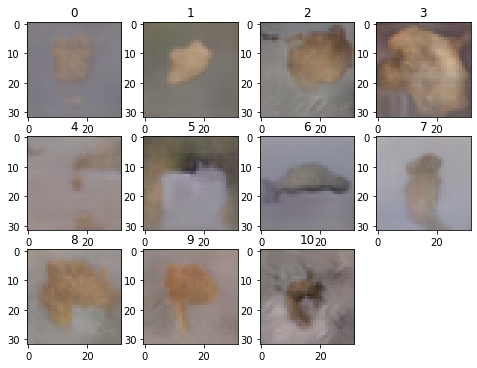

In [67]:
vectors=np.zeros((11,10),float)
for i in range(10):
    vectors[i+1,i]=1
print(vectors)
images=model.predict(vectors)
images=(images+1)/2 #from [-1,1] to [0,1]
plt.figure(figsize=(8,8))
for i in range(11):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i])
    plt.title(i)

[[ 1.03157231 -1.22718934 -0.2684462   0.38346866 -1.43125182 -0.02779377
   0.8761175   0.42733048 -0.09325175  0.54507106]]


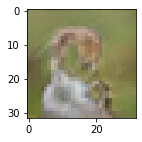

In [68]:
vector=np.random.randn(1,latent_dim)
print(vector)
image=model.predict(vector)
image=(image+1)/2
plt.figure(figsize=(2,2))
plt.imshow(image[0])